# Webscraping

In [5]:
from bs4 import BeautifulSoup
from urllib.request import Request, urlopen
import re
import pandas as pd

In [6]:
def webscraper(depth):
    # Final Dataframe
    final = pd.DataFrame.from_dict({"query": ["None"], "response": ["None"]})
    queries = []
    responses = []
    # Iterating through pages of forum
    for i in range(depth):
        # Finding all posts on forum page 
        url = "https://patient.info/forums/discuss/browse/depression-683?page={}#group-discussions".format(int(i))
        page = urlopen(Request(url, headers = {"User-Agent": "Mozilla/5.0"})).read()
        soup = BeautifulSoup(page, 'html.parser')
        
        href = [i["href"] for i in soup.find_all("a", href = True)]
        post_links = list(filter(lambda x:re.match(r"/forums/discuss/", x), href))
        post_links = list(set(post_links))
        
        # Iterating through every post on forum page
        for x in post_links:
            posturl = "https://patient.info/{}".format(str(x))
            postpage = urlopen(Request(posturl, headers = {"User-Agent": "Mozilla/5.0"})).read()
            soup = BeautifulSoup(postpage, 'html.parser')
            query = soup.find("div", {"class": "post__content"}).get_text()

            # Creating list in case of multiple responses
            temp = []
            
            for el in soup.findAll("div", {"class": "post__content break-word"}):
                temp.append(el.get_text())

            # Appending all responses to dataframe
            if len(temp) == 1:  
                queries.append(query)
                responses.append(temp[0])
            elif len(temp) > 1:
                for i in temp:
                    queries.append(query)
                    responses.append(str(i))
            else:
                queries.append("None")
                responses.append("None")
                
    final = final.append(pd.DataFrame.from_dict({"query": queries, "response": responses}), ignore_index = True)
    final.drop(0, inplace = True)

    return final, queries, responses
        

# Preprocessing

In [7]:
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

import nltk
from nltk.tokenize import sent_tokenize

%matplotlib inline

In [8]:
df = pd.read_csv("unprocessed_posts.csv")
df.head(10)

query  \
0  \r\n\r\nstarted on 50mg , dr increased to 100 ...   
1  \r\n\r\nBelow are listed recommended resources...   
2  \r\n\r\nBelow are listed recommended resources...   
3  \r\n\r\nBelow are listed recommended resources...   
4  \r\n\r\nBelow are listed recommended resources...   
5  \r\n\r\nHello everyone!\r\nI am now a couple a...   
6  \r\n\r\nHello everyone!\r\nI am now a couple a...   
7  \r\n\r\nHello, thanks for reading and I apolog...   
8  \r\n\r\nHello, thanks for reading and I apolog...   
9  \r\n\r\nHello, thanks for reading and I apolog...   

                                            response  
0  \r\n\r\nhi Ingridare you taking sertraline? So...  
1  \r\n\r\nawesome resource! thank you!          ...  
2  \r\n\r\nThank you for this, I'm sure lots of p...  
3  \r\n\r\nThanx for give informatic information ...  
4  \r\n\r\nYou are AMAZING for this! Thank you Hu...  
5  \r\n\r\nhi uzumak, i apologise if i have spelt...  
6  \r\n\r\nHi Uzumaki, I totally understand not w...  
7  \r\n\r\nHi Chantal, I can say quite categorica...  
8  \r\n\r\nAw Chantal, you poor girl this sounds ...  
9  \r\n\r\nHi ChantalAnxiety can cause us to doub...

In [9]:
# Removing \n and likes/follow counts and Report/Delete text
df["query"] = df["query"].apply(lambda x: re.sub(r'[0-9]+ likes?.*', '', re.sub(r'\n', ' ', x)))
df["response"] = df["response"].apply(lambda x: re.sub(r'Report.*', '', re.sub(r'\n', ' ', x)))

# # Removing anything that isn't a character
# df["query"] = df["query"].apply(lambda x: re.sub(r'[^a-zA-Z.]+', ' ', x))

# Removing pinned post
df.drop(df.index[1:5], inplace = True)
df.reset_index(drop = True, inplace = True)

# Removing links
df["query"] = df["query"].apply(lambda x: re.sub(r'http.*? ', ' ', x))

# Removing None's
df = df[df['query'] != "None"]

Mean query length:  236.88555489814894
Median query length:  170.0


Mean Response length:  94.49078691572986
Median Response length:  67.0


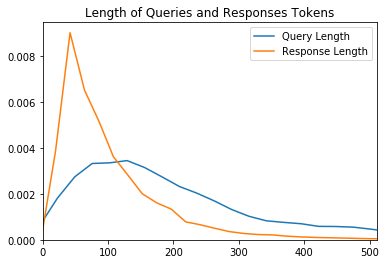

In [36]:
# Naive token assumptions (assuming space separates tokens)

token_len_query = [len(x) for x in [x.split(' ') for x in df["query"]]]
token_len_response = [len(x) for x in [x.split(' ') for x in df["response"]]]

print("Mean query length: ", str(sum(token_len_query)/len(token_len_query)))
print("Median query length: ", statistics.median(token_len_query))
print("\n")
print("Mean Response length: ", str(sum(token_len_response)/len(token_len_response)))
print("Median Response length: ", statistics.median(token_len_response))

g = sns.kdeplot(token_len_query, label = "Query Length")
g = sns.kdeplot(token_len_response, label = "Response Length")
g.set_title("Length of Queries and Responses Tokens")
g.set_xlim(0, 512)
plt.show()

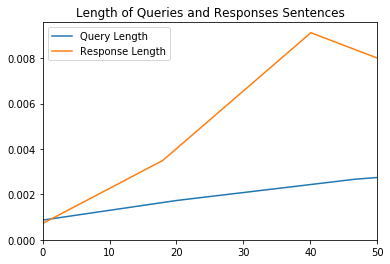

In [6]:
sent_len_query = [len(x) for x in [x.split('$') for x in [re.sub(r"[.!?]", "$", x) for x in df["query"]]]]
sent_len_query = [len(x) for x in [x.split('$') for x in [re.sub(r"[.!?]", "$", x) for x in df["response"]]]]

g = sns.kdeplot(token_len_query, label = "Query Length")
g = sns.kdeplot(token_len_response, label = "Response Length")
g.set_title("Length of Queries and Responses Sentences")
g.set_xlim(0, 50)
plt.show()

### Text Summarization

In [10]:
import time
import torch
from torch.autograd import Variable
import sys
sys.path.append("skip-thoughts.torch/pytorch")
from skipthoughts import DropUniSkip

import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import pairwise_distances_argmin_min

def summarize(forum_post, clusters=3, model_path = 'models/'):
    try: 
        # Tokenizing and Formatting
        sentences = sent_tokenize(forum_post)
        sentences = [re.sub(r'[^a-zA-Z0-9.!?]', ' ', x) for x in sentences]

        dir_st = model_path
        post = [nltk.tokenize.word_tokenize(x) for x in sentences]
        vocab = list(set([word for sentence in post for word in sentence]))

        raw = []

        for sentence in post:
            temp = []
            for word in sentence:
                temp.append(vocab.index(str(word)))
            raw+=[temp]

        for x in raw:
            if len(x) < max([len(x) for x in raw]):
                x += ["0"]*(max([len(x) for x in raw])-len(x))

        final = []

        for sent in raw:
            temp = []
            for word in sent:
                temp.append(int(word))
            final += [temp]

        # Skipthought summarization
        x = Variable(torch.LongTensor(final))

        uniskip = DropUniSkip(dir_st, vocab)

        output = uniskip(x)
        output = output.detach().numpy()

        # Clustering and summarizing
        n_clusters = clusters
        kmeans = KMeans(n_clusters = n_clusters)
        kmeans = kmeans.fit(output)

        avg = []
        for j in range(n_clusters):
            idx = np.where(kmeans.labels_ == j)[0]
            avg.append(np.mean(idx))
        closest, _ = pairwise_distances_argmin_min(kmeans.cluster_centers_, output)
        ordering = sorted(range(n_clusters), key=lambda k: avg[k])
        summary = ' '.join([sentences[closest[idx]] for idx in ordering])

        print(forum_post[0:50])
    
        return summary
    
    except: 
        return ("None")

In [11]:
df["summarized_query"] = df["query"].apply(summarize, args=(3, "models/"))
df["summarized_respose"] = df["response"].apply(summarize, args=(3, "models/"))

 I am now a couple a years on 
 I am now a couple a years on 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Yesterday I woke up to my boyfriend saying "we
 Yesterday I woke up to my boyfriend saying "we
 Yesterday I woke up to my boyfriend saying "we
 If you are feeling in des

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 I got married at 25 of my age, I got p
 I got married at 25 of my age, I got p
 this hasn't got any to do with the coronavirus
 this hasn't got any to do with the coronavirus
 this hasn't got any to do with the coronavirus
 this hasn't got any to do with the coronavirus
 this hasn't got any to do with the coronavirus
 this hasn't got any to do with the coronavirus
 this ha

 Hi everyone.  I'm posting this because I have 
 Hi everyone.  I'm posting this because I have 
 Hey everyone, i went for a medication review t
 Hey everyone, i went for a medication review t
 Hey everyone, i went for a medication review t
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 For a bit of background, I have suffe
 

 Hi guys & girls, I've been a member on the for
 Hi guys & girls, I've been a member on the for
 Hi guys & girls, I've been a member on the for
 Hi guys & girls, I've been a member on the for
 im 16 years old and i dont know whats going on
 my boyfriend and i got in a fight around 2 mon
 my boyfriend and i got in a fight around 2 mon
 my boyfriend and i got in a fight around 2 mon
 my boyfriend and i got in a fight around 2 mon
 My depression had continued to become worse an
 im pretty suicidally depressed at th
 im pretty suicidally depressed at th
 im pretty suicidally depressed at th
 im pretty suicidally depressed at th
 im pretty suicidally depressed at th
 im pretty suicidally depressed at th
 I started prozac 20 mg 3 week ago and i feel r
 I started prozac 20 mg 3 week ago and i feel r
 I started prozac 20 mg 3 week ago and i feel r
 I started prozac 20 mg 3 week ago and i feel r
 I started prozac 20 mg 3 week ago and i feel r
 Hi wonderful. i am in 75 of Pristiq. And 600 L
 I'v

 I was on 50mg of Sertraline, I have gone ‘cold
 I have been on and off citalopram f
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 Hello, everyone.I have had lifelong issues wit
 Hello, everyone.I have had lifelong issues wit
 Hello, everyone.I have had lifelong issues wit
 Hello, everyone.I have had lifelong issues wit
 Hello, everyone.I have had lifelong issues wit
 Hi people thought id bring up a subject thats 
 Hi people thought id bring up a subject thats 
 Hi people thought id bring up a subject thats 
 Hi people thought id bring up a subject thats 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Lately I have been dealing with some things an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Lately I have been dealing with some things an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Lately I have been dealing with some things an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Lately I have been dealing with some things an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Lately I have been dealing with some things an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Lately I have been dealing with some things an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Lately I have been dealing with some things an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Lately I have been dealing with some things an
 hello all ....i currently take prozac and abil
 hello all ....i currently take prozac and abil
 Hi everyone. My boyfriend has severe depressio
 Hi everyone. My boyfriend has severe depressio
 Hi everyone. My boyfriend has severe depressio
 Hi everyone. My boyfriend has severe depressio
 I'll be off to the doctors within 
 I'll be off to the doctors within 
 I'll be off to the doctors within 
 I'll be off to the doctors within 
 I'll be off to the doctors within 
 I'll be off to the doctors within 
 I'll be off to the doctors within 
 I'll be off to the doctors within 
 I'll be off to the doctors within 
 I'll be off to the doctors within 
 so ill try make a long story short as possible
 so ill try make a long story short as possible
 so ill try make a long story short as possible
 so ill try make a long story short as possible
 so ill try make a long story short as possible
 so ill try make a long story short as possible
 so ill try make

 These last few weeks have been difficult beyon
 These last few weeks have been difficult beyon
 Hi everyone,I just started taking Celexa (20mg
 Hi everyone,I just started taking Celexa (20mg
 Hi everyone,I just started taking Celexa (20mg
 Hi everyone,I just started taking Celexa (20mg
 Hi everyone,I just started taking Celexa (20mg
 This has been on my mind for quite
 This has been on my mind for quite
 This has been on my mind for quite
 my boyfriend has depression, he doesn't want t
 my boyfriend has depression, he doesn't want t
 my boyfriend has depression, he doesn't want t
 my boyfriend has depression, he doesn't want t
 my boyfriend has depression, he doesn't want t
 my boyfriend has depression, he doesn't want t
 my boyfriend has depression, he doesn't want t
 my boyfriend has depression, he doesn't want t
 I have possibly been depressed for five years 
 The thoughts I’ve been having don’t make any s
 The thoughts I’ve been having don’t make any s
 The thoughts I’ve been havi

 At first back in August I started with Anxiety
 At first back in August I started with Anxiety
 At first back in August I started with Anxiety
 At first back in August I started with Anxiety
 My life is falling apart. I suffer from chroni
 My life is falling apart. I suffer from chroni
 My life is falling apart. I suffer from chroni
 My life is falling apart. I suffer from chroni
 My life is falling apart. I suffer from chroni
 My life is falling apart. I suffer from chroni
 My life is falling apart. I suffer from chroni
 My life is falling apart. I suffer from chroni
 My life is falling apart. I suffer from chroni
 My life is falling apart. I suffer from chroni
 I'm feeling sad most of the time and I feel re
 I'm feeling sad most of the time and I feel re
 I'm feeling sad most of the time and I feel re
 I'm feeling sad most of the time and I feel re
 I'm feeling sad most of the time and I feel re
 I'm feeling sad most of the time and I feel re
 I am 55 yrs. old and never married. I w

 Im getting married. To a guy ive been going ou
 Im getting married. To a guy ive been going ou
 Im getting married. To a guy ive been going ou
 Im getting married. To a guy ive been going ou
 Im getting married. To a guy ive been going ou
 I have been feeling a terrifying low for some 
 I have been feeling a terrifying low for some 
 I have been feeling a terrifying low for some 
 I have been feeling a terrifying low for some 
 I have been feeling a terrifying low for some 
 I have been feeling a terrifying low for some 
 I have been feeling a terrifying low for some 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello every one. im 23 years old , i was a ver


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello every one. im 23 years old , i was a ver


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everybody. I was reading some of the other 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everybody. I was reading some of the other 
 I guess my depression is acting up.  I'm feeli
 I guess my depression is acting up.  I'm feeli
 I have been to my GP who referred me to this s
 I have been to my GP who referred me to this s
 I have been to my GP who referred me to this s
 I have been to my GP who referred me to this s
 I have been to my GP who referred me to this s
 i have a step son 42 and he hates his life. He
 i have a step son 42 and he hates his life. He
 i have a step son 42 and he hates his life. He
 i have a step son 42 and he hates his life. He
 i have a step son 42 and he hates his life. He
 i have a step son 42 and he hates his life. He
 Okay, im new here so my apologies if i am not 
 Okay, im new here so my apologies if i am not 
 I am really struggling at the moment. Every da
 I am really struggling at the moment. Every da
 I am really struggling at the moment. Every da
 I am really struggling at the moment. Every da
 I am really struggling at the moment. E

 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi, I am new to this depression forum.  I have
 Hi, I am new to this depression forum.  I have
 I've been going through allot for a long time.
 I've been going through allot for a long time.
 I've been going through allot for a long time.
 I've been going through allot for a long time.
 I've been going through allot for a long time.
 I've been going through allot for a long time.
 I've been going through allot for a long time.
 I've been going through allot for a long time.
 I've been going through allot for a lon

 i was told last year that my wife of 17 years 
 i was told last year that my wife of 17 years 
 i was told last year that my wife of 17 years 
 i was told last year that my wife of 17 years 
 hi I have been on vensir225mg for  over 2 year
 hi I have been on vensir225mg for  over 2 year
 hi I have been on vensir225mg for  over 2 year
 hi I have been on vensir225mg for  over 2 year
 hi I have been on vensir225mg for  over 2 year
 hi I have been on vensir225mg for  over 2 year
 hi I have been on vensir225mg for  over 2 year
 When I walk to my best friend, she walks away.


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi I'm just after a bit of advice really it's 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi I'm just after a bit of advice really it's 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi I'm just after a bit of advice really it's 
 I've been reading a lot of threa
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 hi to all those people out there who would lik
 hi to all those people out there who would lik
 hi to all those people out there who would lik
 hi to all those people out there who would lik
 hi, this is my first time writing to this foru
 hi, this is my first time writing to this foru
 hi, this is my first time writing to this foru
 So drained and  tired of others manipulative b
 So drained and  tired of others manipulative b
 So drained and  tired of others manipulative b
 So drained and  tired of others manipulative b
 So drained and  tired of others manipulative b
 So dr

 I wondering if anyone can help m
 17 years, freshman in one of the top 3 SUNY sc
 17 years, freshman in one of the top 3 SUNY sc
 17 years, freshman in one of the top 3 SUNY sc
 I'm looking  for some faith and hope that thin
 I'm looking  for some faith and hope that thin
 I'm looking  for some faith and hope that thin
 I'm looking  for some faith and hope that thin
 I'm looking  for some faith and hope that thin
 I'm looking  for some faith and hope that thin
 I'm looking  for some faith and hope that thin
 I last year rented out my house and mo
 I last year rented out my house and mo
 My partner of 10 years left me last December s
 My partner of 10 years left me last December s
 My partner of 10 years left me last December s
 My partner of 10 years left me last December s
 My partner of 10 years left me last December s
 My partner of 10 years left me last December s
 My partner of 10 years left me last December s
 My partner of 10 years left me last December s
 My partner of 10 year

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 I posted a while ago about my anxiety and depr
 I posted a while ago about my anxiety and depr
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about peop

 My mum is back in my life after 10 years, unfo
 My mum is back in my life after 10 years, unfo
 I'm suffering from major depression, anxiety a
 Hi all i am rather new to all of this and the 
 Hi all i am rather new to all of this and the 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm a 23 year old woman working for a large or


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm a 23 year old woman working for a large or


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm a 23 year old woman working for a large or


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm a 23 year old woman working for a large or


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm a 23 year old woman working for a large or


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm a 23 year old woman working for a large or


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm a 23 year old woman working for a large or
 I have Borderline Personality Disorder and Man
 I have Borderline Personality Disorder and Man
 I have Borderline Personality Disorder and Man
 I have Borderline Personality Disorder and Man
 Hello I've  been with my girlfriend for a year
 Hello I've  been with my girlfriend for a year
 Hello I've  been with my girlfriend for a year
 Hello I've  been with my girlfriend for a year
 Hello I've  been with my girlfriend for a year
 Hello I've  been with my girlfriend for a year
 tolerance to benzo is awful.  nobody told me a
 tolerance to benzo is awful.  nobody told me a
 tolerance to benzo is awful.  nobody told me a
 tolerance to benzo is awful.  nobody told me a
 tolerance to benzo is awful.  nobody told me a
 tolerance to benzo is awful.  nobody told me a
 tolerance to benzo is awful.  nobody told me a
 tolerance to benzo is awful.  nobody told me a
 tolerance to benzo is awful.  nobody told me a
 tolerance to benzo is awful.  nobody to

 Hello.  Does anyone have bad loss of appetite 
 I tried mirtazapine a couple of years ago and 
 I tried mirtazapine a couple of years ago and 
 I tried mirtazapine a couple of years ago and 
 I tried mirtazapine a couple of years ago and 
 I'm at my wits end and finall
 I'm at my wits end and finall
 I'm at my wits end and finall
 I'm at my wits end and finall
 I'm at my wits end and finall
 I'm at my wits end and finall
 Me and my fiance have always wanted a dog
 Me and my fiance have always wanted a dog
 Me and my fiance have always wanted a dog
 Me and my fiance have always wanted a dog
 Me and my fiance have always wanted a dog
 Me and my fiance have always wanted a dog
 Me and my fiance have always wanted a dog
 Me and my fiance have always wanted a dog
 Here's the original post I made 4 years ago:
 Here's the original post I made 4 years ago:
 Here's the original post I made 4 years ago:
 Here's the original post I made 4 years ago:
 hi,i am new to this but has anyone had the fo

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello all, ive been reading these forums and p


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello all, ive been reading these forums and p


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello all, ive been reading these forums and p
 Last night I as feeling via so depressed    I 
 Last night I as feeling via so depressed    I 
 Last night I as feeling via so depressed    I 
 Last night I as feeling via so depressed    I 
 Last night I as feeling via so depressed    I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone. I know a girl since 8 years ago, 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone. I know a girl since 8 years ago, 
 hi people, please help. i need to know whether
 hi people, please help. i need to know whether
 hi people, please help. i need to know whether
 hi people, please help. i need to know whether
 hi people, can anyone help me to regain my sel
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 Hi,Does anyone know how to delete this account
 Hi,Does anyone know how to delete this account
 Im entering my 8th week on dosulepin nearly 2 
 Im entering my 8th week on dosulepin nearly 2 
 Im entering my 8th week on dosulepin nearly 2 
 Im entering my 8th week on dosulepin nearly 2 
 Im entering my 8th week on dosulepin nearly 2 
 Im entering my 8th week on dosulepin ne

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 
 I wonder if anybody has these symtoms.?Havebee
 i took lexapro for a coupleyears and now it do
 I have no friends & only a few family members 
 I have no friends & only a few family members 
 I have no friends & only a few family members 
 I have no friends & only a few family members 
 I have no friends & only a few family members 
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been exp

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all, last year in september i started mirta
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 I struggle with anxiety for a long time now. L
 Hey,I'm new here, I'm just going to start. I a
 Hey,I'm new here, I'm just going to sta

 I'm 51 and been off from work with WRS, anxiet
 I'm 51 and been off from work with WRS, anxiet
 I'm 51 and been off from work with WRS, anxiet
 I'm 51 and been off from work with WRS, anxiet
 I'm 51 and been off from work with WRS, anxiet
 I'm 51 and been off from work with WRS, anxiet
 **Hi everyone, I joined this group years ago a
 **Hi everyone, I joined this group years ago a
 **Hi everyone, I joined this group years ago a
 **Hi everyone, I joined this group years ago a
 Hi there. I'm just about to go back to teachin
 Hi there. I'm just about to go back to teachin
 Hi there. I'm just about to go back to teachin
 Hi there. I'm just about to go back to teachin
 Hi there. I'm just about to go back to teachin
 Hi there. I'm just about to go back to teachin
 Hi there. I'm just about to go back to teachin
 Hi there. I'm just about to go back to teachin
 ive been severly depressed and haveing bad tho
 ive been severly depressed and haveing bad tho
 ive been severly depressed and haveing 

 I've suffered from clinical depression on and 
 I'm not sure if this is caused by depression o
 I'm not sure if this is caused by depression o
 **i been here before i think today is the end 
 **i been here before i think today is the end 
 **i been here before i think today is the end 
 **i been here before i think today is the end 
 **i been here before i think today is the end 
 This is going to be long, but I'm at the point
 This is going to be long, but I'm at the point
 This is going to be long, but I'm at the point
 This is going to be long, but I'm at the point
 Why is it that I always resort to suicidal ide
 Why is it that I always resort to suicidal ide
 Why is it that I always resort to suicidal ide
 Why is it that I always resort to suicidal ide
 Why is it that I always resort to suicidal ide
 hi...i have posted on here before but its been
 hi...i have posted on here before but its been
 hi...i have posted on here before but its been
 hi...i have posted on here before but i

 i am on my second course of cbt.The first cour
 i am on my second course of cbt.The first cour
 i am on my second course of cbt.The first cour
 i am on my second course of cbt.The first cour
 i am on my second course of cbt.The first cour
 i am on my second course of cbt.The first cour
 i am on my second course of cbt.The first cour
 i am on my second course of cbt.The first cour
 i am on my second course of cbt.The first cour
 i am on my second course of cbt.The first cour
 i am on my second course of cbt.The first cour
 Hi there. I been off work with WRS, anxiety an
 Hi there. I been off work with WRS, anxiety an
 Hi there. I been off work with WRS, anxiety an
 Hi there. I been off work with WRS, anxiety an
 Hi there. I been off work with WRS, anxiety an
 Hi there. I been off work with WRS, anxiety an
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I 

 Why am I hear and why do i feel sometimes that
 Why am I hear and why do i feel sometimes that
 Why am I hear and why do i feel sometimes that
 Why am I hear and why do i feel sometimes that
 Why am I hear and why do i feel sometimes that
 Why am I hear and why do i feel sometimes that
 Why am I hear and why do i feel sometimes that
 Why am I hear and why do i feel sometimes that
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 Hi guys, I've been suffering from agoraphobia 
 Hi guys, I've been suffering from agoraphobia 
 Hi guys, I've been suffering from agoraphobia 
 Hi guys, I've been suffering from agoraphobia 
 Hello everybody

 Friends, i have been on just about every antid
 Friends, i have been on just about every antid
 Friends, i have been on just about every antid
 Friends, i have been on just about every antid
 Friends, i have been on just about every antid
 Friends, i have been on just about every antid
 Friends, i have been on just about every antid
 I am a seventeen nearly eightteen year old mal
 I am a seventeen nearly eightteen year old mal
 I am a seventeen nearly eightteen year old mal
 I am a seventeen nearly eightteen year old mal
 I am a seventeen nearly eightteen year old mal
 I am a seventeen nearly eightteen year old mal
 I am a seventeen nearly eightteen year old mal
 I am a seventeen nearly eightteen year old mal
 I am a seventeen nearly eightteen year old mal
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can

 My partner has just gone to bed feeling very d
 My partner has just gone to bed feeling very d
 My partner has just gone to bed feeling very d
 My partner has just gone to bed feeling very d
 My partner has just gone to bed feeling very d
 My partner has just gone to bed feeling very d
 My partner has just gone to bed feeling very d
 Hi, I can't remember feeling as sad & lonely a
 Hi, I can't remember feeling as sad & lonely a
 Hi, I can't remember feeling as sad & lonely a
 Hi, I can't remember feeling as sad & lonely a
 I haven't spoke to me mum for about 5 years. I
 i feel devestated and all alone.  ive been see
 i feel devestated and all alone.  ive been see
 i feel devestated and all alone.  ive been see
 i feel devestated and all alone.  ive been see
 i feel devestated and all alone.  ive been see
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I'v

 Hey people,So I am rapidly approaching my 40th
 Hello all. So I have been on several medicatio
 Hello all. So I have been on several medicatio
 Hello all. So I have been on several medicatio
 Hello all. So I have been on several medicatio
 Hello all. So I have been on several medicatio


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 noticed 2000 plus discussions on here!now here
 noticed 2000 plus discussions on here!now here
 noticed 2000 plus discussions on here!now here
 noticed 2000 plus discussions on here!now here
 noticed 2000 plus discussions on here!now here
 noticed 2000 plus discussions on here!now here
 noticed 2000 plus discussions on here!now here
 Am i the only one that thinks the whole 'you c
 Am i the only one that thinks the whole

 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 I've been on Mirtazapin for more t
 I've been on Mirtazapin for more t
 I've been on Mirtazapin for more t
 I suffer from constant itchiness prickly feeli
 I suffer from constant itchiness prickly feeli
 I suffer from constant itchiness prickly feeli
 I suffer from constant itchiness prickly feeli
 I feel really depressed right now. I jus
 I feel really depressed right now. I jus
 I feel really depressed right now. I jus
 I feel really depressed right now. I jus
 I feel really depressed right now. I jus
 I feel really depressed right now. I jus
 I feel really depressed right now. I jus
 I feel really depressed right now. I jus
 I feel really depressed rig

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 Every day when I wake up, I have
 Every day when I wake up, I have
 Every day when I wake up, I have
 Every day when I wake up, I have
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no


 I have lost all my savings to scammer whom I m
 I have lost all my savings to scammer whom I m
 I have lost all my savings to scammer whom I m
 I have lost all my savings to scammer whom I m
 I have lost all my savings to scammer whom I m
 I have lost all my savings to scammer whom I m
 Ever since I had some scary pressure in my hea
 Ever since I had some scary pressure in my hea
 Ever since I had some scary pressure in my hea
 Hello all,I am a 22 year old university gradua
 To cut a long story short I 'burnt out' a week
 To cut a long story short I 'burnt out' a week
 To cut a long story short I 'burnt out' a week
 To cut a long story short I 'burnt out' a week
 To cut a long story short I 'burnt out' a week
 I'm currently taking Mirtazapine 15mg 
 I'm currently taking Mirtazapine 15mg 
 I'm currently taking Mirtazapine 15mg 
 I'm currently taking Mirtazapine 15mg 
 im suffering from ansiety off an on since 1994
 im suffering from ansiety off an on since 1994
 im suffering from ansie

 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazap

 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 My boyfriend broke with me. First he said , he
 My boyfriend broke with me. First he said , he
 Well now my health is bad! I feel even more de
 Well now my health is bad! I feel even more de
 Well now my health is bad! I feel even more de
 I am in England, and have 4 sessions of CBT le
 I am in England, and have 4 sessions of CBT le
 I am in England, and have 4 sessions of CBT le
 I am in England, and have 4 sessions of CBT le
 I am in England, and have 4 sessions of CBT le
 I am in England, and have 4 sessions of CBT le
 I am in England, and have 4 sessions of CBT le
 I am in England, and have 4 sessions of CBT le
 I am in England, and have 4 sessions of CBT le
 I'm sorry that I'm not good enough... I

 hi everyone, so the past year i was diagnosed 
 hi everyone, so the past year i was diagnosed 
 hi everyone, so the past year i was diagnosed 
 it's been a while and i see most of you guys a
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 will more fluoxetine help me being so sensitiv
 will more fluoxetine help me being so sensitiv
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad an

 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 I left school early because I hated it, was de
 I left school early because I hated it, was de
 I left school early because I hated it, was de
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 ive been severely depressed for the past 18 mo
 ive been severely depressed for the pas

 I cant escape the lonely and depressed feeling
 I cant escape the lonely and depressed feeling
 Hi people, i want a shoulder to cry on! I keep
 Hi people, i want a shoulder to cry on! I keep
 I'm not in the best frame of mind at the momen
 I'm not in the best frame of mind at the momen
 I'm not in the best frame of mind at the momen
 I'm not in the best frame of mind at the momen
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have just rea
 Hi people, can anyone help me? I have j

 Hey,A lot has happened over the past 2 years, 
 Hi. I don't know what's wrong with me. I have 
 Hi. I don't know what's wrong with me. I have 
 Hi. I don't know what's wrong with me. I have 
 Hi. I don't know what's wrong with me. I have 
 i am 24 years old. i don't have a college degr
 i am 24 years old. i don't have a college degr
 i am 24 years old. i don't have a college degr
 i am 24 years old. i don't have a college degr
 i am 24 years old. i don't have a college degr
 i am 24 years old. i don't have a college degr
 i am 24 years old. i don't have a college degr
 i am 24 years old. i don't have a college degr
 Hi all. It's been over a year now since my sta
 Hi all. It's been over a year now since my sta
 Hi all. It's been over a year now since my sta
 Survivor of severe depression, multiple ADs, m
 Survivor of severe depression, multiple ADs, m
 All day I go through the same thing, wake up, 
 All day I go through the same thing, wake up, 
 All day I go through the same thing, wa

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 Well I am not alone. I have read all I could f
 Well I am not alone. I have read all I could f
 Well I am not alone. I have read all I could f
 Well I am not alone. I have read all I could f
 Well I am not alone. I have read all I could f
 Well I am not alone. I have read all I could f
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. 

 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I had this great gp who really helped me but s
 I had this great gp who really helped me but s
 I had this great gp who really helped me but s
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi i hope there is someone in the same boat as


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi i hope there is someone in the same boat as


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi i hope there is someone in the same boat as


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi i hope there is someone in the same boat as


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi i hope there is someone in the same boat as


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi i hope there is someone in the same boat as


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi i hope there is someone in the same boat as


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi i hope there is someone in the same boat as
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi,I'm new to this and have never posted anyth
 Hi,I'm new to this and have never posted anyth
 Hi,I'm new to this and have never posted anyth
 Hi,I'm new to this and have never posted anyth
 Hi,I'm new to this and have never posted anyth
 Hi,I'm new to this and have never posted anyth
 Hi,I'm new to this and have never posted anyth
 I have been struggling more the last few month
 I have been struggling more the last fe

 Hi all. I have severe anxiety, panic disorder 
 Hi all. I have severe anxiety, panic disorder 
 Hi, I’ve struggled with anxiety and depression
 Hi, I’ve struggled with anxiety and depression
 Hi, I’ve struggled with anxiety and depression
 Hi, I’ve struggled with anxiety and depression
 Is it possible to feel numb and unhappy at the
 Is it possible to feel numb and unhappy at the
 Is it possible to feel numb and unhappy at the
 Is it possible to feel numb and unhappy at the
 Is it possible to feel numb and unhappy at the
 Hi ive been diagnosed with depression by my do
 Hi ive been diagnosed with depression by my do
 Hi ive been diagnosed with depression by my do
 Basically my current situation is I'm a sophom
 Basically my current situation is I'm a sophom
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don'

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,
 Hi after suffering from bad depression and anx
 Hi after suffering from bad depression and anx
 Hi after suffering from bad depression and anx
 Hi after suffering from bad depression and anx
 Hi after suffering from bad depression and anx
 I stumbled upon a video about depression, main
 I stumbled upon a video about depression, main
 I stumbled upon a video about depression, main
 I stumbled upon a video about depression, main
 I stumbled upon a video about depression, main
 I stumbled upon a video about depression, main
 Hi guys, I've felt really desperately low all 
 Hi guys, I've felt really desperately low all 
 Hi guys, I've felt really desperately low all 
 Hi. I have a bit of a problem. I suffer from d
 Hi. I have a bit of a problem. I suffer from d
 Hi. I have a bit of a problem. I suffer from d
 So I’m pretty sure my girlfriend has stopped t
 So I’m pretty sure my girlfriend has stopped t


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hate my family from day one I felt it that m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hate my family from day one I felt it that m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hate my family from day one I felt it that m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hate my family from day one I felt it that m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hate my family from day one I felt it that m
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm qui

 hi all...Im new here and am trying to reach ou
 hi all...Im new here and am trying to reach ou
 hi all...Im new here and am trying to reach ou
 hi all...Im new here and am trying to reach ou
 hi all...Im new here and am trying to reach ou
 hi all...Im new here and am trying to reach ou
 Hi people can any of you experts on here help?
 Hi people can any of you experts on here help?
 Hi people can any of you experts on here help?
 Hi people can any of you experts on here help?
 Hi, my boyfriend of one year broke up with me 
 Hi, my boyfriend of one year broke up with me 
 Hi, my boyfriend of one year broke up with me 
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompet

 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I'm not sure whether I suffer from depr

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 I don't really know how to start with this so 
 I don't really know how to start with this so 
 I don't really know how to start with this so 
 I don't really know how to start with this so 
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 I am 32 yrs, a civil contractor.For the past 3
 I am 32 yrs, a civil contractor.For the past 3
 I am 32 yrs, a civil contractor.For the

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 Hey guysI hope you are all as well as can be.I
 Hey guysI hope you are all as well as can be.I


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey guysI hope you are all as well as can be.I
 Hey guysI hope you are all as well as can be.I
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
 Hi, guys! I've been dealing with some personal
  My psych upped me to 20mg of flu. Only two da
  My psych upped me to 20mg of flu. Only two da
  My psych upped me to 20mg of flu. Only two da
  My psych upped me to 20mg of flu. Only two da
  My psych upped me to 20mg of flu. Only

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hey anyone reading this,I've been depressed fo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hey anyone reading this,I've been depressed fo
 hey anyone reading this,I've been depressed fo
 hey anyone reading this,I've been depressed fo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hey anyone reading this,I've been depressed fo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hey anyone reading this,I've been depressed fo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hey anyone reading this,I've been depressed fo
 He had cancer as a child. Went through rigorou
 Has this happened with anyone and came out of 
 Has this happened with anyone and came out of 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I admitted I had a problem about 12 mon

 Hi everyone, my name is Peter. I don't really 
 Hi everyone, my name is Peter. I don't really 
 Hi everyone, my name is Peter. I don't really 
 Hi everyone, my name is Peter. I don't really 
 Hi everyone, my name is Peter. I don't really 
 hey whoever is out there just need some advice
 hey whoever is out there just need some advice
 hey whoever is out there just need some advice
 Hi, first time here so please bare with me.  I
 Hi, first time here so please bare with me.  I
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few mo

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all just looking for some advice really. Iv
 Hi all just looking for some advice really. Iv
 Hi all just looking for some advice really. Iv
 Hi all just looking for some advice really. Iv
 Hi guys,So basically I'm a survivor of attempt
 Hi guys,So basically I'm a survivor of attempt
 Hi guys,So basically I'm a survivor of attempt
 Hi guys,So basically I'm a survivor of attempt
 Hi guys,So basically I'm a survivor of attempt
 Hi guys,So basically I'm a survivor of attempt
 Just need to make sure I can start taking them
 Just need to make sure I can start taking them
 Just need to make sure I can start taking them
 Just need to make sure I can start taking them
 Just need to make sure I can start taking them
 I feel not loved by my parents. I have tried t
 I feel not loved by my parents. I have tried t
 I feel not loved by my parents. I have tried t
 This is just going to be me complaining about 
 This is just going to be me complaining about 
 This is just going to be me complaining

 I’ve suffered with depression for a few years 
 I’ve suffered with depression for a few years 
 I’ve suffered with depression for a few years 
 I’ve suffered with depression for a few years 
 I’ve suffered with depression for a few years 
 I’ve suffered with depression for a few years 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 I've had anxiety since I was 17. I'm mid 30's 
 I've had anxiety since I was 17. I'm mid 30's 
 I've had anxiety since I was 17. I'm mid 30's 
 I've had anxiety since I was 17. I'm mid 30's 
 I've had anxiety since I was 17. I'm mid 30's 
 I've had anxiety since I was 17. I'm mid 30's 
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Cu

 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Hi, sorry this is gonna be a long one! I have 
 Hi, sorry this is gonna be a long one! I have 
 Hi, sorry this is gonna be a long one! I have 
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here,

 So I'm in my early 30's and been out of work f
 So I'm in my early 30's and been out of work f
 So I'm in my early 30's and been out of work f
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I live in Vancouver, Canada, and recently disc
 I live in Vancouver, Canada, and recently disc
 I live in Vancouver, Canada, and recently disc
 I don’t know why I feel this way. Anytime my s
 Hey guys, could you suggest anything?We

 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 Hi everybody.I had a long story with depressio
 Hi everybody.I had a long story with depressio
 Hi everybody.I had a long story with depressio
 Hi everybody.I had a long story with depressio
 Hi everybody.I had a long story with depressio
 I'm not sure why I'm writing this, I guess I j
 I'm not sure why I'm writing this, I guess I j
 I'm not sure why I'm writing this, I gu

 Please read my story and I would be so gratefu
 Please read my story and I would be so gratefu
 Please read my story and I would be so gratefu
 Please read my story and I would be so gratefu
 Please read my story and I would be so gratefu
 Please read my story and I would be so gratefu
 Hello. I am 52, and have anxiety and depressio
 Hello. I am 52, and have anxiety and depressio
 Hello. I am 52, and have anxiety and depressio
 Hello. I am 52, and have anxiety and depressio
 Hi, Firstly i find this whole thing hard to ex
 Hi I have been bi polar and manic depression f
 Hi I have been bi polar and manic depression f
 Hi I have been bi polar and manic depression f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,So I’ve been wanting to talk about this for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,So I’ve been wanting to talk about this for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,So I’ve been wanting to talk about this for
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 I am suffering from a whole host of things rig
 I am suffering from a whole host of things rig
 I am suffering from a whole host of things rig
 I am suffering from a whole host of things rig
 I have suicidal thoughts all the time but I mo
 I have suicidal thoughts all the time but I mo
 I have suicidal thoughts all the time but I mo
 If you are in a partnership, how do you (as a 
 If you are in a partnership, how do you (as a 
 If you are in a partnership, how do you (as a 
 If you are in a partnership, how do you (as a 
 If you are in a partnership, how do you

 Hello, after an unsuccessful switch to citalop
 Hello, after an unsuccessful switch to citalop
 Hello, after an unsuccessful switch to citalop
 I dont know why after my divorce I cant sleep.
 I dont know why after my divorce I cant sleep.
 I dont know why after my divorce I cant sleep.
 I have been on 50 mg of Zoloft for 4 weeks now
 I have been on 50 mg of Zoloft for 4 weeks now
 I have been on 50 mg of Zoloft for 4 weeks now
 I have been on 50 mg of Zoloft for 4 weeks now
 I would consider myself a strong individual, t
 I would consider myself a strong individual, t
 I would consider myself a strong individual, t
 I would consider myself a strong individual, t
 I would consider myself a strong individual, t
 Hi - recently joined this forum - if I can sha
 Hi - recently joined this forum - if I can sha
 Hi - recently joined this forum - if I can sha
 Hi - recently joined this forum - if I can sha
 Hi - recently joined this forum - if I can sha
 Hi - recently joined this forum - if I 

 My name is Brandon and Im 25 years old. I live
 My name is Brandon and Im 25 years old. I live
 My name is Brandon and Im 25 years old. I live
 So I met this girl when I was 14, and my life 
 So I met this girl when I was 14, and my life 
 So I met this girl when I was 14, and my life 
 I just made a several cuts on my arms because 
 I just made a several cuts on my arms because 
 I just made a several cuts on my arms because 
 I just made a several cuts on my arms because 
 I just made a several cuts on my arms because 
 Too many questions are inside my head Why can’
 Too many questions are inside my head Why can’
 Hi all. I've been going through a tough period
 Hi all. I've been going through a tough period
 Hi all. I've been going through a tough period
 I am usually here to support others, but this 
 I am usually here to support others, but this 
 I am usually here to support others, but this 
 I am usually here to support others, but this 
 I am usually here to support others, bu

 F24- I am currently in a relationship and i fe
 F24- I am currently in a relationship and i fe
 F24- I am currently in a relationship and i fe
 Background I’ve been with my employer for 9 ye
 I've been on celexa and wellbutrin for around 
 I've been on celexa and wellbutrin for around 
 I've been on celexa and wellbutrin for around 
 I've been on celexa and wellbutrin for around 
 I've been on celexa and wellbutrin for around 
 I've been on celexa and wellbutrin for around 
 I see so many folks dealing with Anxiety issue
 I see so many folks dealing with Anxiety issue
 I see so many folks dealing with Anxiety issue
 I see so many folks dealing with Anxiety issue
 I see so many folks dealing with Anxiety issue
 I see so many folks dealing with Anxiety issue
 I see so many folks dealing with Anxiety issue
 My dog is  German Shepherd as you read in titl
 My dog is  German Shepherd as you read in titl
 My dog is  German Shepherd as you read in titl
 My dog is  German Shepherd as you read 

 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Has anybody had to change from citalopram to f
 Has anybody had to change from citalopram to f
 This might be long but I really need to get th
 This might be long but I really need to get th
 This might be long but I really need to get th
 This might be long but I really need to get th
 This might be long but I really need to get th
 This might be long but I really need to get th
 This might be long but I really need to get th
 Last year, I had two very close friends. One f
 Last year, I had two very close friends. One f
 Last year, I had two very close friends. One f
 Last year, I had two very close friends

 Thoughts please. I’m trying to work out what’s
 Thoughts please. I’m trying to work out what’s
 Thoughts please. I’m trying to work out what’s
 Thoughts please. I’m trying to work out what’s
 Thoughts please. I’m trying to work out what’s
 Hi,I am really in need of advice. My partner o
 Hi ~ I've struggled with depression for years 
 Hi ~ I've struggled with depression for years 
 Hi ~ I've struggled with depression for years 
 Hi ~ I've struggled with depression for years 
 Hi ~ I've struggled with depression for years 
 Hi ~ I've struggled with depression for years 
 Hi ~ I've struggled with depression for years 
 Why are the numbers to call costing ? I’m cut 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi there, honestly i have no idea why im here,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi there, honestly i have no idea why im here,
 I’ve been battling with depression for two wee
 I’ve been battling with depression for two wee
 I’ve been battling with depression for two wee
 I'm 48 and I can't remember the last time I wo
 I'm 48 and I can't remember the last time I wo
 I'm 48 and I can't remember the last time I wo
 I'm 48 and I can't remember the last time I wo
 I'm 48 and I can't remember the last time I wo
 I'm 48 and I can't remember the last time I wo
 I'm 48 and I can't remember the last time I wo
 I'm 48 and I can't remember the last time I wo
 my name is Lola! i was looking for a strong pa
 my name is Lola! i was looking for a strong pa
 my name is Lola! i was looking for a strong pa
 my name is Lola! i was looking for a strong pa
 Good afternoon guys,I have previously made pos
 Good afternoon guys,I have previously made pos
 Good afternoon guys,I have previously made pos
 Please watch this video if you have this feeli
 Hey guysI hope all is well. I know this

 I’m 18 years old. Supposed to graduate highsch
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I 

 I would like to start by saying I am prepared 
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 My life hasn’t been easy. I’m 41 single consta
 My life hasn’t been easy. I’m 41 single consta
 My life hasn’t been easy. I’m 41 single consta
 My life hasn’t been easy. I’m 41 single consta
 My life hasn’t been easy. I’m 41 single consta
 My life hasn’t been easy. I’m 41 single consta
 I discovered I have depression about an year b
 I discovered I have depression about an

 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 That's about it really. 4 weeks of therapy lef
 That's about it really. 4 weeks of therapy lef
 That's about it really. 4 weeks of therapy lef
 That's about it really. 4 weeks of therapy lef
 i dont feel like my self anymore im always dep
 I've been depressed almost on' and off' for a 
 I've been depressed almost on' and off' for a 
 I've been depressed almost on' and off' for a 
 I've been depressed almost on' and off' for a 
 I've been depressed almost on' and off' for a 
 I've been depressed almost on' and off' for a 
 I've been depressed almost on' and off' for a 
 I've been depressed almost on' and off' for a 
 I've been depressed almost on' and off' for a 
 I've been depressed almost on' and off' for a 
 For the last week I have been feeling n

 I've been under the mh team for over a year..f
 I've been under the mh team for over a year..f
 I've been under the mh team for over a year..f
 I've been under the mh team for over a year..f
 I've been under the mh team for over a year..f
 My desire to live or Care is declining day by 
 My desire to live or Care is declining day by 
 Hello everyone.This is going to be a long text
 for almost 3 weeks i’ve been having constant t
 for almost 3 weeks i’ve been having constant t
 for almost 3 weeks i’ve been having constant t
 Hello people I have posted in the anxiety and 
 Im a 19 year old male and ive been feeling so 
 Im a 19 year old male and ive been feeling so 
 Hello, I've been feeling depressed, unmotivate
 Hello, I've been feeling depressed, unmotivate
 Hello, I've been feeling depressed, unmotivate
 I’ve suffered with depression for years now bu
 I’ve suffered with depression for years now bu
 I’ve suffered with depression for years now bu
 I’ve suffered with depression for years

 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Reallly not sure I can do this ! This being ev
 Reallly not sure I can do this ! This being ev
 Reallly not sure I can do this ! This being ev
 I am a guy with a lot of weird sexual fetishes
 As the title suggests, I am super lonely and d
 My bf and I were just talking, he started to s
 My bf and I were just talking, he started to s
 My bf and I were just talking, he started to s
 Hello there, my name's Rory, and for anyone wh
 Bit of a backstory, sorry...just I've been ver
 Bit of a backstory, sorry...just I've been ver
 Growing up, my mama always taught me to be an 
 Growing up, my mama always taught me to be an 
 Growing up, my mama always taught me to be an 
 Growing up, my mama always taught me to be an 
 Hello everyone. I have been diagnosed with dep
 Hello everyone. I have been diagnosed with dep
 I have been with my partner for almost 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 ive been diagnosed with reoccurring depression


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 ive been diagnosed with reoccurring depression


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 ive been diagnosed with reoccurring depression


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 recently i feel very angry and depressed .. Ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 recently i feel very angry and depressed .. Ev
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my sto

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't feel anything anymore. I don't feel an
 I have been masking my depression for a long t
 I have been masking my depression for a long t
 I have been masking my depression for a long t
 I have been masking my depression for a long t
 I haven’t felt like myself in months. I can’t 
 I haven’t felt like myself in months. I can’t 
 I haven’t felt like myself in months. I can’t 
 I haven’t felt like myself in months. I can’t 
 I haven’t felt like myself in months. I can’t 
 I haven’t felt like myself in months. I can’t 
 Hi, I have been taking citalopram for 9 weeks 
 Hi, I have been taking citalopram for 9 weeks 
 So I’ve never posted anything like this before
 So I’ve never posted anything like this before
 I’ve been on 375mg venlafaxine for over a year
 I’ve been on 375mg venlafaxine for over a year
 I’ve been on 375mg venlafaxine for over a year
 I’ve been on 375mg venlafaxine for over a year
 I’ve been on 375mg venlafaxine for over a year
 I’ve been on 375mg venlafaxine for over

 Hoping for replies.Had a review with my psychi
 Hoping for replies.Had a review with my psychi
 Hoping for replies.Had a review with my psychi
 Hoping for replies.Had a review with my psychi
 Group therapy going great not really it seems 
 Group therapy going great not really it seems 
 I’ve been prescribed 50mg of dosulepin to try 
 I’ve been prescribed 50mg of dosulepin to try 
 I’ve been prescribed 50mg of dosulepin to try 
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of

 I’m not living at the moment. I spend most of 
 I’m not living at the moment. I spend most of 
 I’m not living at the moment. I spend most of 
 I’m not living at the moment. I spend most of 
 Hello, I’m writing this because I can’t take t
 Hello, I’m writing this because I can’t take t
 Hello, I’m writing this because I can’t take t
 Dear all, English is not my native language so
 Dear all, English is not my native language so
 I am still crying. Lost my husband and now a M
 I am still crying. Lost my husband and now a M
 Long story short I just don’t care anymore. I 
 Long story short I just don’t care anymore. I 
 Long story short I just don’t care anymore. I 
 Long story short I just don’t care anymore. I 
 Long story short I just don’t care anymore. I 
 Hi people I didn't know where else to ask this
 Hi people I didn't know where else to ask this
 Hi people I didn't know where else to ask this
 Hi people I didn't know where else to ask this
 Hi people I didn't know where else to a

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 If you're reading this, thanks. I'm grateful. 
 If you're reading this, thanks. I'm grateful. 
 If you're reading this, thanks. I'm grateful. 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 If you're reading this, thanks. I'm grateful. 
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Lately I’ve been really begining to doubt my j
 Lately I’ve been really begining to doubt my j
 Lately I’ve been really begining to doubt my j
 Hello I am 15 years old (still in School) last
 Hello I am 15 years old (still in School) last
 Boy oh boy, i came here 3 months ago talking a
 Boy oh boy, i came here 3 months ago talking a
 I know this seems sudden as I never pos

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for
 Hi, so I’m finally deciding to write after lur
 Hi, so I’m finally deciding to write after lur
 Hi, so I’m finally deciding to write after lur
 I have depression which I take a pill for and 
 I have depression which I take a pill for and 
 I hate my self. I am just some isalated pathet
 I hate my self. I am just some isalated pathet
 I hate my self. I am just some isalated pathet
 I hate my self. I am just some isalated pathet
 I hate my self. I am just some isalated pathet
 Yeah I've heard it all before, life is preciou
 Yeah I've heard it all before, life is preciou
 I think I am depressed. Most of the time every
 I'm 18 years old,working and fed up with life.
 I'm 18 years old,working and fed up with life.
 I'm 18 years old,working and fed up with life.
 I'm 18 years old,working and fed up with life.
 I'm 18 years old,working and fed up with life.
 I'm 18 years old,working and fed up with life.
 Has anyone ever felt like they’ve given

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Good morning all,Spring is usually my favourit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Good morning all,Spring is usually my favourit
 Hi there - I am 35 years old and I was medicat
 Hi there - I am 35 years old and I was medicat
 Hi there - I am 35 years old and I was medicat
 Hi there - I am 35 years old and I was medicat
 Hi there - I am 35 years old and I was medicat
 Hi there - I am 35 years old and I was medicat
 Hi there - I am 35 years old and I was medicat
 Hi there - I am 35 years old and I was medicat
 Hi there - I am 35 years old and I was medicat
 Hi, allToday, I'd really like advice/vent abou
 Hi, allToday, I'd really like advice/vent abou
 I have been on many antidepressants over the y
 I have been on many antidepressants over the y
 I’ve had depression now for over 3 years and h
 I’ve had depression now for over 3 years and h
 Hello, I was on a high dose of seroxat for 20 
 Doctor prescribed yesterday and think I may ha
 Doctor prescribed yesterday and think I may ha
 Doctor prescribed yesterday and think I may ha
 Doctor prescribed yesterday and think I

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey there everyone, how are you? It’s 2 AM as 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey there everyone, how are you? It’s 2 AM as 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey there everyone, how are you? It’s 2 AM as 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey there everyone, how are you? It’s 2 AM as 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey there everyone, how are you? It’s 2 AM as 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey there everyone, how are you? It’s 2 AM as 
 Hello. I am 20 years old. Recently, and experi
 Hello. I am 20 years old. Recently, and experi
 Hello. I am 20 years old. Recently, and experi
 Hello. I am 20 years old. Recently, and experi
 Hello. I am 20 years old. Recently, and experi
 I think my partner is going to end our relatio
 I think my partner is going to end our relatio
 I think my partner is going to end our relatio
 Hiya Sorry for the long post I was just lookin
 Long story short:     At 26 with pregnant girl
 Long story short:     At 26 with pregnant girl
 Long story short:     At 26 with pregnant girl
 Im so depressed of my health I do not know wha
 Im so depressed of my health I do not know wha
 Im so depressed of my health I do not know wha
 I feel like I’ve given up on life and now don’
 I feel like I’ve given up on life and now don’
 I feel like I’ve given up on life and now don’
 I feel like I’ve given up on life and now don’
 I feel like I’ve given up on life and n

 I'm 19 turning 20, I've been depressed for 5 y
 I'm 19 turning 20, I've been depressed for 5 y
 I'm 19 turning 20, I've been depressed for 5 y
 I'm 19 turning 20, I've been depressed for 5 y
 I'm 19 turning 20, I've been depressed for 5 y
 I'm 19 turning 20, I've been depressed for 5 y
 Hello everyone, my name is Elma. I'm 17. And i
 Hello everyone, my name is Elma. I'm 17. And i


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i was interviewed under caution a month ago fo
 i was interviewed under caution a month ago fo
 i was interviewed under caution a month ago fo
 i was interviewed under caution a month ago fo
 i was interviewed under caution a month ago fo
 i was interviewed under caution a month ago fo
 i was interviewed under caution a month ago fo
 i was interviewed under caution a month ago fo
 I have suffered with depression for many years
 I have suffered with depression for many years
 I have suffered with depression for many years
 I have suffered with depression for many years
 I have suffered with depression for many years
 Hi, I sometimes feel anxious, for no apparent 
 Hi, I sometimes feel anxious, for no apparent 
 Hi everyone, I'm a 22 year male who is current
 Hi everyone, I'm a 22 year male who is current
 Hi everyone, I'm a 22 year male who is current
 Hello,I am so confused about what’s happening 
 Hello,I am so confused about what’s happening 
 Hello,I am so confused about what’s hap

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 This will be a long one, my ex fiance and i ha
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been think

 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hello EveryoneHope You all are okayI am here t
 Hello EveryoneHope You all are okayI am here t
 Hello EveryoneHope You all are okayI am here t
 Hi,I have joined this forum because I am total
 Hi,I have joined this forum because I am total
 Hi,I have joined this forum because I am total
 Hi,I have joined this forum because I am total
 Hi,I have joined this forum because I am total
 Hi,I have joined this forum because I am total
 Good morning! After 2 years of being on 150mg 
 Good morning! After 2 years of being on

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelli

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I need to vent, and didn’t know where else to 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I need to vent, and didn’t know where else to 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I need to vent, and didn’t know where else to 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I need to vent, and didn’t know where else to 
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello good people... I'm writing this as the l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello good people... I'm writing this as the l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello good people... I'm writing this as the l
 Hello good people... I'm writing this as the l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello good people... I'm writing this as the l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello good people... I'm writing this as the l
 Hello good people... I'm writing this as the l
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Just spent the past few hours on the phone to 
 Just spent the past few hours on the phone to 
 Just spent the past few hours on the phone to 
 I have no idea why I am depressed. The Past 3 
 I have no idea why I am depressed. The Past 3 
 I have no idea why I am depressed. The Past 3 
 I have no idea why I am depressed. The Past 3 
 I have no idea why I am depressed. The Past 3 
 How do I know if I’m losing feelings fo

 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 I'm 19 years old and I've got nothing to live 
 I'm 19 years old and I've got nothing to live 
 I'm 19 years old and I've got nothing to live 
 I'm 19 years old and I've got nothing to live 
 I'm 19 years old and I've got nothing to live 
 I'm 19 years old and I've got nothing to live 
 I'm 19 years old and I've got nothing to live 
 Hi for  almost  4 years  now  I have be

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi for  almost  4 years  now  I have been  ill
 Hi for  almost  4 years  now  I have been  ill
 Hi for  almost  4 years  now  I have been  ill
 Hi for  almost  4 years  now  I have been  ill


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi for  almost  4 years  now  I have been  ill
 Hi for  almost  4 years  now  I have been  ill
 Hi for  almost  4 years  now  I have been  ill
 I don’t feel like I’m really living my own lif
 Hi,My name is Jack. I'm a 17 year old United S
 Hi,My name is Jack. I'm a 17 year old United S
 Hi,My name is Jack. I'm a 17 year old United S
 Hi,My name is Jack. I'm a 17 year old United S
 Hi,My name is Jack. I'm a 17 year old United S
 I am 17 years old and I am very depressed and 
 I am 17 years old and I am very depressed and 
 I am 17 years old and I am very depressed and 
 I am 17 years old and I am very depressed and 
 I am 17 years old and I am very depressed and 
 Me and my bf have been dating for about 6 mont
 Me and my bf have been dating for about 6 mont
 Hi everyone. Ill try to keep this short as pos
 Hi  I want to live  but  can't  live without m
 Hi  I want to live  but  can't  live without m
 Hi  I want to live  but  can't  live without m
 I haven’t had an episode in three days 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'll be frank, I've been depressed for a long 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'll be frank, I've been depressed for a long 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'll be frank, I've been depressed for a long 
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 Hi i have posted before about depression but c
 Hi there, I am having a really hard time and I
 Hi everyone.I'm 28 and I take zoloft 20

 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I've been depressed for more than a year now. 
 I've been depressed for more than a year now. 
 I've been depressed for more than a year now. 
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my 

 Hello everyone. Probably should be talking to 
 Hello everyone. Probably should be talking to 
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 Hello,I have been suffering from major depress
 I’ve been to the doctors because I’ve felt nau
 I’ve been to the doctors because I’ve felt nau
 I’ve been to the doctors because I’ve felt nau
 I’ve been to the doctors because I’ve felt nau
 I’ve been to the doctors because I’ve felt nau
 I’ve been to the doctors because I’ve felt nau
 I’ve been to the doctors because I’ve felt nau
 I’ve been to the doctors because I’ve f

 I have suicidal tendencies. I dont want to die
 I have suicidal tendencies. I dont want to die
 I have suicidal tendencies. I dont want to die
 I have suicidal tendencies. I dont want to die
 I have suicidal tendencies. I dont want to die
 Might lose my full ride scholarship because I 
 Life is so hard, babysitting this evening been
 Life is so hard, babysitting this evening been
 Life is so hard, babysitting this evening been
 Life is so hard, babysitting this evening been
 Life is so hard, babysitting this evening been
 This might be similar to my last post but I ne
 This might be similar to my last post but I ne
 This might be similar to my last post but I ne


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all 20 years oldi'm new member though so pl
 hi all 20 years oldi'm new member though so pl
 hi all 20 years oldi'm new member though so pl
 hi all 20 years oldi'm new member though so pl
 hi all 20 years oldi'm new member though so pl
 hi all 20 years oldi'm new member though so pl
 hi all 20 years oldi'm new member though so pl


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all 20 years oldi'm new member though so pl


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all 20 years oldi'm new member though so pl


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all 20 years oldi'm new member though so pl
 hi all 20 years oldi'm new member though so pl
 hi all 20 years oldi'm new member though so pl
 hi all 20 years oldi'm new member though so pl
 hi all 20 years oldi'm new member though so pl


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all 20 years oldi'm new member though so pl
 Hello, I've been taking citralopram for 7 week
 I just would like some answers any would do on
 I just would like some answers any would do on
 I just would like some answers any would do on
 I just would like some answers any would do on
 I just would like some answers any would do on
 I just would like some answers any would do on
 Hi, I'm Morgan, I'm 17, and I don't know what'
 Hi, I'm Morgan, I'm 17, and I don't know what'
 Hi, I'm Morgan, I'm 17, and I don't know what'
 Hi, I'm Morgan, I'm 17, and I don't know what'
 Hi, I'm Morgan, I'm 17, and I don't know what'
 ive an awful lot of big issues going on at the
 ive an awful lot of big issues going on at the
 I started out on lexapro for a few years and r
 Hey guys, I don't know if I have depression or
 Hey guys, I don't know if I have depression or
 Hey guys, I don't know if I have depression or
 Hey guys, I don't know if I have depression or
 Hey guys, I don't know if I have depres

 I'm 20 years old. Throughout my life and schoo
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 Hey guys, i would like to gain some insight on
 Hey guys, i would like to gain some insight on
 Hey guys, i would like to gain some insight on
 Hey guys, i would like to gain some insight on
 Hey guys, i would like to gain some insight on
 Hey guys, i would like to gain some ins

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th
 I came to myself about 4 days ago, I was out o
 I came to myself about 4 days ago, I was out o
 I came to myself about 4 days ago, I was out o
 I came to myself about 4 days ago, I was out o
 I came to myself about 4 days ago, I was out o
 I came to myself about 4 days ago, I was out o
 Hi World,For the past year, I've been heavily 
 Hi World,For the past year, I've been heavily 
 Hi World,For the past year, I've been heavily 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 I've been on 150mgs for years. About six month
 I've been on 150mgs for years. About six month
 I've been on 150mgs for years. About six month
 If you've read my previous discussion, 

 i have been in my relationship for over 7 year
 i have been in my relationship for over 7 year
 i have been in my relationship for over 7 year
 Hi I have just upped my dose from 10mg citalop
 Hi I have just upped my dose from 10mg citalop
 Hi I have just upped my dose from 10mg citalop
  I'm clinically depressed, reaching my end sta
  I'm clinically depressed, reaching my end sta
  I'm clinically depressed, reaching my end sta
  I'm clinically depressed, reaching my end sta
  I'm clinically depressed, reaching my end sta
  I'm clinically depressed, reaching my end sta
 I've had a reasonable day made an effort . lun
 I've had a reasonable day made an effort . lun
 I've had a reasonable day made an effort . lun
 I've had a reasonable day made an effort . lun
 I've had a reasonable day made an effort . lun
 I have become a home body and miss being able 
 I have become a home body and miss being able 
 I have become a home body and miss being able 
 I have become a home body and miss bein

 Hi, I'm writing this for some support really j
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Why are mornings so s**t? I wake up so confuse
 Why are mornings so s**t? I wake up so confuse
 Why are mornings so s**t? I wake up so confuse
 Why are mornings so s**t? I wake up so confuse
 Why are mornings so s**t? I wake up so confuse
 Why are mornings so s**t? I wake up so confuse
 I am on week 4 of my group therapy which is su
 I am on week 4 of my group therapy which is su
 There is no point in living. I have tri

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 i’m so tired of being on the verge of tears al
 i’m so tired of being on the verge of tears al
 i’m so tired of being on the verge of tears al
 i’m so tired of being on the verge of tears al
 Hi, I am an 18 year old male.I used to have a 
 Hi, I am an 18 year old male.I used to have a 
 Hi, I am an 18 year old male.I used to have a 
 Hi, I am an 18 year old male.I used to have a 
 Hi, I am an 18 year old male.I used to have a 
 Hi, I am an 18 year old male.I used to 

 I am 23 and i am depressed since months, i am 
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with

 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I know on here people have serious problems wi
 I know on here people have serious problems wi
 I know on here people have serious problems wi
 She doesn't understand. I don't know why or ho
 She doesn't understand. I don't know why or ho
 She doesn't understand. I don't know why or ho
 She doesn't understand. I don't know why or ho
 Hi, I’m an 18 y/o girl, college student. I kno
 Hi, I’m an 18 y/o girl, college student. I kno
 Hi, I’m an 18 y/o girl, college student. I kno
 Hi, I’m an 18 y/o girl, college student. I kno
 Hi, I’m an 18 y/o girl, college student

 Hi all, can anyone tell me if complex trauma i
 Hi all, can anyone tell me if complex trauma i
 Hi all, can anyone tell me if complex trauma i
 Hi all, can anyone tell me if complex trauma i
 Hi all, can anyone tell me if complex trauma i
 Hi all, can anyone tell me if complex trauma i
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well cover

 HiI've felt very low for a while now. I have d
 I moved into a small flat a year and a half ag
 I moved into a small flat a year and a half ag
 I’m almost certain that my friend Sofia has de
 I’m almost certain that my friend Sofia has de
 I’m almost certain that my friend Sofia has de
 I’m almost certain that my friend Sofia has de
 I’m almost certain that my friend Sofia has de
 I’m almost certain that my friend Sofia has de
 I started taking Effexor 2 months ago and over
 I started taking Effexor 2 months ago and over
 I started taking Effexor 2 months ago and over
 I started taking Effexor 2 months ago and over
 Hi. I feel like I have been overwhelmed, overr
 Hi. I feel like I have been overwhelmed, overr
 Hi. I feel like I have been overwhelmed, overr
 it’s happening, i’m having another breakdown. 
 it’s happening, i’m having another breakdown. 
 Hi people whilst ptsd is not really depression
 Hi people whilst ptsd is not really depression
 Hi people whilst ptsd is not really dep

 i am just wondering how many people with depre
 i am just wondering how many people with depre
 i am just wondering how many people with depre
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 so i recently left my religion and ever since 
 so i recently left my religion and ever since 
 so i recently left my religion and ever since 
 so i recently left my religion and ever since 
 so i recently left my religion and ever since 
 so i recently left my religion and ever since 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I started having panic attacks when I was 10 a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I started having panic attacks when I was 10 a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I started having panic attacks when I was 10 a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I started having panic attacks when I was 10 a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I started having panic attacks when I was 10 a
 I started having panic attacks when I was 10 a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I started having panic attacks when I was 10 a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I started having panic attacks when I was 10 a
 I started having panic attacks when I was 10 a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I started having panic attacks when I was 10 a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I started having panic attacks when I was 10 a
 I am a bi polar depressive. My husband took il
 I am a bi polar depressive. My husband took il
 I am a bi polar depressive. My husband took il
 I am a bi polar depressive. My husband took il
 I am a bi polar depressive. My husband took il
 I am a bi polar depressive. My husband took il
 I am a bi polar depressive. My husband took il
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in this foru
 So, I’m sure even a lot of people in th

 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hi all. I'm 26 years old. I have a lot of grea
 Hi all. I'm 26 years old. I have a lot of grea
 Hi all. I'm 26 years old. I have a lot of grea
 Hi all. I'm 26 years old. I have a lot of grea
 I’ve been having this thought that keeps comin
 I’ve been having this thought that keeps comin
 I’ve been having this thought that keeps comin
 I’ve been having this thought that keeps comin
 Dear Patient community,My name is Sofia, I am 
 Dear Patient community,My name is Sofia, I am 
 Dear Patient community,My name is Sofia, I am 
 I am so sad inside. It feels as if I have a he
 I am so sad inside. It feels as if I have a he
 I am so sad inside. It feels as if I have a he
 I am so sad inside. It feels as if I have a he
 It's almost 3 years since I last saw my beauti
 It's almost 3 years since I last saw my

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Yup it's back, hoping it's just a blip as the 
 Yup it's back, hoping it's just a blip as the 
 Ok so I'm a 16 year old girl i live in Egypt, 
 Ok so I'm a 16 year old girl i live in Egypt, 
 Ok so I'm a 16 year old girl i live in 

 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 This has been coming for weeks..with the creep
 This has been coming for weeks..with the creep
 This has been coming for weeks..with the creep
 This has been coming for weeks..with the creep
 This has been coming for weeks..with the creep
 This has been coming for weeks..with th

 Can anyone help please? I feel like an emoitin
 Can anyone help please? I feel like an emoitin
 Can anyone help please? I feel like an emoitin
 Can anyone help please? I feel like an emoitin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello i am depressed for 1 week i had depressi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello i am depressed for 1 week i had depressi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello i am depressed for 1 week i had depressi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello i am depressed for 1 week i had depressi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello i am depressed for 1 week i had depressi
 hii had clinical depression 13 years ago and l
 hii had clinical depression 13 years ago and l
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 Just been going through a very hard few weeks 
 Just been going through a very hard few weeks 
 Just been going through a very hard few

 Hi I’m a new member, I’m a husband and father 
 Hi I’m a new member, I’m a husband and father 
 Hi I’m a new member, I’m a husband and father 
 Hi I’m a new member, I’m a husband and father 
 Hi I’m a new member, I’m a husband and father 
 Hi I’m a new member, I’m a husband and father 
 Hi I’m a new member, I’m a husband and father 
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help other pe
 I am on this site a lot I try to help o

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So it's here again, the time of year that for 
 So it's here again, the time of year that for 
 So it's here again, the time of year that for 
 So it's here again, the time of year that for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So it's here again, the time of year that for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So it's here again, the time of year that for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So it's here again, the time of year that for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So it's here again, the time of year that for 
 So it's here again, the time of year that for 
 So it's here again, the time of year that for 
 So it's here again, the time of year that for 
 Hello, I'm Ronan a high school freshman in Ame
 Hello, I'm Ronan a high school freshman in Ame
 Hello, I'm Ronan a high school freshman in Ame
 Hello, I'm Ronan a high school freshman in Ame
 First of all this is my first time ever dealin
 First of all this is my first time ever dealin
 First of all this is my first time ever dealin
 First of all this is my first time ever dealin
 First of all this is my first time ever dealin
 I am in desperate need of help.  I'm 37 and ha
 I am in desperate need of help.  I'm 37 and ha
 I am in desperate need of help.  I'm 37 and ha
 I am in desperate need of help.  I'm 37 and ha
 I am in desperate need of help.  I'm 37 and ha
 I am in desperate need of help.  I'm 37 and ha
 I am in desperate need of help.  I'm 37 and ha
 I am in desperate need of help.  I'm 37

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 So I think I'm depressed but I'm too scared to
 So I think I'm depressed but I'm too scared to
 So I think I'm depressed but I'm too scared to
 So I think I'm depressed but I'm too scared to
 So I think I'm depressed but I'm too sc

 this is a continuation from my last post.. rea
 this is a continuation from my last post.. rea
 this is a continuation from my last post.. rea
 this is a continuation from my last post.. rea
 this is a continuation from my last post.. rea
 I just want to end it altogether.  My eyes are
 I just want to end it altogether.  My eyes are
 I just want to end it altogether.  My eyes are
 I just want to end it altogether.  My eyes are
 I just want to end it altogether.  My eyes are
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 I'm scared and I don't know what to do. I thin
 I'm scared and I don't know what to do.

 I have been in a long distance relationship wi
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 Hi. I feel so embarassed writing this but I ho
 Hi. I feel so embarassed writing this but I ho
 I've been "plagued" with this problem for at l
 I've been "plagued" with this problem for at l
 Lately, I haven’t been happy and at the moment
 Lately, I haven’t been happy and at the moment
 Lately, I haven’t been happy and at the

 Anyone here ever been on workmens comp? I have
 Anyone here ever been on workmens comp? I have
 Anyone here ever been on workmens comp? I have
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 Each time my doctor puts me on antidepressants
 Each time my doctor puts me on antidepressants
 I seriously need some help because I'm scared 
 I seriously need some help because I'm scared 
 I seriously need some help because I'm scared 
 I seriously need some help because I'm 

 Im just curious what some of you talk about in
 Im just curious what some of you talk about in
 Im just curious what some of you talk about in
 Im just curious what some of you talk about in
 Im just curious what some of you talk about in
 Im just curious what some of you talk about in
 i had a bad evening yesterday my girlfriend an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i had a bad evening yesterday my girlfriend an
 i had a bad evening yesterday my girlfriend an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i had a bad evening yesterday my girlfriend an
 I have battled now for many years struggling w
 I have battled now for many years struggling w
 I have battled now for many years struggling w
 I have battled now for many years struggling w
 I have battled now for many years struggling w
 I have battled now for many years struggling w
 I know I am depressed but I don’t know what to
 I know I am depressed but I don’t know what to
 I know I am depressed but I don’t know what to
 I know I am depressed but I don’t know what to
 I am 57 and have developed a multitude of heal
 I am 57 and have developed a multitude of heal
 I am 57 and have developed a multitude of heal
 I am 57 and have developed a multitude of heal
 I am 57 and have developed a multitude of heal
 I am 57 and have developed a multitude of heal
 I am 57 and have developed a multitude of heal
 So I’ve been on zoloft for a month now but we 
 So I’ve been on zoloft for a month now but we 
 It was only a month ago when I discover

 I've had suicidal thoughts lately and by that 
 I've had suicidal thoughts lately and by that 
 I've had suicidal thoughts lately and by that 
 I've had suicidal thoughts lately and by that 
 I've had suicidal thoughts lately and by that 
 I've had suicidal thoughts lately and by that 
 I've had suicidal thoughts lately and by that 
 I've had suicidal thoughts lately and by that 
 I've had suicidal thoughts lately and by that 
 I  just turned 32 yrs old I haven't had a job 
 I  just turned 32 yrs old I haven't had a job 
 I'm 16 years old. I'm short (although I think 
 I'm 16 years old. I'm short (although I think 
 I'm 16 years old. I'm short (although I think 
 I feel like I'm trapped in my own life. Everyb
 I feel like I'm trapped in my own life. Everyb
 I feel like I'm trapped in my own life. Everyb
 I feel like I'm trapped in my own life. Everyb
 I feel like I'm trapped in my own life. Everyb
 I think i’m getting close to adding the final 
 I think i’m getting close to adding the

 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 Hey guys. Yeah... Thats what the doctor has su
 im at my breaking point! im 30 and i have noth
 im at my breaking point! im 30 and i ha

 To make a long story short I have been battlin
 To make a long story short I have been battlin
 To make a long story short I have been battlin
 To make a long story short I have been battlin
 To make a long story short I have been battlin
 To make a long story short I have been battlin
 Hey guysHope all is well. Cut a long story sho
 Hey guysHope all is well. Cut a long story sho
 Hi there🙂I have written a post about this befo
 Hi there🙂I have written a post about this befo
 Hi there🙂I have written a post about this befo
 Hi there🙂I have written a post about this befo
 Hi there🙂I have written a post about this befo
 Hi there🙂I have written a post about this befo
 Hi there🙂I have written a post about this befo
 I’m never into hurting myself physically and i
 I’m never into hurting myself physically and i
 I’m never into hurting myself physically and i
 I’m never into hurting myself physically and i
 I dont know what happen to me... i always feel
 I dont know what happen to me... i alwa

 Need help I've been drinking so know you will 
 Need help I've been drinking so know you will 
 Need help I've been drinking so know you will 
 Need help I've been drinking so know you will 
 Need help I've been drinking so know you will 
 Need help I've been drinking so know you will 
 Need help I've been drinking so know you will 
 Need help I've been drinking so know you will 
 So I have a somewhat decent-paying job but I h
 So I have a somewhat decent-paying job but I h
 I hope someone can relate and give me some ins
 I hope someone can relate and give me some ins
 I hope someone can relate and give me some ins
 I hope someone can relate and give me some ins
 I hope someone can relate and give me some ins
 I hope someone can relate and give me some ins
 So lately I’ve been really struggling. I’m one
 So lately I’ve been really struggling. I’m one
 So lately I’ve been really struggling. I’m one
 So lately I’ve been really struggling. I’m one
 So lately I’ve been really struggling. 

 Told the doctor I'm not sleeping and instead o
 Told the doctor I'm not sleeping and instead o
 Told the doctor I'm not sleeping and instead o
 Told the doctor I'm not sleeping and instead o
 Told the doctor I'm not sleeping and instead o
 It was my 18th birthday last weekend and I was
 It was my 18th birthday last weekend and I was
 It was my 18th birthday last weekend and I was
 It was my 18th birthday last weekend and I was
 It was my 18th birthday last weekend and I was
 I have been stable on fluoxetine 40mg for seve
 I have been stable on fluoxetine 40mg for seve
 I have been stable on fluoxetine 40mg for seve
 I have been stable on fluoxetine 40mg for seve
 I have been stable on fluoxetine 40mg for seve
 I have been stable on fluoxetine 40mg for seve
 I have been stable on fluoxetine 40mg for seve
 I have been stable on fluoxetine 40mg for seve
 Hello I am 23 years of age. I am severely suff
 Hello I am 23 years of age. I am severely suff
 Hello I am 23 years of age. I am severe

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m
 AdvertisementHey,The only antidepressant that 
 AdvertisementHey,The only antidepressant that 
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 Hello everyone this is not for me but for my m
 Hello everyone this is not for me but for my m
 So I am a 26 year old female, with a husband, 
 So I am a 26 year old female, with a husband, 
 So I am a 26 year old female, with a husband, 
 Ok, so I had medication for 12 years then thin
 Ok, so I had medication for 12 years then thin
 Ok, so I had medication for 12 years then thin
 I'm in my late 40's, and my beautiful e

 Hi folks. Looking for a little advice. I've ju
 Hi folks. Looking for a little advice. I've ju
 Hi folks. Looking for a little advice. I've ju
 Hi folks. Looking for a little advice. I've ju
 Hey guys I’m 16 years old and my mom is 50. La
 Hey guys I’m 16 years old and my mom is 50. La
 Hey guys I’m 16 years old and my mom is 50. La
 Hey guys I’m 16 years old and my mom is 50. La
 Hey guys I’m 16 years old and my mom is 50. La
 Hey guys I’m 16 years old and my mom is 50. La
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my 

 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo
 Okay so, i have depression, anxiety, bulimia a
 Okay so, i have depression, anxiety, bulimia a
 Okay so, i have depression, anxiety, bulimia a
 Okay so, i have depression, anxiety, bulimia a
 Okay so, i have depression, anxiety, bulimia a
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 Hi,I don’t know if I’m just too sensitive but 
 Hi,I don’t know if I’m just too sensiti

 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi,i'm wondering what makes people getting up 
 hi,i'm wondering what makes people getting up 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi,i'm wondering what makes people getting up 
 hi,i'm wondering what makes people getting up 
 hi,i'm wondering what makes people getting up 
 hi,i'm wondering what makes people getting up 
 hi,i'm wondering what makes people getting up 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi,i'm wondering what makes people getting up 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi,i'm wondering what makes people getting up 
 hi,i'm wondering what makes people getting up 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi,i'm wondering what makes people getting up 
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 This is the first time I have really spoken ab
 I've been on citlopram for two years. Started 
 I've been on citlopram for two years. Started 
 I've been on citlopram for two years. Started 
 I've been on citlopram for two years. Started 
 I've been on citlopram for two years. Started 
 I've been on citlopram for two years. S

 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 Life is too much! I used to be young at least 
 Life is too much! I used to be young at least 
 Life is too much! I used to be young at least 
 Life is too much! I used to be young at least 
 Life is too much! I used to be young at least 
 Life is too much! I used to be young at

 I used to be the most energetic and happy pers
 I used to be the most energetic and happy pers
 I used to be the most energetic and happy pers
 been diagnosed with depression anxiety, panic 
 been diagnosed with depression anxiety, panic 
 been diagnosed with depression anxiety, panic 
 been diagnosed with depression anxiety, panic 
 I apologize for the length but please read all
 I apologize for the length but please read all
 I apologize for the length but please read all
 I apologize for the length but please read all
 I apologize for the length but please read all
 I apologize for the length but please read all
 Hey guysI hope you are all well. Cut a long st
 Hey guysI hope you are all well. Cut a long st
 Hey guysI hope you are all well. Cut a long st
 Hey guysI hope you are all well. Cut a long st
 Hey guysI hope you are all well. Cut a long st
 Hey guysI hope you are all well. Cut a long st
 My fourth day taking Zoloft. Was on Trazedone 
 My fourth day taking Zoloft. Was on Tra

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I read on here that other ppl take something e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I read on here that other ppl take something e
 with anxiety and depression why am i waking up
 with anxiety and depression why am i waking up
 I'm a 26 year old guy living in London and hav
 I'm a 26 year old guy living in London and hav
 I'm a 26 year old guy living in London and hav
 I'm a 26 year old guy living in London and hav
 I'm a 26 year old guy living in London and hav
 I'm a 26 year old guy living in London and hav
 I'm a 26 year old guy living in London and hav
 I'm a 26 year old guy living in London and hav
 I'm a 26 year old guy living in London and hav
 I'm a 26 year old guy living in London and hav
 I'm a 26 year old guy living in London and hav
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this mor

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have been depressed for about a year now, an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have been depressed for about a year now, an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have been depressed for about a year now, an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have been depressed for about a year now, an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have been depressed for about a year now, an
 Hello everybody,I'm on antidepressants now for
 Hello everybody,I'm on antidepressants now for
 Hello everybody,I'm on antidepressants now for
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just been feel
 To be curt, for awhile now I've just be

 I have been dating my boyfriend for 7 months. 
 I have been dating my boyfriend for 7 months. 
 I am  30 years old married man with 03 childre
 I am  30 years old married man with 03 childre
 I am  30 years old married man with 03 childre
 I am  30 years old married man with 03 childre
 I am  30 years old married man with 03 childre
 Hi, i was hoping for some hope really.I am a s
 Hi, i was hoping for some hope really.I am a s
 Hi, i was hoping for some hope really.I am a s
 Hi, i was hoping for some hope really.I am a s
 Hi, i was hoping for some hope really.I am a s
 Hi, i was hoping for some hope really.I am a s
 Hi, i was hoping for some hope really.I am a s
 Hi, i was hoping for some hope really.I am a s
 Hi, i was hoping for some hope really.I am a s
 Hi, i was hoping for some hope really.I am a s
 Hi all just really looking for a bit of reassu
 Hi all just really looking for a bit of reassu
 Hi all just really looking for a bit of reassu
 Hi all just really looking for a bit of

 Hi,This Ezaldden talk to you from Syria. I rea
 Hi,This Ezaldden talk to you from Syria. I rea
 Hi,This Ezaldden talk to you from Syria. I rea
 Hi,This Ezaldden talk to you from Syria. I rea
 Hi,This Ezaldden talk to you from Syria. I rea
 So this'll sound weird but I've had a on going
 So this'll sound weird but I've had a on going
 So this'll sound weird but I've had a on going
 Bloody awful stressful week spent most days on
 Bloody awful stressful week spent most days on
 For years I've been in constant pursuit of hap
 For years I've been in constant pursuit of hap
 For years I've been in constant pursuit of hap
 For years I've been in constant pursuit of hap
 For years I've been in constant pursuit of hap
 For years I've been in constant pursuit of hap
 My wife recently lost her job and has been ver
 My wife recently lost her job and has been ver
 My wife recently lost her job and has been ver
 My wife recently lost her job and has been ver
 My wife recently lost her job and has b

 I was just wondering what help there is in the
 I was just wondering what help there is in the
 I was just wondering what help there is in the
 I was just wondering what help there is in the
 First day of my course on life skills eventual
 First day of my course on life skills eventual
 First day of my course on life skills eventual
 How ironic, no one need to reply just trying t
 How ironic, no one need to reply just trying t
 How ironic, no one need to reply just trying t
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was abou

 Hey guysI hope you are all well. I'm 25 studyi
 Hey guysI hope you are all well. I'm 25 studyi
 Hey guysI hope you are all well. I'm 25 studyi
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Hi... I've been on prozac two weeks today.  In
 Thinking of tapering down my antidepressant me
 Thinking of tapering down my antidepressant me
 Thinking of tapering down my antidepres

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,Request you everyone to read my story an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,Request you everyone to read my story an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,Request you everyone to read my story an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,Request you everyone to read my story an
 After suffering with depressions for about 10y
 After suffering with depressions for about 10y
 After suffering with depressions for about 10y
 After suffering with depressions for about 10y
 After suffering with depressions for about 10y
 After suffering with depressions for about 10y
 Thankfully I am much better and want to get ou
 Thankfully I am much better and want to get ou
 Thankfully I am much better and want to get ou
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 Battled with depression for years I've been on
 Battled with depression for years I've been on
 Battled with depression for years I've 

 I know that I am in the wrong environment. I h
 I know that I am in the wrong environment. I h
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
 I hate this label but it seems to be the most 
 I hate this label but it seems to be the most 
 I hate this label but it seems to be th

 Started on sertaline for depression and anxiet
 Started on sertaline for depression and anxiet
 Started on sertaline for depression and anxiet
 Hello,This is probably the longest post youve 
 Hello,This is probably the longest post youve 
 Every year around this time (october) my boyfr
 Every year around this time (october) my boyfr
 Every year around this time (october) my boyfr
 So I have a question for anyone who can enligh
 So I have a question for anyone who can enligh
 So I have a question for anyone who can enligh
 So I have a question for anyone who can enligh
 So I have a question for anyone who can enligh
 So I have a question for anyone who can enligh
 So I have a question for anyone who can enligh
 So I have a question for anyone who can enligh
 So I have a question for anyone who can enligh
 So I have a question for anyone who can enligh
 Its four years now and have tried several meds
 Its four years now and have tried several meds
 Its four years now and have tried sever

 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
  I have been taking 40mg paroxatine for close 
  I have been taking 40mg paroxatine for close 
 Hey guysI hope you are all well. Recently and 
 Hey guysI hope you are all well. Recently and 
 Hey guysI hope you are all well. Recently and 
 Hey guysI hope you are all well. Recently and 
 Hey guysI hope you are all well. Recently and 
 Hey guysI hope you are all well. Recently and 
 Hey guysI hope you are all well. Recently and 
 Hey guysI hope you are all well. Recently and 
 I was recently diagnosed with depressio

 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 I feel meaningless, although everything in my 
 I feel meaningless, although everything in my 
 I feel meaningless, although everything in my 
 I feel meaningless, although everything in my 
 Hi all, I haven't self-harmed for a year and a
 Hi all, I haven't self-harmed for a year and a
 Hi all, I haven't self-harmed for a year and a
 Hi all, I haven't self-harmed for a year and a
 Hi all, I haven't self-harmed for a year and a
 Hi all, I haven't self-harmed for a year and a
 Hi all, I haven't self-harmed for a year and a
 Hi all, I haven't self-harmed for a yea

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 So.. Hi everyone. I'm 18 (male) and as the tit
 So.. Hi everyone. I'm 18 (male) and as the tit
 So.. Hi everyone. I'm 18 (male) and as the tit
 I'm not sure if this is the right forum so I'm
 I'm not sure if this is the right forum so I'm
 I'm not sure if this is the right forum so I'm
 I'm not sure if this is the right forum so I'm
 I'm not sure if this is the right forum so I'm
 I'm not sure if this is the right forum so I'm
 Hey guysI hope you are well. To summarise I am
 Hey guysI hope you are well. To summarise I am
 Hey guysI hope you are well. To summari

 I've had a tough time at school recently and I
 I've had a tough time at school recently and I
 I've had a tough time at school recently and I
 I've had a tough time at school recently and I
 I've had a tough time at school recently and I
 I have been with my wife for 12 years and marr
 I have been with my wife for 12 years and marr
 I have been with my wife for 12 years and marr
 I have been with my wife for 12 years and marr
 I have been with my wife for 12 years and marr
 I have been with my wife for 12 years and marr
 Dont know where to start.  Just that I am sink
 Dont know where to start.  Just that I am sink
 Dont know where to start.  Just that I am sink
 Dont know where to start.  Just that I am sink
 Dont know where to start.  Just that I am sink
 Dont know where to start.  Just that I am sink
 Dont know where to start.  Just that I am sink
 Dont know where to start.  Just that I am sink
 Dont know where to start.  Just that I am sink
 Hey everyone! My fellow researchers at 

 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 I have what I consider a perfect life. A lovin
 I have what I consider a perfect life. A lovin
 I have what I consider a perfect life. A lovin
 I have what I consider a perfect life. A lovin
 I have what I consider a perfect life. A lovin
 I have what I consider a perfect life. 

 Six weeks ago my bf left me. He just got up an
 Six weeks ago my bf left me. He just got up an
 About a month ago my pcp put me on sertraline 
 About a month ago my pcp put me on sertraline 
 About a month ago my pcp put me on sertraline 
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I needed to write this somewhere, where maybe 
 I needed to write this somewhere, where

 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 I've been taking this for just under a week no
 I've been taking this for just under a week no
 I've been taking this for just under a week no
 I've been taking this for just under a week no
 Hi, I'm a 17 year old girl with psoriasis. I h
 Hi, I'm a 17 year old girl with psoriasis. I h
 Hi, I'm a 17 year old girl with psoriasis. I h
 Hi, I'm a 17 year old girl with psoriasis. I h
 Hi. I'm new to this forum. Does anyone out the
 Hi. I'm new to this forum. Does anyone out the
 Hi. I'm new to this forum. Does anyone 

 I have suffered with depression for over 15 ye
 I have suffered with depression for over 15 ye
 I have suffered with depression for over 15 ye
 I have suffered with depression for over 15 ye
 I have suffered with depression for over 15 ye
 I have suffered with depression for over 15 ye
 I have suffered with depression for over 15 ye
 I have suffered with depression for over 15 ye
 I have suffered with depression for over 15 ye
 I have suffered with depression for over 15 ye
 Hello Everyone, I have just joined here but I 
 Hello Everyone, I have just joined here but I 
 Hello Everyone, I have just joined here but I 
 Hello Everyone, I have just joined here but I 
 Hey guysI hope everyone is well. I'm a 25 year
 Hey guysI hope everyone is well. I'm a 25 year
 Hey guysI hope everyone is well. I'm a 25 year
 Hey guysI hope everyone is well. I'm a 25 year
 Today was my first day of school. I've got so 
 Today was my first day of school. I've got so 
 Today was my first day of school. I've 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Note :1.I never in my whole life ever thought 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Note :1.I never in my whole life ever thought 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Note :1.I never in my whole life ever thought 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Note :1.I never in my whole life ever thought 
 Hey guysI hope everyone is well and good. Cut 
 Hey guysI hope everyone is well and good. Cut 
 Hey guysI hope everyone is well and good. Cut 
 HelloSo where do i start? I think a lot, i ove
 HelloSo where do i start? I think a lot, i ove
 HelloSo where do i start? I think a lot, i ove
 HelloSo where do i start? I think a lot, i ove
 Hello all, I need some advice and help. So abo
 Hello all, I need some advice and help. So abo
 Hello all, I need some advice and help. So abo
 Hello all, I need some advice and help. So abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Can't sleep anymore..even worse than before He


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Can't sleep anymore..even worse than before He


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Can't sleep anymore..even worse than before He
 I've recently been diagnosed with general anxi
 I've recently been diagnosed with general anxi
 I've recently been diagnosed with general anxi
 I'm in UK and a late starter on most things in
 I'm in UK and a late starter on most things in
 So I've posted in this group as I've been post
 So I've posted in this group as I've been post
 So I've posted in this group as I've been post
 I'm only 21, but I've been suffering with seve
 I'm only 21, but I've been suffering with seve
 I'm only 21, but I've been suffering with seve
 I'm only 21, but I've been suffering with seve
 I'm only 21, but I've been suffering with seve
 I'm only 21, but I've been suffering with seve
 I've been struggling for two months. I was on 
 I've been struggling for two months. I was on 
 I've been struggling for two months. I was on 
 I've been struggling for two months. I was on 
 14, MaleI'm 14 turning 15 in a few days. I was
 14, MaleI'm 14 turning 15 in a few days

 sorry in advance for my grammar or spellingI h
 sorry in advance for my grammar or spellingI h
 sorry in advance for my grammar or spellingI h
 sorry in advance for my grammar or spellingI h
 sorry in advance for my grammar or spellingI h
 Hi, I have been to my psychiatrist today and a
 Hi, I have been to my psychiatrist today and a
 Hi, I have been to my psychiatrist today and a
 Hi, I have been to my psychiatrist today and a
 Hi, I have been to my psychiatrist today and a
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long 

 I have experienced depression ever since I was
 I have experienced depression ever since I was
 I have experienced depression ever since I was
 I have experienced depression ever since I was
 I have experienced depression ever since I was
 I have experienced depression ever since I was
 I have experienced depression ever since I was
 I have experienced depression ever since I was
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this wee

 For those here who wish to protect their priva
 For those here who wish to protect their priva
 For those here who wish to protect their priva
 For those here who wish to protect their priva
 For those here who wish to protect their priva
 For those here who wish to protect their priva
 I've never used a forum before so forgive me i
 I've never used a forum before so forgive me i
 I've never used a forum before so forgive me i
 I've never used a forum before so forgive me i
 Hello. My partner has been on sertraline (zolo
 Hello. My partner has been on sertraline (zolo
 Hello. My partner has been on sertraline (zolo
 I am an engineering student.I study pretty wel
 I am an engineering student.I study pretty wel
 I am an engineering student.I study pretty wel
 So i saw a post on here about someone wanting 
 So i saw a post on here about someone wanting 
 So i saw a post on here about someone wanting 
 Hi everyone, Seeing psychiatrist next week and
 Hi everyone, Seeing psychiatrist next w

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hellohow are u everyonei come off Cit 2 mounts


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hellohow are u everyonei come off Cit 2 mounts


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hellohow are u everyonei come off Cit 2 mounts


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hellohow are u everyonei come off Cit 2 mounts


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hellohow are u everyonei come off Cit 2 mounts


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hellohow are u everyonei come off Cit 2 mounts
 I've been anxious ever since I was a little bo
 I've been anxious ever since I was a little bo
 I've been anxious ever since I was a little bo
 I've been anxious ever since I was a little bo
 I've been anxious ever since I was a little bo
 I've been anxious ever since I was a little bo
 Yesterday I was so depressed I could bearly br
 Yesterday I was so depressed I could bearly br
 Yesterday I was so depressed I could bearly br
 Yesterday I was so depressed I could bearly br
 Hello everyone,I will try to make this as shor
 Hello everyone,I will try to make this as shor
 Hello everyone,I will try to make this as shor
 Hello everyone,I will try to make this as shor
 Hello everyone,I will try to make this as shor
 Hello everyone,I will try to make this as shor
 Hello everyone,I will try to make this as shor
 Hello everyone,I will try to make this as shor
 Hello everyone,I will try to make this as shor
 So this week ive really felt it. i dont

 Hi all.I first posted in here about 3 years ag
 Hi all.I first posted in here about 3 years ag


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been dealing with depression and anxiety 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been dealing with depression and anxiety 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been dealing with depression and anxiety 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been dealing with depression and anxiety 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been dealing with depression and anxiety 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been dealing with depression and anxiety 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling
 Pls help I cant go for much longer, how to hel
 Pls help I cant go for much longer, how to hel
 Pls help I cant go for much longer, how to hel
 Pls help I cant go for much longer, how to hel
 Pls help I cant go for much longer, how to hel
 Hi, my name is Ewa and I used to be depressed 
 Hi, my name is Ewa and I used to be depressed 
 Hi, my name is Ewa and I used to be depressed 
 Today is the lowest and out of control I have 
 Today is the lowest and out of control I have 
 Today is the lowest and out of control I have 
 im really so tired of kyself its as if i need 
 im really so tired of kyself its as if i need 
 im really so tired of kyself its as if i need 
 im really so tired of kyself its as if i need 
 It is my birthday in 6 days (10th of August). 
 It is my birthday in 6 days (10th of August). 
 It is my birthday in 6 days (10th of August). 
 It is my birthday in 6 days (10th of August). 
 Hi everyone! Long story short, my boyfr

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


  My boyfriend broke up with me over two weeks 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


  My boyfriend broke up with me over two weeks 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


  My boyfriend broke up with me over two weeks 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


  My boyfriend broke up with me over two weeks 
 Hello, I am in a desperate situation where my 
 Hello, I am in a desperate situation where my 
 Hello, I am in a desperate situation where my 
 Hello, I am in a desperate situation where my 
 Hello, I am in a desperate situation where my 
 Hello, I am in a desperate situation where my 
 Hello, I am in a desperate situation where my 
 Hello, I am in a desperate situation where my 
 Hello, I am in a desperate situation where my 
 I've been recreationally using Solpadol 30/500
 I've been recreationally using Solpadol 30/500
 I've been recreationally using Solpadol 30/500
 I've been recreationally using Solpadol 30/500
 I've been recreationally using Solpadol 30/500
 I've been recreationally using Solpadol 30/500
 I've been recreationally using Solpadol 30/500
 I've been recreationally using Solpadol 30/500
 I've been recreationally using Solpadol 30/500
 hi everyonei have been suffering with worry an
 hi everyonei have been suffering with w

 Hi all. I've been to the doctors and everythin
 I am 36 years old and have strugled with anxie
 I am 36 years old and have strugled with anxie
 I am 36 years old and have strugled with anxie
 I am 36 years old and have strugled with anxie
 I am 36 years old and have strugled with anxie
 I am 36 years old and have strugled with anxie
 I am 36 years old and have strugled with anxie
 I am 36 years old and have strugled with anxie
 I am 36 years old and have strugled with anxie
 I am 36 years old and have strugled with anxie
 i want to die but the only thing that worries 
 i want to die but the only thing that worries 
 i want to die but the only thing that worries 
 i want to die but the only thing that worries 
 i want to die but the only thing that worries 
 i want to die but the only thing that worries 
 i want to die but the only thing that worries 
 i want to die but the only thing that worries 
 i want to die but the only thing that worries 
 i want to die but the only thing that w

 For the past few months, I have noticed a chan
 For the past few months, I have noticed a chan
 For the past few months, I have noticed a chan
 For the past few months, I have noticed a chan
 For the past few months, I have noticed a chan
 For the past few months, I have noticed a chan
 I've suffered from depression for many years b
 I've suffered from depression for many years b


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 
 hi it's my first time on a forum on depression
 hi it's my first time on a forum on depression
 hi it's my first time on a forum on depression
 hi it's my first time on a forum on depression
 Hi I currently suffer from depression and anxi
 Hi I currently suffer from depression and anxi
 Hi I currently suffer from depression and anxi
 Hi I currently suffer from depression and anxi
 Hi I currently suffer from depression and anxi
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 I have been on Sertraline 200mg for over a yea
 I have been on Sertraline 200mg for ove

  So for the past three months my anxiety has b
  So for the past three months my anxiety has b
  So for the past three months my anxiety has b
  So for the past three months my anxiety has b
  So for the past three months my anxiety has b
 I have be on sertraline for 2 years now and ha
 I have be on sertraline for 2 years now and ha
 My life is and has been so painful. All my lif
 My life is and has been so painful. All my lif
 My life is and has been so painful. All my lif
 I know I'm not okay and that this is something
 I know I'm not okay and that this is something
 I know I'm not okay and that this is something
 I know I'm not okay and that this is something
 Hello everyone. I am in a LDR with a girl i me
 Hello everyone. I am in a LDR with a girl i me
 Hello everyone. I am in a LDR with a girl i me
 Hello everyone. I am in a LDR with a girl i me
 Hey Reddit,So I've been dealing with anxiety s
 Hey Reddit,So I've been dealing with anxiety s
 about 3 years ago I did stop taking ant

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm currently in a job I hate. I don't get on 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm currently in a job I hate. I don't get on 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm currently in a job I hate. I don't get on 
 I'm currently in a job I hate. I don't get on 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm currently in a job I hate. I don't get on 
 I'm currently in a job I hate. I don't get on 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm currently in a job I hate. I don't get on 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm currently in a job I hate. I don't get on 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm currently in a job I hate. I don't get on 
 I'm currently in a job I hate. I don't get on 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm currently in a job I hate. I don't get on 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm currently in a job I hate. I don't get on 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm currently in a job I hate. I don't get on 
 i take 100mg of sertraline daily that manages 
 i take 100mg of sertraline daily that manages 
 i take 100mg of sertraline daily that manages 
 i take 100mg of sertraline daily that manages 
 i take 100mg of sertraline daily that manages 
 i take 100mg of sertraline daily that manages 
 Okay so ive even dealing with depression and a
 Okay so ive even dealing with depression and a
 Okay so ive even dealing with depression and a
 Okay so ive even dealing with depression and a
 Okay so ive even dealing with depression and a
 Okay so ive even dealing with depression and a
 Right now my door is closed, but I hear my son
 Right now my door is closed, but I hear my son
 Right now my door is closed, but I hear my son
 Right now my door is closed, but I hear my son
 Right now my door is closed, but I hear my son
 Right now my door is closed, but I hear my son
 Right now my door is closed, but I hear my son
 Right now my door is closed, but I hear

 Hi, I've been treated (unsuccessfully) for dep
 Been trying so hard at work this week and I've
 Been trying so hard at work this week and I've
 Been trying so hard at work this week and I've
 Been trying so hard at work this week and I've
 Hello there, I've been depressed for 5 years n
 Hello there, I've been depressed for 5 years n
 I am just so fed up with being/feeling like I'
 I am just so fed up with being/feeling like I'
 I am just so fed up with being/feeling like I'
 I'm really new to this but i didn't really kno
 I'm really new to this but i didn't really kno
 I'm really new to this but i didn't really kno
 I'm really new to this but i didn't really kno
 I'm really new to this but i didn't really kno
 I'm really new to this but i didn't really kno
 I'm really new to this but i didn't really kno
 I'm really new to this but i didn't really kno
 I'm really new to this but i didn't really kno
 I'm really new to this but i didn't really kno
 I'm really new to this but i didn't rea

 Hey guysI hope all is as well as can be with y
 Hey guysI hope all is as well as can be with y
 Hey guysI hope all is as well as can be with y
 Hey guysI hope all is as well as can be with y
 Hey guysI hope all is as well as can be with y
 Hey guysI hope all is as well as can be with y
 Hey guysI hope all is as well as can be with y
 Hey guysI hope all is as well as can be with y
 Hey guysI hope all is as well as can be with y
 Hey guysI hope all is as well as can be with y
 Hi I've been taking dosulepin 75mg for the pas
 Hi I've been taking dosulepin 75mg for the pas
 Hi I've been taking dosulepin 75mg for the pas
 I'm so ready to just give up on life. How do p
 I'm so ready to just give up on life. How do p
 I'm so ready to just give up on life. How do p
 I'm so ready to just give up on life. How do p
 I'm so ready to just give up on life. How do p
 My mum died last Friday and I have been left t
 My mum died last Friday and I have been left t
 My mum died last Friday and I have been

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have tried so hard to keep busy this week wh


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have tried so hard to keep busy this week wh
 hi, this is the first time i openly talked abo
 hi, this is the first time i openly talked abo
 I'm 18 and starting college soon. So what I so
 I'm 18 and starting college soon. So what I so
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family a

 Em not really sure how to start but here goes.
 I've recently been diagnosed with 'moderate' d
 I've recently been diagnosed with 'moderate' d
 I've recently been diagnosed with 'moderate' d
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I have recently been prescribed this for depre
 I have recently been prescribed this for depre
 I have recently been prescribed this for depre
 I have recently been prescribed this for depre
 I have recently been prescribed this for depre
 I'm a 24-year-old male. Never have been

 Hi all I've sufferd with anxiety and depressio


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does everyone actually use someone one else to


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does everyone actually use someone one else to


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does everyone actually use someone one else to
 Hello does anyone have positive effects with t
 Hello does anyone have positive effects with t
 Hello does anyone have positive effects with t
 Hi all I'm hoping for some advice and hopefull
 Hi all I'm hoping for some advice and hopefull
 Hi all I'm hoping for some advice and hopefull
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Hi can I find out from you people if you know 
 Hi can I find out from you people if you know 
 Hi can I find out from you people if you know 
 Hi can I find out from you people if you know 
 Hi can I find out from you people if yo

 Forget the depression forget the personality d
 Forget the depression forget the personality d
 Forget the depression forget the personality d
 Forget the depression forget the personality d
 Forget the depression forget the personality d
 Hey guysI hope you are all well. I just wanted
 Hey guysI hope you are all well. I just wanted
 Hi! My mother just git out from the facilty ab
 Hi! My mother just git out from the facilty ab
 Hi! My mother just git out from the facilty ab
 Hi! My mother just git out from the facilty ab
 Lying here in my bed with nothing to listen to
 Lying here in my bed with nothing to listen to
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female.

 Im so scared. I don't know what to do. I had a
 Im so scared. I don't know what to do. I had a
 Im so scared. I don't know what to do. I had a
 Im so scared. I don't know what to do. I had a
 Im so scared. I don't know what to do. I had a
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 Serious question and sorry if it's a du

 I have been on several depression meds from Zo
 I have been on several depression meds from Zo
 I have been on several depression meds from Zo
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 Usually I'm a pretty happy person when I'm oka
 Usually I'm a pretty happy person when I'm oka
 Hi everyone,My boyfriend who suffers depressio
 Hi everyone,My boyfriend who suffers depressio
 Hi everyone,My boyfriend who suffers depressio
 Ive noticed today how fake thought can lead yo
 Ive noticed today how fake thought can lead yo
 since yesterday night i have felt absolutely t
 since yesterday night i have felt absolutely t
 since yesterday night i have felt absolutely t
 For one day I like my partner my kids f

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 2 weeks ago i saw a councellor who told me i h
 2 weeks ago i saw a councellor who told me i h
 2 weeks ago i saw a councellor who told me i h
 2 weeks ago i saw a councellor who told me i h
 2 weeks ago i saw a councellor who told me i h
 I have become so helplessly clingy and needy t
 I have become so helplessly clingy and needy t
 I have become so helplessly clingy and needy t
 I have become so helplessly clingy and needy t
 I have become so helplessly clingy and needy t
 I have become so helplessly clingy and needy t
 Hi everyone,I was prescribed Clomipramine 25mg
 Hi everyone,I was prescribed Clomipramine 25mg
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've m

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 charismatic , visually appealing, intelligent,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 charismatic , visually appealing, intelligent,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 charismatic , visually appealing, intelligent,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 charismatic , visually appealing, intelligent,
 I have posted on here before and i battle depr
 I have posted on here before and i battle depr
 I have posted on here before and i battle depr
 I can get up and go out to work even though th
 I can get up and go out to work even though th
 HelloI haven't been on here in awhile, partly 
 HelloI haven't been on here in awhile, partly 
 HelloI haven't been on here in awhile, partly 
 HelloI haven't been on here in awhile, partly 
 Has anyone had any experience or known anyone 
 Has anyone had any experience or known anyone 
 Has anyone had any experience or known anyone 
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get 

 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 Hello, this is my first time posting in this d
 Hello, this is my first time posting in this d
 Hello, this is my first time posting in

 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I am 48 years old and lost my daughter 3 years
 I am 48 years old and lost my daughter 3 years
 I am 48 years old and lost my daughter 3 years
 I am 48 years old and lost my daughter 3 years
 For the past few years I've been getting more 
 For the past few years I've been getting more 
 I need I need a friend like meSomeone that kno
 I need I need a friend like meSomeone that kno
 I need I need a friend like meSomeone that kno
 I need I need a friend like meSomeone t

 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 I have been given diazepam to take three years
 I have been given diazepam to take three years
 I have been given diazepam to take three years
 I have been given diazepam to take three years
 I have been given diazepam to take three years
 I have been given diazepam to take thre

 For about 5 years or so I have been rapid cycl
 For about 5 years or so I have been rapid cycl
 For about 5 years or so I have been rapid cycl
 For about 5 years or so I have been rapid cycl
 ADs and SSRIs dont really work for most people
 ADs and SSRIs dont really work for most people
 ADs and SSRIs dont really work for most people
 ADs and SSRIs dont really work for most people
 ADs and SSRIs dont really work for most people
 I've been struggling with depression for a whi
 I've been struggling with depression for a whi
 I've been struggling with depression for a whi
 I've been struggling with depression for a whi
 I've been struggling with depression for a whi
 I've been struggling with depression for a whi
 I've been dealing with depression since I was 
 I've been dealing with depression since I was 
 I've been dealing with depression since I was 
 Hey everone. Hope all is well! I just had a qu
 Hey everone. Hope all is well! I just had a qu
 Hey everone. Hope all is well! I just h

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Haven't been on for a while because I like to 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Haven't been on for a while because I like to 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Haven't been on for a while because I like to 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Haven't been on for a while because I like to 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Haven't been on for a while because I like to 
 21 years on co-codamol, 10 days into withdrawa
 21 years on co-codamol, 10 days into withdrawa
 21 years on co-codamol, 10 days into withdrawa
 21 years on co-codamol, 10 days into withdrawa
 21 years on co-codamol, 10 days into withdrawa
 21 years on co-codamol, 10 days into withdrawa
 21 years on co-codamol, 10 days into withdrawa
 21 years on co-codamol, 10 days into withdrawa
 21 years on co-codamol, 10 days into withdrawa
 21 years on co-codamol, 10 days into withdrawa
 21 years on co-codamol, 10 days into withdrawa


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 He has broken up with me 3 weeks ago, and is s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 He has broken up with me 3 weeks ago, and is s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 He has broken up with me 3 weeks ago, and is s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 He has broken up with me 3 weeks ago, and is s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 He has broken up with me 3 weeks ago, and is s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 He has broken up with me 3 weeks ago, and is s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 He has broken up with me 3 weeks ago, and is s
 Everyone seems to be writing perfect stories a
 Everyone seems to be writing perfect stories a
 Everyone seems to be writing perfect stories a
 Everyone seems to be writing perfect stories a
 Everyone seems to be writing perfect stories a
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with me. I'm
 Hi, I'm new to this forum so bear with 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well here goes and please I'm not looking for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well here goes and please I'm not looking for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well here goes and please I'm not looking for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well here goes and please I'm not looking for 
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with wh

  Hello well, I've been posting a lot lately I 
 I'm 46 year old female..I just don't have the 
 I'm 46 year old female..I just don't have the 
 I'm 46 year old female..I just don't have the 
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 I've found the forums on here to be very usefu
 I've found the forums on here to be very usefu
 I've found the forums on here to be very usefu
 I've found the forums on here to be very usefu
 I've found the forums on here to be very usefu
 I've found the forums on here to be ver

 I'm very new to this and just need some advice
 I'm very new to this and just need some advice
 I know the title probably sounds dumb and I'm 
 I know the title probably sounds dumb and I'm 
 I know the title probably sounds dumb and I'm 
 I know the title probably sounds dumb and I'm 
 I know the title probably sounds dumb and I'm 
 I know the title probably sounds dumb and I'm 
 I'm 30 years old this year and I had separated
 I'm 30 years old this year and I had separated
 I'm 30 years old this year and I had separated
 I'm 30 years old this year and I had separated
 I'm 30 years old this year and I had separated
 I'm 30 years old this year and I had separated
 Evening folks just making an effort to try and
 Evening folks just making an effort to try and
 Evening folks just making an effort to try and
 Evening folks just making an effort to try and
 Evening folks just making an effort to try and
 Evening folks just making an effort to try and
 Sorry I have not been here for a time I

 PLEASE PLEASE  tell  me how to die, I am so pi
 PLEASE PLEASE  tell  me how to die, I am so pi
 Please can someone help me, I have no motivati
 Please can someone help me, I have no motivati
 Please can someone help me, I have no motivati
 Feeling good not going without a fight often i


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling good not going without a fight often i


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling good not going without a fight often i
 Feeling good not going without a fight often i


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling good not going without a fight often i


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling good not going without a fight often i


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling good not going without a fight often i


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling good not going without a fight often i
 Feeling good not going without a fight often i


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling good not going without a fight often i
 Feeling good not going without a fight often i


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling good not going without a fight often i
 Hello. I am 16 and I'm kind of done with life.
 Hello. I am 16 and I'm kind of done with life.
 Hello. I am 16 and I'm kind of done with life.
 Hello. I am 16 and I'm kind of done with life.
 Hello. I am 16 and I'm kind of done with life.
 I`m 19, male, last year of high school, lonely
 I`m 19, male, last year of high school, lonely
 I`m 19, male, last year of high school, lonely
 I`m 19, male, last year of high school, lonely
 I`m 19, male, last year of high school, lonely
 I`m 19, male, last year of high school, lonely
 I`m 19, male, last year of high school, lonely
 I`m 19, male, last year of high school, lonely
 I`m 19, male, last year of high school, lonely
 Hey guysI'm 25 and studying at uni. Recently (
 Hey guysI'm 25 and studying at uni. Recently (
 Why does sleep have to play such a big part of
 Why does sleep have to play such a big part of
 Why does sleep have to play such a big part of
 Why does sleep have to play such a big 

 Hi everyone, how are you? I'm Shay. I'm 16-yea
 Hi everyone, how are you? I'm Shay. I'm 16-yea
 Hi everyone, how are you? I'm Shay. I'm 16-yea
 Hi everyone, how are you? I'm Shay. I'm 16-yea
 although myself skip setraline for two days, y
 although myself skip setraline for two days, y
 Ok this is tough and is the first time I've ma
 Ok this is tough and is the first time I've ma
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Never thought Id ever feel this way ahain...bu
 Hi. I have fought hard to have agomelat

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre
 Please I'm here for some help. My partner  has
 Please I'm here for some help. My partner  has
 Please I'm here for some help. My partner  has
 Please I'm here for some help. My partner  has
 Please I'm here for some help. My partner  has
 Hi everyone! I'm a 19 year old girl that just 
 Hi everyone! I'm a 19 year old girl that just 
 Hi everyone! I'm a 19 year old girl that just 
 Hi everyone! I'm a 19 year old girl that just 
 What's the point in life?  When you don't have
 What's the point in life?  When you don't have
 What's the point in life?  When you don't have
 What's the point in life?  When you don't have
 What's the point in life?  When you don't have
 What's the point in life?  When you don't have
 What's the point in life?  When you don't have
 What's the point in life?  When you don't have
 What's the point in life?  When you don't have
 What's the point in life?  When you don't have
 What's the point in life?  When you don

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Most of you know my story my partner left me s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Most of you know my story my partner left me s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Most of you know my story my partner left me s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Most of you know my story my partner left me s
 Hi. I was diagnosed with depression last year 
 Hi. I was diagnosed with depression last year 
 Hi. I was diagnosed with depression last year 
 Hi. I was diagnosed with depression last year 
 Hi. I was diagnosed with depression last year 
 Hi. I was diagnosed with depression last year 
 Hi. I was diagnosed with depression last year 
 Hi. I was diagnosed with depression last year 
 Feeling a lot better today ! All smiles today 
 Feeling a lot better today ! All smiles today 
 Feeling a lot better today ! All smiles today 
 Feeling a lot better today ! All smiles today 
 Feeling a lot better today ! All smiles today 
 Feeling a lot better today ! All smiles today 
 Feeling a lot better today ! All smiles today 
 Feeling a lot better today ! All smiles today 
 I need some advice as to whether medication wi
 I need some advice as to whether medication wi
 I need some advice as to whether medication wi
 I need some advice as to whether medica

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 I first suffered depression 8 years ago when I
 I first suffered depression 8 years ago when I
 I first suffered depression 8 years ago when I
 Hi,My primary diagnosis is Generalized Anxiety
 Hi,My primary diagnosis is Generalized Anxiety
 Hi,My primary diagnosis is Generalized Anxiety
 Hi,My primary diagnosis is Generalized 

 It's so hard being different, being someone no
 It's so hard being different, being someone no
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 How on earth do people go through this hell ca
 How on earth do people go through this hell ca
 How on earth do people go through this hell ca
 Went to see dr again yesterday..very supportiv
 Went to see dr again yesterday..very supportiv
 Hey, everybody.It's been close to over a year 
 Hey, everybody.It's been close to over a year 
 Hey, everybody.It's been close to over a year 
 Hey, everybody.It's been close to over a year 
 Hey, everybody.It's been close to over a year 
 Hey, everybody.It's been close to over 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 
 i am very concerned that it has been suggested
 i am very concerned that it has been suggested
 i am very concerned that it has been suggested
 i am very concerned that it has been suggested
 i am very concerned that it has been suggested
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 I have racing thought I can't control. His mak
 I have racing thought I can't control. His mak
 I have racing thought I can't control. His mak
 I have racing thought I can't control. His mak
 I have racing thought I can't control. His mak
 I have racing thought I can't control. 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 How would you describe any fatigue you have ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 How would you describe any fatigue you have ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 How would you describe any fatigue you have ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 How would you describe any fatigue you have ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 How would you describe any fatigue you have ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted a couple of times on this forum & 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted a couple of times on this forum & 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted a couple of times on this forum & 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted a couple of times on this forum & 
 I’m not sure if I worded that correctly. I am 
 I’m not sure if I worded that correctly. I am 
 I’m not sure if I worded that correctly. I am 
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for fou

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive veen seeing my gp and also under the care 
 Ive veen seeing my gp and also under the care 
 Ive veen seeing my gp and also under the care 
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighe

 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hi everyone! So basically over the past few mo
 Hi everyone! So basically over the past few mo
 Hi everyone! So basically over the past few mo
 Hi everyone! So basically over the past few mo
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 I woke up at 2am having had a vivid dream and 
 I woke up at 2am having had a vivid dre

 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 I really need to speak to someone who hasn't f
 I really need to speak to someone who hasn't f
 I really need to speak to someone who hasn't f
 I really need to speak to someone who hasn't f
 I really need to speak to someone who hasn't f
 I really need to speak to someone who hasn't f
 I really need to speak to someone who h

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I've not been feeling great for a while. I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I've not been feeling great for a while. I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I've not been feeling great for a while. I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I've not been feeling great for a while. I 
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 I have just been to doctors as i have had the 
 I have just been to doctors as i have had the 
 I have just been to doctors as i have had the 
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 I have a long history of depression since I wa
 I have a long history of depression since I wa
 I have a long history of depression sin

 Hi Everyone I’ve been suffering with depressio
 Hi Everyone I’ve been suffering with depressio
 Hi Everyone I’ve been suffering with depressio
 Hi Everyone I’ve been suffering with depressio
 Hi Psychiatrist said I could be suffering from
 Hi Psychiatrist said I could be suffering from


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis
 I had a really bad day of depression earlier t
 I had a really bad day of depression earlier t
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en
 I've been on Sertraline for almost 5 months an
 I've been on Sertraline for almost 5 months an
 So.. I feel depressed. My whole life. I've nev
 So.. I feel depressed. My whole life. I've nev
 So.. I feel depressed. My whole life. I've nev
 So.. I feel depressed. My whole life. I've nev
 So.. I feel depressed. My whole life. I've nev
 My teenage years were so lonely and depressing
 My teenage years were so lonely and depressing
 My teenage years were so lonely and depressing
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, a

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my pre

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I’ve been with my boyfriend for 4 years, we


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I’ve been with my boyfriend for 4 years, we


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I’ve been with my boyfriend for 4 years, we


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I’ve been with my boyfriend for 4 years, we
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 Hi I am 38 years old and always suffere

 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I've posted on here numeous times before so ap
 I've posted on here numeous times before so ap
 I've posted on here numeous times before so ap
 I've posted on here numeous times before so ap
 I've posted on here numeous times before so ap
 Last week, I made my first post on here due to
 Last week, I made my first post on here due to
 Last week, I made my first post on here due to
 Last week, I made my first post on here due to
 Last week, I made my first post on here due to
 Last week, I made my first post on here

   Following a lot of sickness and the passing 
   Following a lot of sickness and the passing 
   Following a lot of sickness and the passing 
   Following a lot of sickness and the passing 
   Following a lot of sickness and the passing 
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I

 Hi there,I've been on Prozac for 2 months (20m
 Hi there,I've been on Prozac for 2 months (20m
 Hi there,I've been on Prozac for 2 months (20m
 As I write its well past midday & I'm still in
 As I write its well past midday & I'm still in
 As I write its well past midday & I'm still in
 As I write its well past midday & I'm still in
 As I write its well past midday & I'm still in
 My boyfriend has suffered with depression for 
 My boyfriend has suffered with depression for 
 My boyfriend has suffered with depression for 
 My boyfriend has suffered with depression for 
 My boyfriend has suffered with depression for 
 My boyfriend has suffered with depression for 
 Hi, my boyfriend just dumped me because he sai
 Hi, my boyfriend just dumped me because he sai
 Hi, my boyfriend just dumped me because he sai
 Hi, my boyfriend just dumped me because he sai
 Hi, my boyfriend just dumped me because he sai
 Hi, my boyfriend just dumped me because he sai
 my parents are divorced an i dont have 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic att

 I've never done anything like this. I feel ner
 I've never done anything like this. I feel ner
 I've never done anything like this. I feel ner
 I've never done anything like this. I feel ner
 Hello,After one intercourse, I was suspicious 
 Hello,After one intercourse, I was suspicious 
 Hello,After one intercourse, I was suspicious 
 Hello,After one intercourse, I was suspicious 
 Hello,After one intercourse, I was suspicious 
 Hello,After one intercourse, I was suspicious 
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 tried several a/ds, my body just cannot cope w
 tried several a/ds, my body just cannot

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I would really like someone to give me some ad
 I would really like someone to give me some ad
 I would really like someone to give me some ad
 I would really like someone to give me some ad
 I would really like someone to give me 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I guess a normal introduction or formal hello 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I guess a normal introduction or formal hello 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I guess a normal introduction or formal hello 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I guess a normal introduction or formal hello 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I guess a normal introduction or formal hello 
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 I have been with my boyfriend for 5 years, (we
 I have been with my boyfriend for 5 years, (we
 I have been with my boyfriend for 5 years, (we
 I have been with my boyfriend for 5 yea

 I don't even know what to write.I'm having a s
 I've been depressed and anxious for years. I h
 I've been depressed and anxious for years. I h
 I've engage in self harming behavior since spr
 I've engage in self harming behavior since spr
 I've engage in self harming behavior since spr
 Hi all. I was diagnosed with depression last y
 Hi all. I was diagnosed with depression last y
 Hi all. I was diagnosed with depression last y
 Hi all. I was diagnosed with depression last y
 Hi all. I was diagnosed with depression last y
 I've been on sertraline since about August. Wa
 I've been on sertraline since about August. Wa
 I've been on sertraline since about August. Wa
 I've been on sertraline since about August. Wa
 I've been on sertraline since about August. Wa
 I've been on sertraline since about August. Wa
 I've been on sertraline since about August. Wa
 As I have been feeling better the last couple 
 As I have been feeling better the last couple 
 As I have been feeling better the last 

 I noticed that I do have depression somehow be
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be c

 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Hi guys. I'm 28 years old living in my parents
 Hi guys. I'm 28 years old living in my parents
 Hi guys. I'm 28 years old living in my parents
 Hi guys. I'm 28 years old living in my parents
 Hi guys. I'm 28 years old living in my parents
 Hi guys. I'm 28 years old living in my parents
 Hey,I think I need some help. Mentally. I'm us
 Hey,I think I need some help. Mentally. I'm us
 Hey,I think I need some help. Mentally. I'm us
 Hey,I think I need some help. Mentally. I'm us
 Hey,I think I need some help. Mentally. I'm us
 So where to begin, I joined this forum because
 So where to begin, I joined this forum 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a
 I've had anxiety and panic issues for about 7 
 I've had anxiety and panic issues for about 7 
 I've had anxiety and panic issues for about 7 
 I've had anxiety and panic issues for about 7 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse o

 After years of having depression (probably my 
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 I am a 50 something man and yes anti depressan
 I am a 50 something man and yes anti depressan
 Hi, I am really struggling with depression and
 Hi, I am really struggling with depression and
 Hi, I am really struggling with depress

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do any

 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 I have suffered from depression and anxiety fo
 I have suffered from depression and anxiety fo
 I have suffered from depression and anxiety fo
 I have suffered from depression and anxiety fo
 I have suffered from depression and anxiety fo
 I have suffered from depression and anxiety fo
 I have suffered from depression and anx

 Hi,I've had depression since I was 8 years old
 Hi there - I have been using anti depressants 
 Hi there - I have been using anti depressants 
 Hi there - I have been using anti depressants 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I don't know why, but i am struggling within m
 I don't know why, but i am struggling within m
 I don't know why, but i am struggling within m
 I don't know why, but i am struggling within m
 I don't know why, but i am struggling within m
 I don't know why, but i am struggling w

 not sure if this is the correct place to post 
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 After 22 years of living with my granddaughter
 After 22 years of living with my granddaughter
 After 22 years of living with my granddaughter
 After 22 years of living with my granddaughter
 After 22 years of living with my granddaughter
 After 22 years of living with my grandd

 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant do any
 severe depression since two years, cant

 Hello everyone , am new here I joined bcuz I n
 Hello everyone , am new here I joined bcuz I n
 Hello everyone , am new here I joined bcuz I n
 Hello everyone , am new here I joined bcuz I n
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 I've been feeling depressed for a while now. L
 I've been feeling depressed for a while now. L
 I've been feeling depressed for a while

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was
 I don't know what to do. I have had depression
 I don't know what to do. I have had depression
 I don't know what to do. I have had depression
 had this depression giving me suicidal ideatio
 had this depression giving me suicidal ideatio
 had this depression giving me suicidal ideatio
 Hi.  I've suffered from depression on and off 
 Hi.  I've suffered from depression on and off 
 Hi.  I've suffered from depression on and off 
 Hi.  I've suffered from depression on and off 
 Hi.  I've suffered from depression on and off 
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I f

 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 I talk to myself. It's not like I'm reminding 
 I talk to myself. It's not like I'm reminding 
 I talk to myself. It's not like I'm reminding 
 I talk to myself. It's not like I'm reminding 
 I talk to myself. It's not like I'm rem

 I wrote on here before , have suffered with de
 I wrote on here before , have suffered with de
 I wrote on here before , have suffered with de
 I wrote on here before , have suffered with de
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as t

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 After a seriously bad year in 2016, consisting


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 After a seriously bad year in 2016, consisting


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 After a seriously bad year in 2016, consisting


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 After a seriously bad year in 2016, consisting
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 Hi all, I hope you are well. I've struggled ba
 Hi all, I hope you are well. I've struggled ba
 Hi all, I hope you are well. I've struggled ba
 Hi all, I hope you are well. I've strug

  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
 I'm not sure if I'm worse than I realise so ba
 I'm not sure if I'm worse than I realise so ba
 I'm not sure if I'm worse than I realise so ba
 I'm not sure if I'm worse than I realise so ba
 I'm not sure if I'm worse than I realise so ba
 I've never actually been to a blog, posting my
 I've never actually been to a blog, posting my
 I've never actually been to a blog, posting my
 I hope you are all doing ok, been attending ne
 I hope you are all doing ok, been attending ne
 I hope you are all doing ok, been attending ne
 I hope you are all doing ok, been attending ne
 I hope you are all doing ok, been attending ne
 I hope you are all doing ok, been atten

 I have been taking Ven for almost 7 weeks now 
 I have been taking Ven for almost 7 weeks now 
 I'm struggling and have been for the past few 
 I'm struggling and have been for the past few 
 I'm struggling and have been for the past few 
 I'm struggling and have been for the past few 
 I'm struggling and have been for the past few 
 I've battled depression for all my adult life.
 I've battled depression for all my adult life.
 I've battled depression for all my adult life.
 I've battled depression for all my adult life.
 I've battled depression for all my adult life.
 I've battled depression for all my adult life.
 I've battled depression for all my adult life.
 I have been feeling really low/sad since Monda
 I have been feeling really low/sad since Monda
 I have been feeling really low/sad since Monda
 I have been feeling really low/sad since Monda
 I have been feeling really low/sad since Monda


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi to make a v long story short I suffered wot


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi to make a v long story short I suffered wot


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi to make a v long story short I suffered wot


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi to make a v long story short I suffered wot
 I stopped taking Effexor Xr cold turkey 10 day
 I stopped taking Effexor Xr cold turkey 10 day
 I stopped taking Effexor Xr cold turkey 10 day
 I stopped taking Effexor Xr cold turkey 10 day
 I stopped taking Effexor Xr cold turkey 10 day
 I stopped taking Effexor Xr cold turkey 10 day
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fl

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 . I'm sitting watching TV all calm and then si


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 . I'm sitting watching TV all calm and then si
 . I'm sitting watching TV all calm and then si
 I am new to patient, and was recommended by a 
 I am new to patient, and was recommended by a 
 I am new to patient, and was recommended by a 
 I am new to patient, and was recommended by a 
 I am new to patient, and was recommended by a 
 I am new to patient, and was recommended by a 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 Hi everyone i am new to this forum but now i c
 Hi everyone i am new to this forum but now i c
 Hi everyone i am new to this forum but now i c
 Hi everyone i am new to this forum but now i c
 Hi everyone i am new to this forum but now i c
 I don't know what to do. I just can't d

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 I've tried loads of different medications over
 I've tried loads of different medications over
 I've tried loads of different medications over
 I've tried loads of different medications over
 I have autism & suffer from severe depression,
 I have autism & suffer from severe depression,
 I have autism & suffer from severe depression,
 I have autism & suffer from severe depr

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been 

 I have been off mirt for five weeks. Only with
 I have been off mirt for five weeks. Only with
 I have been off mirt for five weeks. Only with
 I have been off mirt for five weeks. Only with
 Hello, my name is Philip and I'm 21 years old.
 Hello, my name is Philip and I'm 21 years old.
 Hello, my name is Philip and I'm 21 years old.
 Hello, my name is Philip and I'm 21 years old.
 Hello, my name is Philip and I'm 21 years old.
 Hello, my name is Philip and I'm 21 years old.
 I've read online in various articles and forum
 I've read online in various articles and forum
 I've read online in various articles and forum
 I've read online in various articles and forum
 I've read online in various articles and forum
 I've read online in various articles and forum
 I've read online in various articles and forum
 Hi all, i am 17 years old. towards the end of 
 Hi all, i am 17 years old. towards the end of 
 Hi all, i am 17 years old. towards the end of 
 Hi all, i am 17 years old. towards the 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ok it's me, I'm the one always able to offer a
 Ok it's me, I'm the one always able to offer a
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy or ent
 I've been dating a girl for 3 and half years. 
 I've been dating a girl for 3 and half years. 
 I've been dating a girl for 3 and half years. 
 I've been dating a girl for 3 and half 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I'm currently on a reduced dose of my venl


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I'm currently on a reduced dose of my venl


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I'm currently on a reduced dose of my venl


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I'm currently on a reduced dose of my venl
 So, this is how I went from a normal studious 
 So, this is how I went from a normal studious 
 So, this is how I went from a normal studious 
 So, this is how I went from a normal studious 
 So, this is how I went from a normal studious 
 Hi. I don't even know if this is the right sec
 Hi. I don't even know if this is the right sec
 Hi. I don't even know if this is the right sec
 Hi. I don't even know if this is the right sec
 Hi. I don't even know if this is the right sec
 Depression is like your brain is incarcerated!
 Depression is like your brain is incarcerated!
 Depression is like your brain is incarcerated!
 Depression is like your brain is incarcerated!
 Hello I have made a friend and I was lucky eno
 Hello I have made a friend and I was lucky eno
 Hello I have made a friend and I was lucky eno
 Hello I have made a friend and I was lucky eno
 Hello I have made a friend and I was lucky eno
 Hello I have made a friend and I was lu

 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have suffered from depression on and off for
 I have suffered from depression on and off for
 I have suffered from depression on and off for
 I have suffered from depression on and off for
 I have suffered from depression on and off for
 I have suffered from depression on and off for
 I have suffered from depression on and off for
 I have suffered from depression on and off for
 I have suffered from depression on and 

 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 I have just been diagnosed with depression and
 I have just been diagnosed with depression and
 I have just been diagnosed with depression and
 I don't know what to do anymore. Had MH issues
 I don't know what to do anymore. Had MH issues
 I don't know what to do anymore. Had MH issues
 Hi, I started my first year at Uni in Septembe
 Hi, I started my first year at Uni in S

 I have had depression for many years now which
 I have had depression for many years now which
 I have had depression for many years now which
 I have had depression for many years now which
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want t

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Good Morning GuysNewbie here so please 

 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 In a study conducted into mental health forum 
 In a study conducted into mental health forum 
 In a study conducted into mental health forum 
 In a study conducted into mental health forum 
 In a study conducted into mental health forum 
 I haven't been on here for a long time. My dep
 I haven't been on here for a long time. My dep
 I haven't been on here for a long time. My dep
 I haven't been on here for a long time. My dep
 I haven't been on here for a long time. My dep
 I haven't been on here for a long time.

 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. For mos
 Hello everyone, I was taking Lexapro 10 mg for
 Hello everyone, I was taking Lexapro 10 mg for
 Hello everyone, I was taking Lexapro 10 mg for
 My ex (we broke up yesterday), was my best fri
 My ex (we broke up yesterday), was my best fri
 My ex (we broke up yesterday), was my best fri
 Hi, I've been coming off Clomipramine (by tape
 Hi, I've been coming off Clomipramine (

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per
 Dear all,My name is George County, I live in t
 Dear all,My name is George County, I live in t
 Dear all,My name is George County, I live in t
 Dear all,My name is George County, I live in t
 Dear all,My name is George County, I live in t
 Dear all,My name is George County, I live in t
 Hello! I finally went to the doctor today (if 
 Hello! I finally went to the doctor today (if 
 Hello! I finally went to the doctor today (if 
 Hello! I finally went to the doctor today (if 
 Hello! I finally went to the doctor today (if 
 Hello! I finally went to the doctor today (if 
 Turns out I've had depression since my teens. 
 Turns out I've had depression since my teens. 
 Turns out I've had depression since my teens. 
 Turns out I've had depression since my teens. 
 Turns out I've had depression since my teens. 
 Turns out I've had depression since my teens. 
 I have necer felt so low in all my life and I 
 I have necer felt so low in all my life

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Let me try and explain this or try and underst


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Let me try and explain this or try and underst


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Let me try and explain this or try and underst


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Let me try and explain this or try and underst


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Let me try and explain this or try and underst


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Let me try and explain this or try and underst
 I have depression, anxiety and insomnia from i
 I have depression, anxiety and insomnia from i
 I have depression, anxiety and insomnia from i
 I have depression, anxiety and insomnia from i
 Im 17 and was diagnosed with depression in 201
 Im 17 and was diagnosed with depression in 201
 Im 17 and was diagnosed with depression in 201
 Hi I'm so desperate for help.  I know there ar
 Hi I'm so desperate for help.  I know there ar
 Hi I'm so desperate for help.  I know there ar
 Hi I'm so desperate for help.  I know there ar
 Hi I'm so desperate for help.  I know there ar
 Hi I'm so desperate for help.  I know there ar
 Hi I'm so desperate for help.  I know there ar
 Hi, I have found many posts relating to sympto
 Hi, I have found many posts relating to sympto
 Hi, I have found many posts relating to sympto
 Hi, I have found many posts relating to sympto
 Hi, I have found many posts relating to sympto
 Hi, I have found many posts relating to

 Hey everyone!!!I've been severely depressed fo
 Hey everyone!!!I've been severely depressed fo
 Hey everyone!!!I've been severely depressed fo
 Hey everyone!!!I've been severely depressed fo
 Hey everyone!!!I've been severely depressed fo
 Hey everyone!!!I've been severely depressed fo
 Hey everyone!!!I've been severely depressed fo
 Hey everyone!!!I've been severely depressed fo
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 so most of you know me already on here, ive be


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 so most of you know me already on here, ive be


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 so most of you know me already on here, ive be
 HelloI'm new to all this!Where do I start....a
 HelloI'm new to all this!Where do I start....a
 HelloI'm new to all this!Where do I start....a
 HelloI'm new to all this!Where do I start....a
 These past two months I've been feeling very u
 These past two months I've been feeling very u
 These past two months I've been feeling very u
 These past two months I've been feeling very u
 These past two months I've been feeling very u
 These past two months I've been feeling very u
 Has anyone ever experienced a mild depression?
 Has anyone ever experienced a mild depression?
 Has anyone ever experienced a mild depression?
 Has anyone ever experienced a mild depression?
 Has anyone ever experienced a mild depression?
 Has anyone ever experienced a mild depression?
 I had an abaltion because I was having fast he
 I had an abaltion because I was having fast he
 I had an abaltion because I was having fast he
 I had an abaltion because I was having 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have been in work for for over a year my fir


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have been in work for for over a year my fir


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have been in work for for over a year my fir
 Some of my friends make me feel like i know no
 Some of my friends make me feel like i know no
 Some of my friends make me feel like i know no
 Some of my friends make me feel like i know no
 Some of my friends make me feel like i know no
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Slept badly took 5mg diazepam to try and relax
 Hi, for many years now i have been kidding mys
 Hi, for many years now i have been kidding mys
 Hi, for many years now i have been kidd

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone! I have been depressed for two mon
 Hi everyone! I have been depressed for two mon
 Hi everyone! I have been depressed for two mon
 Hi everyone! I have been depressed for two mon
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hi, I've been on Prozac for around 5 weeks. It
 Hi, I've been on Prozac for around 5 weeks. It
 Hi, I've been on Prozac for around 5 weeks. It
 I'm 26. Female.I have this problem since I was
 I'm 26. Female.I have this problem since I was
 I'm 26. Female.I have this problem since I was
 I'm 26. Female.I have this problem since I was
 I'm 26. Female.I have this problem since I was
 I'm 26. Female.I have this problem since I was
 I'm 26. Female.I have this problem sinc

 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am now 29 years old, with a boyfriend I love


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am now 29 years old, with a boyfriend I love


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am now 29 years old, with a boyfriend I love


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am now 29 years old, with a boyfriend I love
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 My name is Katie and I'm 17. This has been on 
 My name is Katie and I'm 17. This has been on 
 My name is Katie and I'm 17. This has been on 
 My name is Katie and I'm 17. This has been on 
 Ok so im an 18 year old guy, and ive been seve
 Ok so im an 18 year old guy, and ive been seve
 Ok so im an 18 year old guy, and ive be

 I have lost myself to depression and anxiety. 
 I have lost myself to depression and anxiety. 
 I have lost myself to depression and anxiety. 
 I have lost myself to depression and anxiety. 
 Long post, bear with me.I am a graduate  stude
 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude
 Long post, bear with me.I am a graduate  stude
 Hi everyone! I've been feeling so bad lately t
 Hi everyone! I've been feeling so bad lately t
 Hi everyone! I've been feeling so bad lately t
 Hi everyone! I've been feeling so bad lately t
 Hi everyone! I've been feeling so bad lately t
 I'm actually finding out that I'm in the near-
 I'm actually finding out that I'm in the near-
 I'm actually finding out that I'm in the near-
 I'm actually finding out that I'm in the near-
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Hey everyone, I'm new here. Let me star

 Hi guysI've been on citalopram for year now, w
 Hi guysI've been on citalopram for year now, w
 Hi guysI've been on citalopram for year now, w
 Hi guysI've been on citalopram for year now, w
 Hi guysI've been on citalopram for year now, w
 Does depression make your eyes sensitive to li
 Does depression make your eyes sensitive to li
 Does depression make your eyes sensitive to li
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 I'm going to say maybe about 2 years ago I did
 I'm going to say maybe about 2 years ago I did
 I'm going to say maybe about 2 years ago I did
 I'm going to say maybe about 2 years ago I did
 I'm going to say maybe about 2 years ag

 I am an 18 year old female. I have had a great
 I am an 18 year old female. I have had a great
 I am an 18 year old female. I have had a great
 I am an 18 year old female. I have had a great
 I am an 18 year old female. I have had a great
 I am an 18 year old female. I have had a great
 I am an 18 year old female. I have had a great
 I am an 18 year old female. I have had a great
 I am an 18 year old female. I have had a great
 Been suffering with depression and anxiety for
 Been suffering with depression and anxiety for
 Been suffering with depression and anxiety for
 Been suffering with depression and anxiety for
 Been suffering with depression and anxiety for
 Been suffering with depression and anxiety for
 Been suffering with depression and anxiety for
 Been suffering with depression and anxiety for
 Been suffering with depression and anxiety for
 Been suffering with depression and anxiety for
 If anybody is interested in alternatives to th
 If anybody is interested in alternative

 I am on a number of medications for severe dep


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am on a number of medications for severe dep


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am on a number of medications for severe dep
 I am on a number of medications for severe dep
 So I'm 25 and I've had depression for as long 
 So I'm 25 and I've had depression for as long 
 So I'm 25 and I've had depression for as long 
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Hi! I'm very unhappy. I don't know if this is 
 Hi! I'm very unhappy. I don't know if this is 
 Hi! I'm very unhappy. I don't know if this is 
 Hi! I'm very unhappy. I don't know if t

 My senior year I had tons of friends and my bo
 My senior year I had tons of friends and my bo
 My senior year I had tons of friends and my bo
 Hi, I'm after some help on something I'm going
 Hi, I'm after some help on something I'm going
 Hi, I'm after some help on something I'm going
 Hi, I'm after some help on something I'm going
 Hi, I'm after some help on something I'm going
 Hi, I'm after some help on something I'm going
 I was told my dad was a horribleMan but I need
 I was told my dad was a horribleMan but I need
 I was told my dad was a horribleMan but I need
 I was told my dad was a horribleMan but I need
 I was told my dad was a horribleMan but I need
 Hi, I'm 23 and over the past 10 months I've no
 Hi, I'm 23 and over the past 10 months I've no
 Hi, I'm 23 and over the past 10 months I've no
 Hi, I'm 23 and over the past 10 months I've no
 Hi, I'm 23 and over the past 10 months I've no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been diagnosed with depression for  over 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been diagnosed with depression for  over 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been diagnosed with depression for  over 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been diagnosed with depression for  over 
 helloMy auntie has recently gone throught a br
 helloMy auntie has recently gone throught a br
 helloMy auntie has recently gone throught a br


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e
 I've had depression since I was 15, and discov
 I've had depression since I was 15, and discov
 I've had depression since I was 15, and discov
 Finally got my assessment call pending, no sle
 Finally got my assessment call pending, no sle
 Finally got my assessment call pending, no sle
 Finally got my assessment call pending, no sle
 Finally got my assessment call pending, no sle
 I'm new here but I just need to vent.I hope no
 I'm new here but I just need to vent.I hope no
 I'm new here but I just need to vent.I hope no
 I'm new here but I just need to vent.I hope no
 I'm new here but I just need to vent.I hope no
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 

 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Been on anti depressants for nearly a month wh
 Been on anti depressants for nearly a month wh
 Been on anti depressants for nearly a month wh
 Been on anti depressants for nearly a month wh
 Been on anti depressants for nearly a month wh
 Been on anti depressants for nearly a month wh
 Been on anti depressants for nearly a m

 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 Hi GuysThis is a big thing for me as I'm reall
 Hi GuysThis is a big thing for me as I'm reall
 Hi GuysThis is a big thing for me as I'm reall
 Hi GuysThis is a big thing for me as I'm reall
 Hi GuysThis is a big thing for me as I'm reall
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been depresse
 Don't know what yet but yesterday was a

 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 Only just found this site and not sure how qui
 Only just found this site and not sure how qui
 Only just found this site and not sure how qui
 Only just found this site and not sure how qui
 Only just found this site and not sure how qui
 Only just found this site and not sure how qui
 Only just found this site and not sure how qui
 Only just found this site and not sure how qui
 Only just found this site and not sure how qui
 I have nearly finished my mirtazapine prescrip
 I have nearly finished my mirtazapine prescrip
 I have nearly finished my mirtazapine prescrip
 I have nearly finished my mirtazapine prescrip
 I have nearly finished my mirtazapine prescrip
 I have nearly finished my mirtazapine p

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 We have been on holiday fr two weeks now and b


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b
 Hello.I am a 16-year old girl who has been liv
 Hello.I am a 16-year old girl who has been liv
 Hello.I am a 16-year old girl who has been liv
 Hello.I am a 16-year old girl who has been liv
 Hello.I am a 16-year old girl who has been liv
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 Following on from my previous posting of visio
 Following on from my previous posting of visio
 Following on from my previous posting of visio
 Following on from my previous posting o

 This is my first time here.. I'm only 18 and f
 This is my first time here.. I'm only 18 and f
 This is my first time here.. I'm only 18 and f
 This is my first time here.. I'm only 18 and f
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 My mental health and physical health is slippi
 My mental health and physical health is slippi
 My mental health and physical health is slippi
 My mental health and physical health is slippi
 My mental health and physical health is

 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional coun

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin
 Hi, recently moved to a new area in same city,
 Hi, recently moved to a new area in same city,
 Hi, recently moved to a new area in same city,
 Hi, recently moved to a new area in same city,
 I'm on mirtazapine 30mg! What do I do when I f
 I'm on mirtazapine 30mg! What do I do when I f
 I'm on mirtazapine 30mg! What do I do when I f
 I'm on mirtazapine 30mg! What do I do when I f
 I'm on mirtazapine 30mg! What do I do when I f
 I'm on mirtazapine 30mg! What do I do when I f
 I am a 14 year old girl, who's had back proble
 I am a 14 year old girl, who's had back proble
 I am a 14 year old girl, who's had back proble
 How do i stop thinking that every letter that 
 How do i stop thinking that every letter that 
 How do i stop thinking that every letter that 
 How do i stop thinking that every letter that 
 How do i stop thinking that every letter that 
 How do i stop thinking that every letter that 
 How do i stop thinking that every lette

 Hello, I have never written in a forum before 
 Hello, I have never written in a forum before 
 Hello, I have never written in a forum before 
 Hello, I have never written in a forum before 
 Hello, I have never written in a forum before 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 There has been a lot of talk about 5htp recent


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 There has been a lot of talk about 5htp recent


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 There has been a lot of talk about 5htp recent
 Hello.My issues have been ongoing for almost a
 Hello.My issues have been ongoing for almost a
 Hello.My issues have been ongoing for almost a
 Hey, my names Dave and I've recently been pres
 Hey, my names Dave and I've recently been pres
 Hey, my names Dave and I've recently been pres
 Hey, my names Dave and I've recently been pres
 Hey, my names Dave and I've recently been pres
 I rang doctors 2 weeks ago who said I had symp
 I rang doctors 2 weeks ago who said I had symp
 I rang doctors 2 weeks ago who said I had symp
 I rang doctors 2 weeks ago who said I had symp
 I rang doctors 2 weeks ago who said I had symp
 Well I'm 23 and I recently lost a really good 
 Well I'm 23 and I recently lost a really good 
 Well I'm 23 and I recently lost a really good 
 Well I'm 23 and I recently lost a really good 
 I don't work but things still need done. I kee
 I don't work but things still need done. I kee
 I don't work but things still need done

 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 If you have seen my previous posts, i have bee
 If you have seen my previous posts, i have bee
 If you have seen my previous posts, i have bee
 If you have seen my previous posts, i have bee
 If you have seen my previous posts, i have bee
 If you have seen my previous posts, i have bee
 If you have seen my previous posts, i have bee
 If you have seen my previous posts, i have bee
 Hello. I'm a 25 year old male from Indi

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all.about 6 month ago my very good relation


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all.about 6 month ago my very good relation


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all.about 6 month ago my very good relation


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all.about 6 month ago my very good relation


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all.about 6 month ago my very good relation
 Hi. I have good and bad days. Some days I can 
 Hi. I have good and bad days. Some days I can 
 Hi. I have good and bad days. Some days I can 
 Hi. I have good and bad days. Some days I can 
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine

 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 Ive been feeling down and really unhappy for t
 Ive been feeling down and really unhappy for t
 Ive been feeling down and really unhappy for t
 Ive been feeling down and really unhappy for t
 Ive been feeling down and really unhappy for t
 I began having dark and unpleasant feelings ab
 I began having dark and unpleasant feelings ab
 I began having dark and unpleasant feelings ab
 I began having dark and unpleasant feelings ab
 I began having dark and unpleasant feel

 I'm 21 year old girl, and i'm the kind of pers
 Does anyone have any tips on how to deal with 
 Does anyone have any tips on how to deal with 
 Does anyone have any tips on how to deal with 
 Does anyone have any tips on how to deal with 
 Does anyone have any tips on how to deal with 
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I wonder how many people have been left to suf
 I'm really struggling to cope at the moment. I
 I'm really struggling to cope at the moment. I
 I'm really struggling to cope at the mo

 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I've been chronically ill for nearly two years
 I've been chronically ill for nearly two years
 I've been chronically ill for nearly tw

 Shortly after I wake up in the morning my depr
 Shortly after I wake up in the morning my depr
 Shortly after I wake up in the morning my depr
 Shortly after I wake up in the morning my depr
 Shortly after I wake up in the morning my depr
 Shortly after I wake up in the morning my depr
 Hello. I have been reading people's posts and 
 Hello. I have been reading people's posts and 
 Hello. I have been reading people's posts and 
 Hello. I have been reading people's posts and 
 Hello. I have been reading people's posts and 
 Hello. I have been reading people's posts and 
   Hello all, I hope everyone is having a great
   Hello all, I hope everyone is having a great
   Hello all, I hope everyone is having a great
   Hello all, I hope everyone is having a great
   Hello all, I hope everyone is having a great
   Hello all, I hope everyone is having a great
   Hello all, I hope everyone is having a great
   Hello all, I hope everyone is having a great
   Hello all, I hope everyone is having 

 Hi, I've been taking citalopram for around 2 y
 Hi, I've been taking citalopram for around 2 y
 Hi, I've been taking citalopram for around 2 y
 Hi, I've been taking citalopram for around 2 y
 Hi, I've been taking citalopram for around 2 y
 Hi, I've been taking citalopram for around 2 y
 Hi, I've been taking citalopram for around 2 y
 Hi, I've been taking citalopram for around 2 y
 Hi, I've been taking citalopram for around 2 y
 Hi, I've been taking citalopram for around 2 y
 I have lost hope in living,i hate the way i li
 I have lost hope in living,i hate the way i li
 I have lost hope in living,i hate the way i li
 I have lost hope in living,i hate the way i li
 I have lost hope in living,i hate the way i li
 I suffer from depression have done for past 4 
 I suffer from depression have done for past 4 
 I suffer from depression have done for past 4 
 I suffer from depression have done for past 4 
 I suffer from depression have done for past 4 
 HelloI have been sufferring from Anxiet

 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 I am tired of living with a blank mind,not bei
 Hi   I'm Mark and am 29. Its been a while sinc
 Hi   I'm Mark and am 29. Its been a while sinc
 Hi   I'm Mark and am 29. Its been a while sinc
 Hi   I'm Mark and am 29. Its been a while sinc
 Hi   I'm Mark and am 29. Its been a while sinc
 Hi   I'm Mark and am 29. Its been a while sinc
 Hi   I'm Mark and am 29. Its been a while sinc
 Hi   I'm Mark and am 29. Its been a whi

 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 I have allot of home issues with my mum specif
 So I've been battling this since 2012 , and I 
 So I've been battling this since 2012 , and I 
 So I've been battling this since 2012 , and I 
 So I've been battling this since 2012 , and I 
 So I've been battling this since 2012 , and I 
 So I've been battling this since 2012 , and I 
 So I've been battling this since 2012 , and I 
 So I've been battling this since 2012 , and I 
 So I've been battling this since 2012 ,

 My condition is PSA and associated Chronic Pai
 HelloI'm not sure where to start with this so 
 HelloI'm not sure where to start with this so 
 HelloI'm not sure where to start with this so 
 HelloI'm not sure where to start with this so 
 HelloI'm not sure where to start with this so 
 HelloI'm not sure where to start with this so 
 HelloI'm not sure where to start with this so 
 HelloI'm not sure where to start with this so 
 HelloI'm not sure where to start with this so 
 HelloI'm not sure where to start with this so 
 HelloI'm not sure where to start with this so 
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who

 I've been on antidepressants on and off since 
 I've been on antidepressants on and off since 
 I've been on antidepressants on and off since 
 I took cymbalta for 2 days only, first day dia
 I took cymbalta for 2 days only, first day dia
 I took cymbalta for 2 days only, first day dia
 I took cymbalta for 2 days only, first day dia
 I took cymbalta for 2 days only, first day dia
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'm on th
 Ive been on sertraline for 21 years. I'

 After a very stressful business related proble
 After a very stressful business related proble
 After a very stressful business related proble
 After a very stressful business related proble
 After a very stressful business related proble
 After a very stressful business related proble
 After a very stressful business related proble
 After a very stressful business related proble
 I feel like once I get on this subject, I'm al
 I feel like once I get on this subject, I'm al
 I feel like once I get on this subject, I'm al
 I feel like once I get on this subject, I'm al
 I feel like once I get on this subject, I'm al
 I feel like once I get on this subject, I'm al
 I feel like once I get on this subject, I'm al
 I've been with my girlfriend for 2 years. The 
 I've been with my girlfriend for 2 years. The 
 I've been with my girlfriend for 2 years. The 
 I've been with my girlfriend for 2 years. The 
 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years o

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Most people will suffer Depression at least on
 Most people will suffer Depression at least on
 Most people will suffer Depression at least on


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Most people will suffer Depression at least on


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Most people will suffer Depression at least on
 Most people will suffer Depression at least on
 Most people will suffer Depression at least on


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Most people will suffer Depression at least on
 Most people will suffer Depression at least on
 Most people will suffer Depression at least on
 Most people will suffer Depression at least on
 Most people will suffer Depression at least on


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Most people will suffer Depression at least on
 Most people will suffer Depression at least on


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Most people will suffer Depression at least on
 Most people will suffer Depression at least on
 Most people will suffer Depression at least on
 Most people will suffer Depression at least on
 Most people will suffer Depression at least on
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 I've been struggling.  I do the same thing eve
 Not really looking for a solution here, but ne
 Not really looking for a solution here, but ne
 Not really looking for a solution here,

 After a very stressful and awful engagement br
 After a very stressful and awful engagement br
 When i was 7 my dad passed away n i was sepera
 When i was 7 my dad passed away n i was sepera
 When i was 7 my dad passed away n i was sepera
 When i was 7 my dad passed away n i was sepera
 When i was 7 my dad passed away n i was sepera
 I've been having trouble sleeping due to my de
 I've been having trouble sleeping due to my de
 I've been having trouble sleeping due to my de
 I've been having trouble sleeping due to my de
 I've been having trouble sleeping due to my de
 Well, I don't really know how to start this so
 Well, I don't really know how to start this so
 Well, I don't really know how to start this so
 Well, I don't really know how to start this so
 Well, I don't really know how to start this so
 I'm 48. Trim and fit person but my muscles and
 I'm 48. Trim and fit person but my muscles and
 I'm 48. Trim and fit person but my muscles and
 I'm 48. Trim and fit person but my musc

 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 I don't feel anything for my life... I dont wa
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice 

 If I had a nickel for every time I've been cal
 If I had a nickel for every time I've been cal
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 HelloDiagnosed with major depression and anxie
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depres

 I just went through a break up after being wit
 I just went through a break up after being wit
 I just went through a break up after being wit
 I just went through a break up after being wit
 I just went through a break up after being wit
 Can someone help im off my anti depressants an
 Can someone help im off my anti depressants an
 Can someone help im off my anti depressants an
 Can someone help im off my anti depressants an
 Can someone help im off my anti depressants an
 Can someone help im off my anti depressants an
 Can someone help im off my anti depressants an
 Can someone help im off my anti depressants an
 I'm going to sound very naive/ignorant here, b
 I'm going to sound very naive/ignorant here, b
 I'm going to sound very naive/ignorant here, b
 Many yrs ago i suffered with depressiona nd an
 Many yrs ago i suffered with depressiona nd an
 Many yrs ago i suffered with depressiona nd an
 Many yrs ago i suffered with depressiona nd an
 Is it normal that when i am having an "

 From last month I'm suffering from anxiety . I
 From last month I'm suffering from anxiety . I
 From last month I'm suffering from anxiety . I
 From last month I'm suffering from anxiety . I
 Depression is twice as common among women as a
 Depression is twice as common among women as a
 Depression is twice as common among women as a
 Depression is twice as common among women as a
 Depression is twice as common among women as a
 Depression is twice as common among women as a
 Depression is twice as common among women as a
 Depression is twice as common among women as a
 Depression is twice as common among women as a
 been on this med for just over two weeks and i
 been on this med for just over two weeks and i
 been on this med for just over two weeks and i
 I always had moderate acne, sometimes it was p
 I always had moderate acne, sometimes it was p
 I always had moderate acne, sometimes it was p
 I always had moderate acne, sometimes it was p
 I think about killing myself all the ti

 Hi everyone, I'm wondering if anyone can help 
 Hi everyone, I'm wondering if anyone can help 
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I have been on Xanax for around 4yrs & now doe
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So basicly my entire life i have wanted to die


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So basicly my entire life i have wanted to die


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So basicly my entire life i have wanted to die


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So basicly my entire life i have wanted to die


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So basicly my entire life i have wanted to die


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So basicly my entire life i have wanted to die


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So basicly my entire life i have wanted to die
 I have been feeling very depressed, I feel lik
 I have been feeling very depressed, I feel lik
 I have been feeling very depressed, I feel lik
 Hi. I am new to this website. I just wanted to
 Hi. I am new to this website. I just wanted to
 Hi. I am new to this website. I just wanted to
 Hi. I am new to this website. I just wanted to
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme negle

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Uzumaki, I totally understand not wanting t
 Hi ChantalAnxiety can cause us to doubt everyt
 For me it made me think that people didn't lov
 Have things gotten better for you? I’m current
 Have things gotten better for you? I’m current
 Hi Chantal,I’m writing to ask if you’ve found 
 I hope you’re still active! I’m going through 
 hi envyme, aw bless you! you care about him ma
 thank you! i am okay, its just so fresh to me 
 Thank you. Will keep it to hand. Think will be
 Thanks. Lots of persons were somehow don't kno
 Samaritans are obviously under far more pressu
 the best thing to do is get to A&E and ask for
 I've considered death as an alternative after 
 lhi rommon, i have left a response on here bec
 Hi Sam,These dark times feel like there is no 
 hi omni, it's so kind of you to respond consid
 Hi Sam,This is awful. If this is causing PTSD 
 hi omni, it's kind of you to contact back. i h
 Hi omni, quick update - this guy who is causin
 hi omni, kind of you to respond! my hou

 hey Jaylene, Honestly i feel like we're going 
 Hey Beth!I started feeling better about 3 week
 Hey Beth,Thank you so much for responding! I j
 I hope you told your doctor what you've said h
 Your marriage is not over, you are more likely


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I agree please dont give up and you have been 
 Thank you for sharing- just this weekend I had
 Yes it was quite helpful. I see him soon and p
 I am also in a LDR. It is very painful because
 I know exactly how you feel. I'm also in a LDR
 Hi I am in LDR too for 3 years now. It wasnt e
 I think it's best to withhold judgment when on
 thank you hun!! I'm gunna get back with him be
 Sounds like a plan !  Best of luck with it.  Y
 hi AlexYou are not alone. We are all here. Let
 it is not an easy situation...... bu
 It is a very difficult time for 
 you are not alone. I live with my husband but 
 I'm so sorry you are having these difficulties
 hi anxious, this can't be your real name? i th
 Hi Sam. Yes, it's not my real name, just the n
 Sarah, some people say its good for helping sl
 Thank you for response.. Been taking Quetiapin
 Hi Sarah.  Yes - all my life I've had ups and 
 Thank you so much for answering being honest w
 Sounds very similar to me Sarah, I feel for yo
 I have heard of

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Yo I’m sorry to y’all girls in this but I’m st
 I hate bullies . I was bullied even though I w
 By the way , you are brave for speaking about 
 We note from a recent post
 We note from a recent post which y
 Dear JP . . . it sounds like you need the clos
 I'm the same, if i forget to take my meds then
 i think theres good news for you. because you 
 First, remember that all states o
 you might be extra sensitive to this type of m
 Hi Anna,my experience was to give it a bit mor
 Anna, give it time, I went through the same th
 cut any antidepressants! look for an alternati
 You be surprise to know how many people are on
 hi ella, i really wouldn't blame you. you hear
 Hi Ella.  Everything you're doing sounds great
 Hi,  thanks for your reply, thats really helpf
 hi there, i don't know your name and it seemed
 It sounds more complicated. Is there confusion
 It sounds like your friend isn't ready for a r
 I know love is the greatest  feeling in the wo
 Hi Sarah, Having a support system is

 Hi hun,I had to reply as I have been trying to
 Can I just add that I have had an upsetting ch
 hi jonny, i think you urgently need to speak t
 Sounds like your anger is justified.  Very irr
 tunately, on April 7, after discussing with my
 It may be better to let her have space, and ex
 Thanks for the advice, and part of me has come
 I think it's open to question just how much he
 It is a double edged sword I have found, my gi
 I've had thoughts similar, difference is knowi
 It is difficult and I've accepted the fact I'm
 I'm sorry but I can't answer your question abo
 Romman I just think that people with depressio
 I would say your best option is to give her sp
 Yes the closest people in my life scoff at my 
 Thanks for the insight, she has contacted me b
 Mhmm...I've thought about it and I am strong e
 That's the trouble I'm having, last year I was
 Well I try to keep positive thoughts. I think 
 Well as I mentioned before, Despite our curren
 What's the aaaaaargh for, but I guess t

 Since there are things preventing you from see
 hi Adrian, i scroll through this website daily
 The thoughts I’ve been having don’t make any s
 Sounds like the medication to me.  Especially 
 This is a good place to talk and describe what
 Dear Laura . . . it's really difficult for me 
 Ive never had this happen before but would sug
 I don't think you should stop cold turkey. But
 Since you were willing to take the one medicat
 We note from a recent post which
 A very good question.  Are your feelings of no
 thank you so much for responding to this. i do
 I think it's clear then that you need to stay 
 HI Ive been in similar situation, find that di
 To me it sounds like the mirtazipine was helpi
 Snap! I found exactly the same. I take sertral
 Ann, I'm so sorry to hear of your struggles.  
 I take MIRTAZEPINE 15mg for sleep.  i g
 Christmas is a strange time. you feel a whole 
 i was on it for 8 months didnt work for me. I 
 I wish I could help with the sertraline inform
 I recognize 

 hi john, i don't know how old you are and how 
 Hi John . . . it seems like these sort of expe
 hi, sorry to hear this  i am on 100 mg of setr
 Hi Lolly . . . I'm not on that particular anti
 Do you think your gf would have wanted you to 
 I know how you feel. I'm 64 years ol
 I'm not sure how old you are but for a certain
 I felt terrible and been anxiety ridden for mo
 anxiety initiates as a result of stress and th
 I think whilst you are worried about hurting h
 Thank you for reaching out and telling us your
 Absolutely right. Great reply. x
 In my point of view, now you have a good oppor
 Thank you for you're reply. I'll try to look o
 Hi just because someone has depression it does
 yes definitely, your stomach is in knotts beca
 Personally I view what you describe as a norma
 My ex broke up with me December 2018 he broke 
 My ex broke up with me December 2018 he broke 
 ah no wonder you feel so sad! you're exboyfrie
 My ex broke up with me December 2018 he broke 
 My ex broke up 

 Ele, I don't recall if you are on anti-depress
 Yes I have been taking mirtazapine for around 
 oh no, that sounds dire! what's happened to ma
 i think you have post natal depression, that h
 Oh bless you its so hard isnt it , im older th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I totally get what you mean you feel lost as y
 I am truly sorry to hear about your situation.
 Again and again i hear" Theres no help out the
 I did see a counsellor a few weeks ago. I foun
 Hi.I'm guessing the councillor was maybe tryin
 that sounds like a really bad situation to be 
 I did call 111 eventually, because I spoke to 
 oh no poor you but also well done for shouting
 I’m sorry to hear about your strug
 thank you so much for your comment. it really 
 hi jaclyn, i know what is eating you up inside
 Thank you so much for sharing your story. It m
 aw bless jaclyn, we have never given we are fi
 hi i dont think i would reply.  honestly if it
 Hi Nash . . . so sorry to hear about your seri
 hi nash, in some ways i do understand you. i h
 We note from a recent post which 
 Hi BJohn, I am sorry you are experiencing this
 Hi BJohn . . . I used to get that wierd feelin
 Thats exactly what I'm afraid of
 Well it was so long ago but I think it probabl
 You are not alone! It sounds l

 Please give it one last shot, see a different 
 Hi I think we all know how you feel.  This is 
 Your symptoms sound classic for Depression - t
 hi! i don't know your name but i know how you 
 I understand your concerns. I am currently on 
 I know I'm on somthing different from you whic
 Thank you, Donald and Lauren, well I have my H
 Your GP knows your condition needs an
 i myself have been on benzos for 17
 Well, Iagmag thank you for your post.
 Hello  New update.There a problem, something w
 dear larry, i am really saddened to just read 
 oh larry, that's awful! is there nothing that 
 oh larry, that's awful! is there nothing that 
 thanks for all the replies.  I am going thru a
 We note from a recent post whi
 Hey!! I understand what you mean iv had mental
 I'm so sorry about your sister & grandmother. 
 don't let depression beat you, you beat it. sh
 We note from a recent post which
 why do you think you are a failure.  your kids
 Hi. I am very sorry about your situation. I ha
 Hi

 Hey ive never taken more than 2 even tho wen d
 I can understand the taking more of things to 
 I know this is old but I want to clarify thing
 Hello,I only signed up to post this and what h
 Ohh goodness thats awful. Seems u had a terrib
 We note from a recent post which you h
 Hey your deffo not a burden to anyone if you f
 hi ohp, aren't people horrid? some people need
 hi connie, i have only just read this. how are
 Hi remember the doctor isn't a friend but a pr
 Hi MellySo sorry you are having a difficult ti
 a dr is a professional person with a job to do
 how can your doctor who youve only being seein
 Melly53 - the good news is that he's coming ba
 you've built that trust up, gosh how awful i k
 Depression and mental illness in ge
 thank you so much! its been really hard for me
 Of course! I am in no way an expert but I was 
 HI HARRY. I WOULDNT DO ANYTHING HASTY. IT SOUN
 Hi Harry - you have pinpointed the problem and
 hi indiipindii, i apologise if i have spelt th
 hi sam1838

  Hi Mathew'Its happening to me this thing for 
 Hi p28629! I have the same problem as you. It 
 There's no magic pill for making depr
 Hey Philip, if your mentel health bothers you 
 Hi this is all very difficult isn't it?  I hav
 hi agg, what in particular has made you feel l
 Do you have any family or friends that you can
 yes, highly stressed lead to general anxiety. 
 Any changes in depression is not usually only 
 WILL we ever be well?   I  am on PRISTIQ, LITH
 i have boday finds you a bit better.
 HI Ann, TMS  IS GOOD I JUST STARTED WORKING. I
 Hi Sally,  I wonder if you have hypothyroidism
 Oh I am so sorry for the loss of your beloved 
 hi angel baby, first thing is first. NEVER use
 My father had kept a dog or two in the past bu
 hi angel baby, so glad the words were of comfo
 I am sorry for your loss. I grew up with cats 
 Oh how awful and I am so sorry this happened. 
 Hi Charrrr,We note from a recent post which yo
 Hi this sounds like dissociation or derealisat
 Hi JP1986,

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I really feel what u going through mate.bu
 Hi JP - so sorry to read you are suffering lik
 ? i didn't comment on you stooping so low. i a
 I am going through the same thing, tried every
 Thanks for your kind words .  I just wish God 
 I am sorry you are feeling so bad.  I am surpr
 I have done different types of therapy, even d
 hi.i said before on this post to add in the th
 sorry you feel this way it really saddens
 HI Suethanks for you kind words.   I am glad i
 someone wants you to live somewhere otherwise 
 in the correct place you can crumble. fall apa
 When I was younger fighting depression, always
 Everyday, there is a chance that things will g
 Thank you Sue.  I try to bring hope to anyone 
 hi there, I am sorry to hear about your proble
 horrid situation i know as i halved my se
 Hi Sue,you say you're trying to discontinue yo
 I've been taking it for 15 years. It's does he
 i have been on setraline for over 20
 this is so common coming off.  drs arent  alwa
 this is so 

 sorry to hear this, but please to the doc
 Hi Gaynor,Which tricyclic are you taking? I to
 Hi it is entirely your choice whether to take 
 Colin.  I am particularly moved by your post, 
 What doesn't help is that I suffer and have to
 That sounds awful. I am sorry you have to suff
 Yes but you are standing up under it so your c
 hi richard, i know you're trying to help but i
 You just have to stay with it, a lot of Christ
 Welcome to suffering, I myself groan much most
 We note from a recent post which 
 Hey, unfortunately I don't experience this but
 If you have not seen a doctor I suggest you se
 if you're not totally happy with him, he's not
 ade05822 - feelings are not "stupid." They are
 Depression can be a very individual suffering.
 i am afraid i dont have any advice but wanted 
 I understand how hard it is, like you on the o
 Your lucky blackhole at least u have some one 
 Are you on any medication for depression? Your
 I believe the levels are too low in this count
 Hi Clair,

 hi tez, i remember your name from ages ago! it
 Hi Sam - if she is choosing to move on then th
 hi wayne, it's the lack of information that:s 
 not sire if this helps but did try TRINTELLIX 
 No all it means is that you have been prescrib
 doctors prescribe antidepressants like sweets!
 It can't hurt and will more than likely help. 
 It's actually surprisingly difficult to get se
 Hi Andrew. I also have PTSD along with other m
 hi andrew, put your food down with your doctor
 A friend or anyone here can help you as much a
 hi unloved, are you alone right now? do you fe
 I also recommend you call the Samaritans.  The
 Hi Sam,  I am alone 99% of the time.  I can go
 hi, i know how you feel, that's how i felt las
 If you dont feel like ringing the Samarit
 Hi Aahmad - why are you getting intimate with 
 I will be 64 in July, am married, have 1 daugh
 they say you can pick your friends but not you
 I was just discharged from a state hospital. I
 I had 12  in the early 1970s, no rhyme or re

 thank you so much for your advice and i'm sorr
 I'm sry your going through this. First off you
 he says 'he doesnt know if he wants to be toge
 I think he probably cant give you an answer be
 Hi Robyn - has he recieved any treatment? If n
 Hey Karl,The things you described sound pretty
 Well the first thing I would do is get yoursel
 Karli, I just wanted to say that you ARE worth
 oh karl, your story is heartwrenching. you poo
 i am going to make an appointment on monday mo
 hi karl, well done for being brave and making 
 Hi karli57340 - an uncaring boyfriend who lies
 Hi Sarah.... it sounds like you have been thro
 Sarah - don't get on your knees and pray. Get 
 I completely agree with you Wayne. Meds can he
 Sarah,Like you I have chosen not to live my li
 hi sarah, aw bless you could do with someone t
 Sarah...I am so glad you have someone special 
 Hi again Sarah - Good on you seeking help and 
 Hey Sarah,I know how you feel, been there, don
 Hi Emotinium - yes, you are sabotaging 

 Sorry you ve been struggling. Its a bit of a m
 No  not that  I can remember,  the anxiety is 
 have you tried therapy? i ve been battling dep
 hi sally, i think i may have commented om here
 Thanks for that Sam. I'm not feeling brave at 
 oh gosh, i don't know what to say. it',s sound
 Hi Sam. If I exercise in the morning it does h
 Hi Sally, what I have read is what happened to
 Well done for having the courage to go back an
 i get it. its hard to ask for help or tell peo
 I am facing the same issue Sally.  I think the
 hi sally as a t a in a school who went back to
 Well this happened to me too when I was workin
 Thanks for all your replies. Feeling pretty ne
 Just thought I'd update you. I had my return t
 oh sally, gosh how i wish you masses of luck! 
 Call me cynical but I don't think most employe
 Sorry you feel this way, but please don't be o
 Unfortunately they aint helping me im far more
 i'm sooo sorry you feel this way,  but dont le
 Hi sorry I don't really get this!  How 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Ben1239,We note from a recent post which yo
 Well therapy isn't instant and can take quite 
 have ben, have you sought any support anywhere
 Ben, fear is definitely a symptom of depressio
 Because the bladder empties for the duration o
 Hi Jenna - have you witnessed any of this? Hea
 A WOLF IN SHEEPS CLOTHINGMy daughter was trapp
 Hi Valerie, not sure if that's the same thing 
 Hi I wonder if you could be suffering from sle
 Hi, sorry, I typed a reply to you but now it s
 First question is ,,What are you doing in the 
 I'm retired but get out most days when my knee
 First of all wain, I actually do suffer from d
 Right ..Robin, you need to start Deep Breathin
 We note from a recent post which 
 What's wrong with making your social life outs
 please dont think like that.  what is going on
 Hi if my nice you mean you are there for every
 We note from a recent post
 Hello my names Leela. I've felt exactly the sa
 Hi Kareen0119,Sorry to hear you feel that way.
 Hi you haven't lost ever

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi AwakeButJaded,We note from a recent post wh
 Hi I could have written this as I do exactly t
 HI Alana, I was struggling with depression and
 I hope you've found peace with you 
 hello,sadly i did not get full relief yet but 
 In Pakistan we give Bromazpam for Tension and 
 Hello Sam, I suffer with constant Urinary trac
 poor you that's dreadful! i know what they're 
 Hi. I know that people with chronic illness ca
 yes this is so true. I have just been diagnose
 hi shaun, thanks for replying. i thought i was
 Anna,  I have been taking trazadone for many y
 did you have anxiety and depression together w
 I have anxiety and depression but I only use t
 Valerie, interesting that you say you are pron
 hi.  i just signed back in after several month
 Hi anni have been taking trazadone 200mg along
 your story is very similar to mine but I'm the
 thanks for the reply leanne and i am glad to h
 Be united! The boss class aren't bothered abou
 Hi increasing it doesn't necessarily mean you 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 THATS what they are mainly used for is sleepin
 Hi, I had my first one last evening and had a 
 i noticed your dosage decreased dramatically, 
 Roberto,   excellent advice.I went to a therap
 whbelieve distractions are very important.
 hello,Did you do a crossover with the medicati
 hello,Did you do a crossover with the medicati
 Hello my names Leela. I call a supportive help
 I don'ta kind reply. I appreciate it.
 Hi emotinium, you may feel sad but does it mat
 I think it dor thinking with me.
 Hi, you could try mindfulness but chocolate is
 wait what do you mean with chocolate? I don't 
 Hi emotnium, i don't drink, smoke, take drugs,
 That's interesting. I think sugar does a lot w
 Such a shame that we have to rely on medicatio
 as you know you have to battle/ fight depressi
 hi wolverine, i think cbt is pants too! i am n
 i would say my first course was useful to get 
 Hi I am not hopeful of any other type of couns
 this is my second course of cbt and it has rea
 weightlossmedicati

 Also, because my sleep got so bad because of t
 your therapist is right you need to get to the
 Hi david84938, thank you so much for your repl
 HI chrissyI am no doubt somewhat older than yo
 Hi Chrissy - good on you for consulting a ther
 I believe it is something deeper as
 I know how you feel! I LOVED TO A NEW CITY and
 Hi vanessastar, i'm so glad im not alone!!! Im
 SWEETIE, I AM SO SORRY this is happening to yo
 Vanessastar, I sent you an email! Hope to hear
 Hello my names Leela. I call a supportive help
 Hi Mahironi,I have not used Zoloft but have be
 Thank you very much for the kind words. Every 
 Hi mahironi09168 - The medication takes 3-6 we
 Hello my names Leela.Call your emergency servi
 Hi joann, poor you! If sounds like your having
 Thank you Sam for your reply. Truth be told i 
 If the meds helped you last time then why not 
 Hello Hypercat and thank you for your reply. I
 I don't understand why your doctor advised you
 Thank you Valerie for your reply. I stopped th
 He

 Sam, I know things are looking pretty bad at t
 Hi Sam. I feel like you, but I am looking agai
 Hi kind people who have replied, thank you ver
 No need to be sorry or guilty Sam, unfortunate
 I woke up that way for two straight years.  Fi
 Hi neelie, i luckily had the sense to speak to
 Hi people who comment on here can you advise m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hope you are okay. I saw this was some time ag
 Try deep breathing, slowly inhale, slowly exha
 HI Michael, sometimes it feels we have no cont
 Aw Michael, i feel for you, i will pray for yo
 Hello my names Leela. I call a supportive help
 We note from a recent post which you
 Write it down. It's then not in your head and 
 HI not sure what you mean about what they woul


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 so I mean if I actualys
 Hi rachhWe wrote to you following your recent 
 Hello my names Leela. I've felt exactly the sa
 Hello my names Leela.Call your emergency servi
 Hi Taylor, what is it with doctors and their c
 I have been on anti-depressant medications off
 Taylor, do not give up, I have being suffering
 Hi Rach, 1 word STOP! Stop blaming yourself yo
 Hi sorry about your mum but Sam is right - it 
 Oh and no one on here can diagnose you as ther
 Hi rach, really sorry i missed the pregnancy c
 Hi Rach - sorry to read you are suffering. You
 Oh sweetheart, my heart goes out to you. You'v
 Hello my names Leela. I call a supportive help
 We note from a recent post which 
 So sorry you're going through this. You need t
 Thank you so much for replying, I'm glad that 
 You're welcome honey! Just do it in your own t
 Hi Tasha, i heard somebody grumpy having a go 
 Hi Sam, I am actually 19 so now I feel a bit p
 Hi when I was young my mother kept telling me 
 I'm sorry that you went thr

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Dragonfly I apologise for not replying soon
 Thank you for your question. I brought it up b
 I read your reply with interest Dragonfly.   W
 Lovely letter and you explained yourself reall
 Thanks for a lovely reply, did wonder when why
 Oh they have to check them over, There are so 
 No it's not but so many of our youngsters feel
 Yes you are right it the Pressure that gets to
 Hi Matt, at ,45 with a disability and a health
 Hi Sam, Sorry to hear you are having those iss
 Hi Matt, it has taken a while to realise that 
 Hi Matt - you are going through a transition. 
 Hi it takes up to 4-6 weeks for meds to start 
 Talk about the reasons. if there still in your
 Im truly sorry for your circumstance and could
 thank you for your kind words, actually writin
 I'm so glad to hear you have a friend . I find
 Well, I'm working on a transfer and it looks g
 So sorry u feel this way. U r right in that wr
 thank you Helen, I'm really not comfortable ta
 Farhood, Believe it or not you have the

 Sam Don`t let your family  get you down. Just 
 Thank you for those people who kindly responde
 Hi Sam - why on earth were you not allowed to 
 Hi Wayne, there's a reason why I seek out the 
 Hi flik, that sounds awful. You poor bugger! Y
 Celexa should be used in the morning.  With an
 Hi Leanne - depression is such complex ailment
 Hi thanks for the reply, both sides of my fami
 Hi again Leanne - thanks for responding. We so
 hi  Im the same Leanne. After 3yrs trial amd e
 Thanks for replies. I hate it I just feel myse
 i too had what i call a mental wobble same tim
 How do you manage to break them into such a sm
 I break the 15mg to 7,5mg , which is easy beca
 me.  Had various different medications over 27
 yes. i have been battling the demon fo
 do you have any idea why no response to the me
 hi Anni had one such mean, mean p.doc. hated h
 Yes. Back on PROZAC. 60 mg per day and will pr
 yes thats what i need.  kind compassion.  i am
 Hi, I have suffered with this too.  It must be


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I always thought theply !
 Hi I am so sorry you were so bullied at school
 I haveyou for sharing your experience.
 By having to get out there and find a way to l
 I suffered constant bullying since school, I'm
 Hi katebug - so sorry to read through what you
 Firstly, there is nothing legally or morally w
 Thank you for your response loxie. You've put 
 best advice - make light of it.  It sounds ver
 I agree with everything Pixie has said.  dont 
 Hi Jelley - oh, you poor sweetie, i know just 
 Cheers wayne, however I don;t know how to take
 Hi Jelley - thanks for responding. Tough choic
 Hello people on Friday night I bit the bullet 
 Have to accept the fact what have happen (me b
 Such a shame so many of us are going through t
 Hi it would be lovely to live a simple happy l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i would advise you speak to a doctor about how
 adameI have a solution for you that will help 
 in a similar but much worse position
 Sorry to hear that you are having a rough 
 Hi adame, have you heard of clockwise, they're
 We note from a recent post which yo
 Hi you don't say whether you are getting any m
 You have to know what have trigger 
 Itam going through exactly the same thing.
 YES. have you tried going to therapy for it? i
 i see you have had these problems for a while.
 Been on and off fluoxetine for about 7 years. 
 unfortunately fluoxetine made me quite ill and
 Flux changes me and i don't really like it but
 good evening after reading your post it sounds
 huh! It's just a dream,  Don't take it too ser
 We note from a recent post which
 Thankyou So much for this Peter! My GP started
 I've been on and off Zoloft a few times now in
 please please seek help! i dont know what are 
 Another way I use to help mysel
 Oh my goodness, that must be such a dark place
 We note from

 Hi Shorty.  How long you take to feel better a
 There is a very real possibility
 Thank you for your reply Shawn. you've raised 
 I'm sorry to hear that you are going through a
 We note from a recent post whic
 Not sure how old you are, but I remember havin
 You and millions of others Emily.Think of it a
 i have tried and tried to rid myself of these 
 Good luck Sam! Someone has believed in you eno
 Hi Digaby, the school was OK, people were kind
 I work in a school with children at lunchtime 
 Good to hear from you again, you're 
 Hi people, who were kind enough to read my dia
 Uncannily been on the exact same meds as you, 
 Hi yaI'm a recovery worker for addictions. Ben
 I have been taking mirtaz for more than a year
 Hi.  I have had a total meds change around sin
 I am very interested in your post.  I have had
 I have been taking Dosulepin for 21 years.  It
 I have had no success with any ssri meds and h
 I have found Doselupin to be excellent.  It he
 I take the medication each nig

 Hello,Michael.. we trot down the same road in 
 Yeah, nobodys an island. Everyone brings somet
 Are you talking about Xmas holiday ?? Nothing 
 I reckon we are all at different stages in our
 hi pussycat ,,i think our mental state is on a
 Hi thanks for your reply fellow cat lover!  No
 sorry ,I'm not a cat lover /owner ,I prefer ho
 Morning Matthew,    Even this sort of "talking
 hi daisy how are you?  you sound like me he ki
 Hi Daisy - of course you know what to think an
 I only took Seroxat for two days due to consta
 I'm so sorry to hear that you are in pain.  It
 Ooh you are kind, thanks for replying. I think
 Hi kind people who have replied on here. I may
 When you say your bf tries to show his love fo
 Hi Hypercat, finally someone who understands w
 There is always opportunity to rebuild, to sta
 Hi Kelly,I'm 42 and this has been my longest s
 my struggle is five years.  i cannot make arra
 I feel the same. I'm really trying to make an 
 Get a  grip Kelly .the  lost men were o

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Life is a precious gift.Always see you
 I think maybe feeling numb and nothing might b
 Someone who is honest! J don't feel well it's 
 Sam - whoa, hang on a moment! Your RAPIST told
 Hi Wayne, i will reply to your questions 1 at 
 Would I be correct in thinking that you've bee
 Yes, i had no idea, if you could send me some 
 Here's an article about it ~ and you really do
 Hi Henosaurus, i looked at my hospital notes a
 Hi Hen, you have made my year! I would give my
 That's rubbish, why do you feel like this you 
 We note from a recent post which y
 No it wasn't about me.  It was another member 
 Hi in what way don't you fit into the world?  
 Welcome back Crazy cat. I've never fit in eith
 Thanks, i will be speaking to my own doctor so
 Just a quick update to say my counsellor might
 oh arshia...I'm so sorry to hear you're having
 To be honest its on and off.  So
 I am sorry you are having a bad time, but hang
 Hi Arshla, you poor thing! So sorry this has p
 I agree with Rebecca, sor

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi carl,i know you are suffering right now and
 Hi sweetie, I don't know what tmau is.  I'm pi
 What's happened? You need to ring someone quic
 It's mighty what the projection of the mind ca
 Hi holly,I know a friend of mine who suffered 
 since you posted in the Depression gro
 It sounds quite bad for you, I hope you are fe
 HI Holly, i am hoping you are feeling a little
 I understand completely. You have described it
 Hi kjk, i would not recommend fluoxetine to an
 Dear blahh95199,My daughter is 17 and its lite
 thank you but i just cant get help. Ive lived 
 I too went through what you are going. However
 thank you but i just cant get help. Ive lived 
 mar16 - your grandma is toxic. Forget about hu
 my grandma isnt toxic, i cant get help. it mig
 "I can't get help." Yes you can. Stop making e
 thats burtal. its not even like that. it doesn
 my grandma isnt toxic, i cant get help. it mig
 Hi!i just messaged you. plz  i mean it write t
 How long have you been on meds? What ones and 


 i too have lost my self-respect plus more. i a
 i just got it done not too long ago.  I switch
 Have y'all tried Symbyax?  It is a combo pill 
 Hi ladies, after walking out a few weeks back 
 PROZAC//FLUOXETINE is one of the best medicati
 Hi ami, i eill warn you that i personally will
 Prozac (fluoxetine) is a type of antidepressan
 Hi it's awful feeling this tired isn't it?  I 
 i got a blood test. not anemic, electrolytes g
 I can relate to this tanayadas, the 'worst cas
 I don't think anyone has it all, it just seems
 Hi Hayley I am so sorry you are feeling like t
 We note from a recent post whi
 I honestly couldn't have written my thoughts &
 i am sorry to hear that you are going thru the
 We note from a recent post which y
 so sorry that shte is considered swearing. i n
 Don't do that, Bellathome.  I've been there, I
 You are most definitely  correct in saying anx
 Hi ana, i understand you totally, with me depr
 Hi,probably best to give a bit of background d
 There could be all 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Nikkie, I had depression and social anxiety
 Definitely, I also have OCD/ Depression and an
 Yes!  You are not going to be able to access m
 snap, ive had it for four years and none of an
 We note from a recent post which
 Hi there. I am sorry to hear you are going thr
 I am sorry that things are hard for you.  Espe
 My sister us pure evil.  She tried to hit my f
 My sister us pure evil.  She tried to hit my f
 My sister us pure evil.  She tried to hit my f
 Hi unloved, it's sounds like you're having the
 Hi unlovedscared - you have had a hard time of
 We note from a recent post w
 Ah yeah, wasn't sure where to post this. Will 
 Sorry to hear about this and how it's aff
 Hi Carole, i am so sorry you have had to put u
 he just said he wasn't happy . no-one knew . M
 Hi I am so sorry you are going through this an
 I've been off and on anti-depressants 
 Why not ask for a telephone appointment from a
 Hi Rocketrob, i think you may be looking in th
 Being a nice person has not got me a

 Well its 7 months since I started the tapering
 We note from a recent post w
 Hey..I know that when we´re in that state of m
 Sorry to hear everything you're going
 Hi Lucy, wherever you live you need to be happ
 Hi Sam, thank you for your advise and kind wor
 Hey...I'm not sure what to say, but perhaps a 
 Hi shay, the gap in your heart will be unimagi
 Hi Vicente, can you get in to see your doctor,
 In this modern world, just remember that the d
 Hi HarriSiggy, it sounds like you are going th
 Try looking at the "MIND" website, there is a 
 Hi harrisiggy, i think you need support becaus
 Wow,has this been written by me while I was po
 You should see a specialist such as an psychol
 unfortunately I don't agree with that.. I'm ju
 Hi it's not a good idea to put private info on
 hey I appreciate the concern but it's not priv
 Hi tyte, STOP! Do you REALLY want this to all 
 Heyy I know what your going through I've been 
 I know it's easy for us to say but you need di
 ive been where you

 I'm sorry that the medications haven't helped 
 thank you so much for your helpful note.  Yes 
 How long do you manage to stay on each one? I 
 Why wouldn't you be normal due to serious life
 Hi jaslee, i don't know which country you live
 I unfortunately drink 2 bottles of wine a nigh
 I genuinely don’t understand why he would beha
 Right? Its strange.. usually it should be the 
 Hi there,Feeling not loved and lonely is so ha
 Thank you so much for the time you took to rep
 Hi Veronica - sorry to read you are suffering.
 Hi again Veronica - thank you for responding. 
 Hi Wayne! Thank you SO much for the help and s
 Hi SaraNashvilleWe note from a recent post whi
 SarahNashville I’m not going to say I can imag
 Please don't attempt suicide again, Sara. You'
 What happened to you really sounds terrible. I
 I'm 55 and wondering the same thing.  I wasn't
 'If our purpose is preservation of the species
 We all have the instincts of survival the same
 Hi Clifford, wow, what a life! Just thi

 I remember the transition to being a full time
 I understand. It is difficult for me too stay 
 You don't sound pathetic or immature at all. P
 Change is tough isn't it? I have just had some
 I will not ignore you. You do not deserve to b
 It’s just hard for me, I should be normal and 
 You don't sound pathetic at all dondons. Diver
 Thank you for everyone replies I’m just so sca
 I dont know if you have seen a psychiatrist ho
 Hi Cynthia, I am so sorry that you are going t
 Maybe you should see another psychiatrist for 
 Thank you both for you time and knowledge.  I 
 A friend of mine has been on 40mg of prozac fo
 It's a side effect.  I would Contact the Dr an
 Hello, the sickness may not have been complete
 Sorry, meant to add. Starting a new anti depre
 Hi there Nigel, thank you so much for your pos
 Hi there Lisa thank you for that. My doctor sa
 I've taken Paxil-another SSRI medication-for o
 Hi JanetI'm sorry to hear about your loss and 
 Hi janet - i'm so sorry to read you hav

 God gave some of us the knowledge to go to med
 These feelings you're having are real, but the
 Hi you need to go and see a doctor and get som
 Hi zephirah - if it's all in your head then of
 Hi zephirah,It must be very difficult for you 
 This is my first time reading this site and it
 You should never feel you are not 'entitled' t
 Well, I hope you don't 'take that easy option 
 Hi when you say you feel empty to me that is a
 To say it's nice to see someone else feeling t
  Have you seen a psychiatrist. The list of med
 Hi Jason. Thanks for your reply. Just got off 
 Hi Celia You are a lovely person and you can g
 Thank you so much for the support Sarah! It's 
 Celia, first of all, I'm sorry you are in this
 Thank you so much for your kind words. They re
 Have you been taking ADs for extensive periods
 I have been off and on antidepressants. I beli
 Hang in there, Celia...I think it´s important 
 Hikiaru;Thank you so much for your support. It
 hello Vicky (from a fellow sufferer). A

 Hello YasmineYes the ECT's did help - brain ne
 Oh wow that's amazing I'm so glad you've found
 Hi PaulSorry to read you have been in hospital
 Hi hun, sorry you feel so "rubbish. Unless you
 Hmm don't always feel like this, u occasionall
 Hi Donna quick update, being female each month
 Taking your own life is an extremely selfish a
 Noah, I agree with you completely.  Lowmood, t
 Wow. Telling someone who is suicidal that it i
 Lowmood and Lucy, let me clarify my agreeing w
 Hi I don't agree that taking your own life is 
 There are more things that they can try. I've 
 There are more things that they can try. I've 
 Hi I never get why doctors keep wanting to cha
 Hi Harry potter need, I would agree with peopl
 Hi, so sorry for how you feel. From what you d
 You're welcome. You have nothing to feel stupi
 Hi again, I understand that. Talking to family
 You have all the symptoms of depression you ne
 Sorry to but in but I feel if your family can'
 Luckily I have not been that sick.  I d

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Kelly,I can’t say enough how sorry I am tha
 It won't kick in for a while yet. It's usually
 my mood is ok. I am still feeling dizzy someti
 The newer version of citalopram is lexapro , w
 hope so....Now I also have my ears blocked and
 Hi damay, the more i read about antidepressant
 I had to since I couldn't cope without them...
 Hello Baddog. I was diagnosed with major depre
 I will never have the opportunity to retire, u
 Hi Baddog,Where did you get the idea this foru
 I appreciate the input.  I can relate to some 
 I understand you are in a hard place right now
 Baddog, if you are truly considering suicide I
 Please Don't do anything rash.You are loved by
 I read your reply to Phil about your experienc
 Hang in there! There’s something great waiting
 Depression can hit at any age, you post away o
 Hi no magic wands available I'm afraid!  There
 i feel much like you do but mine is a result o
 I can agree with all you say.  I have come to 
 No, I use Bupropion. I don’t love it bu

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi there  look I’ve felt like you thought I wa
 Thanks vicky for ur concern and encouragement 
 Hello there. I am so sorry that you are strugg
 Hello again. You have probably heard this enou
 I promise I am hearing you. Hope you see a cou
 You have made my day! Will you keep us posted.
 Hi Iona, I am a town councillor and housing as
 Thank you for taking the time to give advice. 
 Your council sound like right grumpy so and SO
 Hi. I am also a fellow 23 years old. I had sev
 You can recover from this. However, talking to
 Hi, from what you describe it does sound like 
 Just because the H Pylori was eradicated doesn
 Hi skiThere's nothing wrong with your head, as
 the best decision I made was to contact PENN M
 Hi there are no professional medics here only 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi noah,based on your description it is quite 
 Please talk.  Please. Let us know what’s going
 Hey Sam.  Please share your story and situatio
 Hey Sam talk to us. Like tsea says maybe we ar
 Hi people, my life hit rock bottom last night,
 Hi Sherri, I have felt really up and down sinc
 Goodness Sam don’t feel bad this is a real pro
 You kind lady, my husband absolutely understan
 Sam please don't give up. Talk to us we are he
 Hi Mina, you people on here kept me going. I h
 There is help for you. I am not sure if you ha
 I know the feeling and the more you do it the 
 Hi there,Can you be a bit more specific or ela
 Hi Meg98We note from a recent post which you h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi thank you getting back to me sorry i only j
 Hi Emma - You found the right site to explore 
 Please talk to us we are here to listen and no
 Emma, you can't decide to end things until you
 Hi Emma, I do know sort of how you feel. I fel
 Can you get back to us Emma, a lot of us have 
 Emma you dont mention whether you are under th
 Hi col the doll. I have no idea about pregnanc
 Hi as you are pregnant your hormones must be a
 That's a really sad place to be, I don't know 
 No one should belittle or berate you especiall
 Hi jay babes, I am a bit better now I've manag
 I see younhave come off a.d.s. Me too. If i co
 forgive and try to forget.. I know it's easy s
 You and me both. I have no hope, motivation or
 Hi jaybabes, I couldn't believe what was said!
 Thank you for your reassurance, I'll see about
 Hi jaybabes, I need to now speak to my doctor 
 Thank you jaybabes but i very much doubt it. I
 Hi jaybabes, sorry to contact so late but I wa
 3 weeks is not long it takes sometimes 

 I think of some of the problems my friends hav
 Hi Donna, it doesn't take much some days to ti
 Hey Jo, I'm so sorry you feel the way you do. 
 Hi Jo.24We note from a recent post which you h
 Hi no one is unfixable so get out of that mind
 I know how hard it can seem and sometimes givi
 Totally agree with you. If it happens then it 
 Hi Katie,  I too have been on meds for years a
 Out, out and get out! See people, anyone, just
 You've been through a lot of bad times recentl
 Hi ngja007 - get rid of that girl. What right 
 Hi. I'm so sorry to hear about your father, lo
 Hi ngja, a death of a parent is one of the hig
 Please seriously end things with your girlfrie
 Being taken steraline for the past six months,
 Happiness is an option? I appreciate you reply
 farah - so in other words you were just lazy. 
 Hey there.  Sorry to hear about what is going 
 The fact you managed 6 weeks is amazing in its
 Hi austin32We note from a recent post which yo
 Austin - Looking at my situation I have

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi there. So sorry to read of all u are going 
 I got here by typing " i want to die but i can
 Dude that is so friggin horrible I am so sorry
 I’m there with you. Everyday I write out suici
 To LegendEcho:11/26/17It's 1306hrs and I'm sit
 Hi BrokenwingdoveWe note from a recent post wh
 I have read your story and it upsets me deeply


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Brokenwingdove, I have just read your post 
 Hi there i.d.c. 134 glad legend echos post has
 Mother’s who express worry about being good mu
 Thank you, I just wish I could stop feeling th
 Hey sarah..im a mum of 3 and i have had depres
 Thankyou, did it ever make you feel like you c
 Hi ad's can stop working you know after a time
 Hi, I have been referred to counselling but do
 Hi Jane, I can not quite equate with such unha
 Hey there Janet.  Good job looking for ways to
 Why don't you tell him that you both need each
 Thanks, guys. I'm pretty sure that my partner 
 I know this sounds flippant Janet and may soun
 HiIt sounds like you are doing great by seekin
 Life limiting.  Just that.  x                
 Hi Hypercat, Thank you for your support. I've 
 So sorry, just re read your post and see that 
 Hi again,  I too found it difficult at first t
 , Hi Lauren...I get the feeling, from reading 
 What county do you live in? There must be agen
 Yes it is a sign of depression and you n

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi mia,this is a very good question as there c
 I think you need to see your doctor. It depend
 I think you need to see your doctor. It depend
 Oh no Claudia, I remember that feeling of hitt
 Thank you for your supportive words and concer


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Claudia, listen to Sam's advice.We all are goi
 Hi Claudia - sorry to read you are in this sit
 Don't give up Claudia, you'll get there eventu
 It is reassuring to know that there's others s
 Most people who post in this site have been th
 Thank you Phil. Some deep part of me thinks yo
 Do not give up I too went through what you are
 Hi Claudia it would be such a shame to give in
 When Your was 18 I tried so many different Med
 Rebecca please don't give up because all is no
 Hi Rebecca,I can only say how sorry I am for t
 Hiya, I have also got BPD it is a very difficu
 Hi Rebecca,It is extremely difficult to live w
 Hi, I tend to go for walks with my dog as he g
 I too suffered with similar situation since I 
 Hi no one is broken but it does sound like you
 I think i feel so sad all of the time because 
 That seems like a quick reduction to me, I'd t
 I too was on Mirtazapine and when i had to go 
 I have been taking 175mg Dothiepin for many ye
 Does dothiepin help your anxiety or sle

 After reading PALS web page,belowPatient Advic
 Dear Tensai,We note from a recent post which y
 Hi this is awful and you have to get away from
 It's going to take time for your body to recov
 Paul, I have been on Fluoxetine for almost 8 m
 Hi I could have written that!  I am on 150 mg 
 Hi hypercatWe note from a recent post which yo
 Hello, think you will get improvement with you
 Hi Paul,I have taken Sertraline (Zoloft) on an
 Hi lauren1206We note from a recent post which 
 Are you taking any kind of medication? It is a
 Hi Lauren, yours is a truly sad story. I'm sor
 Sweet Lauren, of course i get u, i am myself s
 Yeah I know, was stupid of me to do stop but d
 When you pick them up tomorrow, have a word wi
 I have been on Paxil for over 25 years, travel
 I am sorry to hear how you are feeling. We are
 Hi Rod, I know the feeling. But please don't t
 Hi Lance,my heart aches for the pain you are i
 Hello,Well you have had a tough time that's fo
 I can't comment on this situation exact

 I think your story is very inspiring and well 
 The bloke isnt worth thinking about. Whats a b
 For example, other evening, a scrote knicked m
 Nigel - "scrote."  LOL. Haven't heard that in 
 Hi Adame,I'm sorry you have these flashbacks, 
 Thanks omni your reply is much appreciated. Th
 Hey ahaha I used to do this... I used to get f
 Wow Shannon your stories really are surprising
 Yeah I have had my fair share of aholess  in m
 I was bullied at school, in fact all 3 schools
 I was bullied a lot during childhood for my we
 I believe that a lot of bullying is due to jea
 Yes lotty  sometimes a letter to your younger 
 Hi I think the fact you didn't stand up for yo
 My partner is dealing with the same thing but 
 He said the feelings started to change about 6
 It’s just so mixed signals. One minute he can’


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Louise, I am going through the same thing w
 No one would care that you had gone?  How abou
 I’m so sorry reading your post... I’ve felt th
 Get some high potency 5mg sublingual vitamin B
 HI jpb77 ,My circumstances are not the same as
 I am 64 and i have been wishing i was dead all
 Hi Tallsally53We note from a recent post which
 What awful bad luck! Can’t go on for ever. Jus
 You have had a horrible time of it. You must b
 HI you have been through the mill and I am sor
 Hi NYer. You sure ran into a long spell of bad
 Hi NYer - I'm so sorry to read what you have b
 I will tell you something you CAN do. You can 
 Lakeside and NYer - it's true. I'm a writer an
 I've been on 3 different types and dosages of 
 Hi Tim, take it from someone who has taken ant
 Like you. I cant find an antidepressant that I
 Im in same place, tried so many without succes
 Dark chocolate is good for depression and I've
 SSRI medication works very well if low seroton
 Hi Phil, why oh why does every person g

 Sounds like your husband may be going through 
 Sorry to hear you are feeling down.How are you
 Sorry sent too soon!Not everyone with mental h
 Angel, I've been in your exact same position b
 Try to find a support group.  After I graduate
 Oh no it sounds like you’ve had a lot going on
 I'll let someone else comment on the vitamins,
 Ana, for many years I had a nervous stomach an
 Anneklein, you are entitled to go to the Docto
 Hi I am sorry to hear how bad you are feeling 
 Hi anneklein, I am here because I got the same
 before i say anything i want to remind you tha
 CBT has become more known about and with that 
 CBT has become more known about and with that 
 No, someone else's emotional state is rarely y
 It all depends on him. I was married for 20yr 
 Thank you for your comment. I wouldn’t thought
 That's exactly what happend to me . I loved me
 Thank you for your comment. Again, I would hav
 I know what your talking about. You go to ur f
 Thank you for your answer ! What is HLM

 There's the statement -, you'll be put on anti
 There's the statement -, you'll be put on anti
 Have you had blood test done?  Low potassium o
 Interesting post. I have heard that can cause 
 I agree with sherri and angelo. All gps in the
 Hi Sarahive met more Psychiatrists who behave 
 Your good explanation of the way things are do
 Hmm, how helpful she wasn't. That's dreadful a
 Thank you all for your comments. I guess every
 Ive suffered this many times myself too sarah.
 Thank you Amanda. I am truly sorry to hear you
 We do. Same hopes for you too. Yes would be a 
 That's pretty much exactly how I feel. It's ho
 That's pretty much exactly how I feel. It's ho
 Hi Brandon - so you don't believe in this god 
 Yes Ive had psychological support but it just 
 Hi again Brandon - thank you for responding an
 Have u seen a doctor that's the first move. Th
 Thanks Rachel. I haven't seen a doctor yet. I'
 There is a huge difference between been upset 
 It seems you're secretly p*ssed off act

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thanks for your advice,really appreciate it. T
 Thats different then. Sounds like cit has stop
 Hello, it sounds like you are depressed defina
 I would get a referral from ur doctor to see a
 Hi Tyte,We note from a recent post which you h
 Tyte, if it really is as bad as you describe y
 My heart goes out to you - I know how difficul
 We have been to relationship counselling twice
 My boyfriend is the same. He throws/hits/break
 I missed the, "rather be right." That I meant 
 My boyfriend tries to understand, but I can se
 How'd there. I find myself in a very similar s
 I’m in a near identical situation. My wife has
 Why did you get back together after the divorc
 Dear one, don't talk of doing something that i
 Hi Mia, I would say 5mg is really really low, 
 Hi Teresa. It's difficult for anyone else to c
 You sound like me! Suicide not really an optio
 You should see a doctor. Things are different 
 Hi if you don't go to the doctors then you won
 Thank you this does help. I like the id

 I am also on sertraline I started out with 50 
 This was just a rant guys becuase i really hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey Adam, I'm experiencing a terrible de ja vu
 I'm not 16 I'm 24.  Don't feel discouraged thi
 I'm 15 and have been having the same thoughts 
 There are so many people who are lonely and in
 I am so sorry for your loss. It must be hard t
 Wow, you've really been through some tough tim
 Hi sambarbershoe,We note from a recent post wh
 You have to contact a Psychiatry or any mental
 Sam- from what you just explained it would be 
 Don't give up sam!! There is so much more for 
 Please, seek help from a doctor.Depression can
 Hi T8T. I hear  your pain. I agree with the pr
 Hi T8T - sorry to read of your suffering. let 
 Hi.  Yes, you must get help from a doctor.  I 
 Hi again. T8T. I totally agree with Wayne!! Th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I really appreciate all your replies. It made 
 Hi, so my name is Trista and honstely I'm not 
 Hi trista94294We note from a recent post which


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am battling with the same problem. What is w
 I have been trying hard enough to actually fee
 Skin is skin be happy in whatever colour and r
 Hi I am wondering why your mother keeps tell y
 Child anyone who doesn't like another person b
 Hi Tyte - Go and meet him. If he is racist, he
 Maybe by meeting him you can change his attitu
 Actually re reading this, looks like i answere
 Hello, no they arent rapid mood swings. 4 or 5
 Hi phil14354?We note from a recent post which 
 Sounds like you have been doing a pretty good 
 Hi I get where you are coming from as have the
 Thanks all for your comments and support. Satu
 Hang in there. Grieving over the death of a lo
 Hi brandon56212We note from a recent post whic
 Hey Brandon, I can empathize with you. I too s
 Hi I am sorry you are feeling so bad,  whilst 
 Ethan, I'm so sorry but Valerie is right. She'
 Hi Ethan - give her the space, mate. It seems 
 Hi n55293,We note from a recent post which you
 Hello. Depression is a very delilitatin

 I'm 63 and have had numerous dogs in my lifeti
 Ah PhilYou and i both know the heartache and a
 Hi I am so sorry as losing a beloved pet is aw
 I agree completely with Vickylou. You should s
 I agree with the others - your doctor is the b
 I noticed your post and decided to reply as I 
 When I am severely depressed I don't feel like
 G'day there,I have been on Valdoxan 50 mg for 
 Hi FionaI also came off cipralex (was on It fo
 I am off it as it was no good and now on lexap
 Hi there,  I just saw your post from two years
 Hi, thought i would share my experience with V
 Hi, i found that increasing the dose made a bi
 I feel your pain, jade. I've had clinical depr
 Why do you hate yourself?  For having depressi
 Hi, don't give up hope.  Depression, for me to
 Maybe like the poster has said you need to re 
 I also feel worse when i hear from other peopl
 Me to Ann, I try not to go on Facebook I was o
 This trying to put on a face all the time for 
 How is your sleep Ann?  Do you get to s

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Yes thinking of seeing an physio that does acu
 If you could see not only a physio / acupunctu
 She moved home whilst he was debating who he w
 Understood, and understood. To say you're deal
 Kate, darling I'm so sorry to hear that, oh bl
 I agree with Bob, you need to talk to your fam
 Hi Melody - sorry to read you are suffering. I
 Hi melody Im a 15 year old girl and I kinda kn
 I know how you feel and I'm really sorry . I s
 All I can say is keep as busy as possible to k
 Hey! I never really post but ur story spoke to
 Those alleged 'side effects' are mostly myth. 
 It's tough..but I feel giving them space is wh
 At least he didn't break up with you explicitl
 Oh and the 'I don't know' answers - standard. 
 And the 'i dont know' make no sense to me. How
 Yeah, you probably sense that I want him back.
 Yeah, mine 'doesn't know' either. He only know
 Yeah I dont know how I have done it. I just as
 Leah, I'm new here and have been following thi
 Just a comment on the 'I don't know' th

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I'm also from England and I've been suffer
 It sounds as if you could have Trimethylaminur
 What answers did you get from people ? I have 
 I have this same exact problem too! It makes m
 Is it ORS if u hear people say it smells but u
 Well I always had problems. ALWAYS had problem
 Yeah of course. Been to doctors 1000000 times,
 Hi L55333i suffer from extreme and debilitatin
 Wow, so you have the same thing. And have chro
 Stuart, just wanted to say sorry your wife's b
 Stuart. I agree with Katehippy. Dont know abou
 Hi Stuart,My former partner suffered from depr
 Thank you for the replies. I just don’t know w
 Hi Stuart. Sorry you having such a hard time. 
 hi Maxine first of all sorry for your loss 💖 b
 Hi Maxineim sorry you’re feeling so low and I’
 Maxine I know how hard this is, hand on heart 
 Hi Maxine, you need to get some support and it
 This is very common, so don't take it personal
 Hi Danielle - keep remembering that his intere
 Danielle, I am so sorry that you are hu

 Listen to anything by the rapper NF hes big du
 The teenage years should be the most happy in 
 Hi Dark Passenger - Condolences on the loss of
 Thanks For the condolences Wayne but it’s to l
 Hi. I am so sorry for your loss. I use low dos
 Hi Dark Passenger,We note from a recent post w
 I have seen my doc today and he has changed my
 I was on setraline for 5 years. It gave me anx
 I believe that you might have to change your m
 I can understand that. Because some of the med
 Hi Amy has anything recently happened, e.g a d
 hi amy, I'm 14 and the same thing happened to 
 You might have depression if it develops and g
 I just Googled "Why do I start crying for no r
 Hi amy my daughter is 13 &:gets teary now & th
 Hey there, not sure if this is still an issue 
 REALLY? I'm soooooooooo sorry to hear about th
 I have taken 300 mg venlafaxine and 15 mg mirt
 Hi jj. When I first started taking venlafaxine
 Hi there I understand what you are saying. Som
 Emma I agree with Gary - it looks like 

 I hope some light shines on your life, Elizabe
 What a caring soul you are Phil I see it in yo
 Thank you, gilip, you are very kind. We who su
 Thank you, Phil. You are indeed a caring soul.
 Hi Lila - he's going through turmoil at the mo
 I'm sorry to hear that and I totally understan
 When we broke up I went to therapy organised t
 I'm sorry you feel that way, wish there's was 
 Hi Jc-316 - sorry to read you are suffering. T
 Marriage break-ups are hard to endure, you are
 Hi phil14354, thanks for your message. I'm sti
 Hi there, I too am in a very similar situation
 Hey Matt, sorry to hear you're going through a
 Hi Vanecia. If you have just gotten on the med
 I was on fluoxotine awhile back and had horrib
 Fourteen years is a long time to have a cat. I
 Thank you Susan. I am completely lost. I still
 Thank you Audrey. I really needed to hear that
 I did the same with one of my cats Audrey and 
 Thanks Audrey.   It's not always as clear cut 
 You can only do your best Audrey.  You 

 I would check with the doctor to make sure wha
 Thanks Hypercat. You are completely right and 
 Without you and others these people would be o
 The point is that there is sunshine through al
 Hi levante - sorry to read you are suffering l
 Hi there are many reasons for this and it coul
 Angel, you have to give all of this time. Time
 I actually probably don't know if I can help y
 Hi there I read your post with much similar si
 Hi adam the lemon - sorry to read you are in t
 Hi there. Do you have a family doctor or GP? I
 Please go to the doctors and at least talk, if
 Oh lilly,  my heart goes out to you sweetheart
 Hi you are very young still and my heart goes 
 Hi Lilly - sorry to read you are suffering in 
 Hi Katie, I can sort of relate to what you are
 I’m sorry to hear that about your mom. That so
 Hi you have to remember that no matter how muc
 Oh and it is common to feel worse on ad/s unti
 There is no need to worry too much about anxie
 Hi there, depression can indeed cause t

 I've was on Diazapam for a while but doctors n
 Hi there,  I'm sorry you've been deeply hurt b
 You are talking about Dimural depression. Very
 I have been told i have diurnal depression wit
 Hi ann55375,You don't have to be bipolar to be
 Very interested you are on lamictal dr wants m
 My doc sees a pattern in me.  I get very react
 Very interesting.  I think i might be better s
 How long did you take olanzapine for? Didyou n
 Olanzapine did help, but every time I took it,
 I have  this too,but I also get dow around fiv
 Very interested in that, i just feel i want to
 I feel for you Ann.  I have been trying 10 mon
 I have studied alternative treatment for a lon
 I think i am atill at the stage of them trying
 Ann,  I have had a few good days, but no where
 Ah, very interested in that. I am not happy ab
 Hi Ann, you could always ask.  Why don't you w
 Well, last night on upped dose of mirtaz i wok
 Ann, definitely ask your doctor about this.  Z
 By the way, are you taking something to

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I can sympathise with a lot of what you are
 Yeah I realize it was a big mistake to quit co
 Hi I totally agree with not going the cold tur
 Yeah I was on zoloft for years actually.. but 
 My heart goes out to you.  What a time to fall
 Thank you for your reply Donna ... I think I’m
 I totally understand where you are coming from
 Hi there. I have often felt the way you descri
 Thank you for your reply Elizabeth. Some times
 Stop being so hard on yourself, you deal with 
 Hi. I suffered this also. Go see your GP. He/s
 Hi Matthew, sorry to hear u r struggling. Mask
 Hi Matthew - so many of us hide our illness. T
 I am calling my doctor this morning. Just gett
 If I were you I would definitely go see a ther
 Thank you. I will try. My moods just change so
 If I were you I would definitely ask about gen
 Oh Katie,  what a sad story.  You say you and 
 Thank you so much. I will tell her that next t
 Thank you for your post Katie,  I felt sad to 
 Thank you for the response.  I agree th

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I got on my smartphone today to look up reason
 I think people reach out to this site but don'
 Hi Ana, I know you posted this a few months ag
 Hi Ana. Never did this before., but HAD to to 
 Honestly you are not going crazy I've been fee
 Ana I just read this, I've felt this way befor
 I’m from the uk and she is currently living in
 Hi Girraffe - sounds like your psych lacks emp
 Yes his comment was unhelpful! I think you may
 Hi Giraffe Yes his comment was unhelpful! I th
 I understand completely some days all I want t
 Hello, I go to a yoga class 3 times a week. A 
 Hi there, I suffer from depression and a lack 
 Just an update guys. I’m still struggling to d
 I hope you are feeling a bit better today and 
 Try talking to your parents. let them know how
 I agree with katie2017 . The best thing to do 
 I have been taking Dosulepin for 12 years, I t
 Hi John,We note from a recent post which you h
 first thing you should immediately do is to dr
 JonFor many people who move to new coun

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I see & can relate to you so much. I am shy ar


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 well, I don't know how it is for you but I don
 I am working on myself daily - I have my issue
 Oh & since you took French courses & said you 
 Hi John you have gotten such good advice from 
 Thank you Laura, my doctor wanted me to change
 addi, i understand what you are saying. i'm gl
 Effexor? Is someone helping you with this? You
 Hi Lisa, my GP is aware. He did advise to star
 Have you been following the gps advice? Sounds
 Just wanted to update everyone. I'm on day 5 t
 Great to hear that you are through the worst o
 Hey Addi I'm day 5 free of venlafaxine and fee
 Oh Leanne, I know the feeling! I am so sorry t
 That's great Leanne, look at what you have ach
 Bless Nick this is all natural in transition f
 I know how you feel. I get that way too. You c
 Don’t be sorry. Come here anytime. We have the
 My own recent experience after starting cit, w
 Have felt quite similar over last few months. 
 6 weeks is still too early. Are you experienci
 I’m feeling both pretty strongly. Like 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Ross,Turn your age round and you have my ag
 Hi, wish I could offer advice - just wanted to
 Hi OverThinking - Alcohol is a depressant in i
 Hi,We note from a recent post which you have m
 I am drinking continuously too, trying to blot
 Hi,The anniversary of a loved one's death is b
 Hi hunFirst of all I wish I could reach throug
 Maybe you should call 111 the out of hours hel
 28 days ago I wrote my first post on this foru
 First take a deep breath. Your not alone okay.
 Hi Vamakshi - you don't need him. Block him en
 I just want to say that first of all, if you w
 I’ve made two-three posts regarding the whole 
 Hello, I'm sorry to hear how much you are suff
 Hi reem48221 - sorry to read you are suffering
 Hello there. I did hear you say that no one ha
 Sounds like what I feel too except I don't hav
 I have felt exactly like this a lot in my life
  I feel the same way. I just lay on the couch 
 thank you, this response is actually really he
 I agree with Anon. Volunteer work would

 Not another one who feels the same as me! I ha
 Hang on Ian - yes there have been horror stori
 Hi Girraffe, sorry to hear you are so low. I c
 I have been we're you're at many times, and no
 Yes,  I was in that kind of position for 35 ye
 Hi I always think being depressed is like bein
 I loved this idea Bev.....it sums up how overw
 Thanks Digsby and Wayne.  I can't claim credit
 Hi Helen yes I think 3 Valium a day can pretty
 I'm sorry you are feeling so bad at the moment
 It really isn't your fault. I'm sorry to hear 
 Hi Julie - so the job is more important than y
 Yes I agree with Bob.  It sounds like you are 
 Unfortunately that's not the issue, guys. I ap
 Ok, I have a few thoughts. You say all your bl
 I really appreciate the reply, and will take i
 Hi, I'm not against a vegan diet I just meant 
 Go to a dr and have blood work done. You may b
 Im not anemic but rather have a high blood pre
 Yes Ian, Carmela is absolutely right - see you
 Because I had sex with 3 girls last yea

 Hi Emma - are you getting any help for your de
 Hi Maryannn - has he seen a doctor about this?
 Hi Maryannn - send him the link. He can rage i
 Hi again Maryannn - a very good question. I wo
 Yeah and i guess that's why it's scary for me 
 Hello Mii. I am so sorry that you are struggli
 I did not talk to them yet because they were b
 I used to like engineering when I was in colle
 Darling girl, please carry on!! You still have
 I never once thought that my sister would be j
 Hi Mii. You are blessed. The advice that Bob j
 Angel, if they don't know they can't help. You
 Hi there I am so sorry what happened to you. S
 Thank you for responding, I will explain the s
 Dear tara96740 im so sorry about your grandfat
 I’m so sorry for your loss and thank you for y
 I'm so glad you're sticking with him through t
 Hello betty68144.I wonder if it's time to ask 
 My ex was the same way, she would ignore me as
 Thank you so much this really helps. I have st
 She would ignore me for days on end, so

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey Tara, you have been in a relationship for 
 Hi adam76 - I worked in hospitality for 25 yea
 Hi, I think there must be 2 problems in his li
 Hi Chloe. It has to be very painful to have be
 Hi the only thing which struck me is that when
 Hi Chloe. Hypercat is a smart person often hea
 WOW! Wayne that you!! Diane                
 Hi Silence it's so nice to see you on here and
 Hi again Chloe - I'm so sorry that you have be
 I've realised that talking to family and my pa
 They say that mental illness is a hidden illne
 I  can relate 2 u don't think my partner is so
 I'm new to this but from what you've wrote I'm
 Thanks for sharing, I too suffer from anxiety.
 Thank you for your suggestion . i m still tryi
 few days ago i went to doctor he has given me 
 Hi Any. I hate to hear you say that you don't 
 Amy I read your post and sadly I am seeing an 
 Please Amy don't get confused. You can't be wi
 Sounds like something is going on with his phy
 Hi Amy. Just a reminder that whatever is g

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I know what it feels like for someone to betra
 Thanks for you reply Mary Ann, I've felt a lot
 Thanks Mary Ann, I managed to go for a walk in
 Hey Matt, um, I'm going to refrain from obviou
 Hi Marissa, thanks for your post. In the past 
 Sounds like one sided love/partnership to me. 
 Hi Marissa, Yeah my relationship has been over
 AH humanity, we sure know how to mess things u
 Hey Marissa,I can't believe your psychiatrist 
 Hi Matt,I'm having a really bad week so forgiv
 Hey Marissa, So sorry to hear that, it sounds 
 Dear krollette66,  your experience and sharing
 What an inspirational story yours is. Thanks f
 This is the best story yet.  I am saving it.  
 Wow. Some amazing and inspiring stories. Mine 
 Thank you so much for your story.  I need to r
 You go girl. Your children love you unconditio
 Hi clairoooo - okay, so you won't take the pil
 Hi why do you feel your diagnosis is wrong?  I
 Hi Mick68, am sorry u feeling this way as 2 yo
 I made the decision months ago, I can n

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 FicaThe problem of Mental Health is we need to
 Hi FicaR94, after reading your story i can rel
 Hello Fica. So sorry that you have had such a 
 Hey there. Following all of these suggestions 
 Don't say you can't because you can move on. Y
 Well first thing- a reality check is needed.  
 You need to learn to love yourself before you 
 Thank you so much for your reply! I have been 
 Losing someone you love & have invested a lot 
 Hello John,I've had the same problem, I may be
 Hello, I understand exactly where you are comi
 Hello,By some mistake I stumbled across your m
 Yes you will get better, honestly but it may t
 Hi Ruby. So sorry that you are suffering like 
 Hey ally, do you love him? Do you feel love to
 Really? I don't know What it is? Just everythi
 Your mood can change, as you body and hormones
 Hi, i see You have cut down mirtazapine.  Im o
 Well done, you've got to the next step but cha
 Why? I’m sorry that you feel this way, but do 
 Have you gone for help ? It is importan

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A couple of things helped me get out of my lat
 Hi ruby - my strength is the knowledge that th
 Hi Julie, I’m not going to offer advice, you’v
 Hi there. I've been on venlefaxine 225mg for 6
 Thank you Lisa, it has literally been a shock 
 Great! Smart move going to the pharmacy. I’m g
 I've had ME/CFS for 7 years and I'm going to s
 You've got us. What's made you feel like this?
 That's really only something you can answer, y
 Hi SamIs it definitely just 10mg Dr has descri
 Hi Neil - have you sought any professional adv
 Hi Wayne, thanks for coming back on this. I ha
 Hi you can't help the way you feel and you hav
 Hi again Neil - thank you for responding. One 
 Hey neil, In this case put yourself first. The
 Hi Guys, really appreciate your comments of su
 Yes life may be a gift. And I've known ppl who
 Hi it's not up to you whether or not you deser
 Will if I started telling my life story it wou
 I feel like everyone's reasons will be differe
 Hi Will I am so sorry that you are in s

 it did. thanks. my family cant come here, i li
 Nah girl, you're not overreacting at all haha,
 I know your family are far away but you need s
 i received a call from my endo today, who said
 I am so so sorry. Glad that you are going home
 Damnit. I'm sorry love.    I know this is toug
 Hey lady I hope that you get another opinion. 
 PS You said to Michael "I think its because we
 I definitely agree with what you are saying, I
 Like you, I had a breakdown in May and had to 
 Dear leanna15988I empathize how u feel. Iam ba
 Leanna, Hi my name is DJ and I am 26 years old
 Hi Koppy,I know that you feel very overwhelmed
 Yep, i can empathise, the vortioxetine causes 
 DAY 2Im taking my tablet in the afternoon, may
 DAY 3 I had a good nights sleep last night. I 
 So yesterday was day 6I felt great yesterday! 
 So day 8 of taking duloxetine. Seemed that my 
 Sorry you are having these symptoms, i have ha
 So i'm on day 12 of duloxetine.  I can't say i
 Sorry to hear you are not doing so well

 Yes Diane, I completely accept what you say. I
 Sure Julie. I will be patient and have faith. 
 Hey, think you need to step away from everythi
 Things are definately not over for you. Having
 If you have issues describing your issues and 
 Hi capntropical, hmm somebody has missed somet
 Hello Adame. Do you mind if I ask a few questi
 Hi DianeThanks for your reply. It happened pro
 I believe you and I believe that the phone cal
 Sorry Jay but that's silly and is irrelevant a
 JaySpecial. I don't think that what you said  
 Hi I wonder why this has come back to haunt yo
 HI, I'm sorry that you have to go through this
 Hi Abby. Sorry about the pain over your lack o
 I know how you feel. I got to the point of not
 Hi Carol,I can really relate to this post & I'
 I've tried some meds from here: https://worldw
 How  are you doing? Ask you doctor to do pharm
 Hello Lissa. I am sure it was a shock to be ro
 Hi Adriane,honestly it was one of the most dif
 Hello Britt. I can understand why you a

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I was severely depressed to the point of tryin
 Why is it hard when you have contact with your
 Hi Maryann,Many thanks for your kind reply. It
 Hi everyone is different and not everybody fee
 Hi Hypercat,Many thanks for taking the time to
 If she’s meant to be she won’t mind you taking
 Hi Jason - do you want to split with her? If n
 Hi Wayne,Thanks, I really appreciate you takin
 Hi again Jason - and thank YOU for your respon
 Hi rashmi i know that feeling all too well ecs
 Hello Rashmi we want you to have a better qual
 Hi rashmi - there is really only one course of
 Hold on rashmi213, don't give up. You can get 
 I systematically drink sedative herbal infusio
 A neighbor recommended CalMax to me as she had
 Nothing’s real it’s all.  Pretend I have no. C
 Hey the burning sensation could be diabetes. I
 Hi there. When I had my ovaries removed, I fel
 Women who have both ovaries removed may need t
 This is just due to the hormonal imbalance. It
 Hi there are only 2 types of help avail

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 You aren’t alone. Find something you always us
 Hi there is clearly something very wrong other
 When something bothers you this much there is 
 Hi Amber - sorry to read of your situation. Se
 I know how you feel it is hard isn't it?????? 
 Doesn't everyone who is suicidal wish that!  U
 Hi my advice is to make a list of all your sym
 Hi Chloe - indecision is another symptom of de
 No, nothing else has worked- but the prospect 
 Hi Misskiss - sorry to read of your situation.
 He told me that he was struggling to love hims
 Hi Misskiss, I hope you are well! I can empath
 Hi SAD.KID.NINAWe note from a recent post whic
 Hello, I’m so sorry you feel like this.It is i
 You should call your local hospital to let the
 Firstly you've got nothing to be sorry for, yo
 Hi SAD - You are not bothering us - we are her
 Hi didn't your doctor tell you it can take up 
 I can't change now. this is the third I've bee
 You can change as many times as you need to un
 just looked your one up. common side ef

 It’s a good thing you went back to the dr and 
 Carmela's advice is excellent. Yes there will 
 Well done. Stay in touch as you may find you f
 You may not. Everyone is different. Just stay 
 I started on that same medication15 years ago 
 How is it going? You need a comprehensive appr
 Amy,  these sound like severe anxiety attacks.
 Hi Amy I am so sorry that someone slipped you 
 Hi Amy - do you know who slipped this drug? Ar
 Amy I so agree with Wayne and I know that has 
 Hi Dove. I think you should talk to your docto
 Hi buddy, I'm sorry that you are feeling like 
 I'm glad that you wrote in. What would have to


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 With your Suicidal attitude to life and you li
 Hi Beezwax. I think you need to see your GP an
 Hey, thanks. I am seeing a doc tomorrow as I'm
 Hi Beezwax - the dosage of your meds may need 
 Hey, thanks I will keep that in mind. I've jus
 I'm also on fluoxetine and had all of the same
 I have been on 75mg for years, but had nothing
 I understand the two can be connected. I was t
 FYI. I had three heart attacks on Feb 1st. Dos
 In the future Julie When you go to hospital or
 Hi zugumuguWe note from a recent post which yo
 Thank you so much, your words actually made me
 Hello there I am so sorry that you are hurting
 Hi I am sorry to hear this.  You have learned 
 Hi Zugumugu,I'm so sorry about your situation,
 Hi Zugumugu - break-ups are hard work. Remedie
 Hi Malckapinkboot - go easy on yourself. You h
 I admire people like you, you are a very brave
 Do what will make you the most comfortable. Bu
 I have an update so it turns out that it was m
 Have you ever asked a professional what

 Hi. We have all felt that black dog pulling at
 Lately I feel that us Humans give ourselves wa
 Hi stop beating yourself up as it sounds like 
 Oh I will add something else too.  I was alway
 I feel exactly the same but I haven't achieved
 Hi PrincessB,We note from a recent post which 
 It sounds like you have been keeping this all 
 Hi Princess. So glad that you wrote in to us. 
 Hi PrincessB - sorry to read of your situation
 It's not Pot. You can't get high from CBD Past
 Can I ask what cbd paste is? Is it  a form of 
 Hi I doubt whether you are the first person th
 Oh just thought.  How about getting a job and 
 Hi. I would get yourself signed off work and f
 Give yourself time to rest and recover. It may
 Hi, I would definitely get yourself signed off
 Hi there caireturnipp,I too am in the health c
 Hi Claire - your post is a representation of t
 Hi can I ask why you are not taking any meds? 
 Hi Maria. May I ask why you got off your meds 
 Maria I feel your EXACT pain love.. I t

 Hi again Diane!Thanks a lot for all the advice
 Depression can cause insomnia. Not getting a g
 Whenever anything is getting you down for a pe
 Well it sounds like depression to me although 
 It could well be depression but it could also 
 Hi Steven - sorry to read you are having troub
 It sounds like you have been patient and endur
 I don't know love all I can say is follow your
 Hi forwardon, I know how you feel I am having 
 I would personally try the therapy route first
 Hello. I am glad that you have written in to u
 Hi I agree with Diane.  I also think trying to
 Oh no. I am so, so sorry you have had to deal 
 Your story sounds similar to what I have exper
 That all sounds very sad to me. Depression is 
 This may be a silly question but have you trie
 Hi Lisa I hope you are ok as well as your bf. 
 Hi Bob Thanks for the reply. Makes me feel bet
 That's exactly what my hypnotist friend says. 
 It sounds like you may have some underlying is
 I k ow it seems like it will.never get 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 This is excellent. I've thought about the way 
 I could move nearer my hometown but it's even 
 Hi Garya. So sorry for your sorrow. Do you thi
 I've literally have applied to dozens & dozens
 You could be writing my life story. No close f
 One thing that helps me a little bit is listen
 Hey there. I agree music does help. Most times
 Hey Gary from CA, Kate here from UK. I can emp
 Hi Andrew,So sorry to hear how you're feeling.
 i don't think you are f*****g insane. your pos
 Hi andrew70851We note from a recent post which
 Hi why should we think you insane?  There is n
 Hi Andrew - sorry to read of your situation. Y
 Hi. You are going through a time of change and
 The crying stopped for me a long time ago.  Un
 Hi. I found I couldn't listen to certain music
 You are so right. It's a vicious circle. One n
 Hello Adriana. So sorry that you are feeling s
 I think that things are hard for you at the mo
 Hi Reha I've just finished reading you're post
 Thank you so much. That is very sweet. 

 Hi Paul,What you're going through is awful. Th
 Day one on my new medication not sure if they 
 That's amazing Paul! You're doing better alrea
 Hi Paul. WOW! Yasmine hit the nail on the head
 Paul,  please hang in there and keep trying.  
 One more thing.   This might actually be happe
 Hi Paul - I'll bet most of us who have gone th
 How are you doing? Just come down. Your situat
 Hey, thanks for your reply! Im not feeling wel
 Hello Miguel. I think that, though I am no doc
 why don't you try translation or interpretatio
 that's what I was going to suggest! Miguel, yo
 Hi Miguel - sorry to read about your situation
 your mom sounds like someone who analyses all 
 Hi notyouridealcat - Mom sounds a bit depresse
 Yeah i have that to, i'll be working or someth
 DP/DR isn't dangerous. It will pass eventually
 Yes. DP/DR can be caused by distress and extre
 my vision gets blurry some times as well becau
 Hi thereSorry to hear you struggling with depr
 Thanks for bravely attempting a reply. 

 Depression is an illness and is recognised as 
 It is a disease. A very dangerous illness. I o
 Hi I understand that but there is a certain cr
 Hi christine83638We note from a recent post wh
 Heyyy christine. Okay i read through your post
 Thats person who loves you and wants to help y
 Hi Christina. Thank you for writing in today. 
 Hi Christine, i sure am sorry to hear that you
 Hi Christine - sorry to read of your situation
 Hi you are very young yet and have your whole 
 Hi Hannah I am so sorry that you are strugglin
 Hi Hannah - sorry to read you are suffering li
 How are you doing? An estimated 350 million pe
 Yes, we all have gone through this. But with t
 I'm sorry to hear what you're going through bu
 Thank you so much for your kind words, I just 
 You're welcome honey.Just think if someone you
 I understand. You've always got us so you're n
 Hello there so glad that you wrote to us. Afte
 Hi Es22 - good on you for reaching out, recogn
 Hi again. Well I am no doctor and I hav

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 There is one supreme expert on the matter of l
  There in no time after death. In this dimensi
 Hi Jane - exactly. No pain, no hell, no 'judge
 I like soft cotton. High waisted. But I’m 58. 
 The colours I wear impact how I feel, I never 
 Hey Sofia,This forum is a brave place for you 
 Oh Mina I am so sorry that so many things have
 Dear Mina,It was so sad for me to read about y
 Hi mary72932We note from a recent post which y
 Hello Maurice. Glad you wrote in but no do not
 Please tell me if you find anything that helps
 Very sad to read this, but well done on writin
 Hello there. I am so glad that you wrote in to
 Boy, Unknown you have had a tough life. I feel
 reading this reminds me of myself. everyone wi
 Hello there unknown 446,First off I can't unde
 Maybe if you could get yourself help professio
 Hi FeelinSuicidalWe note from a recent post wh
 Ok, I'm going to tell you exactly what you sho
 I hear your pain you don’t see a future. You m
 Hi Debs, thanks for the reply, February

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey Anto thanks for replyin, means alot.  My d
 Just letting you know I replied to your messag
 To be honest I've known that I have this issue
 I am about to turn 30 in three days. I have su
 Wow! quick response! hugs appreciated.  Just f
 Phew! U can do this! Write down what u need to
 It was the same with me when I was off with de
 Hi Crazycat. It's a little vague to me. Do you
 Know that feeling, just about to start a new t
 You just haven’t discovered your talent. Give 
 Oh Reem. I can remember being your age and thi
 Hi Tara. I wouldn't care what the reason I wou
 Hi TaraI'm sorry for the confusing relationshi
 Sounds like he has thing to deal with. His pla
 Hi again Ranger. What kinda things are botheri
 Ranger you say all of a sudden out of no where
 You can always come here to vent, rant and tal
 Hmmm, it’s a terrible thing when your feeling 
 Hello there. I am so glad that you wrote in to
 I felt loved by him until July. And then sudde
 I am sorry to read about your situation

 hi gretchen,from your text i'm not sure whethe
 I started taking it because I was having a har
 gretchen,do i understand it right that your do
 I'm sorry not 25 mg it is 300 mg of Wellbutrin
 So sorry for your losses and trouble that you 
 You may want to go on line and research the me
 After taking with my husband we have decided t
 gretchen,i wouldn't recommend to make too many
 Hi. I'm sorry you are finding things difficult
 Thank you Carebear28 for replying, I have neve
 You are welcome. Just because these don't work
 Hi, sorry you are feeling low, I have suffered
 Thank you lou36 it would be nice to feel mysel
 So sorry to hear you feel so low. Your case re
 Thanks genziana, I am not a believer in medica
 I was the same about your age. I cried non-sto
 Hello tearful, what a nightmare for you. You s
 Dear Lucy I do feel for you and if it's any co


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello,thank you. yes i am on medication and i 
 oh my you have to listen yo one day you will b
 I cry like that also. I don’t even know why. M
 Poor you, what caused the pain? Have you seen 
 Wow 5 meds and your still crying? Maybe it is 
 Hello Dawn so sorry that you are in pain. Is t
 The pain is due to spinal, sciatic and hip wit
 Are they pain meds? Have you tried heat and ic
 Pain can make everything sooo much worse. Do a
 Oh I’m so sorry. 7 weeks? The pain meds don’t 
 Hi Lucy. Boy do I respect you! You are taking 
 SamanthaIt can be very difficult when there ar
 Hello Samantha,  may I suggest that you seek c
 Thank you for your response Anne. I am actuall
 Hello Samantha. I read every word and I heard 
 Thank you Diane for your kind words and insigh
 Samantha. It sounds like you have a good grip 
 Hello Samantha. I think it is about holding on
 My Mum had me treading on eggshells until the 
 Hi Lynne Yes I totally get the affecting the k
 Hi Samantha - how about some time away 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thank you for caring enough to ask and to be h
 Hi Drew - I can feel your sadness. I wondered 
 Hello Lynsky. You really do sound depressed an
 Thank you Diane.I'm in pain all the time and h
 You are not a downer! I am so very sorry about
 Thank you Carmela45627.Life just plain stinks.
 Carmela45627Thank you for your nice words. The
 Please know that I appreciate the comments and
 Please go and get help. Please. It is not usel
  I was actually born with two syndromes they c
 Wait Lyn you can come here anytime and speak a
 Hello Roger. So glad that you wrote to us this
 Thanks for the support. Reading your replies m
 Hi Carmela, if you feel really bad you should 
 I so get you. I started on new meds just befor
 Carmela what a deal and right here at the holi
 Then what did you do? Did you go on another me
 Yes Vibyrd made me feel very sick with high  a
 When I went to research it it was stated on th
 Hang in thereCarmela. You help so many people 
 So sorry to hear what you're going thro

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Been go doctors this morning and was basically
 @warren31361 thats such a good message from th
 I understand totally what you are saying about
 Hi AnnI would recommend trying a different psy
 oh how i wish i could try a decent psych.   We
 Before you got your diagnosis did you hve ups 
 I’m so sorry. You are really having a tough ti
 Hi Ann. I agree with Lynsky that is sound advi
 Yes i have phoned for an earlier appointment, 
 Yes you are right none of us should have to su
 Hello Shadowclaw. You are doing fine by not do
 Hi Shadow your parents are like lots of other 
 Hi Shadow I think that is the most natural fee
 I just spoke with someone from the crisis team
 NO! You are not a disappointment! It is the di
 Just to add... If it's any help I hate it.... 
 Hi there. I am better now. Many years ago my l
 Very hard for me to be joyful while I am exper
 There are other anti depressants that can be t
 Hi Lucy, I have had the same problems and trie
 The weight gain is a problem but you ca

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hear you Mariah You are speaking with a brok
 This is not right why do you feel like this? S
 Hi there. Depression Is a debilitating disease
 I'm sorry Claire. Do you think that the holida
 Hi. I think those are feelings shared by a lot
 Hi Tim I agree with others I think you need to
 Hi Tim I so get that. That's the depression ta
 Aw bless you Zoe, you brave girl for writing o
 Hi Zoe what a load you're carrying and though 
 Hi. You seem to have a good heart and a good h
  I’ve been on meds roughly 2 to 3 years. I als
 Wow how are you reading this if you are blind?
  On my phone, I have a thing called a screen r
 Amazing! Your mom may surprise you! You have s
 Happy new year, let's hope 2018 will get bette
 Happy New Year Bob. I hear you loud and clear 
 Yeah Bob we will be here for you. Yes and we d
 Thank you for sharing your positive feelings C
 Hi. I'm sorry You feel this way. You need to s
 Hello Ronan. I am sorry that you are strugglin
 Merry Christmas to you Tina. 🎄🌲🎉. Diane

 Moira I can tell that you are very determined 
 I am not sure what you are confused about.Do y
 Hi Adame,How did your trip to Egypt go? I know
 Hello Aspinan. I have never heard of a product
 I don't like the sound of that. Yeah I've been
 I've also tried CBT once but to no avail. I be
 I’m sorry I don’t know if there is a cure what
 I'm going for some more CBT but not till the e
 Hi Mark I'm no doctor but I have never heard o
 CBT stands for cognitive behaviour therapy. It
 Hi again Mark. For me Mark it took meds and co
 Hello Rachel,You don't say what meds you are o
 Hi mariah2410,We note from a recent post which
 Mariah I am so sorry the pain must be unbearab
 Hi Mariah. So sorry that you are so down. Have
 Oh my Angel-baby I am sure that this was a ver
 It was very scary. I was genuinely convinced I
 Sounds like you are allergic. Did you call the
 I did not, as it was given to me in a behavior
 Hello. I am so very sorry about the loss of yo
 All I can do is send you hugs. I can’t 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi kun, to say this is my lowest point is pret
 MariahWhere about in the world are you ? In th
 Hi. You need to go see your Dr. They can do a 
 thankyou for the wishes. Im sure there is fami
 Hi. Maybe you just need to bite the bullet and
 It's does give a different perspective Samanth
 Yes absolutely Anne. He is defo willing to try
 Thanks for the encouragement. Merry Christmas.
  moira96424I don't think I coped very well and
 Hi Dondonssorry you are feeling like this but 
 Tina so sorry to hear you are feeling this way
 I'm sorry but in  mind the thing that stood ou
 Too old! I'm 35! And have nothing to show for 
 24 hour rule? I've had a "sleep on it" rule wh
 Hi dondonsWe note from a recent post which you
 Hello Donsons I don't think that I can add mor
 Hi Katejessi. I hear your pain in your mail. W
 Katejessi I think that you might find grief co
 Hi Katejessi. I'm real sorry you're going thro
 Hi roderick. Killing yourself does not cure yo
 Either that or life just wants me to su

 Hi Ilovedog - Get on the phone to one of your 
 Hallelujah Wayne!  Ilovedog I hope you listen.
 I thought I'd write this brief overview on how
 Hello. So sorry to hear that you have been suf
 Hi again. So  glad that you plan to see a coun
 Hi again. I'm so glad to hear it. You and your
 Hi PrincessHurstWe note from a recent post whi
 HelloYou are still very young  at sixteen and 
 Hi Princess. I am so sorry that you are so dep
 Hi Princess - I'm sorry to read that you are s
 Hello Carmela. So sad that you are so depresse
 Hi carmela, I’m so sorry you are having a toug
 Hi Nancy. I am so sorry that your daughter is 
 The doctor is a psychiatrist. We are going tom
 Hi Nancy, it's a perfectly valid question to a
 Hi again Nancy. I understand your worrying as 
 It means a lot that you trust us at a very dif
 She went to her dr appt today and my daughter 
 Hello and thank you for writing to us first le
 Thanks for taking the time to reply out of you
  cheered me up, someone to chat to.   I

 Adult colouring book, walking, maybe a room ne
 Great advice. Write down all the positive but 
 Hello Eli. I hear your suffering and I feel yo
 I have no idea how to do that lol! If I sent y
 Also I would not call myself deeply depressed 
 Hey, Have you given Jesus Christ a shot?. I us
 Hi Vklasb - I would suggest a visit to the doc
 Hi Vklasb. I'm more or less guessing but it co
 The arguments stopped and we do everything to 
 That all sounds normal. Crazy but super normal
 Thank you for this. He knows everything that i
 Ross I hear your pain. I wish I had a magic wa
 Do you know that Jesus can heal you from depre
 i couldn’t have said it better wayne. the reas
 Life is tough - it's meant to be. We do have f
 Not so sure I agree about the temporary. My si
 Please go to the drs. Meds and counselling wil
 Hi ross 08472,We note from a recent post which
 Hi Ross, I don't know how old you are but some
 Hi Amc. In my opinion you cannot say the wrong
 Thank you! Its always nice to hear your

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi gary,as of my own experience when i was hav
 Hello Gary no I do not think about death and d
 GaryWe are all dying the only thing about that
 GaryAt this time I am having appointments for 
 Hi Gary - sorry to read of your situation. Yes
 Wow, you must be really feeling low  First of 
 Hi Gary... unfortunately we all take stupid ac
 gary sorry to hear what happened to you in the
 Oh Gary, I'm so sorry to hear how bad you feel
 Firstly, are you satisfied that you were fairl
 hi deirdre you are a brave person to share  yo
 Look we all F@#$ up from time to time. We are 
 I know how horrible the panic and palpitations
 Hello. It seems to me that if the doctor does 
 Hi Samantha I am so glad that you wrote in to 
 SamanthaYou have been dragged around by the sc
 Hi you are going through an awful time and I d
 Hi again Samantha. Yes the counselor will want
 Hello Gomez. At this point it is very clear to
 Hello there. I can tell you absolutely that yo
 Hi. No, the whole reason why you think 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Hypercatthanks for your reply laying off th
 Well at least you can tell work that you don't
 Thanks been there tried that the OHS recommend
 Sorry Tina I still don't get why you have to b
 Sorry if I haven't made myself clear it was th
 Tina, babe I'm so sorry you're all over the pl
 Hi everyone a small update OHS phone call went
 Hi  Sorry to read you are feeling so low about
 Hi a01894 - sorry you are feeling this way. Yo
 Have you tried speaking to your doctor about c
 Hello I know finding that out about your eye j
 Hi Mariano - sorry to read of your situation. 
 Did you used to take a/ds? Is your body used t
 Madhubanti you do an amazing job expressing yo
 I'm so sorry Dev. Depression sucks I know. Yes
 So do you. I have an event I  have to be part 
 YOU. CAN. DO. THIS. BECAUSE. I. KNOW. YOU. WIL
 Thank you for your kind words   I did go came 
 Yes that's what I do every single day. Pushing
 Hi there. Real sorry u are feeling this way. I
 Thank you amanda. 😔 *sigh* Wish I could

 Ok I will look into that. Thanks! -Beth       
 Hey Beth. So proud of you for standing up for 
 Thank you. I am glad I able to tell my story. 
 I would like to tell you this as well. After t
 Beth you really empowered yourself. You knew w
 Thank you so much Diane! I am proud of me for 
 Also to all reading this as I do not know how 
 Good morning Beth. No apology necessary. You s
 I am currently trying to find a doctor that I 
 Hey Beth. You are welcome!! Enjoy your weekend
 Thank you! I did. I hope you did as well.   -B
 I deal with the same issues. I've never had fr
 Hello Mike. I am so sorry that you are sufferi
 Amen to all the replies. Don't know why some p
 Hi Mike - I can feel your angst. I completely 
 Hi Mike, I wish I could give you a big hug!! Y
 Thank you for the reply Kun,She used to go to 
 At this stage I would highly suggest she goes 
 Surprisingly not, yes she's thinner than she u
 Hi Raion. Bulimia is the flip side of the coin
 Please don’t do that Abby. Is there any

 Hi Sam I am so sorry this has happened to you.
 Hi Sam just click on the persons name and you 
 Hi kiefer41603We note from a recent post which
 Hi Kiefer so glad that you wrote in. Kiefer we
 Sweetheart, don't forget that this type of med
 Hi Sophie. I'm not quite sure what your questi
 I used to worry about the same thing when I wa
 Hey,  being 16 brings its own stress and at th
 Hi Julie. I am so very sorry to hear that you 
 Hi I understand your anger at your husband's b
 Hypercat I have been trying to send you a pm a
 Hi Julie - your anger is totally understandabl
 I'm sorry. Ignore me. Please I'm anIdiot  
 You are not an idiot dondons...I just wish I c
 I'm not sure.  Anyone can understand me I have
 Bad dreams bad life evryting. Not sure what's 
  I know what you mean when you say life is too
 Im so sorry your still feeling so down.  I had
 Good reply from Julie.  There is also a good s
 Hi Warren - sorry to read what you are going t
 Hello Garya1. Boy do I hear your pain since

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello. Well you said sleep wake patterns, I no
 Hi again Matt - I can relate to your observati
 Hey Gary! I’m going through the same thing. I 
 ConnorYou are still very young and Depression 
 Hi Connor.  I'm not sure how old you are.  The
 Hello Connor. I am so glad that you wrote in t
 Hi Connor - Is there a counsellor at school yo
 I'm not sure how to help but interested to see
 Hello Viola. Welcome to one of the most unders
 Hi Viola - sorry to read of your situation. I 
 Hi Viola - reading your latest post made me th
 Hi again Viola. I would rather make him mad an
 Thank you everybody. I’m going to see a counse
 Hi Viola. Way to go on going to counseling!! I
 I don't have a natural sleep cycle that's why 
 Hi there, I had Amitriptyline at the lowest do
 That's normal. Because your anxiety depression
 Yeah they've given me horrible weird dreams wh
 Hello Niki. So glad that you wrote into us. I 
 Sorry Niki this thing just knocked me off. Is 
 Hi NiKi - sorry to read of the loss of 

 Thanks yasmine I try not to be too vocal at wo
 Yeah I understand. I'm glad you've got some su
 Oh i hope for a good sleep also. Sweet dreams 
 Hi Tina I hear your pain! You do have a lot go
 Hi how are we all today? just a wee update, me
 Aw hey u. Glad u have something planned for sa
 Hi hope the increase gives you more relief I d
 Hello, have you considered medication? I have 
 Hi k83547 - those psychologists should be list
 Hi therei know you posted this a while ago. I’
 Hi k83547. You wrote that you have been active
 Hello there. I am so very sorry for your pain 
 Thank you for your response Bob. I woke up tod
 I also have depression i have fantastic days t
 Thank you, Julie. I'm sorry you're going throu
 Hi Elise - have you talked to your mum about t
 I am sorry you feel that way & I hope you can 
 Hey elise,Let me share a story of mine with yo
 Hi elsiebless you, I can really feel for you o
 Thanks, he has been on them around 6-7 weeks n
 This is a hard post for me.  Pain is ad

 Jeannisha sorry that you are having so much tr
 Dear Jeannisha, I'm so sorry to read how you f
 Hi.I have been taking herbal supplements from 
 Hi jeannisha - sorry to read of your situation
 I have been severely depressed twice, to the p
 Jeanisha I feel you because I used to have a d
 Hi Sue,Sorry to hear how you're feeling. In my
 Thanks for your message Yasmine.  I have tried
 Whoops! You encountered a despicable individua
 No Yasmine I aren’t thanks.  I tried NHS lets 
 First thing you should do is talk to your doct
 Even now you replying I feel bad I hope you ha
 Everyone needs someone. Again you're worrying 
 Hi Sue, I think Jasmine has said it all and I 
 I'm sensitive too and I'll probably get shot f
 You are over sensitive like me, anything you e
 You are so right,  I rescued many animals over
 Hi Sue, I like all your post and appreciate & 
 Whatever your Faith is does not matter with me
 I agree with Bob. I think we as humans have lo
 Yep your right, We live on a dairy arm 

 Hi Colin. What meds have you taken before? My 
 Hi Phyllis, As I'm new to this site and not to
 Hi again Colin. I never had clinical depressio
 Hi Phyllis's,I meant to say, I'm very happy fo
 Hi Colin - ketamine is still in a trial phase 
 Hi Wayne, As I'm new to this site and not too 
 Hi Colin - thanks for your response. Good on y
 Hi again Wayne, If I'm accepted by Black Dog /
 I like your post & your background - I guess t
 You are right, they might not think like that 
 what makes me want to live is having the oppor
 Hi I always got out of bed (very reluctantly) 
 Hi Dr.D - I have the same problem, and have wr
 I am very glad you do manage to get yourself o
 Some might not like this mixture but maltesers
 Yes definitely, terrible upper back pain.  I t
 Hi Molly, I and many others, are exactly the s
 Molly, make the appt as soon as you can.  Don'
 Hi Molly I feel for you that your boyfriend do
 Hi, Molly:  Just want you to know that you are
 My hubby thought it was him that was ma

 I think before you respond to someone is at th
 Thank you all for your comments and advise. At
 No need to apologize Mike. I am finding it so 
 Hi Megan. So sorry that you are so down. I can
 Thank you. That means a lot that a stranger ca
 Megan, it may be that you have a gene for depr
 Thank you so much for your kind words. I do fe
 I'm so sorry you're feeling so alone. I feel t
 Hi there you don't have to be sorry. That's wh
 Sorry ignore me, I'm pathetic and acting like 
 Hi dondons - I agree. A relationship is a low 
 First off, you can't put it on someone else to


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Who doesn't?  I guess as long as we live there
 As long as you fight nothing is lost. Be proud
 Dondons it's human I think to want to couple t
 Hi warren 31361We note from a recent post whic
 I just feel like i had the wind knocked out of
 Julie Hi. Well there a reason for all that is 
 Julie the best  revenge on him, is going and m
 Hi Julie I am so..sorry that you are suffering
 Of course you will get a job!! And that old ka
 Hi Tina. Sorry you are having a hard time! Is 
 Wrote a reply and it got lost. try again!!!! I
 Hi Tina it's Diane. I have been wondering if y
 Hi again Tina. Im trying to get some clarifica
 Hi Diane thank you for your concern, yes my GP
 Hi again Tina. Thank you for giving me some ba
 Hi Tina.  Just read your post.  I am hoping yo
 Hi folks it is now 2:20 am i have just woken u
 Hi Tina,I just read your post. I am concerned 
 Brenda I could not agree with you more. Alcoho
 Hey you two I know alcohol is not the answer, 
 I know the place you are in. I was luck

 Hello Adame. Sorry your evening and your frien
 Hi Adam - give him space. Let him ponder what 
 Hi WayneThanks for your reply. I think you hav
 Hi again Adame - thanks for responding. It's a
 It sounds like an adverse reaction. Can you ca
 Hi Christian these side effects seen extreme a
 Neither! Hope you are kidding! Diane          
 Hi Beccabuch. It's one thing to feel like doin
 Hi BeccaBush - walking down the stairs is the 
 Hello Beccabuch. I am wondering how you are. D
 you shouldnt. if you are struggling right now 
 I take lamictal.  It took alot of trial and er
 I'm on Mirtazapine 15mg and Citalopram 40mg. D
 Hi I'm sorry your are experiencing all of thes
 hi! your reply to liam is just what i needed t


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Liam, depression is a horrible illness, you
 I wanted to reply but didn’t have the energy p
 Hi Liam - sorry to read of your situation. I c
 I can relate to how you’re feeling. It’s tempo
 Depression is a very sad place my friend liam5
 No, your mind is NOT broken forever.  It was t
 Hi. Thank you for posting. I am sorry to hear 
 I know just whatnyou are feeling.  Same here. 
 Hi it depends on how you really feel, my surge
 Thank you Crazycat that is exactly what I want
 I feel you hypercat, I’m appalled at the way d
 Hi Julia, I live in an "economic village", we 
 Sorry- should be "eco village. " and "seige". 
 If your surgery is anything like mine ~ when i
 Hello hypercat. Am I allowed to say that you a
 Oh sweetie, it does sound like depression., bu
 There are also support groups.  Call NAMI.  Na
 Hi. First of all sorry to hear about your fami
 Hi Jeannisha - sorry to read of what has happe
 Hi sue,Yes, depression  does grind away  but I
 I'm sorry about your mom Sue162. I used

 First of all if they are constantly belittling
 Hi Adam - I can relate to how you feel. I was 
 I believe that friends try to joke around with
 Thanks for the reply Gary!Depression is an awf
 Hi Stacy. We are here did you get a physical o
 Sorry Stacy I see where it's depression. Glad 
 Hi again Stacy I am so happy for you that you 
 I understand you wanting to come off your klon
 Hi Liz I hear you're having a strong love/hate
 Hi Liz - everyone can relate to your post at s
 Love/hate describes a lot of us so accurately!
 Oh that's great to hear! I have a few things t
 I love art. I think it's one of the purest thi
 I used to love writing too! I was good at fict
 Hi LizLove and hate sometimes could be feeling
 Hello Anne I am so sorry that you broke up wit
 Hi Anne I feel your pain I've been through sim
 Hi Anthony that was so sweet and right on. It'
 Hi Anne how are you? I hope that you will be a
 Hi alioup could I ask for clarification? Are y
 I think he maybe means premature ejacul

 Yes it might put on weight.  Let’s hope not in
 I hardly get out of bed and can't sleep at nig
 Hi Olpallix my name is Diane and I am so sorry
 Hi Diane.  Still feel awe full.  Thanks for su
 I also feel like this for years , don't know w
 Thanks Sharon.  Sorry you sufferer so long. Lo
 But do you guy feel like it’s no energy in the
 I have been on Lexapro for a long long time an
 Yes my symptoms got better but remember each p
 Yesterday I really wanted to be at work and ge
 Hi Pranav - the first step is to consult a doc
 I was in your position last week, 24/m.My gf w
 Are you sure? I am getting tingling all over m
 Do you have urgent care where you live "walk i
 Never mind I'm probably panicking because I go
 Well the only walk in place is the hospital. I
 dont worry. i am serious. u are fine
 Thanks I was paranoid I read it vitamin a in e
 9999 so glad that you are feeling better pleas
 I won't do it again. Hopefully I will get the 
 Hi 9999. No shamming but why did you do that? 
 I

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi User30 - I can relate to many things you ha
 Thank you Wayne, it’s refreshing to see someon
 Hi again, User30. Thanks for your response, I'
 I know mirtazapine made me gain 3 stone. Made 
 If you post more though it will be good to hea
 thanks for the information, im currently on da
 Hi Gillian it's been 2 years since you started
 Hi Gareth, I take these 2 medications together
 I've been on Mirtazapine for approx. 6 weeks n
 Hi, I am glad that I saw your post. I have bee
 Can I ask what country you are from? I'm in Au
 My Psychiatrist wants me to do ketamine treatm
 Hi Jo! Are you still on these pages?? I am fro
 Hi,I'm on the fence and desperately trying to 
 What's going on for your friends to back away?
 The future can seem very scary but you are you
 thank you so much, it's nice knowing that I've
 Hello himani so glad that you have written to 
 It means so much hearing different people's pe
 Oh himani I so love what digsby said to you. I
 Hi crazycat..so happy to have an update

 Thank you for your concerns/replies, sorry I g
 where are you? do you have anyone in your fami
 I know it feels like there is no one who cares
 I can't discuss publicly on here sorry just do
 Hi Hannah  Hannah ??please don’t do anything l
 Hi I presume you have been to your doctor and 
 Oh my darling you must still be feeling like .
 Hi vicky Bless you, first of all I’m am sorry 
 Thank you Vicky x. I'm hoping to get back soon
 😂Glad to hear that. you know lying is a bit li
 I know right. It's because we are vulnerable w
 I'm sorry about your family. My father isn't i
 Glad you found someone! I'm sorry you were bul
 Hi Leslie,Sometimes it's in our nature to beha
 I'm divorced myself (not by choice) so I can e
 Sorry to hear that. It's never too late to for
 Weight gain is the most complained about side 
 Hi kady,Maybe speak to your doctor about takin
 Mirtazapine is an antidepressant. Mirtazapine 
 I have no family. My family died in 2004 and I
 The thought that someone higher than me

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thank you very much for your reply,yes ive had
 Hi Vicky,Your story is very complicated but no
 Thank you so much for listening too me..i just
 Hi vicky,So it looks like you are on a lot of 
 THANK YOU FOR LISTENING Thurmanmurman not sill
 I can totally relate. I don't go out either ca
 Hi there🙂  Ohno no I don’t think we are the on
 Hi there,Yes I'm on medication but my psychiat
 Hi there 🙂bless you.. it is sad to say and I g
 I have the same problems. I just want to sit a
 Hi Hylandgal,Even if youve tried every medicat
 That you feel you have been `judged' by mental
 Thank you so much for your reply it means so m
 Can anyone out there with my diagnosis / label
 I have recently been given this lable. it made
 I too have been diagnosed with BDP and am 54 t
 Stafflegirl (is that right?) - You are a beaco
 Oh gosh yes, I have had horrible experiences i
 Oh Justme64 my heart goes out to you, I relate
 Hi Richard I have never taken this medicine in
 I often take boiled extract of vegetabl

 Thank you Pobutter, and thank you BrendaI thin
 I don’t know what you are going through but I 
 Hi Ann, have you tried Venlafaxine? Works for 
 Hmm, well i dont know personally what a good A
 Hi. I also suffer from depression and anxiety.
 I too was on Quetiapine which is generic for S
 It's likely that part of your tiredness is due
 Hi Kate you sound just like me!!  I've been on
 So have you asked your GP? If not then why not
 Thanks for your reassuring advice, everyone. T
 This latest information, Kate, tells us a lot 
 Hello Jaguar, thank you for your helpful advis
 There is another clue, Kate - you have always 
 It's very common Kate. But these medicines are
 How awful for you and I am so sorry this happe
 I agree completely with hypercat. You have exp
 Hi Tezz,There is a very strong confidentiality
 O. M. G! I don't know where to start helping y
 Hi Tezz I'm Diane. I have a visual for you. Ha
 Hey it doesn't matter whether you had stripped
 Hi Tezz I totally 100% agree with Hyper

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Rebecca, your thoughts and feelings are gen
 Hi Rebecca,It sounds like you do have a mild c
 Wow!! It is actually like I was reading about 
 Ha ha.  Magical thinking is probably more comm
 Hi David, Thank you for your kind response. I 
 HI again Llovedog,From the information you hav
 No worries. You make me feel much better. Yes,
 Hey! After getting to know about your husband'
 Hi! Thank you for your kind response. My husba
 Hi Ilovedog - that your husband is fixating on
 I can sympathise, i am just like that and have
 yeah! thanks! this is a very supportive site a
 I understand what you are saying.Please make a
 If you don't think your doctor would understan
 Hey,There are times when we need our time alon
 I honestly don't know why I'm cutting people o
 I am doing the same as you.  They tell,me it i
 I also tried what you tried. I would suggest c
 The citalopram but it did help with CBT as you
 I didn't take the same medicine as you are tal
 Hi there. So sorry that you are having 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Sydnie.Sorry it took so long to see how you
 Sorry it has taken me so long to reply. My gir


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Sydnie.Well I guess I beat you for longest 
 Hi sydnie sorry ur in so much pain. So am I. N
 So sweet. Hugs to you as well. I never practic
 Awww bless u.  No problem  just wish  i could 
 Thank you for replying to me again. I just wan
 If my reply helped you in a little way I'm gla
 I have yet to fine any medicine that helps for
 Just read your reply...i feel very sad for bot
 I'm sorry to hear that truly.. Families hey. T
  hi there Rachel obvs I just read your post. I
 Hi Rachel - your post has brought back my chil
 Hey,This is not something to really worry abou
 Hello there...so sorry that you are having suc
 Hi Jacqueline - sorry to read of your situatio
 Hi there Michelle🙂This à hard one for you isn'
 Thank you Thank you vicky I am on meds . I tak
 Hi Michelle pits no wonder you are hurting you
 Hi Michelle - I was a nurse too, but in a nurs
 I have been hiding behind a very thick brick w
 I'm so sorry about your son - I simply cannot 
 Thank you I am just taking each day as 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thanks for the kind words but I honestly belie
 Listen, we are all different, but a couple sim
 Thanks for the kind words, this is the first t


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hope that u are right I'm waiting on my appo
 I'm sorry for what you've been through.🙏 I hav
 You don't have to say it out loud. Remember we
 A huge big hug for you my love.  You are not w
 A huge big hug for you my love.  You are not w
 You deserve many hugs because you are amazing.
 It's not silly or weird to need and want a hug
 I know what you mean, I know how you're feelin
 No you're not weird at all. Here's your hug.🤗🙌
 I feel quite similar to you in some parts that
 Hey I would love to email you or something to 
 Hi it sounds to me like this man is very contr
 Pressed reply too soon.  I think the t?o of yo
 Good Afternoon I know exactly how you feel. I 
 Hi:  Not childish.  Old memories hang around a
 Hi Frazzled Thanks very much for your reply. I
 I'm 25 too. I have a similar problem too I dwe
 Hi Peter - I had neck/shoulder pain with heada
 I don't think they can fire you for that espec
 Hi there🙂First of all .. its about you have yo
 Hi JJSANTIA - No reasonable employer wo

 Hey. I am not sure whether this is ADD or not 
 Sounds tedious and I'm in the same place so I 
 Change your routine. When you're home go out t
 Hi Jill - same here. Some days I don't mind it
 Did you talk to the psychologist? He/she may h
 Hi why do you feel lonely?  Do you have friend
 Hi thoughts and feelings are great as they are
 Well it might be worthwhile to have a chat to 
 Hi doesn't18463 - have you had a girlfriend be
 Hey,I'm no longer in 2 jobs . I needed to do i
 Hi you don't mention if you have had or are ha
 Hi you don't mention if you have had or are ha
 Hi, I have lived with depression for 15+ years
 Hi there,Thanks for taking the time to reply. 
 Good job !About feeling happy again....you can
 HiI feel for what your are feeling. It's real.
 Hi Adam,  that sounds really rubbish.  Maybe t
 Every word you write imagine the pen hurting t
 This saying might help a bit.'Why rent space i
 Hi, I don't know if you're still following thi
 Hi Adam - if you haven't tried therapy 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv not been out in over 2 years. But OK il pop
 I completely understand why you feel this way,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Gill, overcoming agoraphobia is a long proc
 Hi maindublin, I think part of you is lucky to
 Thanks Sam. Must think about the dog thing mor
 I'm sorry you are not feeling well. I think wh
 Thanks Gisela, I found this really helpful. Ye
 Hi, I think I would rather have a place that g
 Thanks Dee. Yes I do work in the day and come 
 I agree with you that Ireland is a rainy count
 Hi Man In Dublin - I was wondering how long yo
 Hi,  thanks for your support,  I have luckily 
 Hey Jessie,I've thought of death before. pleas
 I agree it is dark inside my head, by mysef. A
 Jessie, I had depression and with several real
 Thank you for your concern.  It feels nice to 
 Hey Jessie,I'm so sorry for your mom and the t
 Well, thank you very much So. Im sorry people 
 It's awful Michelle, just wish there was a mag
 Hi Mary - are you in contact with any counsell
 Hi Wayne I'm terrible as I just plod on and on
 Hi again Mary - it might be an idea to see the
 Hi Wayne, I agree definitely need to vi

 When I was taking citralopham ,I found I had t
 Hi Linda , I was on Citralopam for years, fina
 Thank you. I am over the worst of the side eff
 CAT is much more effective than the usual CBT 
 Hi there Sarah   🙂 I wanted to write mainly to
 Yes, well done, and do persevere, Sarah.  Vick
 Hi Serena,  people who hurt others especially 
 Hi SelenaPlease don't listen to this person in
 Hi Selena - so sorry to read of your situation
 Sadly depression and psoriasis go hand in hand
 I can definitely understand in the beginning o
 Hi Shane590. Thank you for your reply. You're 
 Hi shane 590. That's kind of you - thank you. 
 Hi Magnus. This is an old post but I wondered 
 Thank you. It's too late..I did stop them and 
 Your post interests me.  I am trying to drop t
 Hi GirlynaeYes ive been thinking about how thi
 Kauaiblue, Thank you for the reply. I complete
 I am 50, and I house share with someone. Being
 I am not certain where you live, but sometimes
 Hi sorry to hear you are feeling so bad

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 NandrewsYour description is yes...very, eerily
 kauaiblueI am 64 and it is the first experienc
 You sound like me. 65 and this hits.  Been a d
 Hi ElliotSounds like you have depression and S
 Please,Please go to your Doctor and share all 
 Hi Eliot - So sorry to read about your situati
 Hi, none of us like criticism but sometimes it
 Hi Adam - it can be hard to take criticism for
 Hi Adame, sounds like you've got a boss who do
 Panic attacks,  stress and anxiety is what I t
 Hi JoeHypersensitive to your Anxiety. Or healt
 Hi Joe - i just saw an episode of Dr Phil wher
 Hi to be honest I would follow your doctors ad
 I am sure that the pain you are experiencing i
 Bless u. Could be written by me this poem just
 Hang in there dondons please. I related to man


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Dondons.Great poem.It's beautiful and I rea
 Hi Stella, anxiety and depression are bed fell
 Hi you say you have a lovely gf so she obvious
 Hi Ross you need a friend it seems like.  You 
 Hi Ross - sorry to read of your situation. I a
 Is there a reason you cannot move back home? I
 Unfortunately there is. My mother over the las
 I'm not good with relationship advice so maybe
 If he can't be supportive to you then he is al
 I can relate to the obsession on reading up ab
 Hi Stella, thanks for replying and being under
 Hi Nikki, years ago I was on sertraline and ri
 Hi, We note from a recent post which you have 
 Hi, your not a waste of space as your userid s
 Please talk to someone. Even if you just talk/
 The name you call yourself is awful,  you need
 Right young man, you might be reading this in 
 All I can say is please reach out to somebody,
 I can clearly understand your situation and wh
 You need to tell someone how you feel it may f
 Hi! I'm also a teen. in fact I'm 15 and

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jared.Sorry i haven't responded until,but I
 Basically all I feel is just pure emptiness.  
 Hi jade90868We note from a recent post which y
 No, don't say that jade90868. Suicide is not t
 Hi Jade - no, killing yourself is not the answ
 Hey there. Your condition looks quite serious.
 I'm sorry to hear what you're going through. I
 Jamie, I'm sorry your parents are not understa
 Hi Jamie - sorry to read of your situation. I 
 Hi su:   Sooooo sorry to know of your probems.
 HiThank you so much for your reply because I w
 Oh my I am sooo sorry your friend acted in suc
 Hi,  I understand your distress you must find 
 Hi SamDoes Pilates help with Weight? I had bee


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Su.I too have the anxiety/depression along 
 Hi Robert Thank you for taking time out to get
 Hi the best way to keep a healthy weight is to
 Oh forgot to add if you want to lose weight an
 Its so hard to excercise when you have Anxiety
 Oh, Min, this is awful.First of all, let me sa
 Hi Min,Sounds like  hell that this highshool. 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 this is an update once again sorry for my gram
 Do you take any medications?  I had night swea
 Okay what I grasp from this is you're a teenag
 Defend*Say, "excuse me I'm not you." When they
 After much deliberation and several tries at a
 I was on Olanzapine for a few years along with
 BE STRONG !!! Think about our kids ...fight fo
 Pray !!!!! Pray so much !!!                
 Look after yourself, situations like this are 
 Nah Phill you don't want to die. You have no c
 You wrote:  I just cant get what iv seen out o
 Hi Phill1269 - does your mother act out these 
 Get out your girls are your World but if she i
 I'm not trying to sound mean but he most defin
 Well the story is not as easy as that. We are 
 I think this screams depression!!! I recommend
 I agree with some of what 9999 writes - what y
 Thanks for a reply Graham28516! I think he may
 Yes, I understand.  I'm so glad you're not pre
 I am not prepared to give up because I vowed f
 I am getting help. I have the best friends

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Tina.Well this my third attempt to write to


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Robert (Bob)Thanks for persevering and writ
 Hi Tina, been on the sauce myself tonight, don
 I'm totally loosing it today at work the is no
 Hi Tina, sorry that your day is going so bad f
 Well survived yet again took 5mg diazepam to c
 Please speak to a Doctor urgently. You need to
 Ok ........ sorry I'm crying right now and you
 Hello Kirby:   I am sooooo sorry you are suffe
 You definitely need help quickly.  You can't a
 Hi .. that's so sad to read but you need to se
 No Kirby you are valuable. You are a mother to
 Your hair is probably not growing because you'
 Hi I am so sorry to hear of your situation.  W
 This is a shocking read , you have to find som
 Thanks everyone for your concern and advice.  
 Hi Kriby359,We note from a recent post which y
 My view is that antidepressants are not an eff
 I completely understand your point of view gra
 Thank you, Lucy, for responding as you have.  
 Hi:Firstly, keep this in mind, ANYTHING you pu
 Thank you frazzled. I have researched s

 Dear NooI can feel what you are going through.
 Thank you for your amazingly kind and lovely r


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi NooNooHead.Ya life can be a real drag.Sorry
 Hi sam67293We note from a recent post which yo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Sam, I really feel for you I really do. Do 
 Yes sam  it happens many say it depression ...
 Hi sam:You're talking about me 20 years ago.  
 Yes frazzled it gets better with time i dont k
 Hi Nickybow, depression works that way, you ca
 I think everything you're feeling is completey
 I'm going through the exact thing as far as fe
 Hi kun43511We note from a recent post which yo
 Hey KunYou're depressed you need help. Therapy
 Hey KunI'm like that too no matter what I do e
 Hey Bob!Thanks for reaching out to me and shar
 Hi Nicoleta, I know exactly how you feel, that
 ive been on anti depressants for 1 month and 2
 This is my first post on this group since join
 I am on 30mg Mirtazipine (up from 15mg after 2
 I am on same medication, yes it does give a go
 Taking the meds in two doses would likely help
 Yes ive tried a few. Not much success so far. 
 Can i ask you if you are getting early morning
 I'll throw my 2 cents worth in here.I do find 
 i couldnt agree with you more.Largely i

 Hi jl234We note from a recent post which you h
 Hello, i just want you to know that your not s
 Thank you for your kind words, I'm truly reall
 I know what you mean, im in the same boat, not


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel almost the same...im 36, no boyfriend, 
 I'm sorry that you feel like this too, I'm 26 
 This is so weird I feel like you too. Exactly 
 I never expected to know about anyone to feel 
 I understand you want someone to be there for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jl.The bravest thing you did was NOT to jum
 Sounds a bit like Fake News to me. Either you 
 Hello. I'm not a gay person [in any sense of t


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Ulrik.JUst hang in there brother.It's hard,
 I think it's a great idea. With you having bat
 Meds are only a small part remember, they can'
 Is this the first time on meds? What dose are 
 You sound v down. Have you been to yr GP ? If 
 I'm on citalopram 20 mg. The only thing I didn
 Hi Amro, CBT is not like that at all it's a lo
 Tasha enjoy your party I felt like you too whe
 Awe Tasha enjoy your special day. Perhaps at t
 Hi Brooke - sorry to read of your situation. H
 Thank you so much for your reply, i understand
 Hi, I'm not sure if you are talking about the 
 In my case, talking about Chester, this is why
 borderriever it's a great question you have.On
 Mari, you are right!  It made my day you picke
 Your career is very important and coming from 
 Actually i say this from experience. My daught
 Everything has both good points and bad. Once 
 Hi BetaOxidative - this is from an old dude. W
 It's a difficult situation, but as someone who
 Thank you; I was hoping someone with de

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jordyn.I here your pain.I've had a tough li
 relax! It's not a matter of guilt or shame. It
 Your post is so reminiscent of my position.  I
 Thank you for the reply! Yeah it definitely su
 Hi Ranger - sorry to read of your situation, b
 Hey DavidI wrote you a reply hours ago but it 
 My mom had* CBT therapy and ended up leaving m
 Thank you Ashley it's good to hear back from y
 Its good you helped others but what you say is
 Hi I could have written this as I suffered sev
 Hello all, I'm new on here, it's so unfair how
 Please don't do anything. Please don't. You ar
 I would rather not do it at home with my mothe
 We are all thinking about you. You are needed 
 Everything everyone has said here is right. Li
 Hi Alex, you don't mention how much support yo
 Hi Neil,Thank you for your comment.I should pr
 Hey AlexDo you have Marfan Syndrome? They're c
 Hi Ashley,Thank you for your kind words, it do
 That's amazing! Great news hope everything goe
 Hi AlexI'm glad👏you got great news. So 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Paul.I have that feeling on and off since t
 You say that you struggled all your life.  If 
 Hi if the drugs for Adhd work for you I wonder
 Hi angela369. I'm at the end of the line with 
 Me too. You're not alone many of us feel the s
 Hi Ashley024. Thanks for your reply and encour
 Yeah I feel like you too. Depression comes bac
 Thanks, I will. Hope you find a way through yo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Angela.I'm 54 and been battling IBS/anxiety
 I feel like you too. I can't socialize at all 
 Hey SamanIf you want to talk PM me. I'm like y
 Hey SamanI feel exactly the same way. I believ


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Saman.I'm 54 and understand how you feel.I'
 Hey BobSorry to interrupt I had go reply I agr
 i agree with everything u said . I am sorry fo
 Hey SamanI feel exactly the same. I read your 
 Hi Saman - religion has so much to answer for 
 WayneI agree God doesn't punish people well no
 I think you didn't read right. My comment or t
 Ashley - firstly I suggest you read Samans pos
 See you are reading what I wrote. I said and I
 I'm not looking for a argument the only child 
 Hi SamanYou didn't hurt me dont worry. I'm gla
 It's depression. You need help. Therapy  
 God bless you. Get a therapist for your depres
 Sorry to hear of  your misfortune and it seems
 Hi Bob and than you for your interest in my po
 So I am back again tonight and will go a littl
 Hey DonI'm sorry for everything you went throu
 you have me on the edge of my seat. please tel
 Thank you ashley73934 for your interest, i wil
 Thank you laura08496 for your interest, please
 i'm very happy that you are getting some rel

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I know self harm isn;t the answer but it he
 No worries Tina. I get where you are coming fr
 Hey there, I'm going through a very similar th
 Hi Amanda, you are NOT alone. You have your fa
 Linda, Clearly a long time has passed since I 
 They've told me that schizotypal disorder can 
 He does care about you. He cooks, cleans etc. 
 No problem. I hope you feel better and get the
 Have you considered therapy? I've battled with
 Hi ...I'm no Gp so can say if you are sufferin
 HeyClosing your curtains won't help you. Start
 Thank you for replying.I'm trying to keep my c
 Well I do hope she listens to you. If not try 
 Its depression. For everyone it's different. S
 Hey, sorry you feel that way. I'm not a doctor
 Hi Janet, my first time on here. I don't know 
 Hi Janet - sorry to read of your situation and
 Hi, all you can do is tell your GP how you are
 Hi, this must be terrible for you seeing your 
 In what way does she feel the relationship is 
 Hi Melanie. I've had insomia since I wa

 Hi!i have to say that it is not physical. It i
 Sorry forgot to finish my sentence when I said
 Thank you so much for your response.  I do agr
 Hi Ann Thank you for your comment. I just feel
 You didn't say if you re still living in the U
 Im In the US and am living with my husband. I 
 Hello again. If your husband is part of the pr
 I was diagnosed with treatment resistant MDD w
 Assign some time periods during the day and es
 In beginning, dont set high targets. just lear
 Hi I have read your post carefully and the fir
 First of all thanks for spending time reading 
 Hi Kg123 - I see you have told her you love he
 Hello wayne1962. Thanks for your time reading 
 Yes I have that too - it's called comfort eati
 Hi. Sorry for the "Hi reddit" lol, I had copie
 I heard magic mushroomes are very good for you
 Think of your body like a cocktail find the mi
  Thank you all for your support and kind words
 You have to support her the best that you can.
 Poor woman and you! You both need suppo

 Doing much the same thing. Putting on the fake
 I've been on Lofepramine for 14yrs and it has 
 lofepramine like other tricyclics and anti-dep
 I know, but it's just so hard. All these hopes
 Hi dondons, quite obviously you're not the " o
 Oh hunny surely you know me well enough to kno
 I'm sure she doesn't hate you,It seems you are
 I suggest you go to your GP first. Then you wi
 No one can fully understand what you are going
 Hey DanIf Life is good then I don't understand
 Depression makes you feel that way. Find a goo
 Is there some other reason for this since she 
 My ex husband is very emotionally controlling 
 I am very sorry to hear that. But you must not
 it is a law that she will come back to you. It
 That's just plain rubbish, who cares if you ha
 A few ppl have said that because shes always b
 Be careful, I really doubt that strategy is go
 So true i feel she has been drip fed some by e
 Teenagers have a lot of mood swings. They are 
 I am so sorry Amanda and I can't imagin

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jojo, I can feel your pain! Youve had a lot
 So sorry to read this Jojo1974. That's a lot o
 Don't self medicate. Ask your doctor. I am on 
 I had a very enlightened Doctor. His original 
 Nicole I am so sorry you are struggling so muc
 Hi Nicole. I can only tell you my experience o
 I know how you feel. Thinking giving up is the
 Hi Sally - sorry to read of your situation and
 Hi Tina well it sounds like you have done quit
 Well done Lara for opening up and telling us. 
 Hi Lara, Julia,s advise is right, you need to 
 Realistically, no you can self cure with "posi
 Depression is an illness that really needs pro
 Remember, I am sorry to hear the symptoms in t
 Hi I take sertraline and it does take around 2
 Can you up or down your milligrams. I too, am 
 Journal those memories, identify exactly what 
 You arnt OCD or obsessing don't worry  I know 
 Thank you for ur comments that has made me fee


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I know how you feel everything in my life had 
 Thank you for ur positive words it's like I he
 Thank you, I know I'm not alone and my family 
 Your action can cause the same kind of depress
 You are right, when someone is so low they can
 Just because I don't like myself doesn't mean 
 You say your thoughts are always for your fami
 Thank you Sadly. It has been coming back for n
 Hi Lucy I don't suicide can be seen in terms o
 That made me sad reading this Bev. And you hav
 Thank you everyone. Feeling calmer today.I am 
 Well done Lucy, you have done really well to a
 Huge respect to you Lucy... for every minute y
 Wow I litterally say the exact same thing .. I
 Lucy, I read your note with tears. I do unders
 hi know this feeling well blasted computers, J
 This could be me talking Tina.  Why do they ma
 Thanks jmcg I appreciate your reply.  The trou
 Thanks Zoe.  I would love to but it costs mone
 Julie, I am so sorry for your pain. Yes, it wi
 Hey JulieI feel like you too. I'm suffe

 Why did you do that? I think you should contac
 Thank you! I appreciate your words. I know eve
 Hi I hope you are ok and you read this.  If yo
 Hey, thanks for your reply and concern! Much a
 Sorry to hear you are having a difficult time.
 Thank you Laurie... I'm trying not to judge my
 These meds are just like those one may take fo
 Anna you are so right. Yesterday as I wept abo
 Hi Aspinan,Thank you for responding. What is a
 I was on sertraline for 4 years on 50 mg.  I w
 I have these same thoughts almost word for wor
 I just don't know if it is worth all the effor
 Hi it is actually much harder to kill yourself
 Hi it is actually much harder to kill yourself
 Dont ever say You were a mistake, you are offe
 Hi Sarah I have been where you are, I saw myse
 One day you won't be sad or feeling depressed 
 I have been exactly where you are, and I wish 
 I hate being like this. It's been 7 months. I 
 Hi Mike,I was asking 20mg Prozac and just uppe
 Hi don't discount meds because they can

 Why are you being so hard on yourself. You sho
 Oh thats great. You have 5 wonderful kids. Tha
 Every morning i feel really low when i get out
 Hang in there dondons it's just the mind sendi
 Yeah I do too but I think everyone does to som
 Hi to be honest they are probably too busy wor
 Hi Mini, my guess is it's anxiety related, alp
 Thanks for your reply. Yes she is on meds. Ris
 HI. Just to let you know It will get better, s
 Hi! I'm glad you are okay now . We will be loo
 Would you help me would you have listened to m
 I feel the exact same way as you do. It really
 jannine61694 - I am inspired by your response 
 Yep me too I can relate with this, its my wors
 Hello rachel18003.If you feel it could be unsa
 Okay, I see. Well, I wish I had the answer for
 In between you will have days like this. But y
 See how you are getting on before any increase
 Dear MargaritaI am so sorry to hear you feel l
 Hi Mandy. We're all here for each other. When 
 hi there amanda. i know for sure no one

 You definitely need to see a counsellor for yo
 I had went for a consult to the therapist that
 God how similar. Up and down meds rollercoaste
 You take enough of them and yes you'll be able
 How old are you? You seem quite young. I am in
 Pills don't kill you. You will end up getting 
 In absolute decisiveness, stop having alcohol.
 Similar to you, anti dep not working so added 
 To be honest your problem doesn't sound like a
 Yes I do feel guilty. But all the s**t started
 You need someone here and now. There is nothin
 Long distance relationships are so hard to kee
 Thanks Lucy. No there is no way as his degree 
 Totally inappropriate comment. Nobody deserves
 I'm judging her based on exactly what she has 
 Hi Ann. I didnt have a good time with Mirtazap
 I understand how you feel. I'm not sure what t
 What a nice poem. You have expressed yourself 
 Yes. I started with olanzapine. It didn't make
 All of us feel helpless and hopeless. But you 
 Hi TJ72. I'm in my 40's now and have st

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Gary well Your I. The right place to meet p
 First of all we are human beings and we all ha
 Hi, I have severe asthma and have had plenty o
 Hi Amanda STOP and breath,  been there done th
 Hi  it's me again I'm going out now so no phon
 MandyHill thereYou can pm me r you would like.
 Im on gabapentin 1600 mg a day already xxx not
 Hi  Look you are you a kind caring person who 
 MYbe i should. A lifetym of crap. Im gunna try
 Oh yeah i see ur point cos now i have the real


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Oh ya dear annabel My heart is ripping out my 
 I can get like that. I'm too trusting and will
 I understand exactly what you are going throug
 You have to do what makes you comfortable and 
 Many meds make you feel worse until they fully
 Hi sandy.How sad he's left you and your Daught
 Hi I don't know where he has move to. Im so fe
 Hi Sandy - You're feeling punished because you
 Hi again Sandy - thanks for your kind words. W
 I live in Canada, but I was heartbroken about 
 Its crazy how much women want a husband to mak
 Hi Ana - sorry to read of your situation. Some
 How your mother gets on with a Dr is private a
 Very good question. Why is she still influenci
 Hi k8861 - you have written it yourself - you 
 hey kelly. first off you’re really brave for a
 The friends you have now are not really your f
 Hi and sorry to read of Peace's heart attack. 
 Ah!, so you do know, and you know how God made
 "The law is a tutor leading to the Christ", is
 Where were you Amanda? This night here 

 I was on Lexapro for 3 years and thought it wa
 I know I sound like a baby but I just want to 
 Maybe it not you dear maybe you are just simpl
 Don't worry about what others think of you. If
 Thank you for your replies. I realise how sill
 Hi linda. Not sure how much i cn help as im su
 Hi Amanda, I know what u are feeling & I alway
 Amanda, how r u doing, I hope ur feeling bette
 You got a job? That's good. Try and count your
 Laserbean, how does metazapine work??Does it h
 Today My husband stressed me because his tempe
 Not surprised he has been divorced 3 times!  H
 Hi sara..   Im so sorry that you are going thr
 His 3 previous marriages are not your fault. I
 Give yourself a break will you!  3 kids under 
 Hi Sara - sorry to read of your situation. I'm
 Yes, these can all be symptoms of depression a
 Hi I agree with Lucy that this does sound very
 Hi,Sorry to hear your so down with your life a
 Sorry Hakuna, I didn't mean to throw my sexual
 Oh Gary I hope this doesn't sound stupi

 God thats so wrong. I used to work in the nhs 
 First I will give you some information regards
 So well put bob. I show my daughter love in ab
 How things can change in five months and just 
 Im glad things can change for all of u. Its cl
 Thanks .glad all is well i didnt want to go in
 Amanda what does that mean Hun not your right 
 so sweet of you to make sure you've thanked us
 Sounds like me. If you want to be friends I'm 
 Thank you for replying. I'm on pm if anyone wa
 Depression is real and your hubby needs to get
 Hi Vicky - what you are feeling is indeed real
 Hi pete 'WOW' you have given me such thought t
 Hi Pete - yes, there are so many mixed message
 Have a look at some of the Youtube diaries of 
 I think this it what drugs do... We feel we ne
 PeteThat's really interesting, thanks.To keep 
 250mg Costa caffeine cappuccino, plus 200mg te
 Hey Pete,I can't agree more with you on that. 
 So sorry for your predicament.  In depression 
 Thank you for your response. I find it 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thanks for replying I've been fighting this of
 You poor thing, get out if you can and go ANYW
 Thanks Sam, I live in the middle of nowhere wi
 Hi sorry you are going through such a bad time
 Hi funny you should say that about trawling we
 I know alcohol doesn't help going out and bein
 Things have gone even more out of control, out
 Well keep going Tina. your on the right track.
 Bless you Trina I've been there this is depres
 Hi Vickythanks for your reply, I know if I buc
 Tina I feel for you.The thing is most people j
 Hi Roseyf.  If anything else serious has been 
 though, you have been through lots in your lif
 Hi Enyhs - sorry to read of your situation. Yo
 Hi Mike,Thank you for the support I needed to 
 Hi SarahJust wondered if you are in the U.K.? 
 Hi Sarah - I can't add much more to the advice
 Thanks for your input.  I presume you do not h
 As you will understand, i am doing my research
 Thanks so much. I dont think my anxiety ane de
 Seen psych and he is now saying mirtaza

 Hi WayneI was trying to say some off that also
 Hi Wayne, thankyou for your reply! As far as I
 Hi Sandy - thanks for responding and congratul
 Hi Natasha - I hate to be cheap, but the respo
 Im a guy,,,which probably doesnt help. I have 
 Hi David - I agree with elements of your post 
 Hey Natasha, i'm sorry you had to go through t
 Hi Ash203. I'm so sorry you're having to go th
 I agree with you Natasha.  Mine Ex is cold and
 Oh i'm sorry to hear that  Yep it definitely i
 Hi again, Sandy - so glad to read your post of
 I 100% agree with you when you say if we can't
 I'm glad you think the same! Yeah probably is.
 Try to relax really take a seat and breathe. T
 Hi Pipboy - I was a skinny person and people w
 That is some passive aggressive tap dancing yo
 Once again you can't help but follow your "apo
 Except you never proved me wrong or humiliated
 Again with the insults. Calling someone "a wea
 Calling me "a pathetic little man" is an insul
 "you targeted a person that was in a vu

 Aww were v alike u & me. All ive ever wanted i
  You're right never wanted the material things
 Glad things are working out for you.I think it
 Ohhh Amanda, I'm so sorry ya know do you feel 
 I totally agree Mandy! !Love is real it's no f
 Aw nice to know yr thinking of me xx ive defin
 Hey u. Not been on site much except for impuls
 it depends on so many factors, like whether it
 sorry, it is letter from Einstein to his daugh
 Hi there.  Never been prescribed cymbalta so c
 Hi Pipboy - give the meds time to be efficient
 Hi, sorry to read you are feeling so low.  Hav
 Kim, I completely understand that feeling of "
 Hi Kim - yes, talk to your doctor. One of the 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Adame Firstly I'd like to make clear my way is
 I know xx!!  Basically it was a tyn of free lo
 Hi Adam - she sounds very controlling. It seem
 Fully accept that point thanks Wayne. But my p
 I take 15 mg mirtazapine and 300 mg venlafaxin
 My first few years of Venlafaxine were great. 
 Thanks Laurie, I do see my doctor regularly. I
 There may be scaremongering but there are also
 Brain Zaps were the worst thing coming off Ven
 Came off Venaflaxine myself recently no withdr
 Thanks for the replies. I know there are proba
 I've been on 800 mg of Priadel, 150mm Sertrali
 Laurie... Definitely do not go ahead with that
 Thank you Ted. I'm three days into it now. Bit
 Hi everyone. I might have to eat some humble p
 They are evil thts true xxx im doin lots to di
 No i presd call by mistake n ended it.  Ye a s
 That's terrible it's true love you awful.Just 
 Hahaha nothing special here Hun lol!!! Your ju
 Hello, best to see your Dr and explain what yo
 Hi I diagree with you as I think you ne

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Chris firstly I'd like to reassure you that
 You have certainly had more than your share of
 Are you serious? I have been voicing the opini
 I am human and a majority of humans physical a
 I am not interested in your respect or respect
 Resorting to name calling. That is a sure sign
 Hi Katie. I have been on medications for almos
 Meds changed my life in ways I never could hav
 Hi Katie - sorry to read of your situation. Th
 I dont get on well with srri's but there are o
 I'm also based in Ireland, I'm not so sure abo
 CBT has a specific objective, I think - gettin
 Thanks Jan, I will see her again 4/20 & hope w
 Fingers crossed - but CBT isn't designed to ex
 I have had over 20 sessions of cbt with a qual
 I'm so sorry it hasn't worked for you. The the
 Hi Jan & Ann, well it's been a few months seei
 Hi Susan. Anyone who has suffered with depress
 I kind of know how you feel. I've been very de
 I have always had low self esteem and a not so
 Well, I'm sorry to hear about everythin

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 by nature..I am the fool, the clever one the o
 Thank you for that Peter, I agree in respect t
 You do not want to die. Really, you don't. Ple
 Hi nikki27791Thank you very much... I need eve
 Hi Becca - have you spoken to any health care 
 I have seen and read Mike's posts many times, 
 I'm sure Mike doesn't want you to feel so bad 
 i feel really sad hearing this...i only knew h
 Please get well MikeWe all need you. You've gi
 Hi Tasha,Sorry you feel the way you do. How ol
 Thankyou for replying, I'm 17 years old, 18 in
 I do understand how difficult it is, I was onl
 Hi there What a lovely post!!  It certainly ha
 Heyyy u. Glad to see you back. Not the same wi
 P.s. there is only one you. But thats a gud th
 Sorry to hear you feel so low.  I will pray fo
 Hi K-c - sorry to read of your situation. I'm 
 Which brings me to a story of a guy who jumped
  wait a minute there, hold on there. You have 
 Hi Patrik - you describe a situation that many
 well clearly that is not the one for yo

 OH yes loads for years, started with seroxat w
 Yes many on site seem to get a benefit from su
 LOL, gill. I'm in my fifties and have been rec
 Hi Patrik - no it's never too late to deal wit
 Hey lovely!! I'm so sorry to hear all of these
 Hi Shay, I felt so sad reading your post,you m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Sometimes our strange emotions are a normal re
 Hi Shay - sorry to read of your situation. Fir
 I don't think that is the case. Maybe by givin
 Is there anything you could do to change your 
 Hi k886- if she a doctor worth her salt, you w
 Ok first off I just want to tell you that the 
 Hi Ian - no, the world would not be better off
 Yes definitely write down how you feel. Bullet
 Hi Paul - yes - for the third time - write it 
 Hi there k8861. I care if u die wether i know 
 Hi Mike, hope you are okay. Like Amanda said, 
 Hi hun. As phylis just said she couldnt find u
 Hi thereAlot of people can relate you truly. T
 My friend called 999. police asked me to speak
 Hi jesse. Yes. I have in the past and it did h
 This makes me a little more at ease! As of now
 Aww thats why were all here. It was about a we
 Hi Jesse - give it time to work. Also be aware
 Can I ask what you're substituting. Trying to 
 Oh definately. I dont drink usually but if hig
 Hi UnicornFairy (great name) - absolute

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi janOn the one hand, I'm sorry to say that m
 I agree you need to give the medication time t
 Lovely post and I totally agree with you.  The
 Yes I just wanted to say to the younger ones o
 Hi Vicky - I bet a lot of survivors here can r
 It's fact there was not the help out there. Ye
 Totally!! My friend told me toJust snap out of
 Yes, Patrik, I absolutely agree that there can
 Mornin tezz. Firstly glsd u have come on for s
 Still battling away here. Talk of change of me
 Mornin tezz. I have my doggie a staffie too sh
 I was with CBT but no longer am, same with med
 It is what happens. You start to get well and 
 So sorry to hear this John. Can i ask is your 
 Aww dear this sounds a very difficult situatio
 Thank you for replying.Her  motivation is neve
 So sorry to hear this John. Can i ask is your 
 I had it and it went away and came back strong
 Get yourself checked in to a hospital or seek 
 I agree with Al. You need to take action. Thin
 You would have to change your whole per

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey clyuzy Well your wrong about no one carein
 Thank you for the reply.  Yeah, we do seem to 
 Hi clyuzy - sorry to read of your situation. I


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi!You are right, you are depressed. I believe
 Trust me you are not alone. I feel the same at
 Yes well that wasnt the right medication for y
 Its a constant battle. I have been on fluoxeti
 Hi,Theoretically - yes, you can. Lamotrigine h
 Thanks  john. I am eagerly awaiting an appoint
 Hi,'but does anto depressants make you yawn' -
 I've thought that before Gary you know but I d
 You must forgive me for this but I really do b
 Like I say. Watch and Hammer. We put ourselves
 Hi Gary I wondered the same thing when I start
 It depends on the situation  - the choreograph
 Hi Gary - you ask a complicated question the a
 I agree with superflous, just read all posts o
 Hey Gary, I'm really glad you brought this up 
 Yeah, couldn't agree more. It's in the interes
 Oh bless you, what a horrible time you're havi
 I'm so sorry for you.l really know the pain I'
 It was my own decision to stay in my current t
 One of my friends are off to university next y
 I will try to keep in contact with my f

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Ed!I suffered from depression for four year
 Great Chloe :-)!  Good to see positive thinkin
 it very much depends on what you expect from t
 hi sam, don't know if this is any help or not.
 Hi laura, I now have found someone sane who un
 thanks for the compliment. i've never been cal
 Peter, what you wrote is actually an important
 But asking for help, it doesn't mean time psyc
 This was last week, I was already depressed no
 Hi again, Sandy - good on you! Now you will ha
 Sounds like an emotionally productive day haha
 Sounds like you are having a productive start 
 I know all those emotions!! Is it possible you
 Really weird I ended up waking up in my chair 
 TinaLook for a progressive interest where you 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi BobYour reply took a while to come through 
 um! not energy! exercise class!! whats that, I
 I know the title seems stupid bit like me!!!!!
 I find its easy to say the wrong thing, I thin
 I think everyone is different. But when I firs
 Do u suffer from depression?  Did they tell u 
 Hi there I am very familiar with this medicati
 Im on short term zopiclone nicola and am under
 Hi Nicola. I have a lot of experiece with Zopi
 Good point, but I don't think I need to go tha
 That's good you did a home test and getting on
 They are so useless, I feel like it's me again
 do others accuse you of being "too sensitive"?
 Was gunna say just the same laura xx when you 
 Hey peter i think the same. In the 70s & 80s i
 Aww wow xx so sad to hear that  but incredibly
 Hi there. Yes just look beyond wat u have alre
 Chloe I truly understand what you are going th
 Thank you! Feel a bit stange telling people I 
 Yes, i wonder too.  I tried to do my best all 
 Hi Manyo, it's definitely difficult to 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi k8861I think everyone on this site has felt
 Thanks for your reply Peter.  So sorry you hav
 Hi Peter,I understand you would have liked to 
 Hi Molly I'm Darren please too meet you. I suf
 Hi Molly. I am 68 and was diagnosed with MDD w
 Hi Molly - sorry to read of your dilemma. I th
 Hey guys so much is changing in just a matter 
 good luck mandy! you are far braver than i. i 
 So they say hey. Im tryin everything i can to 
 Good for you! I'm so glad you are making new f
 Im actually feelin quite numb really down. Jus
 You mentioned a special friend, maybe you coul
 Aw i see they changed their mind not too good 
 25 years? is it depression? anxiety? wow thats
 Yea anxiety the worst plus a personality disor
  G*D I absolutely hate those two meds, Effexor
 Ah, I was also taking Lamotrogine but for epil
 I'm working with a private psychotherapist and
 Right, if 300 mg venlafaxine and an antipsycho
 Beer and cheese, ahhhh. I am already on a low 
 I bet you havent had wellbutrin ( not a

 Thank you mandy it's been years like you I  an
 It truly is. Ive had a couple of negative rema
  Hiya MandyYes i know people will always have 
 Hi DannieI'm still awake at this time in the m
 Hi Peace, I'm going to give this a try - it's 
 Hi Dannie. What you are describing is a sympto
 Oh yes Jan. U understand what I'm saying. Than
 This would be classed more as anxiety wouldn't
 Hi bernjd. Your daughter's fortunate to have y
 Its true what you say. I am looking for work b
 Hi stephen. Im the same with kigh anxiety n wo
 Hi charlotte ive been off the forum a few week
 Hi Charlotte. I'm sorry to hear what a tough t
 Hi dondons xx im feeling a bit the same!! Its 
 Too be honest im thinking its last chance salo
 So sorry yo feel that way & u prob dont want t
 Wow i dont know what to say, your reply has ma
 Hi olivis yr post really touched me. Bless yr 
 Wow thank you so much mandy, this has really b
 I didn't expect replies Gary. It was informati
 Hey Gary, I didn't see it as aggressive

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Nicole - sorry to read of your situation. Y
  no not weakness, it takes bravery to let it b
 U know the liver repairs itsslf and has the ab
 Unfortunately gary when ur in that much pain i
 Exactly. Everyoned opinion is valid as long as
 I'm replying to Gary here - I agree with your 
 Mindless games, especially on the phone, slow 
 Thank you very much Jan, hmm I will have to st
 Hi billy for me i have to keep busy make mysel
 Really lovely songs xxx great voices. Only my 
 So sorry to hear about your son.  What about h
 Hello Molly8693. Home education would not work
 Hi, I am a mom of a 19-yr old daughter who has
 Thank you for yor reply Bernjd! You gave me so
 You are welcome, Vupo. It is natural for us, p
 You all make valid points but we are talking a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey sandy Hey how you doing today, I don't thi
 Sandy how long have you been on your meds?.Bli
 Hi sandy. Hope yr feeling a little better. Ive
 Hi k8861 - what a world we live in where our j
 i wont answer in one word (because thats not r
 Thankyou jmcg2014 of course your right that it
 Hi Mike. I had never suffered from clinical de
 Not sure if I got off lightly of my past with 
 Hi andy. Bless it must be quite lonely for u  
 Thanks Mandy, means a lot to me, it really doe
 Oh how I can relate to your post! Aside from m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Gill,I am married for 30 years, retired ear


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Sorry you are not feeling well Andy.It is not 
 Hi there xx i can totally relate to how u feel
 Definately always been told about its benefits
 amanda, so glad you have the courage to join t
 i just replied to you..then i lost the post. i
 Aw dont worry im not v technical either. Thank
 amanda you helped me feel better. you really u
 well you have giventhe answer yourself, you ju
 hi superfluous, glad to know you have found in
 I'm so proud of your courage, your strength to
 Hey you. Rooting for u. Left u a voicemail to 
 Oh yes superfluous, today is your day!! You wi
 Well said dannie. Fathers have as much right a
 Couldnt b any happier for u xx truly.  U have 
 Hi Super - what a story - an example of what g
 Hey read waynes post ealier. See everyone know
   My depression is being managed very well sin
 Agreed. I was warned my new meds would knock m
 I did that n bits round the hse ive been putti
 It's a bu**er tho when you've got a day to get
 That's great Amanda. Mindful breathing 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey dondons The meaning of life? Maybe a bette
 Gift from my mum, my dad left when I was 2, re
 If he was scared then me getting in contact wo
 Are you having a go? I'm unsure how to take yo
 Thanks so much Mike, I do know that I matter t
 Im glad it gives u a little comfort. Todays  n
 That is so true. Maybe I need to stop trying s
 I'm sorry this has hit you out of the blue San


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello sandy, first of all, you are not alone I
 This is eactly the state i get in, a total moo
 Thank Gill.  Your lucky to have yr husband. As
 I always found that sertraline made me unable 
 I am same age group. Cant shake this depressio
 Hi. I've had both these meds but not at the sa
 Thats interesting, my dr has tried to increase
 Hi Ann. I have paranoid schizophrenia (which a
 Hi Neville - sorry to read of your situation. 
 I have been on Cit for some five years now, bu
 I've been taking 40mg citalopram for maybe 6 y
 Aloe- thanks for replying. I will get some b16
 Hi KY127, have come off them within 3/4 weeks,
 Day 5 of going off 20mg to 10mg. And still cou
 Day 5 of going off 20mg to 10mg. And still cou
 Day 5 of going off 20mg to 10mg. And still cou
 I have been on 20mg of Citalopram since Januar
 Lizzy . I did the same, dropped down to one ev
 Lizzy . I did the same, dropped down to one ev
 Hi Rebecca. I'm sorry you're feeling so bad. I
 Hi Rebecca - sorry to read of your situ

 I did look into vitamins and supplements that 
 Becca what was the lithium like? Not any good?
 Hi everyone. I have suffered for years and ven
 Thanks for your reply Trina.  I don't believe 
 Hi Sandy, I'm sorry your relationship is in tr
 Thank you for responding.I actually used to tr
 Hi David.I totally agree with what has been sa
 David, get it by hook or by crook. Tell your w
 I'm so sad your life has developed in this way
 Hi Jan, No I'm not in the UK, I'm a yank here 
 Hi David. I am very fortunate to live in Canad
 Hi David - meds might be the avenue you are lo
 I remember that feeling. The only successful s
 So far, hearing the birds this spring has been
 But MIke thats just it! you dont have an idea 
 Makes me really angry that they just release y
 Have you someone who could go with you or take
 I've asked my mum to come but still scared. Wo
 Well done.I have a friend whose experience sou
 From what I hear the obvious problem is him.Yo
 Hi jus to let you know he left again. S

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey hi naosYou know I can see why you have bec
  wellI take it you might be homosexual or fema
 I'm not homosexual. I've never pursued a relat
 Hi Amy,Welcome.I can't speak for everyone, but
 Yes, thats exactly how i feel, like my mind is


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Amy-lee I think it's normal to worry about 
 I dont think i totally understood what Dementi
 Yeah id got into the bad habit of drinking to 
 Do you try meditation at all?  There are a num
 Hi amy_leeI also work in care. This sure can s
 I agree, I think she's embarassed. Give her a 
  Um! you see if someone is being disloyal in o
 you are definitely depressed it doesnt take a 
 Thanks Gill, it's the first time I've posted/t
 Along with my other Reply Gill, I never really
 Hi David - You owe to yourself to explore this
 Hi,Read through posts on this site and "feel i
 Hi Diane. Superfluous sou said it. Now you hav
 hello,,, im just new here,,,i feel im invisibl
 Hey David Hope your ok! Do you have any hobbie
 I felt like you I'm now on 30mg and I'm fine a
 Hi,I've been on Citalopram for 3 1/2 wks now a
 Thank you so much for all your advice, when I 
 You don't sound pathetic Samantha. You sound l
 Hey,Thank you for writing me back and giving m
 Hi SamTough love I might offer but I'd 

 Hi Katy,I'm not a doctor and so can't suggest 
 That's what I've been thinking too. I just fou
 thanks @superfluos...your words are healing. I
 Hi Amit - sorry to read of your situation. The
 hello wayne...i have been to all sorts of doct
 Hi amit. Xx just a real quick post as im spira
 I'm so sad to read your story. You feel hopele
 If you're in the UK, get straight back there. 
 superfluous you're stronger than you think. Yo
 Go easy on yourself, rest when you can. Make t
 I agree with Angie here I think you shouldTell


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi off the bat I'm going to take a stab in the
 Hello and nice to meet you. Thank you for bein
 Hi Michael. It's brave of you to be so honest 
 Hi well the person you need to be talking priv


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Michael ( quality name you have just saying
 I'm OK now. Thank you. I could make a film of 
 I have taken that opportunity to talk to Amand
 When I go in them "moods" it can just hit for 
 I'm addicted to games. They are either mindles
 I told my wife just basics until july/August l
 You made me laugh out loud. Thank you Michael.
 I thought that after I typed it. Haha. My wife
 There's no right way to talk to us cos we're a
 I've not looked AT MIND jan no. I did have a r
 I've tried everything, sometimes I still blame
 Hi Michael. If you want to write privately, ju
 Good to hear, Michael. When you hit a low, it'
 We all feel this way from time. I've been feel
 Hi there there are some lovely ppl on here. I 
 You are in the right place. Everyone here unde
 Hi Jayjames - yes it is a sort of family here 
 I am really interested about this but trying t
 Hi, although I did do this a number of years a
 Basically Jessica, you contact a company, they
 I think they have messed a lot with you

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi will The point of life that's a good one I 
 Nothing wrong with tv shows and dumb sh*t if i
 As far as I can tell from your posts, you've n
 Hi hun. Cant change that side of your life if 
 Aww ok hun. Take care right seb lol. Xxx got a
 Hey there fidnt slp grt gunna try slrep now ho
 Hi zoey , it is hard to live with someone that
 Hi Zoey - how difficult all this must be for y
 When I first told my husband I had been diagno
 We have been married for 25 years. I long ago 
 hi michelle welcome i quickly.read through you
 He insists he has felt how I felt at times and
 I realize this post is over a year old but wan
 I know this post may be older, but I see some 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Dannie isn't it always the case? We are all
 Thank you so much superfluous sou. Just you si
 Hi dannie yr not alone. Im not doing too good 
 Thank you Joy for your reply. I will do that f
 Thank you for your reply means alot. Yeah I wa
 Thanks. I am seeing a therapist, and have been
 Hi Im sorry to hear about your battle with dep
 Hi Debz,  I am so sorry to hear about the loss
 Thank you ronne,I think I was the same, had so
 Life can deal us some pretty nasty cards somet
 Hi Amanda, just saw your post. How are you fee
 Glad to hear you got some much needed rest. Do
 Hi.everyone thanks for your replies. I was in 
 Never apologize  for how you feel that's what 
 Aw thanks jess. I dont lean on anyone thats th
 Hi Marila,I would say, make an appointment to 
 thankyou for the help. tie has pased and i fee
 Your condition needs to be checked to see if a
 This is to do with my thyroid!? Never saw that
 I wasn't saying it was I was saying its a poss
 Hi,i am currently on dosulepin and have

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Tina Hun you not a burden I get what you mean 
 I do do my best to be supportive to my small f
 Hi it is normal to feel worse on meds before t
 Hi Hypercat. thanks for your reply. They did b
 Hi amandaI think the meds are slowly kicking i
 Hunni you are under-reacting. Ban him from you
 Fee darling at the end of the day you can't ma
 Definitely, we still are so close and spend ti
 I am currently in this situation except nobody
 Hi I sure your partents love you more than you
 This has really upset me yet inspired me. You'
 Hi nikki. Glad u have at least turned to the f
 Can I ask you why were you given the drug-indu
 Uugh amanda it is so frustrating! I don't know
 So glad that someone also understands this ama
 Don't worry about it! Yes, if I ever have anot
 Thanks for the insight superfluous!I don't kno
 Hi again Debz - yes she sure sounds like a nar
 Thank you wayneI think I will start with numbe
 Hi there thanku for your kind words earlier . 
 My dad died when I was 14. I was left w

 Sori presd send b4 completing msg. Im turnin a
 Have you tried therapy?  If so, maybe you shou
 Hi mariano. Have u thought about homeopathy ? 
 Hi Mariano - Amanda's comment about looking at
 Hi again Mariano - you did the right thing to 
 Hi Alice - I had the same scenario with Zoloft
 Hi Nancy, awful to hear that you're feeling ro
 Hi, I  was  on sertraline for depression, okay
 Hi ken, thank you for your response. I'm glad 
 Alice, I have always been told to give medicat
 Hi so why did you go to twice a day when it wa
 Hi Becky, I started taking two because I began
 Hey Alice,How did you go with your dose increa
 So glad bon you have understanding family & pa
 Hi Bon - sorry to read of your situation. Medi
 i was in the same situation a while back, i su
 its not all about passing it down chemically, 
 Hi Lucy - what an interesting question. It rem
 "They will say it is not you to blame it is me
 I can tell u from my point of view I went thru
 Hi Mae - sorry to read of your situatio

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, Sandy , I totally understand where you are
 Hi Sandy - keep on the brave face. It's import
 Hi again, Sandy - right you are. He needs to t
 Okay, right. Perhaps he's scared of your rejec
 Hi Bob.Thank you for your advise. Today I phon
 Yes it is torture. Sorry to hear this. About 4
 I'm sorry Charmcat.  I know it is lonely.  I d
 Thankyou, thats very comforting to hear. But y
 feel so similar, these drugs dont like me. So 
 Hi I started on prozac and couldn't get on wit
 Hi yes Iv been on prestiq lyrica and other Iv 
 Hi, i have run the whole gamut of the meds not
 Ugh.....just got a medication change.  Doc dro
 Hope yr med change works greentea. I get quite
 It seems the change is working.  I think I was
 Aw i hope u continue to feel better too :0) x 
 It could be just diet eating clean no sugars c
 Hi kayla. I was completely knackered and put a
 Hi  i would wait personally at least another 2
 Hi It took me 3 months to make Fluoxetine to w
 Hi lynne. Yr right there! Fluoxetine to

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well you know I think sometimes as much as we 
 I agree as i put in my earlier posts someones 
 Hi Seleckt - sorry to read of your situation. 
 Hi bri. Yes its very possible hun to worry you
 Thank you so much for taking your time to comm
 Aww im sure youll get there and bk to yrself. 
 Hi lynsey. Its not silly to feel this way. ? b
 Thank you for taking the time to reply. Yes I 
 Awww i do understand. Xx even tho i gave u tha
 What would the hospital do? I feel so alone wo
 Aww the site & 'ppl were here when i needed it
 I don't know if I'm ever gonna overcome this. 
 Hi lynsey u made any decisions yet? Hope alls 
 It's different in Scotland, but in England, it
 Hi james - don't worry yourself into a stress 
 Hello.  It helps to talk so it's good you're r
 Thank you I have been to my doctors and they a
 Hi Lynn - so sorry to read of your situation. 
 Thankyou Wayne for your quick kind response. I
 Just wondering, have you discussed all this wi
 Hi I am wondering why your family life 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I wonder am I sick? is it normal? Does it happ
 Hey, It's been a little while now you wrote th
 I have never done this myself, but have heard 
 I have a terrible temper when I am provoked. I
 Hi Superfluous - I can relate to your rage. I 
 Hi s.f. sou, ive read ur post & whilst as a wo
 God im the most sensitive soul i know with a h
 Hi from what you have said run a mile from thi
 I wasn't sure if I was too blunt and worried t
 Bonkers  At the end of the day though we are a
 Hi john. Welcome to the carousel. Its a tricky
 Ohh bless u. Its horrid isnt it. A headache an
 Youre v welcome joh. Sorry for delayed reply. 
 Aw god bless u. Im just someone like u who hat
 Not a problem. X Yes awaiting the recovery isn
 Not at all xx happy to help like so many here 
 Hoping you have a good gp & or psych as its ta
 Of course u can. Good luck & no problem. Spk l
 Aw glad i could help. Yes just prozac, occ dia
 U too john. Xx glad yr still seeking help. Xx 
 Mornin, i hope so for ya2. X with me do

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Aww my poor thing listen firstly there's no su
 Ah sweetheart, I am sorry to read your post. T
 Hi Unicorn - Sorry to read of your situation. 
 I'm sorry Unicorn - please disregard the comme
 When I suffered from depression I couldn't cry
 I have experienced this before, a few years ag
 You literally had to die to realize you did ha
 I had never had clinical depression until 2015
 Oh my goodness thank god your friend was nearb
 Thank goodness your friend called round and sa
 Hi Superfluous - what an event you recount! Gu
 Feeling hatred can only harm you not them.  On
 Ohhh no sarah. The psychiatrist shud never do.
 When I was going through my depression I was c
 Thank you for your reply BOB. I have no idea i
 Hi,Never heard of "Zolft", but if you are in t
 Hi mandy from a fellow mandy/amanda. Omg never
 Aww so well put. Yes the dragged up bit defina


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Many of us can relate to all of you , you are 
 Wow thanks maria this post is uplifting xx i h
 First deal with how you react to situations an
 I cant accept that this is who I am as it's no
 Hi nadine xx sad to read yr so unhappy xx i fe
 Aw thanku xx i hope u can get into some type o
 First of all, please don't do anything drastic
 Sorry, I hit send by accident. As I was saying
 Every day i wake and wonder why i am still her
 Hi Phyllis, thank you for 'hearing' me. Yes, m
 I meant to say there really is "help" out ther
 Oh it's a horrible struggle to wake up and dea
 Hi libby. Sorry to hear you have suffered so m
 Hi ann. The small amount of diazepam & my proz
 To be honest, there's nothing that a psychiatr
 Hi, I saw a psychiatrist for the first time a 
 Hi jon. If its yr first visit it will generall
 Hi Jon,Is this your first appointment with CMH
 So true shaz. Exactly how mine went too. Was t
 Thank you for your replies.Yeah it will be my 
 Aww its such a long wait now across the

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 No, you do not want to die... people who speak
 Hi stella. Bless u I know your'e hurting so ba


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi there,I think you better keep up your appoi
 I am glad you decided to have a talking therap
 I think you should keep your appointment.  Spe
 Thank you for your advice. I think I will keep
 I understand your fears.  I guess my question 
 I guess because I have a lot of uni work and t
 I don't know you but I'm proud of you for taki
 Thank you! You're words mean a lot. I used to 
 Lol!  Thank you for your support as well!  Som
 I totally agree. It's nice to have someone und
 Hi louise ive just come off the phone to my fr
 Hi thank you for taking the time to reply to m
 Hi Louise - sorry to read of your situation.  
 Hi LouiseYour off to a great start by just wri
 Awww thats good u have an appt louise. Hope it
 Cognitive behavioral therapy (CBT) is an effec
 For me you sre opening a who can of worms on t
 True Ad shoes edfect sex drive and there are m
 Hi Marius - yes i believe the meds play with c
 Hi shariq. Whilst thats gud advice as it relea
 Hi Vivian - see your doctor, arrange fo

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 You sound exactly like me - all what you say i
 Hi Jodie,  I'm really sorry to hear that you'r
 Hi my experience is if you tell them you are s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello - good to hear from you , how are you do
 Hi Maria I am just trundelling alone as usual 
 Are you currently on any meds? You are here so
 I have just started on valdoxan. come of lexap
 I was on Lexapro and I had REALLY BAD side eff
 Hi dean. You sound like yr definately sufferin
 Hi Dean - sorry to read of your situation. Fir
 So sad to hear your story. Iv been there and s
 Oh no. So so sad to read yr post. I really am.
 Hi I wasn't aware that people with aspergers s
 Thanks Amanda.  I am feeling a bit brighter th
 Ohhhh dear. Im a bit brighter too thanks. Just
 Hi zen 1L. It sounds like to me that u have un
 I guess I had it pretty rough growing up. My d
 Feel free to private mess if u like . I also g
 See, I feel like I have no loyalty to my immed
 Sadly you may have done the damage, that kind 
 Hi Alexis,You could've been using drugs to dea
 At first the drugs were for fun atleast for th
 Hi alexis certainly sounds like u cud have bee
 Yes that was exactly my situation.  It 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am 62.   I feel abandoned by everyone and ev
 What can I say Hypercat?  My heart aches for y
 Thank you to the 4 of you who have replied.  I
 Hey, some people don't get a reply at all.  I 
 The mood I am in Patricia I can't help thinkin
 Thank you Gary.  I have a cat.  I know many pe
 No not social services.   I was turned down fo
 They will help those who are in the system but
 Take a step back and look at all those things 
 It doesn't sound to me like you have mental il
 First, alzhamer its an olds people illiness, I
 Your actually a very intelligent and creative 
 Hi my name is asgar. My life has been the same
 hey! from philippines here  ugh I feel the sam
 I feel the same way. We are much alike, anf ev
 i'm been on it for 3 weeks now and my mood has
 Hi  I don't have much advice to give but I can
 I am definitely taking my time, I don't want t
 When my slide into depression first started in
 Only you can make that decision if the relatio
 Hi Pandy, you should wait till you are 

 It could definitely be strongly correlated wit
 Hi Jesse,I know meds don't always work the sam


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thanks amanda , would be so good if there was 
 I know what you mean hun. Im awaiting cbt alth
 Hi Maria,I'm a success story now, but when I w
 Aw so good isnt it phyllis wen that cloud lift
 Yes, it felt wonderful! I was so happy to happ
 What an interesting post! Can I just start by 
 Lets not be coy about this stuff. Depression i
 Ohhh emma bless u. I know its not much. But yr
 Hi my love, I am going through the exact same 
 Hi Emma,Sorry to hear that you are struggling!
 I went through a very similar situation years 
 Hi Phyllis, Thankyou for messaging and underst
 Hi Clive - what a pickle you are in. Love is a
 Hi charlee. Yes classic symptoms of depression
 This is so true, I am struggling with depressi
 Aww it can be. Xx finding this forum has made 
 Hi Charlee - sorry to read of your situation. 
 Hi Charlee,Sorry to hear this. The symptoms of
 I'll never forget when I first felt depression
 Man I feel for ya Donna back pain is the worst
 Thanks ash even you replying helps me ,

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi charmcat , I have just read your post, plea
 Hi Lorraine I'm really sorry to hear about you
 Hi loraine so good to hear yr brothers doing w


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi charmcat , I have not been on the site i ve
 Hi loraine i know youre post was not for me. B
 Ive tried a variety of different antidepressan
 Isnt it so hard.... i miss getting dressed up 
 It sucks doesn't it! I dread going out nowaday
 Ohhh god u sure were not twins?? Lol. Xxx     
 Hello there. I have pretty much all the same f
 Hi anne, u sound like i was 3 of the times ive
 Ohh no. So its a bit like a drug resistant dep


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I think so many of us can relate to you , i mu
 I was once told by a mental health care nurse 
 Oh Sarah thats awful I feel for you it is awfu
 Ohhh sarah. My ? goes out to u. Xxx i had the 
 Hello Sarah, oh hugs sweetie, I am in a very s
 To marie & sarah. U both will im sure in time.
 Marie, I take the max dose for Sertraline/Zolo
 Its so hard going through this.  There are sev
 Oh dearly me. I'm forever getting yelled at! I
 Youre not lazy youre depressed wow when will p
 Aww ive found its the best thing ive ever done
 I couldnt have put it better myself Amanda. Ye
 Again sounds just like me!! I cleaned my rabbi
 Try your hardest to work on that.. its an illn
 Takes alot for me to leave the house. I hate m
 Hi charmcat. Its 1pm ive been awake a few hour
 Oh yes. They are really good. They take it ser
 Iv not even fed the animals. Or tidied the kit
 Ive just got up bitten the bullet n started ti
 Well done Amanda, I got up and all I can do is
 Well i started it but didnt finish im o

 Hey there. Let us know how youre doing. Pls ma
 Ann, our brain and the stomach are always in c
 Hello.  You are reaching out.  That's importan
 ginoa i believe you would benefit greatly by g
 I lost my daughter to mental illness.  I am ap
 I agree with all the other comments. U have ma
 Hi ginoa. I wrote to u on here a few days ago.
 Your saying you want to commit suicide means y
 Hi Amanda - I know how you feel. Maybe your do
 Hallellujah!! Someone just like me. Ive dreamt
 Hi again Amanda - thanks for your response. Ho
 Hi there have u wow!! U will have a wonderful 
 Hi there i have completely the opposite @ the 
 Oh bless. Just always worth it & i couldnt sro
 Rrrr bless you, hope u don't mind asking how o
 Han68295 you have your whole life ahead of you
 Hi Han - sorry to read of your situation. It s
 I'll tell you one thing, the drugs definitely 
 HI I have a shrink I asked her for this last y
 Hi Mike,I'm sorry to hear that you were strugl
 Zyban is just the UK name for Wellbutri

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Kelly.. sorry to here you feel the same, it
 Lol at least there's one tablet that does work
 Hi km1995. Sounds to me like u are becoming de
 Hi you are definately in the right place.  Go 
 I know how you feel. I just started a new job 
 F to the world and me!!!!!!!!!!!!!!!!!!!!!!!!!
 Hi tina im startin to feel like im on a diwnwa
 Hi amanda sorry you not doingtoo well either c
 I'd better go to bed a didn't sleep well last 
 Lol. Ok hun. Night night. Be safe xx          
 Hi Tina lovey. I can understand exactly what y
 Thanks hun. Hope its just a blip. & still be c
 Hi AmandaNot long home from a boring sh day at
 Oh bless dont ever worry about having a vent. 
 Awww its a horrible feeling isnt it  the worst
 I am sorry you are in so much pain .You need t
 oh NO!!! STOP!!!! You say you're a burden to y
 So sorry for ur loss jill cant begin to even i
 Thank you for your really kind words.... I am 
 No problem. & i can so relate anxiety to me is
 Hello.  Is there a reason you can go se

 Hi and thank you everyone for your support. Al
 I did. He told me he drank bleach a few days a
 He told me he drank bleach a few days ago so i
 Hi EmiliaIt sounds like he's having a hard tim
 You can't keep interacting with him . Can you 
 Hi again Emilia. This man is using your gentle
 Hi emilia i went thru the same in 2001. Whilst
 You should refer this to the administration ri
 It's easy to say ignore them then to actually 
 Hi joseph. Just read yr post. Some ppl are so 
 Those symtons do not sound like depression to 
 When you go to your GP make sure he does not p
 Im so sorry about your feeling of isolation.My
 You have a Smart Phone so you can probably do 
 I agree. Don't worry about what people think. 
 Hi, I really never ever write anything on the 
 Hi!!As  i read your coment I see myself in eve
 Hey  So happy that you responded. I think the 
 Okay I think were like twins or something??!😄L
 Thank you for sharing Robin, I think that I mi
 Oh! Thanks Joan! Always so hard to bala

 Hi kayley while my antidepressants are diff to
 Hi Kayley - sorry to read of your situation. M
 Are you taking anything else besides the presc
 Hello.  It sounds like you suffer from anxiety
 Thank you so much for your suggestions but I h
 Hi concinero, sorry you are feeling so bad. I'
 Were you already in school since you are 24 an
 Hey, as you said you had an emergency come up 
 Hi I am confused over why it cost 10,000 for a
 Hi Nicole,Just wondered if you are in the UK o
 Hi I think the idea of night classes is awesom
 Mornin zoe. Im with lisa as in it sounds like 
 Zoe I say Lets gets some obtainable goals and 
 How true poss82. Animals are a wonderful heale
 I volunteered at a vetenarian hospital . I was
 Hello , it is so good that your son has your s
 Thank you Donna, I feel so lucky that caring p
 DearConditions such as these are a challenge b
 He needs to see what medications work for him.
 Thanks Msky. I'm not opposed to him taking pot
 Hi dusty. I think its lovely u want to 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Oh honey you are so much like me...I take my t
 Omg carmella. How similar to my last year! I h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI amanda thanks for replying.Im so sorry you 
 Hi hun sorry for delayed reply. U will feel gr
 Hi hun thankyou so much i hope i do feel bette
 Hi hun lots of ryt sided pain ecspec under the
 Msky you have done all you can and more. Praye
 Hi Msky - so sorry to read of your situation. 
 I am trying to get to the bottom of as many si
 Hi again Msky - thanx for your reply. I feel f
 You know Wayne as I heal up from this hip repl
 What a great post xxx lovely to know yr thru t
 Thanks Amanda, I agree it is really hard to fi
 Hi rodders x hows things going? Any better? X 
 Talk to your GP, I have been on these medicati
 Hey there. Im going thru the same but a bit fu
 Thank you Amanda! 🤗I can't sleep for worrying 
 Ohhh anxiety to me is wat leads me to being in
 I am in fighting mode today! Was up most of la
 Hi Stella39815, I'm sorry to hear about the si
 Thank you so much for your comment. I hope thi
 It's not too personal at all :0) When I first 
 UPDATE :  My boyfriend broke up with me

 Honey its norml... honestly  being alone is be
 I know u do. Xx thts wats hard u dont know wat
 Sorry to hear your story.  There should be som
 Hey gill. Lost my stepdad to advanced cancer i
 I have always been nervous, sensitive, and a w
 Bless u tracy my ? goes out to u. Ive been ill
 Aww thanku. Same to u. So glad i found this fo
 How dare you judge someone in such a negative 
 Everyone is worth something. No matter wat u t
 Being suicidal isnt selfish dean a cry for hel
 Hello everyone, thanks for all the kind respon
 Hi Amanda,Thanks for the replying. I really ap
 Hi yasmine i also had that side effect but was
 Treatment like meds? NoI have my own treatment
 Me too. I've lost all my friends. I only have 
 Hi rach bless u. These days i find my doggie t
 Bless u. Theres lotsa lovely ppl on this forum
 Yeah I found this forum yesterday. I think hav
 Aw thankyou. So gud to hear. Im sorta halfway 
 Meant id rather have anything over anxiety!! S
 Hey lovely words the other day offering

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have done the whole guilt eat my self up abo
 Why did you come off the Ven?  I took 75 mg fo
 Oh Ashley you have certainly had horrendous ex
 I'm on day 5 and the confusion and brain zaps 
 Hi KimYes it did the same with me. In fact I t
 Thank you for your input. I'm glad you found w
 Kim you clearly aren't improving. I think you 
 Thank you Carolyn...I get so many mixed messag
 It is hard when you get conflicting advice but
 There is lots of really useful information on 
 Hi Kim, I know! It's not a good place to be in
 Hoping yr appt maybe sorts another med for u k
 Fluoxetine has the longest elimination half-li
 Your situation sounds truly awful I've been th
 yeah its very hard to explain... sometimes i f
 Probably not a help but I have taken far more 
 Hey there just come across yr post a fortnight
 Hey there just come across yr post a fortnight
 Hi,The ambulance came 7 hours after we phoned 
 I'm not done yet, was just afriad this would t
 I loved your post, not long at all!I wa

 God it must be xx i think maybe fluoxetine may
 U too. I also hope for that. Sooner rather tha
 Hi Bob. Well he went to the docs after a lot o
 First of all sorry you are going through this.
 Hi,thanks for the replies.I should of mentione
 That's sad... if she really doesn't want to be
 Unfortunately people can be so unpredictable. 
 sounds like you have had a tough time too.  Wa
 just to update:-my wife is now moving out with
 Hi Bob - thanks so much. What you say makes se
 Wow! That's a whole lot of dosage jumping in s
 Kim, thank you so much! Yeah, you are SO right
 I started taking it in the mid 90's, and there
 Sorry to hear you're facing all this again, Ki
 I've become agoraphobic once my mom passed las
 Oh, Kim, my heart goes out to you - what you h
 Thanks, Missy - will talk to my doctor about t
 Quit smoking 35 years ago, so that won't work.
 Hiya Georgia,First of all, I'd like to say I'm
 Thank you for getting back to me I have been a
 Hi there new to this forum. But all yr 

 Hi, I know how you feel, not that I want to st
 Teja please don't say that you are going to en
 My parents told me, when I was 8, that I am re
 Sorry. Little misstake.     ........responsibl
 Meds can make you numb. Talk to your Dr. I hav
 One thing to add. He tells me he can't quite e
 My ex was depressed and the only thing that he
 Had same side effects - was vein incredibly si
 Hi didn't your doctor tell you that you can fe
 I have just walked out of work. Rung my ex and
 Hi Sam, These are normal side effects to Cital
 Just an thank you to everyone who messaged me 
 Yea I agree with 2016 with being the worst yea


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi  33Cody, 2017 can not be as bad as 2016 no 
 HI Bob, hows things ? I am not grieving and I 
 Hi Di Hi Tina. This sounds serious. You state 
 Hi Wayne I did mention to the pysc at my last 
 Hi again Tina - I know how you feel. The frust
 Happy belated Christmas to you and all on here
 Been sitting here thinking with the amount of 
 I actually have seen my GP very recently becau
 Hi I have been there and it's awful isn't it? 
 Hi Kary - sorry to read of your situation. I h
 This was just what I needed to hear today! I'l
 Thanks for the great reply. Great call on the 
 Hi Tony, I will listen to some more James Brow
 Hey Tony:  Great idea.  I have been battling d
 I made some soup yesterday. I loaded the dishw
 rrrrWhat a good idea YouCanDoAnything, My firs
 I would think that if you were feeling good th
 Thanks for the reply, just been reading one of
 alright, i pushed myself, and DO feel a bit be
 Hi Sweetie,Please don't beat yourself up. I am
 Hi BobThanks for your concern been feel

 I don't know.... Again she doesn't seem to do 
 Ok, if complications do arrive I will be sure 
 Sorry, especially as you're very young, that y
 Hi I respect your experience but I really don'
 Very true crag.   I know some folk just don't 
 You're obviously a very nice person, you take 
 Thank you very much crag.  I do have good time
 Hi I don't think there is an age limit for bei
 HI scarlet I hope my reply helped a bit at lea
 Brain fog is recognised as meaning 'confusion,
 Yes. It happens. Depression affects a lot. I g
 Hi Lucy - so sorry to read of your situation. 
 Hi you can't change your personality but you c
 Hello John Keith,Can you explain a little more
 Hi Holly, when I said I "kinda like it" I ment
 It worked for me. I reinvented myself. Now I a
 You know sometimes when you go back on an anti
 Thank you for the response Nancy. That was wha
 Yes it is certainly a catch 22 with doses; but
 Good on you. My ex husband did the same to me 
 i am sorry, it is not funny..... but i 

 Hi, how have you been lately? It's hard when t
 Ok I was sick last night after having a really
 Justiris, i take exception to your comments re
 You do push people away sometimes when you hav
 Thank you barbara.   I don't see that friend a
 Death is not the way out. I have been mentally
 I feel the same. Our stories are alike. I've b
 Hi FudgeL, You didn't say how old you are, but
 Hi Fudge. I saw this post and wanted to help y
 Who knows, over time you might find that guy w
 Also, if you ever find yourself thinking about
 Hi Fudge - I'd like to second what Phyllis has
 hi john!if 20mg is not working for you, your d
 Hi John - sorry to read of your problem. These
 hii used to drink a lot while being treated fo
 Sorry for your pain.  You have a lot on your p
 Thank you for taking the time to reply. It is 
 I haven't been back to the GP as the only thin
 im not going to insult your intelligence with 
 From what you say about your parental relation
 You are such a wonderful and amazing pe

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I suggest you listen to Hypercat as she always
 Oh thank you Maria.  It is very kind of you to
 Hi can I ask how old you are please?   It is h
 Hi, thanks for all of the replies.I am 16 (goo
 Don't worry about your mistakes in your postin
 Hi William, sorry your family life has been aw
 Thanks and yeh you're right about the sociopat
 I think your parents issues could easily be th
 I can tell you that I experienced this same is
 Wow this psychiatrist sounds a bit nuts and wi
 Omg how awful.  You should have decked him!  x
 Hi mike - sorry to read on the insensitivity y
 Hi,I admire your positive attitude  but feel i
 Any effect would only be marginal. As someone 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I embrace change, and I am always looking f
 I just started Zoloft a couple weeks ago  and 
 Your problems aren't insignificant at all. You
 Don't worry. Things will get better - you just
 Wow. I'm sure you meant well with this comment
 No I completely get it. I've suffered for so l
 I can understand your thoughts, In my case I h
 He has once or twice pushed me pulled my hair 
 Hi thereIf my wife wrote this it, it would sou
 HiyaI'm not as bad as your husband and my wife
 Hi your wedding vows don't mean you have to st
 Hello borderriever,First thank you for taking 
 Surely you realise how condescending that soun
 As unpleasant as I'm sure it is for you, it re
 Try and think about it this way. Imagine you w
 Hi Hugues55876 - sorry to  read of your pain. 
 Hi rob I've seen some of your other posts. I'm
 Your probably right Ted and I fought taking  m
 I'm sorry to hear all that. It sounds though a
 Don't just give up. I felt the same way you do
 I take 300 mg venlafaxine in the mornin

 HiNot really sure what to say as I;m not that 
 I want to be there for him but he doesn't want
 Thank you Neil,This does help. He is going to 
 But if you don't have care, how can my BF inte
 I stopped smoking weed 3 years ago, I too was 
 Hi Kristen, I can completely relate to your ex
 I'm sorry for what you're going through. My si
 If it works for you, then great, and you shoul
 children inspire us to move our bodies and get
 Your medical records are your property. You ca
 Thanks for your reply. I went in to the new do
 Hi, Tina,Sorry, I don't know what the OHS is. 
 Thankyou Phyllis for the reply, been to the Dr
 Hey sweetheartNot spoke in a while as im havin
 Hang in there Tina. It can be a really stressf
 Hey evening, I do try and do one thing at a ti
 I think they're really inconsiderate and lacki
 I know how you feel stuck in that rut - about 
 I'm 49 now and I've come to realise I'm a very
 I envy you that beautiful scenery on your door
 Hello, for me I noticed something wasnt

 Karen, are you seeing your GP for this? You ne
 I have been to the GP with my daughter and see
 It sounds like it could be Chrones disease. Ha
 Karen, i feel your pain, i really do. i dont o
 Dear Karen, I am so sorry to hear about your c
 Hello, I am so sorry you are feeling so bad at
 Hello Karen, I read your post and it's heartbr
 Stay strong, you've made a start by getting it
 I'm really sorry to read what you've been goin
 Thanks both you (Sahliel, Sharon). For listeni
 Hello Hayley,Sorry to read that you are findin
 I would see a doctor as soon as you can, there
 hayley, what's your plan? people do care and w
 Hi Nickname - so sorry to read of your situati
 I'm totally with you Nick I'm so angry and fru
 Me too im done . Why is it none of the evil pe
 Accept thinkgs, don't fight, just keep going. 
 Hi tina!Sometimes i get this feeling too. Some
 Im similar in that while doing mindless tasks 
 Well this makes me feel good in one way but ba
 hey Tina, look i feel the same way abou

 Hi I agree you need to see a doctor.  As long 
 I talk to my boyfriend and that is it. He lets
 I don't know. I guess it started with my last 
 I might have explained that wrong. It's just l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Others can probably be more helpful then me bu
 In a nutshell Anthony , I Would ask , as Is yo
 Try contacting Mind.Org.uk they may be able to
 That was an unfing useless doctor.  They are n
 "How can this same doctor make such incredible
 You need to see your doctor and ask to change 
 Thank you for your input, I've had this proble
 I have had problems with strong medications an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I am a 66 year old male, what sort of table
 Hi Nathan, Are you getting your antidepressant
 Haha! See thata the thing I was told it was su
 I think the diagnosis to your problem is ; you
 To become a digital artist. I have been very o
 And even my fave celebrities I wish to reach s
 I also want to note to others who reply, it al
 May i ask what sort of artwork you do? Is it p
 No not at all, no one is cruel to me personall
 Hi,In this day and age we, humanity, have seen
 Thank you for your response.  Yes it is sad th
 Toss up between mountains or the coast.  The c
 Thanks fro your reply jennifer, that's me back
 Hi I can't add to the great advice you have go
 Hi thanks for that suggestion. some days i'm g
 Hi Border, Thanks for replying, it's so comfor
 I know how you feel that  nothing seems to hel
 Glad you decided to contact MIND.  When you sp
 Hey Angela, sorry you're suffering too. We cou
 I've had the same issues as your boyfriend wit
 Thankyou so much! Im trying to do that.

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Josh,sorry you are in so much pain. There i
 Hi unfortunately bullying is very common but l
 Sorry to hear what you're going through. Depre
 Hi Josh - I'm so sorry toread what you have be
 Hi I don't get this - why are you passing out 
 I haven't been eating a lot I just feel sick I
 So have you been passing out because of lack o
 You are not abnormal and worthless! If your fr
 Why did you stop seeing doctor? Was the decisi
 Hi it's very common with depression not to be 
 It sounds like you need new friends!! Just bec
 Sometimes it is not our friends that make us f
 Hello tina hunYoure not moaning i come on here
 Hi KellyThank you, I feel so sorry for you not
 Thank you hun and yes when i get that distress
 I have had very little to no help from profess
 You seem to be going round and round and bangi
 Youve had a horrible time tina.  Some people s
 Hi BobI did talk to my GP last week and the we
 well folksThe ten word saying on the local NHS
 Huge hugs tina. Thats the way it seems 

 Hi mike, unfortunately I wasn't rich but I had
 Hi Villa,sorry this year has been so bad for y
 Hi, No, it's not easy when you lose so  uh but
 Very true Mike, thankfully I'm a workaholic. I
 You shouldn't treat it with any element of dre
 It's just that life there was so great and if 
 I have been enrolled in Public schools in both
 Hey.  I'm sorry you feel so down and stressed 
 I don't think it helps me that I'm an overthin
 Haha you're bang on there. People like you, an
 Talk to the Head Teacher at the school here an
 Hi it sounds like you have unfinished business
 Thanks for replying! I think I feel I have unf
 It's all part of getting old I'm afraid haha. 
 Haha no, spirit week has nothing to do with th
 Hi Julie, Firstly I offer my condolences on he
 I am so sorry Rose for heading my message Juli
 Ah you must be a northener to use a word like 
 many thanks for the replies, its humbling to k
 It sounds like you need a new doctor who isn't
 It sounds like you need a new doctor wh

 Well, I actually feel lesser guilty about my t
 When I'd finished my cognitive behaviour thera
 Hi Brandy,Sorry to hear about your struggle. I
 Thank you so much for answering! You give me h
  When people say rude things, it says a lot mo
 Hi Straughairium - sorry to read of your dilem
 Hi straughairium,I wish I could offer you advi
 Omg I have the same feelings!! Thanx god don't
 Hello James,I had ECT many, many years ago and
 Your own expirence indicates that it is not go
 I knew a girl with skitsophenia in the sevente
 HI Jim, I worked in a psychiatric hospital in 
 Not that I have any real knowledge,  apart fro
 Hope your having some dinner and got your inha
 You hit the nail on the head there Dondons!  I
 Hi Nancy, since it is a biochemistry issue whi
 Hi Nancy, I am sorry you are feeling so much g
 I JUST saw this today : exhaustion and depress
 Hi naren, Certainly no problem listing what ma
 Hi as I'm sure you are aware none of us can di
 You didn't mention if you went to a doc

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Don't lose hope Jessi you are a pretty and a g
 Hi Jessica - sorry to read of your problem. Yo
 Although you mean well, by you telling her wha
 just try to support and understand her.  maybe
 You are not helping. You are making it worse.P
 This is just more proof that she is fooling yo
 You are not in her skin. You weren't bullied. 
 Actually, you are doing exactly what she wants
 Love, my dear, don't you worry about 'cutting 
 That is very sensible of you.I don't think you
 Love, I understand that.Here's a plan:Cut her 
 Thankyou Justina, I'm just so terrified at the
 I cant face seeing a doctor. I have looked at 
 It was always drummed into me when i was a chi
 Hi, I have looked at the samaritans. I need so
 There is a book on CBT  which was loaned to me
 Hi Rachel08,i am a 42 yr old female and i know
 Hi, you have almost described my life up until
 Well you can of course, you don't need anyone'
 Hi,You were not able to fulfil your destiny. H
 Thanks. I know it was my destiny. It wa

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello jqb I do understand what you are going t
 Hi darkbeforedawn I'm deanie I'm no profession
 Mindfulness might help with the way you're fee
 God, it's so hard!! You know you should be fee
 Sarah, I'm a psychiatric nurse and that does s
 Thank you for your response I saw GP on the sa
 Ranger, Sarah had a serious reaction to sertra
 I will thank you gill. I don't think GP though
 Oh, Sarah, that isn't good enough.Go to A & E 
 May I ask how you were treated by your guardia
 You don't mention being on any meds. Have you 
 Navin, I am very worried by what you have writ
 Navin, you haven't answered anybody's question
 Hi Chrissie,I'm glad you have joined the discu
 I took generic Lexapro for 10 yrs and worked g
 Have you tried listening to sublimal soothing 
 I am on my 4th antidepressant and nothing.  I 
 Hi Ted,I am in a very similar position. I buri
 Hi guys Thanks for sharing your feelings. It d
 Hi ted,I was in a simular position about 34 ye
 Hi Mike That's a really inspirational s

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jasper, I am sorry for your loss and also f
 Hi Luwest, my depression started when I was 19
 I'm sorry that you're feeling like this. There
 I am a 68 year old female with no previous his
 phyllis, i am 60 this year. i have been on and
 Have you seen a doctor?  You need to if you ha
 Hi Luwest - sorry to read of your dilemma. You
 Hello Luwest, and thank you for sharing. I'm s
 great advice here from these guys. you must ho
 How are you feeling today dear? Is today a lit
 I can't say what is right for you. And I can't
 Thank you, it's so nice to hear I'm not alone!
 No for sure you are not alone. Yes I am on dep
 The headaches have to deal with issues in the 
 Hi Kev. I actually liked the advice that 3anon
 Hi Kev,please continue to post and let us know
 Kev, a few years ago I went through the same t
 Feel free to write anytime. Prayer is my first
 The psychiatrists in our country are only as g
 The psychiatrists in our country are only as g
 The psychiatrists in our country are on

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 connie is right! you need to tell your sell th
 Hi Lesley - sorry to read of your situation. H
 That is a horrible set of circumstances. I am 
 Awww  this made me really sad. You sound like 
 Dear Worried,I am so sorry you are going throu
 Hi Worried - sorry to read of your dilemma. Wh
 So, she's still in a dark place and has decide
 I'm so sorry. Believe me in that I am dealing 
 Yes, Worried, it certainly does sound like dep
 Thanks for all the support and kind words ever
 Well, I'm truly sorry to say it's happened aga
 She says it's not this time. I know it makes e
 I am so sorry for your situation. I am very mu
 They doubled her dosage the last time she went
 hi yona,you are not alone here and you will fi
 Hi Yona,  ugh I am sorry what you are going th
 Hi Nancy, My name's Elly, I'm 28 years old and
 I am yet to figure it out for myself but so fa
 Sometimes medications aren't the answer. I hav
 I'm sorry about my reply being all over the pl
 The decision should be from your doctor

 I was on paroxetine about 18 years ago. It was
 Can you explain the situation a little more. W
 No I wasn't adopted I'm the youngest of 5 chil
 You are your own person and even if one parent
 Hi Emily,First of all, let me tell you everyth
 Hi Emily, The fact that you are seeing your GP
 Hi David, are you taking any medication? Has s
 Hey David,I'm sorry to hear that you're going 
 Hi David,I'm not a doctor and so can't suggest
 Hi Joanne, I'm sorry to hear that your family 
 Hi Joanne,By the sounds of it your aunt is dep
 the same thing happens to me, and its messing 
 shawn23899,  i can understand the waiting for 
 Check into Dr. Dadamos diet that is based on y
 Hi.  Sorry to hear about that. It's a terrible
 I only work part time, and my money goes to bi
 I know how you feel. As I said I couldn't affo
 Night Owl, I am sorry to hear you are having a
 PS Please keep using the forum. This is what i
 Thank you Agirl, you and your posts have helpe
 No apologies needed. In fact, if there'

 Talk with a school counselor to see about ment
 Blue I had the same problem as a teen and that
 I don't know California systems but in Michiga
 I have no experience with American healthcare 
 I think the consensus is that ECT causes brain
 Yes, I would completely agree with  you on the
 yes, please find something else for him. Anyth
 Hi Edith, I was very ill at one point in my li
 Just think of this:  ECT is inducing a grand m
 Hello Elizabeth,Honestly, I think this is a ba
 Don't do it. ECT is just brain damage as many 
 I would strongly advise against it Elizabeth. 
 I think your testimony is sufficient enough to
 Meds are an absolute requirement for a small p
 I absolutely agree that therapy should be give
 I do. I hate taking medication and having side
 I came off Citalopram earlier this year, havin
 Being depressed doesn't mean incapable of maki
 Thank you. I appreciate that. I feel like I'm 
 Thank you ! I am trying hard to be there in my
 Hi b36593 - sorry to read of your probl

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi MemeLover,Going by your username I am assum
 I know you probably know this but don't try an
 It's not surprising that you feel like this Pa
 Hi Paul - so sorry to read of yopur situation.
 Jerry Lewis ,the comedian, suffered from pain 
 Since you have been trying pschothereapy for a
 Know exactly where you're coming from there. I
 I take 40mg of fluoxetine (aka Prozac). My dos
 Sorry, I didn't know it was the same thing. Ha
 Hi GaryThanks for the reply, it's comforting t
 You never want to come off your meds. A doctor
 Hi Danielle - don't worry about not ever being
 Has your antidepresants changed lately? What i
 i know where you are sharon. i have suffered f
 Go out if you can and see someone if not  a fr
 Thank you all for your replies, things took a 
 Hi Sharon,How has the last week been for you? 
 Hi, sorry sounds like you lost a gf.  The good
 This may sound simple but have you visited a d
 Hi Steve, I'm so sorry you feel this way. It's
 Hi Steve - sorry to read of your dilemm

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I know no one has said anything and that;
 trouble is Gary i'm getting tired agan of figh
 You're not the first person who has suggested 
 Thought of that one too, even a goldfish just 
 Dear Tina,I hope that getting away from it all
 Thanks everyone spent the last few hours chatt
 Sorry about last post tide is out quick walk a
 Hi all well things have all gone to pot, I con
 I agree with Gary. The medication you are taki
 Morning all its a cold one today, answer to yo
 Thanks Gary I go to exercise classes general c
 I have talked to my dermatologyst, im undergoi
 Thank you so much for replying. My father has 
 Im gonna stop eating sweets, even though I lov
 Hi,Our body-image is so important to our menta
 Thank you for your perspective! I will try to 
 Oh my God! I love this idea. I would never tho
 Great! I'm excited for you too now :-)Just rem
 Which medicines do you take? If you're on anti
 Hi Kerry - first of all don't panic. One day w
 Hi Chris,on the sorta the bright side i

 Ironically i totally understand... i had a clo
 Hi Isfaqahm, You are being to harsh on yoursel
 You are a good soul - that's clear from your w
 Having little or no motivation, worrying about
 Thank you guys for making time to read my post
 I guess you need to follow their advice,thats 
 Hi,  you have been a teacher for 17 years and 
 Hi Impycelyn - sorry to read of your trouble. 
 Just remember how strong you have been all alo
 Hi hi... shame man; sounds like a bit of a int
 Thank you, ive been waiting forever it seems f
 Two ways of doing this.... share all thats in 
 Hi do you have depression or anxiey?  I have t
 Never used one of the sites before, had no clu
 Hi Amber - what a dilemma you are in. Affairs 
 Hi Katie .. have you spoken to your dr about h
 I tend to stray from topic and never get to my
 Hi Katie. I have paranoid schizophrenia and ha
 Drugs are a depressant and I know from experie
 Hi Adam - I can relate to your situation. I us
 pam, check for sure but i think paxil i

 I dread bedtime knowing that the next day will
 Hi Gillian, glad you posted here.I am really s
 Thank you for your kind reply, the empty black
 Hi  It's hard for others to understand exactly
 Thank you Dawn, I am going to try the Vit B12 
 " I want help but I don't, I just want this wr
 Its such a horrible feeling wanting to die, no
 Hi GillianI'm so sorry for how you feel at the
 Yes, often. Admittedly I don't always get tonn
 Yes, me too. Depression and medication gave me
 Yes. Especially if you were having a good drea
 Hi Gary - Have you been suffereing any dpressi
 HI, i hope you feel better. What do you mean y
 More like loosing weight when all i do is eat 
 I have been where you are. Please get medical 
 I can't imagine anyone joining this forum with
 Hi Roscoe - sorry to read of your situation. T
 Hi, I am not on medication but will start from
 Hello, navin70570!!  I saw your post and as I 
 Hello james, First of all i would like to than
 Hello NavinFully endorse all James says

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 depression is a very lonely and isolated thing
 First thing, this is a public place - don't de
 I had the same at age 27 and if I wasn't on Pa
 I have exactly the same symptoms..feel so weak
 It sounds like you have a bit on anxiety do yo
 Thankyou so much, I'm terrified to go to the d
 Jesse, I have always had occasional migraine h
 You're not alone. I also have ADHD ( was just 
 Hi Layton, I may seem a bit stupid but does id
 Totally understandable how you feel, why does 
 HiI totally understand where you are coming fr
 Thanks, Lynda.That's the conclusion I arrived 
 Hi MsMcBeth,I am Christian too and know exactl
 Thanks for sharing your experience, Anon. I'm 
 Thanks for sharing your experience, Anon. I'm 
 You poor thing - how cruel Satan is to take ad
 That's an interesting way of seeing it, Bob. M
 thank you for yourkind and helpful words. I kn
 Hello Corrie, I am so sorry for your childhood
 Thank you for your reply! It helps to know oth
 Corrie - you took a huge step by typing

 Hi Wayne Thanks for your reply, Yes I am feeli
 Don't worry about coming off them. Take them f
 Thanks Smarts I just wonder when I will know I
 Well it is an anti-depressant.I can't think wh
 You will be just fine. You are still only youn
 Hi Candi - sorry to read of your dilemma and l
 Candi still living at home at 19 or 20 in my o
 i go to an online college. it teaches 5 course
 It's strange how the mind works. I've had depr
 Thanks for your replies everyone.I am home fro
 Hi Danny, you gave up a lot of habits in one g
 My doc did my increase really quickly to get t
 dear mandy,i like the strength you have, reach
 Thanks for replying.  Im single. My son is 26.
 a day is a long time! besides checking on my d
 I  have writen 4 long pieces and accidently de
 No one understands depression or anxiety until
 Hi thanks for your message. It is good to know
 Wow! That's some story and you have been throu
 Hi Mandy - soory toread of the situation you a
 Hi; yes I totally get how you feeling..

 That is far from the truth. My life at home is
 dear andrew,please try not to be so hard on yo
 Hi this Is a great comment. Thank you. I feel 
 Hi, Yes, it's sertraline that I take (also cal


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Andrew, I hope you are doing a little bette
 Are you on medications for depression?  Some c
 Hi Syena - sorry to read of your dilemma. I gu
 I've never heard of treatment resistant depres
 Have you ever tried tms therapy?   I'm about t
 I  read about this type of depression. It says
 no! ect gave me brain damage, and i'll never b
 Transcendental magnetic stimulation. Very good
 jmcg2014,Not certain where you're calling from
 The "T" in "TMS" does not stand for "transcend
 Hi Anon, have you felt the Wellbutrin help any
 Thank you.  I don't know why today was especia
 Well hopefully the sun shines a little brighte
 Hello,i read your post, please go to the docto
 Hi, That feeling of being invisible, it's weir
 Yeah, since I no longer caretake for my dad an
 Hopefully some volunteer work will come thru f
 Good on you dawn57104 for really trying to tac
 Hi Dawn,Really proud of you for the strength y
 hi, i think you are doing great. very small st
 Hello. Thanks for replying. No, I don't

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hey are we twins...im exactly the same except 
 Hi Danny - I suffered a similar situation as y
 Hi Gary , I have another appointment in a coup
 Hi Luke,I myself started with depression and a
 Hi Luke,I'm old alot older than you but the sy
 Hello Sxx, I have been to the doctor more in t
 yes, this is normal. a lot of people get the n
 hi pnw!i've been taking prozac for maybe 12 ye
 Hi there,I feel for you I really do, being anx
 I know border..I figured out how dangerous the
 LOL..glad you didn't have to learn the hard wa
 Bless you. I am now several months into this a
 Thank you Lynne. Sorry it has taken me so long
 Hi my heart goes out to you as it sounds like 
 Sorry you are suffering so much.  Depression d
 Yes of course doctors can diagnose anxiety and
 Good I am glad this was helpful for you Paul. 
 Can I start by saying well done, you are here 
 You goodness girl.  You have been through it! 
 Are you seeing a doctor about your depression?
 I'm on mirtazipine and I  had a can she

 Hello Digsby Med review went okay got them for
 Well done for the steps you are taking. I'm fe
 Thanks for your encouragement - I hope I didn'
 Hi, thank you for replying.  No they haven't g
 Have you thought of seeing a counsellor instea
 Hi, I am just starting some sessions with a Ps
 Its your body so its up to you not them what y
 Hi Ak, im sorry for your loss :-( They shouldn
 Hi ak2010, I'm so sorry about your boy. I have
 that's great thanks I will look at that websit
 Grief is so complicated and affects people in 
 I just looked up the `Compassionate Friends' o
 thank you and sorry to hear that you have expe
 Hi IsobutaneDo as your GP recommeneds but you 
 Pamelia, i can promise you are not alone. i am
 Sorry to hear your feeling so alone. Unfortuna
 Hi Pamelia,You have definitely come to the rig
 Hi Pamela... totally know where you are coming
 hi, pamela. the last two years, i have started
 Hi Swinging Sister .. I was like you've descri
 Hi! I understand exactly where your com

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Sarah,I don’t want to sound negative howeve
 Thanks for your reply, I guess that a treatmen
 I've been using this for a little over a year 
 Thanks for your reply. Has it helped with your
 I believe it has helped my anxiety a great dea
 Sweetheart this idiot is not the man for you!I
 I'm real sorry about your past and that you're
 Thank you for your words i appreciate it alot.
 We'll always care and we'll always be here for
 You're most welcome jade2896 and it's not your
 Change your phone number,  delete him from you
 Thank you for the reply. I'm not really sure I
 Thank you for your input. When I registered I 
 Sounds like depression. Suicidal thoughts shou
 Thank you for your reply I appreciate it. I sh
 Don't back out. They love you and want whats b
 I wish we could hang out too.  I have had so m
 HelloI can relate to a lot of this, obviously 
 I sincerely appreciate your kind words, sugges
 Have a great day!PS Your posting on here is ev
 And one more point - it makes a big dif

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey chriseloraJust a thought...is this the tim
 Thank you for your advice, Jen. I take my medi
 Hi Chriselora, I also take 75mg Venlafaxine a 
 If there is a chemical imbalance in your brain
 I agree about seeing your doctor from anon8598
 Hi simlor85 You sound quite depressed to me yo
 It's good that you've accepted your inner self
 hi thank you for replying. i dont have any fam
 I know about being a christian and thinking of
 I too have felt very low in my life and have f
 I am so, so sorry to hear your story.  I don't
 Hi Jim,Sorry to hear your predicament.My mothe
 So sorry to hear about your wife, she must be 
 Thanks for your wordsWe have tried to be quite
 Thanks - her parents not been very supportive 
 Your wife has a disease not any less one than 
 Thanks for your wordsWe have tried to be quite
 Hi Jim, I'm sorry your wife is in so much dist
 I have been where your wife is, actually sever
 Hi I'm afraid I disagree with some of the repl
 It's good to share. I feel his and your

 Leah 72052 Try and get out join the clubs. The
 Hi Leah - sorry to read of your situation. I a
 I really dont condone suicide, but I do think 
 I was really saddened to read your post and th
 Thank you! I actually have a boyfriend that is
 Being scared is perfectly natural, don't beat 
 I'm posting this comment for my progress. I am
 OCD is nothing to be ashamed of. OCD shows its
 I totally agree with you. I think my OCD is th
 Your feelings are correct. Today is a good day
 I understand your feelings and fears..this is 
 I am going through exactly the same thing, you
 I know you are in pain and this kind of pain i
 have you tried to speak to an educational psyc
 rich,this could be strange to hear...but i am 
 Its kinda funny how we want what the other fee
 i wonder. i may be in an imaginary world. i ke
 Well its good to hear that you want to take yo
 you know, i occasionally think of my past when
 It doesn't sound cliché, because its a real st
 Boy, tired of living, I feel your pain!

 Hi There!I'm sorry you are going through this!
 Hi Jenny,Thank you for ur reply. I will defina
 Hi there,Im sorry to hear you're going through
 Hi Sandy, Thanks for your reply. I am not sure
 Hi how awful for you.  I can't really add anyt
 HiOutside of what everyone else has said if no
 Hi Richard, I don't think its smell hallucinat
 thanks dawn- he upped the dose himself with hi
 yup. He does get out and about but is a bit wa
 It could be too high a dose. See the GPAsk him
 thanks in all my vast motherly reading I have 
 Get him to ask his therapist tomorrow. But the
 Hi Caroline, I'm not an expert however when I 
 Hi Stevo thanks for this. This is the hard par
 Please don't allow him too much time on his ow
 hey, i know how you are feeling zap, I didnt r
 My gosh. So sorry you're suffering like this. 
 What a lot of people can't understand is paren
 You're so right Barbara ?? I was 14 when I fir
 Mass group therapy like this is as old as time
 It is a lot easier to discuss (online) 

 hi sarah... dont know if you can see my reply 
 Dont know. The doctor was sending the referral
 Hi impycelyn,I think seeing the psychiatrist i
 I remember when I was younger my CPN recommend
 Depression sucks! I have had several episodes 
 Hello. I have every sympathy for you when you 
 Hello Francis,The human body is full of compli
 Definately not alone. You find we have similar
 The fact that you are on here means that you a
 I think you're starting in the right place! Bu
 Hi Shabina, You would destroy your son if you 
 Hi Shabina we have talked at length before.   
 Hello AlexDo you have a headache and are you s
 Hi guys,I go to bed about 9pm as I can't stay 
 No I haven't ever seen a neurologist and I've 
 This sounds to me like fibromyalgia do a searc
 Hi. I feel exactly the same. I have a constant
 Yasmine, I am convinced mental health impacts 
 So sorry to hear what you are going through! A
 I'm the same. Everyday fearfull. Im 48 and sti
 You are not alone! It is depression eve

 Please do not give up on yourself. You & your 
 I know what your saying. Every day of my life 
 Hello mate,I know that sense of peace - starin
 Hi I agree with the others.  Listen to Digsby 
 Hello dg16,No you don't. You have come this fa
 Hi dg - suicide is not an option when all aven
 That's true, I sold it to try and save my sani
 Hi Laura You have summed up how I feel complet
 You will get there Rodders. Just put the big s
 Yes, you are grieving a big loss. Give yoursel
 Hi Cindy, thanks, you are right. Today I did a
 That is awesome Rodders! Keep it up. You are o
 I'm struggling again, with depression and more
 Hi Rodders,Good idea to post with your other t
 Hi CindyThat seems to be the pattern, and the 
 Hi Rodders,My brother has suffered tremendous 
 Hi CindyYou seem to understand how I feel, esp
 Hello JL,Where to start. Luckily for you time 
 I've been on cit for a couple of months includ
 I'm not a great one to be giving advice, but I
 Hello again JL,This is very frustrating

 I feel like I was wronged by this Dr. There is
 I know the feeling of bad days! Boy I wish thi
 Hello Dawn,Sounds like your problems are weigh
 glad you are sharing your story with us. now..
 Hi Yasmi I'm sorry to hear you're having such 
 Dear benny... M hurted by someone.. Whu stil h
 Im so sorry you're feeling so low. I know it's
 Doc means.. I am not normal person... Everybod
 I have been taking dothiepin (dosulepin) for y
 Hello there, I suffer from General Anxiety Dis
 I have been on some sort of mind altering drug
 Hi..you are not responsible for ANYONES choice
 Hi Misssy, thank you, I really appreciate you 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Nope...she is NOT going to understand anything
 Hi Misssy, thank you, very powerful and sincer
 I think,  if she wasn't working there...this w
 Thank you Misssy, all very true, I know precis
 keep thinking...in 1 year this will be past yo
 Hi Jason,Sounds complicated. Sorry you're stru
 You're so right, it's hard to see it now. When
 I was on 100 mil of Zoloft for two weeks and s
 Thank you so much for your reply! I'm in the s
 The anxiety is a side effect from starting the
 Thank you for the reply, I definitely will. Ha
 Yes, I was on them for many years, went off fo
 You're very welcome. I agree that the doctors 
 Yup exactly. That's what keeps on happening to
 Oh, I don't mind if you keep my name on hand a
 Lol! I have a good feeling we would make great
 I'm glad I could help. The forum's have busy, 
 Lol! Every reply I like you even more. ??  I'l
 Hello. Im sorry for your loss. The only thing 
 So do I. I hope that everything works out for 
 Sorry for your loss, very sad.id say tr

 my advice is don't block your friends from you


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 You HAVE to move past this lara....However, it
 Lara trust me this is something that happens t
 Hi Mutley - I was wondering whether you are th
 Hi Lara - of course it's been fun for him! He'
 Hi Lara, I am sorry to hear of your situation,
 Thanks everyone. Still feeling quiet down espe
 If you are at a surgery you can see any GP you
 Sounds like you are having withdrawal symptoms
 I am being weaned off them i think its more be
 I throu reponses realise my post gives the imp
 Hello,brainzaps are horrid, I really feel for 
 Well it's simple really. Depression is low moo
 Hi Aurora - sorry to read of yoyr situation. S
 Oh Sarah, I actually just went through THE SAM
 Hi Alex,Sorry to hear you're struggling ??I th
 Just today my GP changed my meds because after
 Forgot to say.....you would also benefit from 
 Need to try a different medication!  Usually t
 Oh alex...."gender identity" is not a problem.
 Hello Flobstacle,Nope it's not just you. Almos
 Same here. I hate the guilty feeling as

 dondons, it sounds to me that you are about to
 Hi, dondons - You're very creative, putting yo
 dondons, you are much bigger than the problems
 Hey there, I know exactly how you feel, even t
 But you ARE taking it, dondons.  It doesn't fe
 I deal with the same feelings everyday, Dondon
 Taken. Tablets finishing  vodka cut. Wrists. X
 Right....you have to call someone right now.  
 5patricia44773 is right dondons. You have to c
 dondons,  I don't know if you are still with u
 I don't know, Pat. I only know that I am exact
 Hi patricia,   I have a funny feeling that don
 This is someone who you've only dated for a fe
 Thank you for replying! I received a text from
 If you really want to be with him, it should b
 He is suffering Reactive depression, understan
 Thank you. Him visiting his ex was entirely ou
 Ill or not, hes not your partner anymore and i
 Hi Chloe - sorry to read of your dilemma. Ther
 Hi Wayne, thank you for your reply. He was sen
 Hello Linda,I don't want to come across

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (2) found smaller than n_clusters (3). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


  I'm so sorry to hear is, it makes me think ab
 Hurting other people is my main concern too. I
 Hey Rick,My best advice to you, which isn't li
 Thank you. I made it through a very rough nigh
 Alright, well if current goals seem unimportan
 Anasatasia  please get some help your to young
 See there are good things in life. You must be
 You say you waste whole days playing card game
 Thanks. I think I do the cards and Internet be
 Oops, pressed the post button by mistake and I
 Kyle I'm sorry you are feeling this way. Have 
 Hey Kyle,I'm 16 years old as well, so only 2 y
 Hi Sheldon. Depression and anxiety usually go 
 Hey Sheldon. I'm sorry that you're feeling so 
 Thank you. I dont mind the long respons. It ma
 This sounds similar to what was happening to m
 I understand you completely  The worst thing t
 Hi Sheldon,?Before I glanced down at Connie's 
 Hi Sue. Are you on any type of medication. If 
 Easier said than done but try not to let anybo
 Thanks for your reply.  I am on medicat

In [12]:
df["summarized_query_pair"] = df["query"].apply(summarize, args=(2, "models/"))
df["summarized_respose_pair"] = df["response"].apply(summarize, args=(2, "models/"))

 I am now a couple a years on 
 I am now a couple a years on 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Hello, thanks for reading and I apologize for 
 Yesterday I woke up to my boyfriend saying "we
 Yesterday I woke up to my boyfriend saying "we
 Yesterday I woke up to my boyfriend saying "we
 If you are feeling in des

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 To who ever reads this hi I'm shameenah but ev
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 im on prozac for the second time and am 4  wee
 I got married at 25 of my age, I got p
 I got married at 25 of my age, I got p
 this hasn't got any to do with the coronavirus
 this hasn't got any to do with the coronavirus
 this hasn't got any to do with the coronavirus
 this hasn't got any to do with the coronavirus
 this hasn't got any to do with the coronavirus
 this hasn't got any to do with the coronavirus
 this ha

 Hi everyone.  I'm posting this because I have 
 Hi everyone.  I'm posting this because I have 
 Hi everyone.  I'm posting this because I have 
 Hi everyone.  I'm posting this because I have 
 Hi everyone.  I'm posting this because I have 
 Hey everyone, i went for a medication review t
 Hey everyone, i went for a medication review t
 Hey everyone, i went for a medication review t
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a long ti
 HelloI have been happily married for a 

 Hi guys & girls, I've been a member on the for
 Hi guys & girls, I've been a member on the for
 Hi guys & girls, I've been a member on the for
 Hi guys & girls, I've been a member on the for
 Hi guys & girls, I've been a member on the for
 Hi guys & girls, I've been a member on the for
 Hi guys & girls, I've been a member on the for
 im 16 years old and i dont know whats going on
 my boyfriend and i got in a fight around 2 mon
 my boyfriend and i got in a fight around 2 mon
 my boyfriend and i got in a fight around 2 mon
 my boyfriend and i got in a fight around 2 mon
 Yo I’m sorry to y’all girls in this but I’m st
 Yo I’m sorry to y’all girls in this but I’m st
 Yo I’m sorry to y’all girls in this but I’m st
 Yo I’m sorry to y’all girls in this but I’m st
 My depression had continued to become worse an
 im pretty suicidally depressed at th
 im pretty suicidally depressed at th
 im pretty suicidally depressed at th
 im pretty suicidally depressed at th
 im pretty suicidally depressed 

 I was on 50mg of Sertraline, I have gone ‘cold
 I was on 50mg of Sertraline, I have gone ‘cold
 I was on 50mg of Sertraline, I have gone ‘cold
 I was on 50mg of Sertraline, I have gone ‘cold
 I was on 50mg of Sertraline, I have gone ‘cold
 I was on 50mg of Sertraline, I have gone ‘cold
 I have been on and off citalopram f
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 I've had a few issues over the last year or so
 Hello, everyone.I have had lifelong issues wit
 Hello, everyone.I have had lifelong issues wit
 Hello, everyone.I have had lifelong issues wit
 Hello, everyone.I have had lifelong issues wit
 He

 Sorry everyone this is my third post but I'm g
 Sorry everyone this is my third post but I'm g
 Sorry everyone this is my third post but I'm g
 Sorry everyone this is my third post but I'm g
 Sorry everyone this is my third post but I'm g
 Sorry everyone this is my third post but I'm g
 Sorry everyone this is my third post but I'm g
 Sorry everyone this is my third post but I'm g
 Sorry everyone this is my third post but I'm g
 Sorry everyone this is my third post but I'm g
 Anyone tried it? Did it help?
 Anyone tried it? Did it help?
 Anyone tried it? Did it help?
 Hi everyone, I started on 50mg of Sertraline l
 Hi everyone, I started on 50mg of Sertraline l
 Hi everyone, I started on 50mg of Sertraline l
 Hi everyone, I started on 50mg of Sertraline l
 Hi everyone, I started on 50mg of Sertraline l
 I'm feeling depressed. Tired of living with me
 I'm feeling depressed. Tired of living with me
 I'm feeling depressed. Tired of living with me
 I'm feeling depressed. Tired of living wit

 I know that at my age I should be enjoying the
 I know that at my age I should be enjoying the
 I was pregnant at 16 and my son died when i wa
 I was pregnant at 16 and my son died when i wa
 I was pregnant at 16 and my son died when i wa
 not sure if anyone can guide me to 
 not sure if anyone can guide me to 
 not sure if anyone can guide me to 
 not sure if anyone can guide me to 
 not sure if anyone can guide me to 
 not sure if anyone can guide me to 
 not sure if anyone can guide me to 
 I am a registered nurse working in the field o
 I am a registered nurse working in the field o
 I am a registered nurse working in the field o
 I am a registered nurse working in the field o
 I am a registered nurse working in the field o
 I am a registered nurse working in the field o
 I'm 26 years old black American working in ban
 I'm 26 years old black American working in ban
 I'm 26 years old black American working in ban
 I'm 26 years old black American working in ban
 i feel like nothing 

 everytime i get depressed i cant eat. for exam
 everytime i get depressed i cant eat. for exam
 everytime i get depressed i cant eat. for exam
 Hi there. Im apologizing now for how long this
 Hi there. Im apologizing now for how long this
 Hi there. Im apologizing now for how long this
 Hi there. Im apologizing now for how long this
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted severe t
 a year ago a close relation inflicted s

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello every one. im 23 years old , i was a ver


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello every one. im 23 years old , i was a ver
 Hi everybody. I was reading some of the other 
 Hi everybody. I was reading some of the other 
 I guess my depression is acting up.  I'm feeli
 I guess my depression is acting up.  I'm feeli
 I have been to my GP who referred me to this s
 I have been to my GP who referred me to this s
 I have been to my GP who referred me to this s
 I have been to my GP who referred me to this s
 I have been to my GP who referred me to this s
 i have a step son 42 and he hates his life. He
 i have a step son 42 and he hates his life. He
 i have a step son 42 and he hates his life. He
 i have a step son 42 and he hates his life. He
 i have a step son 42 and he hates his life. He
 i have a step son 42 and he hates his life. He
 Mow the lawn.Eat only vegetables and fish.Dona
 Mow the lawn.Eat only vegetables and fish.Dona
 Mow the lawn.Eat only vegetables and fish.Dona
 Mow the lawn.Eat only vegetables and fish.Dona
 Mow the lawn.Eat only vegetables and fi

 What can anyone tell me about this been recent
 What can anyone tell me about this been recent
 What can anyone tell me about this been recent
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi there, I've gained weight over the past 6 w
 Hi, I am new to this depression forum.  I have
 Hi, I am new to this depression forum. 

 I supost to start taking that next Monday, bec
 I supost to start taking that next Monday, bec
 I supost to start taking that next Monday, bec
 I supost to start taking that next Monday, bec
 I supost to start taking that next Monday, bec
 I have a medical condition that will kill me i
 I have a medical condition that will kill me i
 I have a medical condition that will kill me i
 I have a medical condition that will kill me i
 I have a medical condition that will kill me i
 I'm so sad and tired I feel I'm just going thr
 I'm so sad and tired I feel I'm just going thr
 For the past couple years it has been back and
 For the past couple years it has been back and
 Hey guys just need some reassurance has anyone
 Hey guys just need some reassurance has anyone
 i was told last year that my wife of 17 years 
 i was told last year that my wife of 17 years 
 i was told last year that my wife of 17 years 
 i was told last year that my wife of 17 years 
 i was told last year that my wife of 17

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi I'm just after a bit of advice really it's 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi I'm just after a bit of advice really it's 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi I'm just after a bit of advice really it's 
 I've been reading a lot of threa
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 So I'm on the roundabout looking for the exit 
 hi to all those people out there who would lik
 hi to all those people out there who would lik
 hi to all those people out there who would lik
 hi to all those people out there who would lik
 hi, this is my first time writing to this foru
 hi, this is my first time writing to this foru
 hi, this is my first time writing to this foru
 I'm so sad and tired I feel I'm just going thr
 I'm so sad and tired I feel I'm just going thr
 I'm so sad and tired I feel I'm just going thr
 I'm so sad and tired I feel I'm just going thr
 So drained and  tired of others manipulative b
 So dr

 hi i am harry and i am 17 years old, and since
 hi i am harry and i am 17 years old, and since
 hi i am harry and i am 17 years old, and since
 OK, let's start at the beginning. I was being 
 OK, let's start at the beginning. I was being 
 OK, let's start at the beginning. I was being 
 OK, let's start at the beginning. I was being 
 OK, let's start at the beginning. I was being 
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, the psy
 having tried so many anti depressants, 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Iv been on the 40mgs for about 3 weeks or so n
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 i had my 16 year old cat put to sleep yesterda
 hi iv been on citalopram 40mg for about a year
 hi iv been on citalopram 40mg for about a year
 hi iv been on citalopram 40mg for about a year
 hi iv been on citalopram 40mg for about a year
 hi iv been on citalopram 40mg for about a year
 I posted a while ago about my anxiety and depr
 I posted a while ago about my anxiety and depr
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about people who 
 I feel really really unhappy about peop

 I've been having sleepless nights for 2 months
 I've been having sleepless nights for 2 months
 I've been having sleepless nights for 2 months
 I've been having sleepless nights for 2 months
 I've been having sleepless nights for 2 months
 Hi everyone I'm new to this platform but I've 
 Hi everyone I'm new to this platform but I've 
 My mum is back in my life after 10 years, unfo
 My mum is back in my life after 10 years, unfo
 My mum is back in my life after 10 years, unfo
 My mum is back in my life after 10 years, unfo
 I'm suffering from major depression, anxiety a
 Hi all i am rather new to all of this and the 
 Hi all i am rather new to all of this and the 
 I'm a 23 year old woman working for a large or
 I'm a 23 year old woman working for a large or
 I'm a 23 year old woman working for a large or
 I'm a 23 year old woman working for a large or
 I'm a 23 year old woman working for a large or
 I'm a 23 year old woman working for a large or
 I'm a 23 year old woman working for a l

 As I'm writing this. I am shakingI have always
 As I'm writing this. I am shakingI have always
 I am current in hospital
 I am current in hospital
 My Boyfriend and I had already been dating for
 My Boyfriend and I had already been dating for
 My Boyfriend and I had already been dating for
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to begin with thi
 I just don't even know where to beg

 First of all, I don't know exact
 First of all, I don't know exact
 First of all, I don't know exact
 First of all, I don't know exact
 First of all, I don't know exact
 First of all, I don't know exact
 i have been on paroxetine 20mg for 4 months fo
 i have been on paroxetine 20mg for 4 months fo
 i have been on paroxetine 20mg for 4 months fo
 i have been on paroxetine 20mg for 4 months fo
 do you ever get the sense you've done somethin
 do you ever get the sense you've done somethin
 do you ever get the sense you've done somethin
 do you ever get the sense you've done somethin
 do you ever get the sense you've done somethin
 do you ever get the sense you've done somethin
 do you ever get the sense you've done somethin
 do you ever get the sense you've done somethin
 hi,my doc put me back on trintellix after tryi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello all, ive been reading these forums and p


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello all, ive been reading these forums and p


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello all, ive been reading these forums and p
 Last night I as feeling via so depressed    I 
 Last night I as feeling via so depressed    I 
 Last night I as feeling via so depressed    I 
 Last night I as feeling via so depressed    I 
 Last night I as feeling via so depressed    I 
 Hi everyone. I know a girl since 8 years ago, 
 Hi everyone. I know a girl since 8 years ago, 
 hi people, please help. i need to know whether
 hi people, please help. i need to know whether
 hi people, please help. i need to know whether
 hi people, please help. i need to know whether
 hi people, can anyone help me to regain my sel
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I read the 4 year old input by someone who suf
 I WANT TO DIE. CANT AND NOT TAKING HIS 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 just curious on everybodys thoughts.... along 
 I wonder if anybody has these symtoms.?Havebee
 i took lexapro for a coupleyears and now it do
 I have no friends & only a few family members 
 I have no friends & only a few family members 
 I have no friends & only a few family members 
 I have no friends & only a few family members 
 I have no friends & only a few family members 
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been experienci
 For the past few months i have been exp

 I have been with my partner  now for 2 year an
 I have been with my partner  now for 2 year an
 I have been with my partner  now for 2 year an
 I have been with my partner  now for 2 year an
 I have been with my partner  now for 2 year an
 I have been with my partner  now for 2 year an
 I have been with my partner  now for 2 year an
 I have been with my partner  now for 2 year an
 I have been with my partner  now for 2 year an
 I've recently gotten home after staying with m
 I've recently gotten home after staying with m
 I've recently gotten home after staying with m
 I've recently gotten home after staying with m
 for a long time, ive contemplated it over and 
 for a long time, ive contemplated it over and 
 for a long time, ive contemplated it over and 
 for a long time, ive contemplated it over and 
 for a long time, ive contemplated it over and 
 for a long time, ive contemplated it over and 
 I HAVE BEEN ON PROZAC FOR 15 YEARS.  WANTE
 I HAVE BEEN ON PROZAC FOR 15 YEARS.  WANTE


 ive been severly depressed and haveing bad tho
 can anyone help? i have just had s letter thro
 can anyone help? i have just had s letter thro
 can anyone help? i have just had s letter thro
 can anyone help? i have just had s letter thro
 Any advice/support would be much appreciated. 
 Any advice/support would be much appreciated. 
 Any advice/support would be much appreciated. 
 Any advice/support would be much appreciated. 
 thinking i could tap off a/d's myself, i quit 
 thinking i could tap off a/d's myself, i quit 
 My wife just informed me that she has gone bac
 I am a 20 year old male which suffers fro
 I am a 20 year old male which suffers fro
 I am a 20 year old male which suffers fro
 I am a 20 year old male which suffers fro
 I am a 20 year old male which suffers fro
 I am a 20 year old male which suffers fro
 I am a 20 year old male which suffers fro
 I am a 20 year old male which suffers fro
 I am a 20 year old male which suffers fro
 I am a 20 year old male which suffer

 Can anyone help please? I have been diagnosed 
 Can anyone help please? I have been diagnosed 
 Can anyone help please? I have been diagnosed 
 Can anyone help please? I have been diagnosed 
 Can anyone help please? I have been diagnosed 
 Can anyone help please? I have been diagnosed 
 i asked about trazodone and very few replies. 
 i asked about trazodone and very few replies. 
 i asked about trazodone and very few replies. 
 i asked about trazodone and very few replies. 
 i asked about trazodone and very few replies. 
 i asked about trazodone and very few replies. 
 i asked about trazodone and very few replies. 
 i asked about trazodone and very few replies. 
 i asked about trazodone and very few replies. 
 i have been with my partner for 20 yrs. 3 kids
 i have been with my partner for 20 yrs. 3 kids
 Hi, it's been a while since i've posted here. 
 Hi, it's been a while since i've posted here. 
 Hi, it's been a while since i've posted here. 
 Hi, it's been a while since i've posted

 Hi there. I been off work with WRS, anxiety an
 Hi there. I been off work with WRS, anxiety an
 Hi there. I been off work with WRS, anxiety an
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 I'm not even sure I have depression, I think t
 Hi, new here.So I registered here to find some
 Hi, new here.So I registered here to find some
 Hi, new here.So I registered here to find some
 Hi, new here.So I registered here to fi

 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 For the past 3 months I have bee
 Hi guys, I've been suffering from agoraphobia 
 Hi guys, I've been suffering from agoraphobia 
 Hi guys, I've been suffering from agoraphobia 
 Hi guys, I've been suffering from agoraphobia 
 Hello everybody. I have posted on this forum b
 Hello everybody. I have posted on this forum b
 Hello everybody. I have posted on this forum b
 Hello everybody. I have posted on this forum b
 Hello everybody. I have posted on this forum b
 Hello everybody. I have posted on this forum b
 Hello everybody. I have posted on this forum b
 Hello  Ive posted in here before but that was 
 Hello  Ive posted in here before but that was 
 Hello  Ive posted in here before but that was 
 Hello  Ive posted in here before but that was 
 Hello  Ive posted in here before but that was 
 Hello  Ive posted in here before but that was 
 Hello  Ive po

 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 Hi people, i am about as low as you can possib
 has anyone ever asked for help with suicidal f
 has anyone ever asked for help with suicidal f
 has anyone ever asked for help with suicidal f
 has anyone ever asked for help with suicidal f
 has anyone ever asked for help with suicidal f
 has anyone ever asked for help with suicidal f
 has anyone ever asked for help with suicidal f
 has anyone ever asked for help with suicidal f
 has anyone ever asked for help with suicidal f
 i have been dealing with depression for

 has anyone been diagnosed with this.  searchin
 has anyone been diagnosed with this.  searchin
 has anyone been diagnosed with this.  searchin
 has anyone been diagnosed with this.  searchin
 has anyone been diagnosed with this.  searchin
 I haven't spoke to me mum for about 5 years. I
 i feel devestated and all alone.  ive been see
 i feel devestated and all alone.  ive been see
 i feel devestated and all alone.  ive been see
 i feel devestated and all alone.  ive been see
 i feel devestated and all alone.  ive been see
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I've been 
 I'm a 36 year-old (very old) woman. I'v

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi sorry for bad English in advancei feel so s
 I have started getting this and never realised
 I have started getting this and never realised
 I have started getting this and never realised
 I have started getting this and never realised
 I have started getting this and never realised
 I have started getting this and never realised
 I have started getting this and never realised
 I have started getting this and never realised
 I have started getting this and never realised
 I have started getting this and never realised
 I have started getting this and never realised
 I have started getting this and never realised
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfectionis
 I wouldn’t exactly call myself a ‘perfe

 For the last few days i have wanted to be base
 For the last few days i have wanted to be base
 For the last few days i have wanted to be base
 For the last few days i have wanted to be base
 just taking the opportunity to breath
 just taking the opportunity to breath
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 Hi all. I was just seeking advice and possibly
 I've been on Mirtazapin for more t
 I've been on Mirtazapin for more t
 I've been on Mirtazapin for more t
 I suffer from constant itchiness prickly feeli
 I suffer from constant itchiness prickly feeli
 I suffer from constant itchiness prickly feeli
 I suffer from constant itchiness prickly feeli
 I feel really depressed right now. I jus
 I feel really depressed right now. I jus
 I feel re

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm not really sure what the purpose of my pos
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 So people a bit of background on myself. I nor
 Every day when I wake up, I have
 Every day when I wake up, I have
 Every day when I wake up, I have
 Every day when I wake up, I have
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no
 I'm not excited for Christmas and certainly no


 I have lost all my savings to scammer whom I m
 I have lost all my savings to scammer whom I m
 I have lost all my savings to scammer whom I m
 I have lost all my savings to scammer whom I m
 I have lost all my savings to scammer whom I m
 I have lost all my savings to scammer whom I m
 Ever since I had some scary pressure in my hea
 Ever since I had some scary pressure in my hea
 Ever since I had some scary pressure in my hea
 Hello all,I am a 22 year old university gradua
 To cut a long story short I 'burnt out' a week
 To cut a long story short I 'burnt out' a week
 To cut a long story short I 'burnt out' a week
 To cut a long story short I 'burnt out' a week
 To cut a long story short I 'burnt out' a week
 I'm currently taking Mirtazapine 15mg 
 I'm currently taking Mirtazapine 15mg 
 I'm currently taking Mirtazapine 15mg 
 I'm currently taking Mirtazapine 15mg 
 im suffering from ansiety off an on since 1994
 im suffering from ansiety off an on since 1994
 im suffering from ansie

 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazapine as 
 HelloI am currently coming off Mirtazap

 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 I am heartily sick of this title Depression /A
 My boyfriend broke with me. First he said , he
 My boyfriend broke with me. First he said , he
 Well now my health is bad! I feel even more de
 Well now my health is bad! I feel even more de
 Well now my health is bad! I feel even more de
 as ive mentioned in past posts ive just moved 
 as ive mentioned in past posts ive just moved 
 as ive mentioned in past posts ive just moved 
 as ive mentioned in past posts ive just moved 
 as ive mentioned in past posts ive just moved 
 as ive mentioned in past posts ive just moved 
 as ive mentioned in past posts ive just moved 
 as ive mentioned in past posts ive just moved 
 as ive mentioned in past posts ive just

 Oh what fun with a capital f for fxxx all i ha
 Oh what fun with a capital f for fxxx all i ha
 hi everyone, so the past year i was diagnosed 
 hi everyone, so the past year i was diagnosed 
 hi everyone, so the past year i was diagnosed 
 it's been a while and i see most of you guys a
 I have 2-month supply of venlafaxine (75mg od)
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 I would like to stay anonymous. i am a sixteen
 will more fluoxetine help me being so sensitiv
 will more fluoxetine help me being so sensitiv
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad and thoug
 I'm  sixteen years old. Ive been sad an

 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 Movement I wake I feel worthless, already brin
 I left school early because I hated it, was de
 I left school early because I hated it, was de
 I left school early because I hated it, was de
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in my life.
 i have had three major depressions in m

 I have been prescribed mirtazipine 15
 I have been on my own for too long and it is d
 I have been on my own for too long and it is d
 I have been on my own for too long and it is d
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 Over the past couple of months it's come to li
 feeling so on edge i dont know who to talk to?
 feeling so on edge i dont know who to talk to?
 feeling so on edge i dont know who to talk to?
 I cant escape the lonely and depressed feeling
 

 I have posted on here a couple times before ab
 I have posted on here a couple times before ab
 I have posted on here a couple times before ab
 I have posted on here a couple times before ab
 I have posted on here a couple times before ab
 I have posted on here a couple times before ab
 ive been having what i think are delusions i t
 ive been having what i think are delusions i t
 ive been having what i think are delusions i t
 ive been having what i think are delusions i t
 ive been having what i think are delusions i t
 Hey,A lot has happened over the past 2 years, 
 Hey,A lot has happened over the past 2 years, 
 Hey,A lot has happened over the past 2 years, 
 Hey,A lot has happened over the past 2 years, 
 Hey,A lot has happened over the past 2 years, 
 Hey,A lot has happened over the past 2 years, 
 Hey,A lot has happened over the past 2 years, 
 Hey,A lot has happened over the past 2 years, 
 Hey,A lot has happened over the past 2 years, 
 Hi. I don't know what's wrong with me. 

 The side effects scare me and I am 64 years ol
 The side effects scare me and I am 64 years ol
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they cannot fin
 i have agitated depression and they can

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all! This is my first post!I really really 
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 My husband ended our relationship nearly three
 Well I am not alone. I have read all I could f
 Well I am not alone. I have read all I could f
 Well I am not alone. I have read all I could f
 Well I am not alone. I have read all I could f
 Well I am not alone. I have read all I could f
 Well I am not alone. I have read all I could f
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. I'm jus
 Who would care less if I ended it all. 

 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I’ve been feeling really depressed for about t
 I had this great gp who really helped me but s
 I had this great gp who really helped me but s
 I had this great gp who really helped me but s
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have so much
 I don’t think I can cope anymore! Have 

 Being going tonight a tough time lately only r
 Being going tonight a tough time lately only r
 Being going tonight a tough time lately only r
 Being going tonight a tough time lately only r
 Being going tonight a tough time lately only r
 Being going tonight a tough time lately only r
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi people. I am meant to be happy and show a h
 Hi,I'm new to this and have never posted anyth
 Hi,I'm new to this and have never posted anyth
 Hi,I'm new to this and have never posted anyth
 Hi,I'm new to this and have never poste

 Is it possible to feel numb and unhappy at the
 Is it possible to feel numb and unhappy at the
 Is it possible to feel numb and unhappy at the
 Is it possible to feel numb and unhappy at the
 Is it possible to feel numb and unhappy at the
 Hi ive been diagnosed with depression by my do
 Hi ive been diagnosed with depression by my do
 Hi ive been diagnosed with depression by my do
 Basically my current situation is I'm a sophom
 Basically my current situation is I'm a sophom
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don't have 
 Hi people who use this website and don'

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well, after a long time looking for some help,
 Hi after suffering from bad depression and anx
 Hi after suffering from bad depression and anx
 Hi after suffering from bad depression and anx
 Hi after suffering from bad depression and anx
 Hi after suffering from bad depression and anx
 I stumbled upon a video about depression, main
 I stumbled upon a video about depression, main
 I stumbled upon a video about depression, main
 I stumbled upon a video about depression, main
 I stumbled upon a video about depression, main
 I stumbled upon a video about depression, main
 Hi guys, I've felt really desperately low all 
 Hi guys, I've felt really desperately low all 
 Hi guys, I've felt really desperately low all 
 Hi. I have a bit of a problem. I suffer from d
 Hi. I have a bit of a problem. I suffer from d
 Hi. I have a bit of a problem. I suffer from d
 My doc switched me from Celexa to Viibryd.  Do
 My doc switched me from Celexa to Viibryd.  Do
 My doc switched me from Celexa to Viibr

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hate my family from day one I felt it that m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hate my family from day one I felt it that m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hate my family from day one I felt it that m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hate my family from day one I felt it that m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I hate my family from day one I felt it that m
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I will start from the beginning...About 10 yea
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm quite brig
 I am turning 61 in a few days.  I'm qui

 hi all...Im new here and am trying to reach ou
 hi all...Im new here and am trying to reach ou
 hi all...Im new here and am trying to reach ou
 hi all...Im new here and am trying to reach ou
 hi all...Im new here and am trying to reach ou
 hi all...Im new here and am trying to reach ou
 Hi people can any of you experts on here help?
 Hi people can any of you experts on here help?
 Hi people can any of you experts on here help?
 Hi people can any of you experts on here help?
 Hi, my boyfriend of one year broke up with me 
 Hi, my boyfriend of one year broke up with me 
 Hi, my boyfriend of one year broke up with me 
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompetent. I'
 I'm 22 and I feel too dumb and incompet

 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 hi there, I don’t know what to do anymore.  I 
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I recently had my anti depressants increased d
 I'm not sure whether I suffer from depr

 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 Hey! okay so I’m really having a hard time rig
 I don't really know how to start with this so 
 I don't really know how to start with this so 
 I don't really know how to start with this so 
 I don't really know how to start with this so 
 Been on antidepressants for a long time but re
 Been on antidepressants for a long time but re
 Been on antidepressants for a long time but re
 Been on antidepressants for a long time but re
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 Give me your best advice for helping someone g
 Give me your best advice for helping so

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am a 21 year old university student and I ha
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 I need to talk to someone who cares, someone w
 Hey guysI hope you are all as well as can be.I
 Hey guysI hope you are all as well as can be.I
 Hey guysI hope you are all as well as can be.I
 Hey guysI hope you are all as well as can be.I
 Hi, guys! I've been dealing with some p

 My boyfriend and I have known each other for o
 My boyfriend and I have known each other for o
 hey anyone reading this,I've been depressed fo
 hey anyone reading this,I've been depressed fo
 hey anyone reading this,I've been depressed fo
 hey anyone reading this,I've been depressed fo
 hey anyone reading this,I've been depressed fo
 hey anyone reading this,I've been depressed fo
 hey anyone reading this,I've been depressed fo
 He had cancer as a child. Went through rigorou
 Has this happened with anyone and came out of 
 Has this happened with anyone and came out of 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just need an 
 I don't need or expect replies I just n

 I am a 16 years old girl who lives with my mom
 I am a 16 years old girl who lives with my mom
 I am a 16 years old girl who lives with my mom
 I am a 16 years old girl who lives with my mom
 I am a 16 years old girl who lives with my mom
 I am a 16 years old girl who lives with my mom
 Hi everyone, my name is Peter. I don't really 
 Hi everyone, my name is Peter. I don't really 
 Hi everyone, my name is Peter. I don't really 
 Hi everyone, my name is Peter. I don't really 
 Hi everyone, my name is Peter. I don't really 
 Hi everyone, my name is Peter. I don't really 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi anyone out there, I don't know how to expla


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi anyone out there, I don't know how to expla


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi anyone out there, I don't know how to expla
 hey whoever is out there just need some advice
 hey whoever is out there just need some advice
 hey whoever is out there just need some advice
 Hi, first time here so please bare with me.  I
 Hi, first time here so please bare with me.  I
 Just wondering if a minimalist decrease of lit
 Just wondering if a minimalist decrease of lit
 Just wondering if a minimalist decrease of lit
 Just wondering if a minimalist decrease of lit
 Just wondering if a minimalist decrease of lit
 Just wondering if a minimalist decrease of lit
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few months, w
 Hi I was put on citalopram for a few mo

 Hi all just looking for some advice really. Iv
 Hi all just looking for some advice really. Iv
 Hi guys,So basically I'm a survivor of attempt
 Hi guys,So basically I'm a survivor of attempt
 Hi guys,So basically I'm a survivor of attempt
 Hi guys,So basically I'm a survivor of attempt
 Hi guys,So basically I'm a survivor of attempt
 Hi guys,So basically I'm a survivor of attempt
 Just need to make sure I can start taking them
 Just need to make sure I can start taking them
 Just need to make sure I can start taking them
 Just need to make sure I can start taking them
 Just need to make sure I can start taking them
 I feel not loved by my parents. I have tried t
 I feel not loved by my parents. I have tried t
 I feel not loved by my parents. I have tried t
 This is just going to be me complaining about 
 This is just going to be me complaining about 
 This is just going to be me complaining about 
 This is just going to be me complaining about 
 This is just going to be me complaining

 I’ve suffered with depression for a few years 
 I’ve suffered with depression for a few years 
 I’ve suffered with depression for a few years 
 I’ve suffered with depression for a few years 
 I’ve suffered with depression for a few years 
 I’ve suffered with depression for a few years 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay name is Alex I 've seen all your cases an
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering
 It may seem whinny , but it has been bothering


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i donot know what to say.... i just hate every
 I've had anxiety since I was 17. I'm mid 30's 
 I've had anxiety since I was 17. I'm mid 30's 
 I've had anxiety since I was 17. I'm mid 30's 
 I've had anxiety since I was 17. I'm mid 30's 
 I've had anxiety since I was 17. I'm mid 30's 
 I've had anxiety since I was 17. I'm mid 30's 
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Currently
 Hey guysI hope all is well with you. Cu

 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Right, where do I start? I'm 26. Male. Working
 Hi, i am really worried about a friend and was
 Hi, i am really worried about a friend and was
 Hi, i am really worried about a friend and was
 Hi, i am really worried about a friend and was
 Hi, sorry this is gonna be a long one! I have 
 Hi, sorry this is gonna be a long one! I have 
 Hi, sorry this is gonna be a long one! I have 
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here, as mos
 Hi people, I barely ever write on here,

 Ok so i  was really depressed and found out vi
 Ok so i  was really depressed and found out vi
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I have been depressed for almost 2 years. I ha
 I live in Vancouver, Canada, and recently disc
 I live in Vancouver, Canada, and recently disc
 I live in Vancouver, Canada, and recently disc
 I don’t know why I feel this way. Anytime my s
 Hey guys, could you suggest anything?We only w
 Hey guys, could you suggest anything?We

 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 HelloI'm a 18-year-old girl from earth.For abo
 Hi everybody.I had a long story with depressio
 Hi everybody.I had a long story with depressio
 Hi everybody.I had a long story with depressio
 Hi everybody.I had a long story with depressio
 Hi everybody.I had a long story with depressio
 I'm not sure why I'm writing this, I guess I j
 I'm not sure why I'm writing this, I guess I j
 I'm not sure why I'm writing this, I guess I j
 I'm not sure why I'm writing this, I guess I j
 I'm not sure why I'm writing this, I guess I j
 I'm not sure why I'm writing this, I gu

 Please read my story and I would be so gratefu
 Please read my story and I would be so gratefu
 Hello. I am 52, and have anxiety and depressio
 Hello. I am 52, and have anxiety and depressio
 Hello. I am 52, and have anxiety and depressio
 Hello. I am 52, and have anxiety and depressio
 Hi, Firstly i find this whole thing hard to ex
 Hi I have been bi polar and manic depression f
 Hi I have been bi polar and manic depression f
 Hi I have been bi polar and manic depression f
 Hi,So I’ve been wanting to talk about this for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,So I’ve been wanting to talk about this for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,So I’ve been wanting to talk about this for
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 Help! Been off work for 12 weeks. First day of
 I am suffering from a whole host of things rig
 I am suffering from a whole host of things rig
 I am suffering from a whole host of things rig
 I am suffering from a whole host of things rig
 I have suicidal thoughts all the time but I mo
 I have suicidal thoughts all the time but I mo
 I have suicidal thoughts all the time but I mo
 If you are in a partnership, how do you (as a 
 If you are in a partnership, how do you (as a 
 If you are in a partnership, how do you (as a 
 If you are in a partnership, how do you (as a 
 If you are in a partnership, how do you

 I've told other people on here not to do anyth
 I've told other people on here not to do anyth
 I've told other people on here not to do anyth
 I've told other people on here not to do anyth
 I don't know what to write. I get really low a
 I don't know what to write. I get really low a
 I don't know what to write. I get really low a
 I don't know what to write. I get really low a
 Hello, after an unsuccessful switch to citalop
 Hello, after an unsuccessful switch to citalop
 Hello, after an unsuccessful switch to citalop
 I dont know why after my divorce I cant sleep.
 I dont know why after my divorce I cant sleep.
 I dont know why after my divorce I cant sleep.
 I have been on 50 mg of Zoloft for 4 weeks now
 I have been on 50 mg of Zoloft for 4 weeks now
 I have been on 50 mg of Zoloft for 4 weeks now
 I have been on 50 mg of Zoloft for 4 weeks now
 I would consider myself a strong individual, t
 I would consider myself a strong individual, t
 I would consider myself a strong indivi

 Hello, after an unsuccessful switch to citalop
 Hello, after an unsuccessful switch to citalop
 Hello, after an unsuccessful switch to citalop
 I was diagnosed with clinical depression when 
 I was diagnosed with clinical depression when 
 I was diagnosed with clinical depression when 
 I was diagnosed with clinical depression when 
 I was diagnosed with clinical depression when 
 My name is Brandon and Im 25 years old. I live
 My name is Brandon and Im 25 years old. I live
 My name is Brandon and Im 25 years old. I live
 So I met this girl when I was 14, and my life 
 So I met this girl when I was 14, and my life 
 So I met this girl when I was 14, and my life 
 I just made a several cuts on my arms because 
 I just made a several cuts on my arms because 
 I just made a several cuts on my arms because 
 I just made a several cuts on my arms because 
 I just made a several cuts on my arms because 
 Too many questions are inside my head Why can’
 Too many questions are inside my head W

 I’m 18 years old. I’ve been suffering with dep
 I’m 18 years old. I’ve been suffering with dep
 I’m 18 years old. I’ve been suffering with dep
 I’m 18 years old. I’ve been suffering with dep
 I’m 18 years old. I’ve been suffering with dep
 I’m 18 years old. I’ve been suffering with dep
 My wife left me after she had an affair. It's 
 My wife left me after she had an affair. It's 
 My wife left me after she had an affair. It's 
 Background I’ve been with my employer for 9 ye
 I can pay for someone to complete the process,
 I can pay for someone to complete the process,
 I can pay for someone to complete the process,
 I can pay for someone to complete the process,
 I can pay for someone to complete the process,
 I can pay for someone to complete the process,
 I can pay for someone to complete the process,
 F24- I am currently in a relationship and i fe
 F24- I am currently in a relationship and i fe
 F24- I am currently in a relationship and i fe
 Background I’ve been with my employer f

 Pulling yourself up, dusting yourself down and
 Pulling yourself up, dusting yourself down and
 Pulling yourself up, dusting yourself down and
 Pulling yourself up, dusting yourself down and
 My state of mind is confused, in a mess. Don’t
 My state of mind is confused, in a mess. Don’t
 I took paxil for five days only 20 mg dose but
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of a year 
 Long story short (ish):My boyfriend of 

 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 I'm in my mid-twenties and am female. I have s
 Hi, I am on disability for like anxiety/depres
 Hi, I am on disability for like anxiety/depres
 Hi, I am on disability for like anxiety/depres
 Hi, I am on disability for like anxiety/depres
 Hi, I am on disability for like anxiety/depres
 Hi, I am on disability for like anxiety/depres
 Hi, I am on disability for like anxiety/depres
 Hi, I am on disability for like anxiety

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi there, honestly i have no idea why im here,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi there, honestly i have no idea why im here,
 I’ve been battling with depression for two wee
 I’ve been battling with depression for two wee
 I’ve been battling with depression for two wee
 Hi,I have been taking 60mg/day of Mirtazapine 
 Hi,I have been taking 60mg/day of Mirtazapine 
 Hi,I have been taking 60mg/day of Mirtazapine 
 Hi,I have been taking 60mg/day of Mirtazapine 
 Hi,I have been taking 60mg/day of Mirtazapine 
 Hi,I have been taking 60mg/day of Mirtazapine 
 Hi,I have been taking 60mg/day of Mirtazapine 
 Hi,I have been taking 60mg/day of Mirtazapine 
 Why do people always try to tell you that you 
 Why do people always try to tell you that you 
 Why do people always try to tell you that you 
 Why do people always try to tell you that you 
 Why do people always try to tell you that you 
 Why do people always try to tell you that you 
 I'm 48 and I can't remember the last time I wo
 I'm 48 and I can't remember the last time I wo
 I'm 48 and I can't remember the last ti

 Everyone I speak to says I'm suffering from si
 I’m 18 years old. Supposed to graduate highsch
 I’m 18 years old. Supposed to graduate highsch
 I’m 18 years old. Supposed to graduate highsch
 I’m 18 years old. Supposed to graduate highsch
 I’m 18 years old. Supposed to graduate highsch
 I’m 18 years old. Supposed to graduate highsch
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 Hi all I’m new here I have suffered depression
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I have ju
 I've noticed that about two days ago I 

 Hey guysI hope all is well. I am a 26 year old
 Me and my wife were together 14 years before w
 im diagnosed with major depression. for the pa
 im diagnosed with major depression. for the pa
 My girlfriend and I were together for two year
 My girlfriend and I were together for two year
 My girlfriend and I were together for two year
 My girlfriend and I were together for two year
 My girlfriend and I were together for two year
 I would like to start by saying I am prepared 
 I would like to start by saying I am prepared 
 I would like to start by saying I am prepared 
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this anymore😢
 Need help!!!! I think I can't do this a

 I've started to see my 14 year old cats health
 I've started to see my 14 year old cats health
 I've started to see my 14 year old cats health
 I've started to see my 14 year old cats health
 I've started to see my 14 year old cats health
 I've started to see my 14 year old cats health
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my perfect 
 When will I get over the doubts of my p

 Hi I stumbled onto this site by accident and I
 Hi I stumbled onto this site by accident and I
 Hi I stumbled onto this site by accident and I
 Hi I stumbled onto this site by accident and I
 Hi I stumbled onto this site by accident and I
 Hi I stumbled onto this site by accident and I
 Hi I stumbled onto this site by accident and I
 Hi I stumbled onto this site by accident and I
 Hi I stumbled onto this site by accident and I
 Currently reducing my mitrazapine dose as ive 
 Currently reducing my mitrazapine dose as ive 
 I've been under the mh team for over a year..f
 I've been under the mh team for over a year..f
 I've been under the mh team for over a year..f
 I've been under the mh team for over a year..f
 I've been under the mh team for over a year..f
 My desire to live or Care is declining day by 
 My desire to live or Care is declining day by 
 Hello everyone.This is going to be a long text
 for almost 3 weeks i’ve been having constant t
 for almost 3 weeks i’ve been having con

 Hey everyone, So I had a major life changing e
 So a few years ago, during my sophomore year o
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Hi all,I was prescribed citalopram antidepress
 Reallly not sure I can do this ! This being ev
 Reallly not sure I can do this ! This being ev
 Reallly not sure I can do this ! This being ev
 I am a guy with a lot of weird sexual fetishes
 As the title suggests, I am super lonel

 I've been in  LDR for 1.5 years. We only see e
 I've been in  LDR for 1.5 years. We only see e
 I've been in  LDR for 1.5 years. We only see e
 I've been in  LDR for 1.5 years. We only see e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 ive been diagnosed with reoccurring depression


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 ive been diagnosed with reoccurring depression


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 ive been diagnosed with reoccurring depression


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 recently i feel very angry and depressed .. Ev


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 recently i feel very angry and depressed .. Ev
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my story so f
 Hi there, just thought I'd share my sto

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't feel anything anymore. I don't feel an
 I have been masking my depression for a long t
 I have been masking my depression for a long t
 I have been masking my depression for a long t
 I have been masking my depression for a long t
 I haven’t felt like myself in months. I can’t 
 I haven’t felt like myself in months. I can’t 
 I haven’t felt like myself in months. I can’t 
 I haven’t felt like myself in months. I can’t 
 I haven’t felt like myself in months. I can’t 
 I haven’t felt like myself in months. I can’t 
 Hi, I have been taking citalopram for 9 weeks 
 Hi, I have been taking citalopram for 9 weeks 
 Hey im off seroxat for almost month now...now 
 So I’ve never posted anything like this before
 So I’ve never posted anything like this before
 I’ve been on 375mg venlafaxine for over a year
 I’ve been on 375mg venlafaxine for over a year
 I’ve been on 375mg venlafaxine for over a year
 I’ve been on 375mg venlafaxine for over a year
 I’ve been on 375mg venlafaxine for over

 Hoping for replies.Had a review with my psychi
 Hoping for replies.Had a review with my psychi
 Hoping for replies.Had a review with my psychi
 Hoping for replies.Had a review with my psychi
 Hoping for replies.Had a review with my psychi
 Hoping for replies.Had a review with my psychi
 Hoping for replies.Had a review with my psychi
 Group therapy going great not really it seems 
 Group therapy going great not really it seems 
 I’ve been prescribed 50mg of dosulepin to try 
 I’ve been prescribed 50mg of dosulepin to try 
 I’ve been prescribed 50mg of dosulepin to try 
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of social
 I’ve always been a person with a bit of

 I can't leave my apartment. Daily things are t
 Hi there, So I've been having a reasonable cou
 Hi there, So I've been having a reasonable cou
 So in recent months my journey to reconnect wi
 So in recent months my journey to reconnect wi
 i have no one to talk to so have come on here,
 i have no one to talk to so have come on here,
 i have no one to talk to so have come on here,
 i have no one to talk to so have come on here,
 i have no one to talk to so have come on here,
 I’m not living at the moment. I spend most of 
 I’m not living at the moment. I spend most of 
 I’m not living at the moment. I spend most of 
 I’m not living at the moment. I spend most of 
 I’m not living at the moment. I spend most of 
 Hello, I’m writing this because I can’t take t
 Hello, I’m writing this because I can’t take t
 Hello, I’m writing this because I can’t take t
 Dear all, English is not my native language so
 Dear all, English is not my native language so
 I am still crying. Lost my husband and 

 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 Hi everyone, Posting cus I feel desperate. I h
 I was in a relationship with him for 2.5yrs we
 I was in a relationship with him for 2.5yrs we
 I was in a relationship with him for 2.5yrs we
 I was in a relationship with him for 2.5yrs we
 I was in a relationship with him for 2.5yrs we
 I was in a relationship with him for 2.5yrs we
 I was in a relationship with him for 2.5yrs we
 I was in a relationship with him for 2.5yrs we
 I was in a relationship with him for 2.5yrs we
 I was in a relationship with him for 2.5yrs we
 Lately I’ve been really begining to doubt my j
 Lately I’ve been really begining to doubt my j
 Lately I’ve been really begining to dou

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is something I’ve suffered with for
 Hi, so I’m finally deciding to write after lur
 Hi, so I’m finally deciding to write after lur
 Hi, so I’m finally deciding to write after lur
 I have depression which I take a pill for and 
 I have depression which I take a pill for and 
 I hate my self. I am just some isalated pathet
 I hate my self. I am just some isalated pathet
 I hate my self. I am just some isalated pathet
 I hate my self. I am just some isalated pathet
 I hate my self. I am just some isalated pathet
 Yeah I've heard it all before, life is preciou
 Yeah I've heard it all before, life is preciou
 I think I am depressed. Most of the time every
 I'm 18 years old,working and fed up with life.
 I'm 18 years old,working and fed up with life.
 I'm 18 years old,working and fed up with life.
 I'm 18 years old,working and fed up with life.
 I'm 18 years old,working and fed up with life.
 I'm 18 years old,working and fed up with life.
 Has anyone ever felt like they’ve given

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey there everyone, how are you? It’s 2 AM as 
 Hey there everyone, how are you? It’s 2 AM as 
 Hey there everyone, how are you? It’s 2 AM as 
 Hey there everyone, how are you? It’s 2 AM as 
 Hey there everyone, how are you? It’s 2 AM as 
 Hello. I am 20 years old. Recently, and experi
 Hello. I am 20 years old. Recently, and experi
 Hello. I am 20 years old. Recently, and experi
 Hello. I am 20 years old. Recently, and experi
 Hello. I am 20 years old. Recently, and experi
 I think my partner is going to end our relatio
 I think my partner is going to end our relatio
 I think my partner is going to end our relatio
 Hiya Sorry for the long post I was just lookin
 Long story short:     At 26 with pregnant girl
 Long story short:     At 26 with pregnant girl
 Long story short:     At 26 with pregnant girl
 Im so depressed of my health I do not know wha
 Im so depressed of my health I do not know wha
 Im so depressed of my health I do not know wha
 I feel like I’ve given up on life and n

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I have been diagnosed with recurrant depres


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I have been diagnosed with recurrant depres


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I have been diagnosed with recurrant depres
 i have huge problems at the moment and have hi
 i have huge problems at the moment and have hi
 i have huge problems at the moment and have hi
 i have huge problems at the moment and have hi
 i have huge problems at the moment and have hi
 For at least a couple years now, I've experien
 For at least a couple years now, I've experien
 For at least a couple years now, I've experien
 For at least a couple years now, I've experien
 For at least a couple years now, I've experien
 For at least a couple years now, I've experien
 For at least a couple years now, I've experien
 Im so depressed 🤒 I do not know why I always g
 Im so depressed 🤒 I do not know why I always g
 Im so depressed 🤒 I do not know why I always g
 Im so depressed 🤒 I do not know why I always g
 Im so depressed 🤒 I do not know why I always g
 Im so depressed 🤒 I do not know why I always g
 again sorry for the grammar ...i think i may h
 again sorry for the grammar ...i think 

 I have suffered with depression for many years
 I have suffered with depression for many years
 I have suffered with depression for many years
 I have suffered with depression for many years
 Hi, I sometimes feel anxious, for no apparent 
 Hi, I sometimes feel anxious, for no apparent 
 Hi everyone, I'm a 22 year male who is current
 Hi everyone, I'm a 22 year male who is current
 Hi everyone, I'm a 22 year male who is current
 Hello,I am so confused about what’s happening 
 Hello,I am so confused about what’s happening 
 Hello,I am so confused about what’s happening 
 Hello,I am so confused about what’s happening 
 Hello,I am so confused about what’s happening 
 Hello,I am so confused about what’s happening 
 Hello im a 18 years old college student, and i
 Hello im a 18 years old college student, and i
 Hello im a 18 years old college student, and i
 Been taking 30 mg for less than a month. Taper
 Been taking 30 mg for less than a month. Taper
 Been taking 30 mg for less than a month

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 This will be a long one, my ex fiance and i ha
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 Hey guys, hope you are all well, My ex and I b
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been thinking if 
 I am 21 this year and I have been think

 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hi never done anything like this before so her
 Hello EveryoneHope You all are okayI am here t
 Hello EveryoneHope You all are okayI am here t
 Hello EveryoneHope You all are okayI am here t
 Hi,I have joined this forum because I am total
 Hi,I have joined this forum because I am total
 Hi,I have joined this forum because I am total
 Hi,I have joined this forum because I am total
 Hi,I have joined this forum because I am total
 Hi,I have joined this forum because I am total
 Good morning! After 2 years of being on 150mg 
 Good morning! After 2 years of being on

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi my partner  finished with me  about  4 year


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi my partner  finished with me  about  4 year
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I’m.  So Drunk right now And can’t wait to end
 I want friends. I want a social life. But I ha
 I want friends. I want a social life. But I ha
 I am bi polar depressive. I have many mental i
 I am bi polar depressive. I have many mental i
 I am bi polar depressive. I have many mental i
 I am bi polar depressive. I have many mental i
 I am bi polar depressive. I have many mental i
 I am bi polar depressive. I have many m

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Okay well we have been together just over a ye
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelling, I w
 I feel like my life is slowly unravelli

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I need to vent, and didn’t know where else to 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I need to vent, and didn’t know where else to 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I need to vent, and didn’t know where else to 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I need to vent, and didn’t know where else to 
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb
 I've been depressed for so long I can't rememb


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello good people... I'm writing this as the l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello good people... I'm writing this as the l
 Hello good people... I'm writing this as the l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello good people... I'm writing this as the l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello good people... I'm writing this as the l
 Hello good people... I'm writing this as the l
 Hello good people... I'm writing this as the l
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Hi, I don't come to this website often. In fac
 Just spent the past few hours on the phone to 
 Just spent the past few hours on the phone to 
 Just spent the past few hours on the phone to 
 I have no idea why I am depressed. The Past 3 
 I have no idea why I am depressed. The Past 3 
 I have no idea why I am depressed. The Past 3 
 I have no idea why I am depressed. The Past 3 
 I have no idea why I am depressed. The 

 Hi people, I have cried more times in the last
 Hi, ive struggled with anxiety for a few years
 Hi, ive struggled with anxiety for a few years
 Hi, ive struggled with anxiety for a few years
 Hi, ive struggled with anxiety for a few years
 Hi, ive struggled with anxiety for a few years
 Hi, ive struggled with anxiety for a few years
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" or "it's
 Please no "your family will miss you" o

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'll be frank, I've been depressed for a long 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'll be frank, I've been depressed for a long 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'll be frank, I've been depressed for a long 
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 Does anybody know if the Samaritans have a fre
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up agitat
 does anyone have any help for waking up

 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I'm 19 and have been suffering from depression
 I've been depressed for more than a year now. 
 I've been depressed for more than a year now. 
 I've been depressed for more than a year now. 
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my experie
 Hi there, I just wanted to document my 

 My wife is very much depressed and negative pe
 Hello - I have suffered from severe recurrent 
 I'm 16, nearly 17 and have severe depression, 
 I'm 16, nearly 17 and have severe depression, 
 Dear Reader,You are in for a long post and I a
 Dear Reader,You are in for a long post and I a
 Dear Reader,You are in for a long post and I a
 I took various Courses to control my Disabilit
 Hello everyone. Probably should be talking to 
 Hello everyone. Probably should be talking to 
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 i could write a book on my mental health histo
 Hello,I have been suffering from major 

 Hi,  I just wanted to come back with a success
 Lately, my best friend started telling me how 
 Lately, my best friend started telling me how 
 Hi, I have suffered depressive episodes in the
 Hi, I have suffered depressive episodes in the
 Hi, I have suffered depressive episodes in the
 Hi, I have suffered depressive episodes in the
 Hi, I have suffered depressive episodes in the
 Hi, I have suffered depressive episodes in the
 Hi, I have suffered depressive episodes in the
 Hi, I have suffered depressive episodes in the
 I have suicidal tendencies. I dont want to die
 I have suicidal tendencies. I dont want to die
 I have suicidal tendencies. I dont want to die
 I have suicidal tendencies. I dont want to die
 I have suicidal tendencies. I dont want to die
 I have suicidal tendencies. I dont want to die
 I have suicidal tendencies. I dont want to die
 Might lose my full ride scholarship because I 
 Life is so hard, babysitting this evening been
 Life is so hard, babysitting this eveni

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello everyone, New to this forum, but am hopi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello everyone, New to this forum, but am hopi
 Hello, I've been taking citralopram for 7 week
 I just would like some answers any would do on
 I just would like some answers any would do on
 I just would like some answers any would do on
 I just would like some answers any would do on
 I just would like some answers any would do on
 I just would like some answers any would do on
 Hi, I'm Morgan, I'm 17, and I don't know what'
 Hi, I'm Morgan, I'm 17, and I don't know what'
 Hi, I'm Morgan, I'm 17, and I don't know what'
 Hi, I'm Morgan, I'm 17, and I don't know what'
 Hi, I'm Morgan, I'm 17, and I don't know what'
 ive an awful lot of big issues going on at the
 ive an awful lot of big issues going on at the
 Hey guys, have you ever chosen Career over you
 Hey guys, have you ever chosen Career over you
 Hey guys, have you ever chosen Career over you
 Hey guys, have you ever chosen Career over you
 Hey guys, have you ever chosen Career over you
 I started out on lexapro for a few year

 I'm 20 years old. Throughout my life and schoo
 I'm 20 years old. Throughout my life and schoo
 I'm 20 years old. Throughout my life and schoo
 I'm 20 years old. Throughout my life and schoo
 I'm 20 years old. Throughout my life and schoo
 I'm 20 years old. Throughout my life and schoo
 I'm 20 years old. Throughout my life and schoo
 I'm 20 years old. Throughout my life and schoo
 I'm 20 years old. Throughout my life and schoo
 I'm 20 years old. Throughout my life and schoo
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online entrepren
 I'm 24 and a guy. I've chosen online en

 I’ve been depressed for the majority of my lif
 I’ve been depressed for the majority of my lif
 I’ve been depressed for the majority of my lif
 I've always had OCD, but symptoms had been mil
 I've always had OCD, but symptoms had been mil
 So I’ve been on anti depressants for almost an
 So I’ve been on anti depressants for almost an
 So I’ve been on anti depressants for almost an
 So I’ve been on anti depressants for almost an
 So I’ve been on anti depressants for almost an
 Hi, I’m Emily, I’m 14 from the UK and I’m in Y
 Hi, I’m Emily, I’m 14 from the UK and I’m in Y
 Hi, I’m Emily, I’m 14 from the UK and I’m in Y
 Hi, I’m Emily, I’m 14 from the UK and I’m in Y
 Hi, I’m Emily, I’m 14 from the UK and I’m in Y


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi allFirstly, I'm kinda glad to have found th
 I came to myself about 4 days ago, I was out o
 I came to myself about 4 days ago, I was out o
 I came to myself about 4 days ago, I was out o
 I came to myself about 4 days ago, I was out o
 I came to myself about 4 days ago, I was out o
 I came to myself about 4 days ago, I was out o
 Hi World,For the past year, I've been heavily 
 Hi World,For the past year, I've been heavily 
 Hi World,For the past year, I've been heavily 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 Hi all, I have been on anti depressants for a 
 I've been on 150mgs for years. About six month
 I've been on 150mgs for years. About six month
 I've been on 150mgs for years. About six month
 ive received DLA for a number of years 

 i have been in my relationship for over 7 year
 i have been in my relationship for over 7 year
 i have been in my relationship for over 7 year
 i have been in my relationship for over 7 year
 i have been in my relationship for over 7 year
 i have been in my relationship for over 7 year
 i have been in my relationship for over 7 year
 Hi I have just upped my dose from 10mg citalop
 Hi I have just upped my dose from 10mg citalop
 Hi I have just upped my dose from 10mg citalop
  I'm clinically depressed, reaching my end sta
  I'm clinically depressed, reaching my end sta
  I'm clinically depressed, reaching my end sta
  I'm clinically depressed, reaching my end sta
  I'm clinically depressed, reaching my end sta
  I'm clinically depressed, reaching my end sta
 My dog was my best friend, we did so much toge
 My dog was my best friend, we did so much toge
 My dog was my best friend, we did so much toge
 My dog was my best friend, we did so much toge
 My dog was my best friend, we did so mu

 hello,I have been on lexapro 15 mg for over 5 
 Hi, I'm writing this for some support really j
 Hi, I'm writing this for some support really j
 Hi, I'm writing this for some support really j
 Hi, I'm writing this for some support really j
 Hi, I'm writing this for some support really j
 Hi, I'm writing this for some support really j
 Hi, I'm writing this for some support really j
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Hi All,I've learnt how to control my depressio
 Why are mornings so s**t? I wake up so confuse
 Why are mornings so s**t? I wake up so 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My mom is a single mom, she works morning til 
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 Are ALL discussions checked by a moderator?I'v
 i’m so tired of being on the verge of tears al
 i’m so tired of being on the verge of tears al
 i’m so tired of being on the verge of tears al
 i’m so tired of being on the verge of tears al
 Hi, I am an 18 year old male.I used to have a 
 Hi, I am an 18 year old male.I used to have a 
 Hi, I am an 18 year old male.I used to have a 
 Hi, I am an 18 year old male.I used to have a 
 Hi, I am an 18 year old male.I used to have a 
 Hi, I am an 18 year old male.I used to 

 I am 23 and i am depressed since months, i am 
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Life is a blessing? No! Life is a horrible nig
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with experi
 Is there something people (with or with

 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I am 26 years old and I live in South Asia. So
 I know on here people have serious problems wi
 I know on here people have serious problems wi
 I know on here people have serious problems wi
 She doesn't understand. I don't know why or ho
 She doesn't understand. I don't know why or ho
 She doesn't understand. I don't know why or ho
 She doesn't understand. I don't know why or ho
 Hi, I’m an 18 y/o girl, college student. I kno
 Hi, I’m an 18 y/o girl, college student. I kno
 Hi, I’m an 18 y/o girl, college student. I kno
 Hi, I’m an 18 y/o girl, college student. I kno
 Hi, I’m an 18 y/o girl, college student

 Hi all, can anyone tell me if complex trauma i
 Hi all, can anyone tell me if complex trauma i
 Hi all, can anyone tell me if complex trauma i
 Hi all, can anyone tell me if complex trauma i
 Hi all, can anyone tell me if complex trauma i
 Hi all, can anyone tell me if complex trauma i
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well covered topi
 Hi everyone,I know this is a well cover

 HiI've felt very low for a while now. I have d
 HiI've felt very low for a while now. I have d
 HiI've felt very low for a while now. I have d
 HiI've felt very low for a while now. I have d
 HiI've felt very low for a while now. I have d
 HiI've felt very low for a while now. I have d
 HiI've felt very low for a while now. I have d
 I moved into a small flat a year and a half ag
 I moved into a small flat a year and a half ag
 I’m almost certain that my friend Sofia has de
 I’m almost certain that my friend Sofia has de
 I’m almost certain that my friend Sofia has de
 I’m almost certain that my friend Sofia has de
 I’m almost certain that my friend Sofia has de
 I’m almost certain that my friend Sofia has de
 I started taking Effexor 2 months ago and over
 I started taking Effexor 2 months ago and over
 I started taking Effexor 2 months ago and over
 I started taking Effexor 2 months ago and over
 Hi. I feel like I have been overwhelmed, overr
 Hi. I feel like I have been overwhelmed

 i am just wondering how many people with depre
 i am just wondering how many people with depre
 i am just wondering how many people with depre
 i am just wondering how many people with depre
 i am just wondering how many people with depre
 i am just wondering how many people with depre
 i am just wondering how many people with depre
 i am just wondering how many people with depre
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 It's been 2 years since I've been depressed, b
 so i recently left my religion and ever since 
 so i recently left my religion and ever since 
 so i recently left my religion and ever since 
 so i recently left my religion and ever since 
 so i recently left my religion and ever

 l , don't know realy why im here , i feel empt
 l , don't know realy why im here , i feel empt
 l , don't know realy why im here , i feel empt
 l , don't know realy why im here , i feel empt
 l , don't know realy why im here , i feel empt
 l , don't know realy why im here , i feel empt
 l , don't know realy why im here , i feel empt
 l , don't know realy why im here , i feel empt
 l , don't know realy why im here , i feel empt
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I have neve
 Hey there. Let me start by saying. I ha

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 40 year old Dublin man here, stumbled upon thi
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Hi all. I've just joined patient.info  and wou
 Yup it's back, hoping it's just a blip as the 
 Yup it's back, hoping it's just a blip as the 
 Ok so I'm a 16 year old girl i live in Egypt, 
 Ok so I'm a 16 year old girl i live in Egypt, 
 Ok so I'm a 16 year old girl i live in 

 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 So I don't know how I've done this, but I've r
 This has been coming for weeks..with the creep
 This has been coming for weeks..with the creep
 This has been coming for weeks..with the creep
 This has been coming for weeks..with the creep
 This has been coming for weeks..with the creep
 This has been coming for weeks..with th

 Can anyone help please? I feel like an emoitin
 Can anyone help please? I feel like an emoitin
 Can anyone help please? I feel like an emoitin
 Can anyone help please? I feel like an emoitin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello i am depressed for 1 week i had depressi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello i am depressed for 1 week i had depressi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello i am depressed for 1 week i had depressi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello i am depressed for 1 week i had depressi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello i am depressed for 1 week i had depressi
 hii had clinical depression 13 years ago and l
 hii had clinical depression 13 years ago and l
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 My husband has always been a high and low pers
 Just been going through a very hard few weeks 
 Just been going through a very hard few weeks 
 Just been going through a very hard few

 So yeah, I'm a 27 year old white male. Army ve
 I want to wish everyone a Happy New Year. Dian
 I want to wish everyone a Happy New Year. Dian
 I want to wish everyone a Happy New Year. Dian
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 I'm just venting and this is the first time I'
 Hi I’m a new member, I’m a husband and father 
 Hi I’m a new member, I’m a husband and father 
 Hi I’m a new member, I’m a husband and father 
 Hi I’m a new member, I’m a husband and 

 Hi all, Over the past few months, I have found
 Hi all, Over the past few months, I have found
 I've been on anti depressants for a year and I
 I've been on anti depressants for a year and I
 I've been on anti depressants for a year and I
 Hi guys,I have being depressed for some years 
 Hi guys,I have being depressed for some years 
 Hi guys,I have being depressed for some years 
 Hi guys,I have being depressed for some years 
 Hi guys,I have being depressed for some years 
 Hi guys,I have being depressed for some years 
 Hi guys,I have being depressed for some years 
  I have depression. I actually take antidepres
  I have depression. I actually take antidepres
  I have depression. I actually take antidepres
  I have depression. I actually take antidepres
  I have depression. I actually take antidepres
  I have depression. I actually take antidepres
  I have depression. I actually take antidepres
  I have depression. I actually take antidepres
  I have depression. I actually take ant

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 i told myself i was letting you go, moving on,
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 I am piggy backing this discussion off of one 
 So I think I'm depressed but I'm too scared to
 So I think I'm depressed but I'm too scared to
 So I think I'm depressed but I'm too scared to
 So I think I'm depressed but I'm too scared to
 So I think I'm depressed but I'm too sc

 this is a continuation from my last post.. rea
 this is a continuation from my last post.. rea
 this is a continuation from my last post.. rea
 this is a continuation from my last post.. rea
 this is a continuation from my last post.. rea
 this is a continuation from my last post.. rea
 this is a continuation from my last post.. rea
 I just want to end it altogether.  My eyes are
 I just want to end it altogether.  My eyes are
 I just want to end it altogether.  My eyes are
 I just want to end it altogether.  My eyes are
 I just want to end it altogether.  My eyes are
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not die, i ke
 i can’t seem to find a reason to not di

 I have been in a long distance relationship wi
 I have been in a long distance relationship wi
 I have been in a long distance relationship wi
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 I’m depressed. I haven’t been diagnosed or any
 Hi. I feel so embarassed writing this but I ho
 Hi. I feel so embarassed writing this but I ho
 I've been "plagued" with this problem for at l
 I've been "plagued" with this problem for at l
 Lately, I haven’t been happy and at the

 Anyone here ever been on workmens comp? I have
 Anyone here ever been on workmens comp? I have
 Anyone here ever been on workmens comp? I have
 Anyone here ever been on workmens comp? I have
 Anyone here ever been on workmens comp? I have
 Anyone here ever been on workmens comp? I have
 Anyone here ever been on workmens comp? I have
 Anyone here ever been on workmens comp? I have
 Anyone here ever been on workmens comp? I have
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had much su
 I'm 30 years old now and I haven't had 

 For most of my life I’ve been depressed or dif
 For most of my life I’ve been depressed or dif
 For most of my life I’ve been depressed or dif
 For most of my life I’ve been depressed or dif
 For most of my life I’ve been depressed or dif
 For most of my life I’ve been depressed or dif
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so confuse
 I can't deal with life anymore, I'm so 

 Good mood to you all! My doctor prescribed me 
 Good mood to you all! My doctor prescribed me 
 These past couple of months if not wanted to b
 These past couple of months if not wanted to b
 These past couple of months if not wanted to b
 These past couple of months if not wanted to b
 These past couple of months if not wanted to b
 Hey,I’m a diabetic 1 with Autism. For the past
 Hey,I’m a diabetic 1 with Autism. For the past
 i know you dont know me so its hard to say if 
 i know you dont know me so its hard to say if 
 i know you dont know me so its hard to say if 
 As of recent life is taking its toll on me, I'
 As of recent life is taking its toll on me, I'
 As of recent life is taking its toll on me, I'
 As of recent life is taking its toll on me, I'
 each day wake with nausea which dissipates as 
 each day wake with nausea which dissipates as 
 each day wake with nausea which dissipates as 
 each day wake with nausea which dissipates as 
 each day wake with nausea which dissipa

 I feel like I've forgotten what it feels like 
 I feel like I've forgotten what it feels like 
 I feel like I've forgotten what it feels like 
 I feel like I've forgotten what it feels like 
 I feel like I've forgotten what it feels like 
 I feel like I've forgotten what it feels like 
 Okay, I know you're not supposed to drink at a
 Okay, I know you're not supposed to drink at a
 Okay, I know you're not supposed to drink at a
 Thoughts of abandonment release feelings of he
 Thoughts of abandonment release feelings of he
 Thoughts of abandonment release feelings of he
 Thoughts of abandonment release feelings of he
 Hi guys,I really need some perspective here. I
 Hi guys,I really need some perspective here. I
 Hi guys,I really need some perspective here. I
 Hi guys,I really need some perspective here. I
 Hi guys,I really need some perspective here. I
 Hi guys,I really need some perspective here. I
 Hi guys,I really need some perspective here. I
 Hi guys,I really need some perspective 

 im at my breaking point! im 30 and i have noth
 I feel as though I am just coming out of a 6 m
 I feel as though I am just coming out of a 6 m
 When I was in school I was super excited for t
 When I was in school I was super excited for t
 When I was in school I was super excited for t
 When I was in school I was super excited for t
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depression 
 Hi. I know this may not qualify as depr

 Hi, can any one help? I was diagnosed with PTS
 Hi, can any one help? I was diagnosed with PTS
 Hi, can any one help? I was diagnosed with PTS
 Hi, can any one help? I was diagnosed with PTS
 Hi, can any one help? I was diagnosed with PTS
 Hi, can any one help? I was diagnosed with PTS
 My girlfriend and I have been together for a y
 My girlfriend and I have been together for a y
 My girlfriend and I have been together for a y
 My girlfriend and I have been together for a y
 My girlfriend and I have been together for a y
 My girlfriend and I have been together for a y
 Hi I don't know if anyone can help but I don't
 Hi I don't know if anyone can help but I don't
 Hi I don't know if anyone can help but I don't
 Hi I don't know if anyone can help but I don't
 Hi I don't know if anyone can help but I don't
 I've recently started taking fluoxetine its be
 I've recently started taking fluoxetine its be
 I've recently started taking fluoxetine its be
 I've recently started taking fluoxetine

 Hi guys. So i wrote on here about a month ago 
 Hi guys. So i wrote on here about a month ago 
 Hi guys. So i wrote on here about a month ago 
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of it ! I'
 Everyone leaves! Everyone ! Im sick of 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone Just joined tonight!!Had a pretty 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone Just joined tonight!!Had a pretty 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone Just joined tonight!!Had a pretty 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone Just joined tonight!!Had a pretty 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone Just joined tonight!!Had a pretty 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone Just joined tonight!!Had a pretty 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone Just joined tonight!!Had a pretty 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone Just joined tonight!!Had a pretty 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone Just joined tonight!!Had a pretty 
 Hello I am 23 years of age. I am severely suff
 Hello I am 23 years of age. I am severely suff
 Hello I am 23 years of age. I am severely suff
 Hello I am 23 years of age. I am severely suff
 Hello I am 23 years of age. I am severely suff
 Hello I am 23 years of age. I am severely suff
 Hello I am 23 years of age. I am severely suff
 Hello I am 23 years of age. I am severely suff


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I’m a 25 year old male. I’ve had issues with m
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 Hello,As my my previous post stated I have bee
 AdvertisementHey,The only antidepressant that 
 AdvertisementHey,The only antidepressant that 
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 I did something that has really haunted me, I’
 I did something that has really haunted

 I feel like a failure I feel like everything a
 I feel like a failure I feel like everything a
 I feel like a failure I feel like everything a
 It was the beginning of September this year, I
 It was the beginning of September this year, I
 Hi folks. Looking for a little advice. I've ju
 Hi folks. Looking for a little advice. I've ju
 Hi folks. Looking for a little advice. I've ju
 Hi folks. Looking for a little advice. I've ju
 Hi folks. Looking for a little advice. I've ju
 Hey guys I’m 16 years old and my mom is 50. La
 Hey guys I’m 16 years old and my mom is 50. La
 Hey guys I’m 16 years old and my mom is 50. La
 Hey guys I’m 16 years old and my mom is 50. La
 Hey guys I’m 16 years old and my mom is 50. La
 Hey guys I’m 16 years old and my mom is 50. La
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my fiance 
 Hi, for those of you who don't know my 

 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim
 Sorry this entry is so long, it’s my first tim


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I don't really know how to go about asking abo
 Okay so, i have depression, anxiety, bulimia a
 Okay so, i have depression, anxiety, bulimia a
 Okay so, i have depression, anxiety, bulimia a
 Okay so, i have depression, anxiety, bulimia a
 Okay so, i have depression, anxiety, bulimia a
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 I have my good days and my bad days.. most of 
 Hi,I don’t know if I’m just too sensitive but 
 Hi,I don’t know if I’m just too sensiti

 My bf and I have dated for 1.5 years now, and 
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 Hi All, I have been suffering depression for o
 hi,i'm wondering what makes people getting up 
 hi,i'm wondering what makes people getting up 
 hi,i'm wondering what makes people getting up 
 hi,i'm wondering what makes people gett

 hi thereIm sorry for this post but thank you i
 hi thereIm sorry for this post but thank you i
 hi thereIm sorry for this post but thank you i
 hi thereIm sorry for this post but thank you i
 I'm not sure if this is even the right place t
 I'm not sure if this is even the right place t
 I'm not sure if this is even the right place t
 Hello. My name is Violet and I'm eighteen. I b
 Hello. My name is Violet and I'm eighteen. I b
 Hello. My name is Violet and I'm eighteen. I b
 Hello. My name is Violet and I'm eighteen. I b
 Hello. My name is Violet and I'm eighteen. I b
 Hello. My name is Violet and I'm eighteen. I b
 Hello. My name is Violet and I'm eighteen. I b
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless. Somet
 I feel so completely alone and hopeless

 I'm having a particularly bad day today. I wok
 I'm having a particularly bad day today. I wok
 Hi this isn't really about depression but some
 Hi this isn't really about depression but some
 Hi this isn't really about depression but some
 Hi this isn't really about depression but some
 Hi this isn't really about depression but some
 Hi this isn't really about depression but some
 We live in the far north and it is a wonderful
 We live in the far north and it is a wonderful
 We live in the far north and it is a wonderful
 Hi everyone,I was wondering whether any of you
 Hi everyone,I was wondering whether any of you
 Hi everyone,I was wondering whether any of you
 Hi everyone,I was wondering whether any of you
 Hi everyone,I was wondering whether any of you
 I've been depressed since March it's like I be
 I've been depressed since March it's like I be
 I've been depressed since March it's like I be
 I've been depressed since March it's like I be
 Hi allsorry for lengthy post but feel t

 Hi all, hope you are well ?                So 
 Hi all, hope you are well ?                So 
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 Rang for a doctors appointment this morning at
 I'm soo lost. I am 22 and have two children I 
 I'm soo lost. I am 22 and have two children I 
 I'm soo lost. I am 22 and have two children I 
 I'm soo lost. I am 22 and have two children I 
 i haven’t actually been diagnosed as having de
 i haven’t actually been diagnosed as having de
 i haven’t actually been diagnosed as ha

 Im 24,and im student in austria and so far fro
 Im 24,and im student in austria and so far fro
 Im 24,and im student in austria and so far fro
 Hi guys.I'm new to this it has been suggested 
 Hi guys.I'm new to this it has been suggested 
 Hi guys.I'm new to this it has been suggested 
 Due to some medical investigation I’ve been as
 Due to some medical investigation I’ve been as
 Due to some medical investigation I’ve been as
 Hi, I’m new to all this so here goes....I am h
 Hi, I’m new to all this so here goes....I am h
 Hello AllI have been trying to get back on sit
 Hello AllI have been trying to get back on sit
 Hello AllI have been trying to get back on sit
 Hello AllI have been trying to get back on sit
 Hello AllI have been trying to get back on sit
 For the last few months I haven’t been feeling
 For the last few months I haven’t been feeling
 For the last few months I haven’t been feeling
 For the last few months I haven’t been feeling
 Really  struggling thinking is this it 

 Hardest thing I have to deal with is my mind T
 Hardest thing I have to deal with is my mind T
 Hardest thing I have to deal with is my mind T
 Hardest thing I have to deal with is my mind T
 Hardest thing I have to deal with is my mind T
 Hardest thing I have to deal with is my mind T
 Hardest thing I have to deal with is my mind T
 Hardest thing I have to deal with is my mind T
 Me & my boyfriend were together for 7 years,  
 Me & my boyfriend were together for 7 years,  
 Me & my boyfriend were together for 7 years,  
 Hey guysI hope you are all well. Cut an extrem
 Hey guysI hope you are all well. Cut an extrem
 Has anyone tried this for anxiety or depressio
 Has anyone tried this for anxiety or depressio
 Has anyone tried this for anxiety or depressio
 Has anyone tried this for anxiety or depressio
 Has anyone tried this for anxiety or depressio
 Has anyone tried this for anxiety or depressio
 Has anyone tried this for anxiety or depressio
 I have been depressed for over a year n

 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hi guysI am currently going through a real bad
 Hello I am 23 years of age. I am severely suff
 Hello I am 23 years of age. I am severely suff
 I did something some people might find odd. I 
 I did something some people might find odd. I 
 I did something some people might find odd. I 
 I did something some people might find odd. I 
 I did something some people might find odd. I 
 I did something some people might find 

  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
  I have been depressed since I was about 3 yea
 So I’m 16, just left high school and I am in m
 So I’m 16, just left high school and I am in m
 So I’m 16, just left high school and I am in m
 So I’m 16, just left high school and I am in m
 Hi all, I have recently had a relapse in terms
 Hi all, I have recently had a relapse in terms
 Hi all, I have recently had a relapse in terms
 Hi all, I have recently had a relapse in terms
 Hi all, I have recently had a relapse in terms
 Hi all, I have recently had a relapse in terms
 Hi all, I have recently had a relapse in terms
 Hi all, I have recently had a relapse in terms
 Hi all, I have recently had a relapse in terms
 Hi all, I have recently had a relapse in terms
 Hi all, I have recently had a relapse i

 Thinking of tapering down my antidepressant me
 Thinking of tapering down my antidepressant me
 Ive been seeing my gp who has helped me so muc
 Ive been seeing my gp who has helped me so muc
 Ive been seeing my gp who has helped me so muc
 Ive been seeing my gp who has helped me so muc


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,Request you everyone to read my story an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,Request you everyone to read my story an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,Request you everyone to read my story an


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,Request you everyone to read my story an
 After suffering with depressions for about 10y
 After suffering with depressions for about 10y
 After suffering with depressions for about 10y
 After suffering with depressions for about 10y
 After suffering with depressions for about 10y
 After suffering with depressions for about 10y
 Thankfully I am much better and want to get ou
 Thankfully I am much better and want to get ou
 Thankfully I am much better and want to get ou
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 I try to watch tv and listen to music to get t
 Battled with depression for years I've been on
 Battled with depression for years I've been on
 Battled with depression for years I've 

 I know that I am in the wrong environment. I h
 I know that I am in the wrong environment. I h
 I know that I am in the wrong environment. I h
 I know that I am in the wrong environment. I h
 I know that I am in the wrong environment. I h
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like myself ou
   Hi all😕I guess lots of people like my

 I am having a terrible time at the moment. I'm
 I am having a terrible time at the moment. I'm
 Hello, this is Maddy. Posting for the first ti
 Hello, this is Maddy. Posting for the first ti
 Hello, this is Maddy. Posting for the first ti
 Hello, this is Maddy. Posting for the first ti
 Hello, this is Maddy. Posting for the first ti
 Started on sertaline for depression and anxiet
 Started on sertaline for depression and anxiet
 Started on sertaline for depression and anxiet
 Started on sertaline for depression and anxiet
 Started on sertaline for depression and anxiet
 Started on sertaline for depression and anxiet
 Hello,This is probably the longest post youve 
 Hello,This is probably the longest post youve 
 Every year around this time (october) my boyfr
 Every year around this time (october) my boyfr
 Every year around this time (october) my boyfr
 I'm in a massive hole I don't think I can get 
 I'm in a massive hole I don't think I can get 
 I'm in a massive hole I don't think I c

 HelloMy issue is not with myself really but he
 HelloMy issue is not with myself really but he
 HelloMy issue is not with myself really but he
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team and dont
 I lost the number for the crisis team a

 I'm being more personal with my life to my fri
 I'm being more personal with my life to my fri
 I'm being more personal with my life to my fri
 I'm being more personal with my life to my fri
 I'm being more personal with my life to my fri
 I'm being more personal with my life to my fri
 I'm being more personal with my life to my fri
 I'm being more personal with my life to my fri
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 A little history about my life. My family spli
 I feel meaningless, although everything in my 
 I feel meaningless, although everything in my 
 I feel meaningless, although everything in my 
 I feel meaningless, although everything

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi I am 36 years old and have been suffering f
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 I'm not really the asking type if you know wha
 So.. Hi everyone. I'm 18 (male) and as the tit
 So.. Hi everyone. I'm 18 (male) and as the tit
 So.. Hi everyone. I'm 18 (male) and as the tit
 I'm not sure if this is the right forum so I'm
 I'm not sure if this is the right forum so I'm
 I'm not sure if this is the right forum so I'm
 I'm not sure if this is the right forum so I'm
 I'm not sure if this is the right forum so I'm
 I'm not sure if this is the right forum so I'm
 Hey guysI hope you are well. To summarise I am
 Hey guysI hope you are well. To summarise I am
 Hey guysI hope you are well. To summari

 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 But F"""" the world cos I don't F""""""" care 
 I've had a tough time at school recently and I
 I've had a tough time at school recently and I
 I've had a tough time at school recently and I
 I've had a tough time at school recently and I
 I've had a tough time at school recently and I
 I have been with my wife for 12 years and marr
 I have been with my wife for 12 years and marr
 I have been with my wife for 12 years and marr
 I have been with my wife for 12 years a

 I saw a similar post on this site and lots of 
 I saw a similar post on this site and lots of 
 I saw a similar post on this site and lots of 
 I saw a similar post on this site and lots of 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 So I have been on Patient for a little while, 
 I have what I consider a perfect life. 

 Six weeks ago my bf left me. He just got up an
 Six weeks ago my bf left me. He just got up an
 Six weeks ago my bf left me. He just got up an
 Six weeks ago my bf left me. He just got up an
 Six weeks ago my bf left me. He just got up an
 Six weeks ago my bf left me. He just got up an
 Six weeks ago my bf left me. He just got up an
 Six weeks ago my bf left me. He just got up an
 Six weeks ago my bf left me. He just got up an
 Six weeks ago my bf left me. He just got up an
 About a month ago my pcp put me on sertraline 
 About a month ago my pcp put me on sertraline 
 About a month ago my pcp put me on sertraline 
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave from work,
 I;m currently on my two weeks leave fro

 Hello.I just turned 18 as the title states and
 Hello.I just turned 18 as the title states and
 Hello.I just turned 18 as the title states and
 Hello.I just turned 18 as the title states and
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 Hi All,I am writing as I have been left comple
 I've been taking this for just under a 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Am sound as do owt for anyone apart from me I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Am sound as do owt for anyone apart from me I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Am sound as do owt for anyone apart from me I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Am sound as do owt for anyone apart from me I 
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 Hi i suffer from depression and cannot tolerat
 HelloI am new hereI just can't seem to be happ
 HelloI am new hereI just can't seem to be happ
 HelloI am new hereI just can't seem to be happ
 HelloI am new hereI just can't seem to be happ
 HelloI am new hereI just can't seem to be happ
 HelloI am new hereI just can't seem to be happ
 I have suffered with depression for ove

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Note :1.I never in my whole life ever thought 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Note :1.I never in my whole life ever thought 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Note :1.I never in my whole life ever thought 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Note :1.I never in my whole life ever thought 
 Hey guysI hope everyone is well and good. Cut 
 Hey guysI hope everyone is well and good. Cut 
 Hey guysI hope everyone is well and good. Cut 
 HelloSo where do i start? I think a lot, i ove
 HelloSo where do i start? I think a lot, i ove
 HelloSo where do i start? I think a lot, i ove
 HelloSo where do i start? I think a lot, i ove
 Hello all, I need some advice and help. So abo
 Hello all, I need some advice and help. So abo
 Hello all, I need some advice and help. So abo
 Hello all, I need some advice and help. So abo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Can't sleep anymore..even worse than before He


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Can't sleep anymore..even worse than before He


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Can't sleep anymore..even worse than before He
 I've recently been diagnosed with general anxi
 I've recently been diagnosed with general anxi
 I've recently been diagnosed with general anxi
 I'm in UK and a late starter on most things in
 I'm in UK and a late starter on most things in
 So I've posted in this group as I've been post
 So I've posted in this group as I've been post
 So I've posted in this group as I've been post
 I'm only 21, but I've been suffering with seve
 I'm only 21, but I've been suffering with seve
 I'm only 21, but I've been suffering with seve
 I'm only 21, but I've been suffering with seve
 I'm only 21, but I've been suffering with seve
 I'm only 21, but I've been suffering with seve
 I've been struggling for two months. I was on 
 I've been struggling for two months. I was on 
 I've been struggling for two months. I was on 
 I've been struggling for two months. I was on 
 14, MaleI'm 14 turning 15 in a few days. I was
 14, MaleI'm 14 turning 15 in a few days

 sorry in advance for my grammar or spellingI h
 sorry in advance for my grammar or spellingI h
 sorry in advance for my grammar or spellingI h
 sorry in advance for my grammar or spellingI h
 sorry in advance for my grammar or spellingI h
 Hi, I have been to my psychiatrist today and a
 Hi, I have been to my psychiatrist today and a
 Hi, I have been to my psychiatrist today and a
 Hi, I have been to my psychiatrist today and a
 Hi, I have been to my psychiatrist today and a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey guys im just posting this to let some stuf


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey guys im just posting this to let some stuf


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey guys im just posting this to let some stuf


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey guys im just posting this to let some stuf


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey guys im just posting this to let some stuf


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey guys im just posting this to let some stuf


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey guys im just posting this to let some stuf


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey guys im just posting this to let some stuf


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey guys im just posting this to let some stuf
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 Hello! Apologies in advance for a long story. 
 My EX fiance left me for another woman earlier
 My EX fiance left me for another woman earlier
 My EX fiance left me for another woman earlier
 My EX fiance left me for another woman earlier
 My EX fiance left me for another woman 

 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 Been sent home from work twice this week, had 
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 I'm a young mom of 2. I've been depressed most
 Hello: I have been battling depression for two
 Hello: I have been battling depression for two
 Hello: I have been battling depression for two
 Hello: I have been battling depression 

 Hi everyone, Seeing psychiatrist next week and
 Hi everyone, Seeing psychiatrist next week and
 I ended up going to see an optometrist to rule
 I ended up going to see an optometrist to rule
 I ended up going to see an optometrist to rule
 I ended up going to see an optometrist to rule
 I ended up going to see an optometrist to rule
 I ended up going to see an optometrist to rule
 I'm new here and I'm glad i found this communi
 I'm new here and I'm glad i found this communi
 I'm new here and I'm glad i found this communi
 I'm new here and I'm glad i found this communi
 A very summarised description of my life over 
 A very summarised description of my life over 
 A very summarised description of my life over 
 Hellohow are u everyonei come off Cit 2 mounts
 Hellohow are u everyonei come off Cit 2 mounts
 Hellohow are u everyonei come off Cit 2 mounts
 Hellohow are u everyonei come off Cit 2 mounts
 Hellohow are u everyonei come off Cit 2 mounts
 Hellohow are u everyonei come off Cit 2

 hi everyonea little over a year ago my wife’s 
 hi everyonea little over a year ago my wife’s 
 hi everyonea little over a year ago my wife’s 
 Hi all  I'm a first time user of this site. Ap
 Hi all  I'm a first time user of this site. Ap
 Hi all  I'm a first time user of this site. Ap
 Hi all  I'm a first time user of this site. Ap
 Hi all  I'm a first time user of this site. Ap
 Hi all  I'm a first time user of this site. Ap
 Hi all  I'm a first time user of this site. Ap
 Hi all  I'm a first time user of this site. Ap
 Hi all  I'm a first time user of this site. Ap
 Hi all  I'm a first time user of this site. Ap
 Do any of you have a special place you go to s
 Do any of you have a special place you go to s
 Do any of you have a special place you go to s
 Hi all.I first posted in here about 3 years ag
 Hi all.I first posted in here about 3 years ag
 I've been dealing with depression and anxiety 
 I've been dealing with depression and anxiety 
 I've been dealing with depression and a

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm tired of living, at home they keep yelling
 Pls help I cant go for much longer, how to hel
 Pls help I cant go for much longer, how to hel
 Pls help I cant go for much longer, how to hel
 Pls help I cant go for much longer, how to hel
 Pls help I cant go for much longer, how to hel
 Hi, my name is Ewa and I used to be depressed 
 Hi, my name is Ewa and I used to be depressed 
 Hi, my name is Ewa and I used to be depressed 
 Today is the lowest and out of control I have 
 Today is the lowest and out of control I have 
 Today is the lowest and out of control I have 
 im really so tired of kyself its as if i need 
 im really so tired of kyself its as if i need 
 im really so tired of kyself its as if i need 
 im really so tired of kyself its as if i need 
 It is my birthday in 6 days (10th of August). 
 It is my birthday in 6 days (10th of August). 
 It is my birthday in 6 days (10th of August). 
 It is my birthday in 6 days (10th of August). 
 Hi everyone! Long story short, my boyfr

 Hey there I'm Phil and I'm 21 y.o and am const
 I've had a really tough life, my mom is always
 I've had a really tough life, my mom is always
 I've had a really tough life, my mom is always
 I've had a really tough life, my mom is always
 Sorry for the maybe somewhat useless post, how
 Sorry for the maybe somewhat useless post, how
 Sorry for the maybe somewhat useless post, how
 Sorry for the maybe somewhat useless post, how
 Male 56 life long low self esteem OCD over ski
 Male 56 life long low self esteem OCD over ski
 Male 56 life long low self esteem OCD over ski
 Male 56 life long low self esteem OCD over ski
 Male 56 life long low self esteem OCD over ski
 Male 56 life long low self esteem OCD over ski
 I want to kill myself so badly. I tried earlie
 I want to kill myself so badly. I tried earlie
 I want to kill myself so badly. I tried earlie
 I want to kill myself so badly. I tried earlie
 I want to kill myself so badly. I tried earlie
 I want to kill myself so badly. I tried

 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 been depressed for many years but more so in t
 I have a daughter 17 years old and a son 9 yea
 I have a daughter 17 years old and a son 9 yea
 I have a daughter 17 years old and a son 9 yea
 I have a daughter 17 years old and a son 9 yea
 I have a daughter 17 years old and a son 9 yea
 I have a daughter 17 years old and a son 9 yea
 I have a daughter 17 years old and a son 9 yea
 I have a daughter 17 years old and a so

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 
 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted this on around 5 different online 
 hi it's my first time on a forum on depression
 hi it's my first time on a forum on depression
 hi it's my first time on a forum on depression
 hi it's my first time on a forum on depression
 Hi I currently suffer from depression and anxi
 Hi I currently suffer from depression and anxi
 Hi I currently suffer from depression and anxi
 Hi I currently suffer from depression and anxi
 Hi I currently suffer from depression and anxi
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 Hello everyone. As always, I don't know where 
 I have been on Sertraline 200mg for over a yea
 I have been on Sertraline 200mg for ove

 It's taken about 9 months, 2 trips to Emergenc
 It's taken about 9 months, 2 trips to Emergenc
  So for the past three months my anxiety has b
  So for the past three months my anxiety has b
  So for the past three months my anxiety has b
  So for the past three months my anxiety has b
  So for the past three months my anxiety has b
  So for the past three months my anxiety has b
  So for the past three months my anxiety has b
 I have be on sertraline for 2 years now and ha
 I have be on sertraline for 2 years now and ha
 My life is and has been so painful. All my lif
 My life is and has been so painful. All my lif
 My life is and has been so painful. All my lif
 I know I'm not okay and that this is something
 I know I'm not okay and that this is something
 I know I'm not okay and that this is something
 I know I'm not okay and that this is something
 Hello everyone. I am in a LDR with a girl i me
 Hello everyone. I am in a LDR with a girl i me
 Hello everyone. I am in a LDR with a gi

 For about a year now i've been having ups and 
 For about a year now i've been having ups and 
 For about a year now i've been having ups and 
 For about a year now i've been having ups and 
 For about a year now i've been having ups and 
 For about a year now i've been having ups and 
 For about a year now i've been having ups and 
 I was prescribed 50mg Sertraline tablets by my
 I was prescribed 50mg Sertraline tablets by my
 I was prescribed 50mg Sertraline tablets by my
 I was prescribed 50mg Sertraline tablets by my
 I was prescribed 50mg Sertraline tablets by my
 I've had the Citalopram box in my bedroom for 
 I've had the Citalopram box in my bedroom for 
 I've had the Citalopram box in my bedroom for 
 I've had the Citalopram box in my bedroom for 
 I feel like I can't do this anymore I can't ke
 I feel like I can't do this anymore I can't ke
 I feel like I can't do this anymore I can't ke
 I feel like I can't do this anymore I can't ke
 I feel like I can't do this anymore I c

 My daughter whom I've shared the closest bond 
 My daughter whom I've shared the closest bond 
 My daughter whom I've shared the closest bond 
 My daughter whom I've shared the closest bond 
 My daughter whom I've shared the closest bond 
 My daughter whom I've shared the closest bond 
 Im back at work after 2 months. It is a shock 
 Im back at work after 2 months. It is a shock 
 Im back at work after 2 months. It is a shock 
 I have been depressed for about 13 years I am 
 I have been depressed for about 13 years I am 
 I have been depressed for about 13 years I am 
 I have been depressed for about 13 years I am 
 I have been depressed for about 13 years I am 
 I have been depressed for about 13 years I am 
 I have been depressed for about 13 years I am 
 I have been depressed for about 13 years I am 
 I have been depressed for about 13 years I am 
 I have been depressed for about 13 years I am 
 The way it works is, the first day or two you 
 The way it works is, the first day or t

 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Hi all, I started feeling extremely anxious on
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family and frie
 Why is suicide so wrong? If my family a

 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I've been suffering from depression and addict
 I have recently been prescribed this for depre
 I have recently been prescribed this for depre
 I have recently been prescribed this for depre
 I have recently been prescribed this for depre
 I have recently been prescribed this for depre
 I'm a 24-year-old male. Never have been with a
 I'm a 24-year-old male. Never have been with a
 I'm a 24-year-old male. Never have been with a
 I'm a 24-year-old male. Never have been with a
 I took a very large overdose 6 weeks ago. I wo
 I took a very large overdose 6 weeks ago. I wo
 I took a very large overdose 6 weeks ago. I wo
 I've ingested about 50 iron tablets (fe

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does everyone actually use someone one else to


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does everyone actually use someone one else to


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does everyone actually use someone one else to
 Hello does anyone have positive effects with t
 Hello does anyone have positive effects with t
 Hello does anyone have positive effects with t
 Hi all I'm hoping for some advice and hopefull
 Hi all I'm hoping for some advice and hopefull
 Hi all I'm hoping for some advice and hopefull
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Does anybody else have this.  Started on Zolof
 Hi can I find out from you people if you know 
 Hi can I find out from you people if you know 
 Hi can I find out from you people if you know 
 Hi can I find out from you people if you know 
 Hi can I find out from you people if yo

 Forget the depression forget the personality d
 Forget the depression forget the personality d
 Forget the depression forget the personality d
 Forget the depression forget the personality d
 Forget the depression forget the personality d
 Hey guysI hope you are all well. I just wanted
 Hey guysI hope you are all well. I just wanted
 Hi! My mother just git out from the facilty ab
 Hi! My mother just git out from the facilty ab
 Hi! My mother just git out from the facilty ab
 Hi! My mother just git out from the facilty ab
 Lying here in my bed with nothing to listen to
 Lying here in my bed with nothing to listen to
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female. I'm ph
 Hi I'm twenty two years old and female.

 Im so scared. I don't know what to do. I had a
 Im so scared. I don't know what to do. I had a
 Im so scared. I don't know what to do. I had a
 Im so scared. I don't know what to do. I had a
 Im so scared. I don't know what to do. I had a
 Im so scared. I don't know what to do. I had a
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everything up
 I actually feel like wanna smash everyt

 been given mirtazapine with risperidone to aug
 I have been on several depression meds from Zo
 I have been on several depression meds from Zo
 I have been on several depression meds from Zo
 I have been on several depression meds from Zo
 no luck with ssris or trycyclics so now they w
 no luck with ssris or trycyclics so now they w
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 I'm 22 years old, I have the greatest family t
 How can you reclaim your self confidence and s
 How can you reclaim your self confidence and s
 How can you reclaim your self confidence and s
 How can you reclaim your self confidence and s
 How can you reclaim your self confidence and s
 How can you reclaim your self confidence and s
 How can you reclaim your self confidenc

 I have become so helplessly clingy and needy t
 I have become so helplessly clingy and needy t
 I have become so helplessly clingy and needy t
 Hi everyone,I was prescribed Clomipramine 25mg
 Hi everyone,I was prescribed Clomipramine 25mg
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Still sad and depressed although I've moved on
 Hi All,.I try my best to stay positive and upb
 Hi All,.I try my best to stay positive and upb
 Hi All,.I try my best to stay positive and upb
 Hi All,.I try my best to stay positive and upb
 I have been married to my husband for 2 years 
 I have been married to my husband for 2 years 
 So..i thought I had an amazing and supportive 
 So..i thought I had an amazing and supp

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 A little while ago I met someone really amazin
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 anxiety & depression gives me headaches, i fee
 Hey everyone. I've been dealing with anxiety/d
 Hey everyone. I've been dealing with anxiety/d
 Hey everyone. I've been dealing with anxiety/d
 I've posted here once already quite some time 
 I've posted here once already quite some time 
 I've posted here once already quite som

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 charismatic , visually appealing, intelligent,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 charismatic , visually appealing, intelligent,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 charismatic , visually appealing, intelligent,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 charismatic , visually appealing, intelligent,
 I have posted on here before and i battle depr
 I have posted on here before and i battle depr
 I have posted on here before and i battle depr
 I can get up and go out to work even though th
 I can get up and go out to work even though th
 HelloI haven't been on here in awhile, partly 
 HelloI haven't been on here in awhile, partly 
 HelloI haven't been on here in awhile, partly 
 HelloI haven't been on here in awhile, partly 
 Has anyone had any experience or known anyone 
 Has anyone had any experience or known anyone 
 Has anyone had any experience or known anyone 
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get into th
 I cant explain how I feel or how I get 

 Thank you for taking your time to read my post
 Thank you for taking your time to read my post
 Thank you for taking your time to read my post
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I am almost 44 years old, single, gay, have no
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk the 4 m
 I'm really fed up, if i decide to walk 

 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I'm leaving this site/forum. I just want peopl
 I am 48 years old and lost my daughter 3 years
 I am 48 years old and lost my daughter 3 years
 I am 48 years old and lost my daughter 3 years
 I am 48 years old and lost my daughter 3 years
 For the past few years I've been getting more 
 For the past few years I've been gettin

 hi, I've been on Zoloft for about 2 months and
 hi, I've been on Zoloft for about 2 months and
 hi, I've been on Zoloft for about 2 months and
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Hi all the people who talk on here. I need to 
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 Ive been on this rollercoaster for about three
 I have been given diazepam to take three years
 I have been given diazepam to take thre

 So I'm not even sure that I have depression, b
 So I'm not even sure that I have depression, b
 So I'm not even sure that I have depression, b


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone I'm just going to be brutally hone


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone I'm just going to be brutally hone


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone I'm just going to be brutally hone


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone I'm just going to be brutally hone


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone I'm just going to be brutally hone


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone I'm just going to be brutally hone


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone I'm just going to be brutally hone


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone I'm just going to be brutally hone


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone I'm just going to be brutally hone


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyone I'm just going to be brutally hone
 For about 5 years or so I have been rapid cycl
 For about 5 years or so I have been rapid cycl
 For about 5 years or so I have been rapid cycl
 For about 5 years or so I have been rapid cycl
 ADs and SSRIs dont really work for most people
 ADs and SSRIs dont really work for most people
 ADs and SSRIs dont really work for most people
 ADs and SSRIs dont really work for most people
 ADs and SSRIs dont really work for most people
 I've been struggling with depression for a whi
 I've been struggling with depression for a whi
 I've been struggling with depression for a whi
 I've been struggling with depression for a whi
 I've been struggling with depression for a whi
 I've been struggling with depression for a whi
 I've been dealing with depression since I was 
 I've been dealing with depression since I was 
 I've been dealing with depression since I was 
 Hey everone. Hope all is well! I just had a qu
 Hey everone. Hope all is well! I just h

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Feeling like I've let my self down in ways, tr
 been with my boyfriend for a year and a half, 
 been with my boyfriend for a year and a half, 
 been with my boyfriend for a year and a half, 
 I guess this is a weird one but with depressio
 I guess this is a weird one but with depressio
 i restarted Prozac 3 days ago and my anxiety i
 i restarted Prozac 3 days ago and my anxiety i
 i restarted Prozac 3 days ago and my anxiety i
 i restarted Prozac 3 days ago and my anxiety i
 My life is horrible I want to die. I have to f
 My life is horrible I want to die. I have to f
 My life is horrible I want to die. I have to f
 hi . i am male . 24 years old3 years ago I got
 hi . i am male . 24 years old3 years ago I got
 hi . i am male . 24 years old3 years ago I got
 hi . i am male . 24 years old3 years ago I got
 hi . i am male . 24 years old3 years ago I got
 hi . i am male . 24 years old3 years ago I got
 hi . i am male . 24 years old3 years ago I got


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well here goes and please I'm not looking for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well here goes and please I'm not looking for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well here goes and please I'm not looking for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well here goes and please I'm not looking for 
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 I am 27, have boy friend. He is from foreign l
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with who I tho
 Hi, i've been in a relationship with wh

  Hello well, I've been posting a lot lately I 
 I'm 46 year old female..I just don't have the 
 I'm 46 year old female..I just don't have the 
 I'm 46 year old female..I just don't have the 
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 Hey guysI hope you are all well as can be. I a
 I've found the forums on here to be very usefu
 I've found the forums on here to be very usefu
 I've found the forums on here to be very usefu
 I've found the forums on here to be very usefu
 I've found the forums on here to be very usefu
 I've found the forums on here to be ver

 What is the differences between cbt and regula
 What is the differences between cbt and regula
 I'm very new to this and just need some advice
 I'm very new to this and just need some advice
 I'm very new to this and just need some advice
 I know the title probably sounds dumb and I'm 
 I know the title probably sounds dumb and I'm 
 I know the title probably sounds dumb and I'm 
 I know the title probably sounds dumb and I'm 
 I know the title probably sounds dumb and I'm 
 I know the title probably sounds dumb and I'm 
 I'm 30 years old this year and I had separated
 I'm 30 years old this year and I had separated
 I'm 30 years old this year and I had separated
 I'm 30 years old this year and I had separated
 I'm 30 years old this year and I had separated
 I'm 30 years old this year and I had separated
 Evening folks just making an effort to try and
 Evening folks just making an effort to try and
 Evening folks just making an effort to try and
 Evening folks just making an effort to 

 After yrs of deliberation i thought depression
 After yrs of deliberation i thought depression
 PLEASE PLEASE  tell  me how to die, I am so pi
 PLEASE PLEASE  tell  me how to die, I am so pi
 PLEASE PLEASE  tell  me how to die, I am so pi
 Please can someone help me, I have no motivati
 Please can someone help me, I have no motivati
 Please can someone help me, I have no motivati
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight often i
 Feeling good not going without a fight 

 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Im probably stupid for posting this & sure eve
 Why does sleep have to play such a big part of
 Why does sleep have to play such a big part of
 Why does sleep have to play such a big part of
 Why does sleep have to play such a big part of
 Why does sleep have to play such a big part of
 So for at least a month now, I've been 

 has anyone taken taken this for mood? I heard 
 has anyone taken taken this for mood? I heard 
 Hi. I have fought hard to have agomelatine pre
 Hi. I have fought hard to have agomelatine pre
 Hi. I have fought hard to have agomelatine pre
 Hi. I have fought hard to have agomelatine pre
 Hi. I have fought hard to have agomelatine pre
 Hi. I have fought hard to have agomelatine pre
 Hi. I have fought hard to have agomelatine pre
 Hi. I have fought hard to have agomelatine pre
 Hi. I have fought hard to have agomelatine pre
 Hi. I have fought hard to have agomelatine pre
 HiIve been on mirtazapine 15mg for the past 4 
 HiIve been on mirtazapine 15mg for the past 4 
 This is just because I've been reflecting late
 This is just because I've been reflecting late
 This is just because I've been reflecting late
 This is just because I've been reflecting late
 This is just because I've been reflecting late
 This is just because I've been reflecting late
 This is just because I've been reflecti

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So life was going great I came out of my depre
 Please I'm here for some help. My partner  has
 Please I'm here for some help. My partner  has
 Please I'm here for some help. My partner  has
 Please I'm here for some help. My partner  has
 Please I'm here for some help. My partner  has
 Hi everyone! I'm a 19 year old girl that just 
 Hi everyone! I'm a 19 year old girl that just 
 Hi everyone! I'm a 19 year old girl that just 
 Hi everyone! I'm a 19 year old girl that just 
 I did it. Faced my biggest fear went to the gy
 I did it. Faced my biggest fear went to the gy
 I did it. Faced my biggest fear went to the gy
 I did it. Faced my biggest fear went to the gy
 I did it. Faced my biggest fear went to the gy
 I did it. Faced my biggest fear went to the gy
 I did it. Faced my biggest fear went to the gy
 I did it. Faced my biggest fear went to the gy
 I did it. Faced my biggest fear went to the gy
 I did it. Faced my biggest fear went to the gy
 I did it. Faced my biggest fear went to

 I've been on 30mg for nearly two weeks now wit
 I've been on 30mg for nearly two weeks now wit
 This is my post on any depression forum. I am 
 This is my post on any depression forum. I am 
 This is my post on any depression forum. I am 
 This is my post on any depression forum. I am 
 I'm done with family! What does that even mean
 I'm done with family! What does that even mean
 I'm done with family! What does that even mean
 I'm done with family! What does that even mean
 I'm done with family! What does that even mean
 I'm done with family! What does that even mean
 I'm done with family! What does that even mean
 I'm done with family! What does that even mean
 I'm done with family! What does that even mean
 I'm done with family! What does that even mean
 I'm done with family! What does that even mean
 Most of you know my story my partner left me s
 Most of you know my story my partner left me s
 Most of you know my story my partner left me s
 Most of you know my story my partner le

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello, I'm really worried that my wife may hav
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 Okay...I never know how to start these things 
 I first suffered depression 8 years ago when I
 I first suffered depression 8 years ago when I
 I first suffered depression 8 years ago when I
 I decided to manage without medication.I don't
 I decided to manage without medication.I don't
 I decided to manage without medication.I don't
 I decided to manage without medication.

 Hi Guys does anyone feel very down and axiouse
 In a none depressing way how can i live a full
 In a none depressing way how can i live a full
 In a none depressing way how can i live a full
 In a none depressing way how can i live a full
 In a none depressing way how can i live a full
 It's so hard being different, being someone no
 It's so hard being different, being someone no
 It's so hard being different, being someone no
 It's so hard being different, being someone no
 It's so hard being different, being someone no
 It's so hard being different, being someone no
 It's so hard being different, being someone no
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and I can 
 Sorry this is long. A lot of pieces and

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well I don't know what to tell you, tonight I 
 I used to have a lot of friends but over the y
 I used to have a lot of friends but over the y
 I used to have a lot of friends but over the y
 i am very concerned that it has been suggested
 i am very concerned that it has been suggested
 i am very concerned that it has been suggested
 i am very concerned that it has been suggested
 i am very concerned that it has been suggested
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 Why is that when you think you may just get ah
 I have racing thought I can't control. His mak
 I have racing thought I can't control. His mak
 I have racing thought I can't control. 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted a couple of times on this forum & 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted a couple of times on this forum & 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted a couple of times on this forum & 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've posted a couple of times on this forum & 
 I’m not sure if I worded that correctly. I am 
 I’m not sure if I worded that correctly. I am 
 I’m not sure if I worded that correctly. I am 
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 if this is too much,,then please delete it,,,,
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for four years
 Hi all. I have been with my man for fou

 Ok so there's a few times now that I have read
 Ok so there's a few times now that I have read
 Ok so there's a few times now that I have read
 Ok so there's a few times now that I have read
 Ok so there's a few times now that I have read
 Ok so there's a few times now that I have read
 Ok so there's a few times now that I have read
 Ok so there's a few times now that I have read
 Ok so there's a few times now that I have read
 Ok so there's a few times now that I have read
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 HI all, this is quite hard for me to talk abou
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighed 145 u
 I am 40 years old. I have always weighe

 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hey everyone, I posted a question rather like 
 Hi everyone! So basically over the past few mo
 Hi everyone! So basically over the past few mo
 Hi everyone! So basically over the past few mo
 Hi everyone! So basically over the past few mo
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 Woke this morning feeling suicidal. I tried ig
 I woke up at 2am having had a vivid dream and 
 I woke up at 2am having had a vivid dream and 
 I woke up at 2am having had a vivid dre

 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi everyone, just wanna say a massive thanku f
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 Hi, I'm an 18 year old female and last year I 
 I really need to speak to someone who h

 (This'll be long, bear with me, please, if you
 Hello all,I'm not sure whether im suffering wi
 Hello all,I'm not sure whether im suffering wi
 Hello all,I'm not sure whether im suffering wi
 Hello all,I'm not sure whether im suffering wi
 Hello all,I'm not sure whether im suffering wi
 Hello all,I'm not sure whether im suffering wi
 Hello all,I'm not sure whether im suffering wi
 Hello all,I'm not sure whether im suffering wi
 Hello all,I'm not sure whether im suffering wi
 Hello all,I'm not sure whether im suffering wi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I fear I've made a huge mistake. I really like


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I've not been feeling great for a while. I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I've not been feeling great for a while. I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I've not been feeling great for a while. I 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I've not been feeling great for a while. I 
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 i feel almost invisible sometimes, many things
 I have just been to doctors as i have had the 
 I have just been to doctors as i have had the 
 I have just been to doctors as i have had the 
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 Me and my on and off again boyfriend are curre
 I have a long history of depression since I wa
 I have a long history of depression since I wa
 I have a long history of depression sin

 Hi Everyone I’ve been suffering with depressio
 Hi Everyone I’ve been suffering with depressio
 Hi Everyone I’ve been suffering with depressio
 Hi Everyone I’ve been suffering with depressio
 Hi Everyone I’ve been suffering with depressio
 Hi Everyone I’ve been suffering with depressio
 Hi Everyone I’ve been suffering with depressio
 Hi Psychiatrist said I could be suffering from
 Hi Psychiatrist said I could be suffering from


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have just about had enough of doctors crisis
 Can anybody tell me the maximum dosage you can
 Can anybody tell me the maximum dosage you can
 Can anybody tell me the maximum dosage you can
 Can anybody tell me the maximum dosage you can
 Can anybody tell me the maximum dosage you can
 Can anybody tell me the maximum dosage you can
 I had a really bad day of depression earlier t
 I had a really bad day of depression earlier t
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif
 It feels like i have been depressed all my lif


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit
 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 let me start I've been depressed now along wit


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Does any one else, ever feel really bad for en
 I've been on Sertraline for almost 5 months an
 I've been on Sertraline for almost 5 months an
 So.. I feel depressed. My whole life. I've nev
 So.. I feel depressed. My whole life. I've nev
 So.. I feel depressed. My whole life. I've nev
 So.. I feel depressed. My whole life. I've nev
 So.. I feel depressed. My whole life. I've nev
 My teenage years were so lonely and depressing
 My teenage years were so lonely and depressing
 My teenage years were so lonely and depressing
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, also esa
 I been OK for a while due to my meds, a

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ive been in and out depression for 15 years no
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 I feel hopeless and it's slowly killing me. I 
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my prescripti
 Hi guysSo, last week I picked up my pre

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I’ve been with my boyfriend for 4 years, we


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I’ve been with my boyfriend for 4 years, we


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I’ve been with my boyfriend for 4 years, we


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So I’ve been with my boyfriend for 4 years, we
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I thought I might have got through to him late
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 I can remember back when I was in high school 
 Hi I am 38 years old and always suffere

 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I posted once before on this forum about being
 I've posted on here numeous times before so ap
 I've posted on here numeous times before so ap
 I've posted on here numeous times before so ap
 I've posted on here numeous times before so ap
 I've posted on here numeous times before so ap
 Last week, I made my first post on here due to
 Last week, I made my first post on here due to
 Last week, I made my first post on here due to
 Last week, I made my first post on here due to
 Last week, I made my first post on here due to
 Last week, I made my first post on here

   Following a lot of sickness and the passing 
   Following a lot of sickness and the passing 
   Following a lot of sickness and the passing 
   Following a lot of sickness and the passing 
   Following a lot of sickness and the passing 
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I feel I
 Am 46 years old , I feel empty inside I

 Hi there,I've been on Prozac for 2 months (20m
 Hi there,I've been on Prozac for 2 months (20m
 Hi there,I've been on Prozac for 2 months (20m
 As I write its well past midday & I'm still in
 As I write its well past midday & I'm still in
 As I write its well past midday & I'm still in
 As I write its well past midday & I'm still in
 As I write its well past midday & I'm still in
 My boyfriend has suffered with depression for 
 My boyfriend has suffered with depression for 
 My boyfriend has suffered with depression for 
 My boyfriend has suffered with depression for 
 My boyfriend has suffered with depression for 
 My boyfriend has suffered with depression for 
 Hi, my boyfriend just dumped me because he sai
 Hi, my boyfriend just dumped me because he sai
 Hi, my boyfriend just dumped me because he sai
 Hi, my boyfriend just dumped me because he sai
 Hi, my boyfriend just dumped me because he sai
 Hi, my boyfriend just dumped me because he sai
 my parents are divorced an i dont have 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So i've not posted in this thread before so fi
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 I feel really depressed today my ex is coming 
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic attacks, a
 August Tried Zoloft.  Gave me panic att

 I've never done anything like this. I feel ner
 I've never done anything like this. I feel ner
 I've never done anything like this. I feel ner
 I've never done anything like this. I feel ner
 I've never done anything like this. I feel ner
 I've never done anything like this. I feel ner
 I've never done anything like this. I feel ner
 I've never done anything like this. I feel ner
 Hello,After one intercourse, I was suspicious 
 Hello,After one intercourse, I was suspicious 
 Hello,After one intercourse, I was suspicious 
 Hello,After one intercourse, I was suspicious 
 Hello,After one intercourse, I was suspicious 
 Hello,After one intercourse, I was suspicious 
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumour rece
 I have been diagnosed with a brain tumo

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi every one again tonight I've hit the wall l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi every one again tonight I've hit the wall l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi every one again tonight I've hit the wall l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi every one again tonight I've hit the wall l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi every one again tonight I've hit the wall l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi every one again tonight I've hit the wall l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi every one again tonight I've hit the wall l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi every one again tonight I've hit the wall l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi every one again tonight I've hit the wall l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi every one again tonight I've hit the wall l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel confused,slightly nasty a little used a
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I've suffered from anxiety and depression for 
 I would really like someone to give me some ad
 I would really like someone to give me some ad
 I would really like someone to give me some ad
 I would really like someone to give me some ad
 I would really like someone to give me 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I guess a normal introduction or formal hello 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I guess a normal introduction or formal hello 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I guess a normal introduction or formal hello 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I guess a normal introduction or formal hello 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I guess a normal introduction or formal hello 
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 My girlfriend and I are both teenagers and she
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 Hi. I am 16 years old. Looking back I think I 
 I have been with my boyfriend for 5 years, (we
 I have been with my boyfriend for 5 years, (we
 I have been with my boyfriend for 5 years, (we
 I have been with my boyfriend for 5 yea

 I don't even know what to write.I'm having a s
 I don't even know what to write.I'm having a s
 I don't even know what to write.I'm having a s
 I don't even know what to write.I'm having a s
 I don't even know what to write.I'm having a s
 I don't even know what to write.I'm having a s
 I don't even know what to write.I'm having a s
 I don't even know what to write.I'm having a s
 I've been depressed and anxious for years. I h
 I've been depressed and anxious for years. I h
 I've engage in self harming behavior since spr
 I've engage in self harming behavior since spr
 I've engage in self harming behavior since spr
 Hi all. I was diagnosed with depression last y
 Hi all. I was diagnosed with depression last y
 Hi all. I was diagnosed with depression last y
 Hi all. I was diagnosed with depression last y
 Hi all. I was diagnosed with depression last y
 I've been on sertraline since about August. Wa
 I've been on sertraline since about August. Wa
 I've been on sertraline since about Aug

 Hey, this is my first time posting so please b
 I am 46 years old married with two kids.I feel
 I am 46 years old married with two kids.I feel
 I am 46 years old married with two kids.I feel
 I am 46 years old married with two kids.I feel
 I am 46 years old married with two kids.I feel
 I am 46 years old married with two kids.I feel
 I am 46 years old married with two kids.I feel
 I am 46 years old married with two kids.I feel
 I noticed that I do have depression somehow be
 I noticed that I do have depression somehow be
 I noticed that I do have depression somehow be
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Hi, I've been on the anti depressant mirtazapi
 Next month my boyfriend and I will be celebrat
 Next month my boyfriend and I will be c

 I've been on my own for 5 weeks now. I feel so
 I've been on my own for 5 weeks now. I feel so
 I've been on my own for 5 weeks now. I feel so
 I've been on my own for 5 weeks now. I feel so
 I've been on my own for 5 weeks now. I feel so
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Things are really difficult at the moment and 
 Over the past month an a half, I have reduced 
 Over the past month an a half, I have reduced 
 Over the past month an a half, I have r

 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t
 Every day when I wake up I make the decision t


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I can't take it anymore, it's time for me to a
 I've had anxiety and panic issues for about 7 
 I've had anxiety and panic issues for about 7 
 I've had anxiety and panic issues for about 7 
 I've had anxiety and panic issues for about 7 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I've been on Wellbutrin XL for about 5 months 
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse over the
 I have anxiety which has gotten worse o

 After years of having depression (probably my 
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 Is there any medicine that just makes you feel
 I am a 50 something man and yes anti depressan
 I am a 50 something man and yes anti depressan
 Hi, I am really struggling with depression and
 Hi, I am really struggling with depression and
 Hi, I am really struggling with depress

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 HI I would like to know if someone has experie
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do anymore, I
 I'm not really sure what else to do any

 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 So it's gone 6:00am and ive had No sleep all n
 Hi thereI am returning to work tomorrow after 
 Hi thereI am returning to work tomorrow after 
 Hi thereI am returning to work tomorrow after 
 I have suffered from depression and anxiety fo
 I have suffered from depression and anxiety fo
 I have suffered from depression and anxiety fo
 I have suffered from depression and anx

 Hi,I've had depression since I was 8 years old
 Hi,I've had depression since I was 8 years old
 Hi,I've had depression since I was 8 years old
 Hi,I've had depression since I was 8 years old
 Hi,I've had depression since I was 8 years old
 Hi,I've had depression since I was 8 years old
 Hi there - I have been using anti depressants 
 Hi there - I have been using anti depressants 
 Hi there - I have been using anti depressants 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I cut myself. It's not something I'm proud of 
 I don't know why, but i am struggling w

 not sure if this is the correct place to post 
 not sure if this is the correct place to post 
 not sure if this is the correct place to post 
 not sure if this is the correct place to post 
 not sure if this is the correct place to post 
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 won't go into detail but was involved with CID
 After 22 years of living with my granddaughter
 After 22 years of living with my grandd

 Aged 18, I can't remember a time where I didn'
 Aged 18, I can't remember a time where I didn'
 Aged 18, I can't remember a time where I didn'
 Aged 18, I can't remember a time where I didn'
 Im new here. Hello. Is anyone on sertraline fo
 Im new here. Hello. Is anyone on sertraline fo
 Im new here. Hello. Is anyone on sertraline fo
 Im new here. Hello. Is anyone on sertraline fo
 Im new here. Hello. Is anyone on sertraline fo
 Im new here. Hello. Is anyone on sertraline fo
 Im new here. Hello. Is anyone on sertraline fo
 Im new here. Hello. Is anyone on sertraline fo
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 Hello i was on mirtazapine for a year but had 
 severe depression since two years, cant do any
 severe depression since two years, cant

 Hi, Firstly I'd like to say thanks in advance 
 Hi, Firstly I'd like to say thanks in advance 
 Hi, Firstly I'd like to say thanks in advance 
 Hi, Firstly I'd like to say thanks in advance 
 Hi, Firstly I'd like to say thanks in advance 
 Hello everyone , am new here I joined bcuz I n
 Hello everyone , am new here I joined bcuz I n
 Hello everyone , am new here I joined bcuz I n
 Hello everyone , am new here I joined bcuz I n
 Hello everyone , am new here I joined bcuz I n
 Hello everyone , am new here I joined bcuz I n
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research on the b
 Lately, I have done a lot of research o

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi alli have come to the conclusion I am a was
 I don't know what to do. I have had depression
 I don't know what to do. I have had depression
 I don't know what to do. I have had depression
 had this depression giving me suicidal ideatio
 had this depression giving me suicidal ideatio
 had this depression giving me suicidal ideatio
 Hi.  I've suffered from depression on and off 
 Hi.  I've suffered from depression on and off 
 Hi.  I've suffered from depression on and off 
 Hi.  I've suffered from depression on and off 
 Hi.  I've suffered from depression on and off 
 Why am i so afraid to admit that i have depres
 Why am i so afraid to admit that i have depres
 Why am i so afraid to admit that i have depres
 Why am i so afraid to admit that i have depres
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I found it
 Hi all,I am new to this forum. Glad I f

 had an emergency come up that cost me almost 1
 had an emergency come up that cost me almost 1
 had an emergency come up that cost me almost 1
 had an emergency come up that cost me almost 1
 had an emergency come up that cost me almost 1
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 I was diagnosed with depression about 2 years 
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed with de
 About 2 years ago my son was diagnosed 

 Ive been diagnosed w/dysthymia (persistent dep
 Ive been diagnosed w/dysthymia (persistent dep
 Ive been diagnosed w/dysthymia (persistent dep
 I wrote on here before , have suffered with de
 I wrote on here before , have suffered with de
 I wrote on here before , have suffered with de
 I wrote on here before , have suffered with de
 I wrote on here before , have suffered with de
 I wrote on here before , have suffered with de
 I wrote on here before , have suffered with de
 I wrote on here before , have suffered with de
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as to being
 Hi i have been feeling really down as t

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 After a seriously bad year in 2016, consisting


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 After a seriously bad year in 2016, consisting


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 After a seriously bad year in 2016, consisting


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 After a seriously bad year in 2016, consisting
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 Hello. I have just joined this site.I have bee
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 We've been going out for over a year but he's 
 Hi all, I hope you are well. I've struggled ba
 Hi all, I hope you are well. I've struggled ba
 Hi all, I hope you are well. I've struggled ba
 Hi all, I hope you are well. I've strug

  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
  i feel so bad for wanting to die, because i h
 I'm not sure if I'm worse than I realise so ba
 I'm not sure if I'm worse than I realise so ba
 I'm not sure if I'm worse than I realise so ba
 I'm not sure if I'm worse than I realise so ba
 I'm not sure if I'm worse than I realise so ba
 I've never actually been to a blog, posting my
 I've never actually been to a blog, posting my
 I've never actually been to a blog, posting my
 I hope you are all doing ok, been attending ne
 I hope you are all doing ok, been attending ne
 I hope you are all doing ok, been attending ne
 I hope you are all doing ok, been attending ne
 I hope you are all doing ok, been attending ne
 I hope you are all doing ok, been atten

 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have no friends and no I'm not a loser. Anyo
 I have been taking Ven for almost 7 weeks now 
 I have been taking Ven for almost 7 weeks now 
 I have been taking Ven for almost 7 weeks now 
 I have been taking Ven for almost 7 weeks now 
 I have been taking Ven for almost 7 weeks now 
 I have been taking Ven for almost 7 wee

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi to make a v long story short I suffered wot


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi to make a v long story short I suffered wot


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi to make a v long story short I suffered wot


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi to make a v long story short I suffered wot
 I stopped taking Effexor Xr cold turkey 10 day
 I stopped taking Effexor Xr cold turkey 10 day
 I stopped taking Effexor Xr cold turkey 10 day
 I stopped taking Effexor Xr cold turkey 10 day
 I stopped taking Effexor Xr cold turkey 10 day
 I stopped taking Effexor Xr cold turkey 10 day
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fluoxetin
 Just seeking experiences of those on Fl

 Hi Everyone, new to the boards.I have been on 
 I am new to patient, and was recommended by a 
 I am new to patient, and was recommended by a 
 I am new to patient, and was recommended by a 
 I am new to patient, and was recommended by a 
 I am new to patient, and was recommended by a 
 I am new to patient, and was recommended by a 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 So I'm here looking to maybe talk and try and 
 Hi everyone i am new to this forum but now i c
 Hi everyone i am new to this forum but now i c
 Hi everyone i am new to this forum but now i c
 Hi everyone i am new to this forum but now i c
 Hi everyone i am new to this forum but now i c
 I don't know what to do. I just can't do it an
 I don't know what to do. I just can't d

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi all new here i'm a 30 year old married man 
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 HelloI just have a question I am hoping someon
 I've tried loads of different medications over
 I've tried loads of different medications over
 I've tried loads of different medications over
 I've tried loads of different medications over
 I have autism & suffer from severe depression,
 I have autism & suffer from severe depression,
 I have autism & suffer from severe depression,
 I have autism & suffer from severe depr

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyoneOnce again im back on a forum seeki


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyoneOnce again im back on a forum seeki


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyoneOnce again im back on a forum seeki


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyoneOnce again im back on a forum seeki


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi everyoneOnce again im back on a forum seeki
 Hello...I have a history of depression and the
 Hello...I have a history of depression and the
 Hello...I have a history of depression and the
 Hello...I have a history of depression and the
 Hello...I have a history of depression and the
 Hello...I have a history of depression and the
 Hello...I have a history of depression and the
 Hello...I have a history of depression and the
 Hello...I have a history of depression and the
 Hello...I have a history of depression and the
 Hello...I have a history of depression and the
 Hi. Me and my boyfriend have been together for
 Hi. Me and my boyfriend have been together for
 Hi. Me and my boyfriend have been together for
 My Story,I feel i cant bare this pain anymore,
 My Story,I feel i cant bare this pain anymore,
 My Story,I feel i cant bare this pain anymore,
 My Story,I feel i cant bare this pain anymore,
 Hello all,I'm writing here because I'm concern
 Hello all,I'm writing here because I'm 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I was hoping someone could advise me on a h
 is there someone on fluoxetine 5 mg and that i
 is there someone on fluoxetine 5 mg and that i
 is there someone on fluoxetine 5 mg and that i
 is there someone on fluoxetine 5 mg and that i
 is there someone on fluoxetine 5 mg and that i
 is there someone on fluoxetine 5 mg and that i
 is there someone on fluoxetine 5 mg and that i
 is there someone on fluoxetine 5 mg and that i
 is there someone on fluoxetine 5 mg and that i
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been on anti
 Hi -- I'm in my late 60s and have been 

 Hey, I have been on sertraline for about 6 mon
 Hey, I have been on sertraline for about 6 mon
 Hey, I have been on sertraline for about 6 mon
 Hey, I have been on sertraline for about 6 mon
 I have been off mirt for five weeks. Only with
 I have been off mirt for five weeks. Only with
 I have been off mirt for five weeks. Only with
 I have been off mirt for five weeks. Only with
 Hello, my name is Philip and I'm 21 years old.
 Hello, my name is Philip and I'm 21 years old.
 Hello, my name is Philip and I'm 21 years old.
 Hello, my name is Philip and I'm 21 years old.
 Hello, my name is Philip and I'm 21 years old.
 Hello, my name is Philip and I'm 21 years old.
 I've read online in various articles and forum
 I've read online in various articles and forum
 I've read online in various articles and forum
 I've read online in various articles and forum
 I've read online in various articles and forum
 I've read online in various articles and forum
 I've read online in various articles an

 I suppose I'm posting this because I'd rather 
 I suppose I'm posting this because I'd rather 
 I am feeling very depressed and have absolutel
 I am feeling very depressed and have absolutel
 I am feeling very depressed and have absolutel
 As a long term sufferer of the Big D I know ho
 As a long term sufferer of the Big D I know ho
 As a long term sufferer of the Big D I know ho
 As a long term sufferer of the Big D I know ho
 As a long term sufferer of the Big D I know ho
 As a long term sufferer of the Big D I know ho
 As a long term sufferer of the Big D I know ho
 As a long term sufferer of the Big D I know ho
 As a long term sufferer of the Big D I know ho
 As a long term sufferer of the Big D I know ho
 Ok it's me, I'm the one always able to offer a
 Ok it's me, I'm the one always able to offer a
 Ok it's me, I'm the one always able to offer a
 Ok it's me, I'm the one always able to offer a
 It's 2.30pm I'm still in bed, no energy or ent
 It's 2.30pm I'm still in bed, no energy

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Where to start first of all I'm extremely depr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Where to start first of all I'm extremely depr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Where to start first of all I'm extremely depr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Where to start first of all I'm extremely depr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Where to start first of all I'm extremely depr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Where to start first of all I'm extremely depr
 I've been dating a girl for 3 and half years. 
 I've been dating a girl for 3 and half years. 
 I've been dating a girl for 3 and half years. 
 I've been dating a girl for 3 and half years. 
 Hi all,So for the past 12 months I have been d
 Hi all,So for the past 12 months I have been d
 Hi all,So for the past 12 months I have been d
 Hi all,So for the past 12 months I have been d
 I am sad  Im sad that my mum is dead.Im sad th
 I am sad  Im sad that my mum is dead.Im sad th
 I am sad  Im sad that my mum is dead.Im sad th
 I've tried suicide , I  need to figure out why
 I've tried suicide , I  need to figure out why
 I've tried suicide , I  need to figure out why
 I've tried suicide , I  need to figure out why
 I've tried suicide , I  need to figure out why
 I've tried suicide , I  need to figure out why
 I've tried suicide , I  need to figure out why
 I've tried suicide , I  need to figure out why
 I've tried suicide , I  need to figure 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I'm currently on a reduced dose of my venl


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I'm currently on a reduced dose of my venl


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I'm currently on a reduced dose of my venl


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I'm currently on a reduced dose of my venl
 So, this is how I went from a normal studious 
 So, this is how I went from a normal studious 
 So, this is how I went from a normal studious 
 So, this is how I went from a normal studious 
 So, this is how I went from a normal studious 
 Hi. I don't even know if this is the right sec
 Hi. I don't even know if this is the right sec
 Hi. I don't even know if this is the right sec
 Hi. I don't even know if this is the right sec
 Hi. I don't even know if this is the right sec
 Depression is like your brain is incarcerated!
 Depression is like your brain is incarcerated!
 Depression is like your brain is incarcerated!
 Depression is like your brain is incarcerated!
 Hello I have made a friend and I was lucky eno
 Hello I have made a friend and I was lucky eno
 Hello I have made a friend and I was lucky eno
 Hello I have made a friend and I was lucky eno
 Hello I have made a friend and I was lucky eno
 Hello I have made a friend and I was lu

 Was told a couple of weeks ago by dr i was suf
 Was told a couple of weeks ago by dr i was suf
 Was told a couple of weeks ago by dr i was suf
 Was told a couple of weeks ago by dr i was suf
 Was told a couple of weeks ago by dr i was suf
 Was told a couple of weeks ago by dr i was suf
 Was told a couple of weeks ago by dr i was suf
 Was told a couple of weeks ago by dr i was suf
 Was told a couple of weeks ago by dr i was suf
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 15 years
 I have been going through a lot. I am 1

 We're obviously all in these forums to be ther
 We're obviously all in these forums to be ther
 We're obviously all in these forums to be ther
 We're obviously all in these forums to be ther
 We're obviously all in these forums to be ther
 We're obviously all in these forums to be ther
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought I'd se
 Hi allI'm new to this forum but thought

 So I was diagnosed over a year ago now, 20mg o
 So I was diagnosed over a year ago now, 20mg o
 So I was diagnosed over a year ago now, 20mg o
 So I was diagnosed over a year ago now, 20mg o
 So I was diagnosed over a year ago now, 20mg o
 Just joined. Was looking for a site where I co
 Just joined. Was looking for a site where I co
 Just joined. Was looking for a site where I co
 Just joined. Was looking for a site where I co
 I have had depression for many years now which
 I have had depression for many years now which
 I have had depression for many years now which
 I have had depression for many years now which
 I have had depression for many years now which
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want to be he
 I'm not sure what to do. I don't want t

 I haven’t used a forum before for this and I’m
 I haven’t used a forum before for this and I’m
 I haven’t used a forum before for this and I’m
 Someone made a reply to one of my recent posts
 Someone made a reply to one of my recent posts
 Someone made a reply to one of my recent posts


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I'm 36 years old I married a wonderful man ful
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Hello,I have never posted on web help site but
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 Done with tablets! I've stopped taking them, n
 I'm on 15 mg of Mirtazapine and my doct

 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 I have been on this drug i.e. Motival for 27 a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 So I had finally been seen by a psychologist a
 In a study conducted into mental health

 I am currently at work in the office, and am n
 I am currently at work in the office, and am n
 I am currently at work in the office, and am n
 I am currently at work in the office, and am n
 I am currently at work in the office, and am n
 I am currently at work in the office, and am n
 I am currently at work in the office, and am n
 I am currently at work in the office, and am n
 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Hello everyone, any type of help or advice wou
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. For mos
 Im 16 and really dont know what to do. 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 im a 25 years young manI know im not a bad per
 Dear all,My name is George County, I live in t
 Dear all,My name is George County, I live in t
 Dear all,My name is George County, I live in t
 Dear all,My name is George County, I live in t
 Dear all,My name is George County, I live in t
 Dear all,My name is George County, I live in t
 Hello! I finally went to the doctor today (if 
 Hello! I finally went to the doctor today (if 
 Hello! I finally went to the doctor today (if 
 Hello! I finally went to the doctor today (if 
 Hello! I finally went to the doctor today (if 
 Hello! I finally went to the doctor today (if 
 Turns out I've had depression since my teens. 
 Turns out I've had depression since my teens. 
 Turns out I've had depression since my teens. 
 Turns out I've had depression since my teens. 
 Turns out I've had depression since my teens. 
 Turns out I've had depression since my teens. 
 I have necer felt so low in all my life and I 
 I have necer felt so low in all my life

 Hi, I have found many posts relating to sympto
 Hi, I have found many posts relating to sympto
 Hi, I have found many posts relating to sympto
 Hi, I have found many posts relating to sympto
 Hi, I have found many posts relating to sympto
 Hi, I have found many posts relating to sympto
 how do we not know that were ment to feel depr
 how do we not know that were ment to feel depr
 how do we not know that were ment to feel depr
 I think it all started year 2012 when I was dr
 I think it all started year 2012 when I was dr
 I think it all started year 2012 when I was dr
 Hi guys. I have recently fallen into a state o
 Hi guys. I have recently fallen into a state o
 Hi guys. I have recently fallen into a state o
 Hi guys. I have recently fallen into a state o
 Hi guys. I have recently fallen into a state o
 Hi guys. I have recently fallen into a state o
 Hi guys. I have recently fallen into a state o
 Hi guys. I have recently fallen into a state o
 Hi, I know this is a bit long but I'm s

 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 So im an 18 year old guy, and I recently made 
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 Hi everyone. I am sorry to post this. I do wan
 I can't get suicidal thoughts out of my head, 
 I can't get suicidal thoughts out of my

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 so most of you know me already on here, ive be


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 so most of you know me already on here, ive be


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 so most of you know me already on here, ive be
 HelloI'm new to all this!Where do I start....a
 HelloI'm new to all this!Where do I start....a
 HelloI'm new to all this!Where do I start....a
 HelloI'm new to all this!Where do I start....a
 These past two months I've been feeling very u
 These past two months I've been feeling very u
 These past two months I've been feeling very u
 These past two months I've been feeling very u
 These past two months I've been feeling very u
 These past two months I've been feeling very u
 Has anyone ever experienced a mild depression?
 Has anyone ever experienced a mild depression?
 Has anyone ever experienced a mild depression?
 Has anyone ever experienced a mild depression?
 Has anyone ever experienced a mild depression?
 Has anyone ever experienced a mild depression?
 I had an abaltion because I was having fast he
 I had an abaltion because I was having fast he
 I had an abaltion because I was having fast he
 I had an abaltion because I was having 

 Hey everyone!!I was just wondering can depress
 Hey everyone!!I was just wondering can depress
 Hey everyone!!I was just wondering can depress
 Hey everyone!!I was just wondering can depress
 Hey everyone!!I was just wondering can depress
 Hey everyone!!I was just wondering can depress
 Hey everyone!!I was just wondering can depress
 Hey everyone!!I was just wondering can depress
 Hi everyone! I have been depressed for two mon
 Hi everyone! I have been depressed for two mon
 Hi everyone! I have been depressed for two mon
 Hi everyone! I have been depressed for two mon
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hello everyone, I'm dealing with loss of feeli
 Hi, I've been on Prozac for around 5 weeks. It
 Hi, I've been on Prozac for around 5 we

 Hey,After an evaluation at a psychiatrist, I g
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 Hi everyone,     I spoke with my GP earlier an
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced to move
 About 4 years ago my family was forced 

 Today is my birthay...and i am alone in my fla
 Random question set the scene - had a good day
 Random question set the scene - had a good day
 Random question set the scene - had a good day
 Random question set the scene - had a good day


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am now 29 years old, with a boyfriend I love


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am now 29 years old, with a boyfriend I love


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am now 29 years old, with a boyfriend I love


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am now 29 years old, with a boyfriend I love
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 Hi This is my first post. I was diagnosed with
 My name is Katie and I'm 17. This has been on 
 My name is Katie and I'm 17. This has been on 
 My name is Katie and I'm 17. This has been on 
 My name is Katie and I'm 17. This has been on 
 Ok so im an 18 year old guy, and ive been seve
 Ok so im an 18 year old guy, and ive been seve
 Ok so im an 18 year old guy, and ive be

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I left my abusive husband 5 years ago I lived 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I left my abusive husband 5 years ago I lived 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I left my abusive husband 5 years ago I lived 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I left my abusive husband 5 years ago I lived 
 I have suffered from depression for 3 years. I
 I have suffered from depression for 3 years. I
 I have suffered from depression for 3 years. I
 I have suffered from depression for 3 years. I
 For as long as I can remember i've had anxiety
 For as long as I can remember i've had anxiety
 For as long as I can remember i've had anxiety
 For as long as I can remember i've had anxiety
 For as long as I can remember i've had anxiety
 Hi people, I'm 20 years old female and have be
 Hi people, I'm 20 years old female and have be
 Hi people, I'm 20 years old female and have be
 Hi people, I'm 20 years old female and have be
 Hi people, I'm 20 years old female and have be
 Hi people, I'm 20 years old female and have be
 Hi people, I'm 20 years old female and have be
 Hi people, I'm 20 years old female and have be
 Hi people, I'm 20 years old female and have be
 Hi people, I'm 20 years old female and have be
 Hi people, I'm 20 years old female and 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude
 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude
 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude
 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Long post, bear with me.I am a graduate  stude
 Hi everyone! I've been feeling so bad lately t
 Hi everyone! I've been feeling so bad lately t
 Hi everyone! I've been feeling so bad lately t
 Hi everyone! I've been feeling so bad lately t
 Hi everyone! I've been feeling so bad lately t
 I'm actually finding out that I'm in the near-
 I'm actually finding out that I'm in the near-
 I'm actually finding out that I'm in the near-
 I'm actually finding out that I'm in the near-
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Ugh i am at work and feel rotten. So not in a 
 Hey everyone, I'm new here. Let me start of by
 Hey everyone, I'm new here. Let me star

 I'm 19 and I have my wisdom teeth that grow at
 I'm 19 and I have my wisdom teeth that grow at
 I'm 19 and I have my wisdom teeth that grow at
 I'm 19 and I have my wisdom teeth that grow at
 I'm 19 and I have my wisdom teeth that grow at
 I'm 19 and I have my wisdom teeth that grow at
 Hi guysI've been on citalopram for year now, w
 Hi guysI've been on citalopram for year now, w
 Hi guysI've been on citalopram for year now, w
 Hi guysI've been on citalopram for year now, w
 Hi guysI've been on citalopram for year now, w
 Does depression make your eyes sensitive to li
 Does depression make your eyes sensitive to li
 Does depression make your eyes sensitive to li
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last year.  Her
 My mom passed away October 21, last yea

 i have been taking antidepressants for 9 month
 i have been taking antidepressants for 9 month
 i have been taking antidepressants for 9 month
 i have been taking antidepressants for 9 month
 i have been taking antidepressants for 9 month
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I've been through therapy, medication doesn't 
 I am an 18 year old female. I have had a great
 I am an 18 year old female. I have had 

 yo guys! knowing your not alone is something t
 yo guys! knowing your not alone is something t
 yo guys! knowing your not alone is something t
 yo guys! knowing your not alone is something t
 That sinking feeling of unhappiness, fear & wi
 That sinking feeling of unhappiness, fear & wi
 That sinking feeling of unhappiness, fear & wi
 That sinking feeling of unhappiness, fear & wi
 That sinking feeling of unhappiness, fear & wi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I am on a number of medications for severe dep
 I am on a number of medications for severe dep
 I am on a number of medications for severe dep
 I am on a number of medications for severe dep
 I am on a number of medications for severe dep
 I am on a number of medications for severe dep
 So I'm 25 and I've had depression for as long 
 So I'm 25 and I've had depression for as long 
 So I'm 25 and I've had depression for as long 
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we all be n
 Why is life so horrible? Why can't we a

 Feeling hopelessMy mum has been extremely depr
 Feeling hopelessMy mum has been extremely depr
 Feeling hopelessMy mum has been extremely depr
 My senior year I had tons of friends and my bo
 My senior year I had tons of friends and my bo
 My senior year I had tons of friends and my bo
 My senior year I had tons of friends and my bo
 My senior year I had tons of friends and my bo
 My senior year I had tons of friends and my bo
 My senior year I had tons of friends and my bo
 Hi, I'm after some help on something I'm going
 Hi, I'm after some help on something I'm going
 Hi, I'm after some help on something I'm going
 Hi, I'm after some help on something I'm going
 Hi, I'm after some help on something I'm going
 Hi, I'm after some help on something I'm going
 I was told my dad was a horribleMan but I need
 I was told my dad was a horribleMan but I need
 I was told my dad was a horribleMan but I need
 I was told my dad was a horribleMan but I need
 I was told my dad was a horribleMan but

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been diagnosed with depression for  over 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been diagnosed with depression for  over 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been diagnosed with depression for  over 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I've been diagnosed with depression for  over 
 helloMy auntie has recently gone throught a br
 helloMy auntie has recently gone throught a br
 helloMy auntie has recently gone throught a br


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello,For the past 7,8 years or so I've been e
 I've had depression since I was 15, and discov
 I've had depression since I was 15, and discov
 I've had depression since I was 15, and discov
 Finally got my assessment call pending, no sle
 Finally got my assessment call pending, no sle
 Finally got my assessment call pending, no sle
 Finally got my assessment call pending, no sle
 Finally got my assessment call pending, no sle
 I'm new here but I just need to vent.I hope no
 I'm new here but I just need to vent.I hope no
 I'm new here but I just need to vent.I hope no
 I'm new here but I just need to vent.I hope no
 I'm new here but I just need to vent.I hope no
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 session
 Hi,As of writing this I have been to 3 

 Im 16, just started at a new college, suffer f
 Im 16, just started at a new college, suffer f
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Is it common for seniors to get depression ?  
 Been on anti depressants for nearly a month wh
 Been on anti depressants for nearly a month wh
 Been on anti depressants for nearly a month wh
 Been on anti depressants for nearly a m

 hi, im a teenage girl suffering from many chro
 hi, im a teenage girl suffering from many chro
 hi, im a teenage girl suffering from many chro
 hi, im a teenage girl suffering from many chro
 hi, im a teenage girl suffering from many chro
 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 I can't get out of this horror, life is just p
 Hi GuysThis is a big thing for me as I'm reall
 Hi GuysThis is a big thing for me as I'm reall
 Hi GuysThis is a big thing for me as I'm reall
 Hi GuysThis is a big thing for me as I'm reall
 Hi GuysThis is a big thing for me as I'm reall
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been depresse
 I'm haven't been doing to good . Been d

 I wish I was dead.  Found my daughter hanged i
 I wish I was dead.  Found my daughter hanged i
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 I dont know what to I know I am depressed but 
 Only just found this site and not sure how qui
 Only just found this site and not sure how qui
 Only just found this site and not sure how qui
 Only just found this site and not sure 

 I've been with my boyfriend for 3 months today
 I have battled with severe anxiety and depress
 I have battled with severe anxiety and depress
 I have battled with severe anxiety and depress
 I have battled with severe anxiety and depress
 I have battled with severe anxiety and depress
 Increasing paroxetine has made my depression a
 Increasing paroxetine has made my depression a
 Increasing paroxetine has made my depression a
 Increasing paroxetine has made my depression a
 Increasing paroxetine has made my depression a
 Increasing paroxetine has made my depression a
 Increasing paroxetine has made my depression a
 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks now and b
 We have been on holiday fr two weeks no

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all This is my story I suffered with depres


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all This is my story I suffered with depres


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all This is my story I suffered with depres


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all This is my story I suffered with depres
 Hello.I am a 16-year old girl who has been liv
 Hello.I am a 16-year old girl who has been liv
 Hello.I am a 16-year old girl who has been liv
 Hello.I am a 16-year old girl who has been liv
 Hello.I am a 16-year old girl who has been liv
 I've been depressed for over 30 years and woul
 I've been depressed for over 30 years and woul
 I've been depressed for over 30 years and woul
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 I am in agony. I want to fall asleep and never
 Following on from my previous posting of visio
 Following on from my previous posting o

 This is my first time here.. I'm only 18 and f
 This is my first time here.. I'm only 18 and f
 This is my first time here.. I'm only 18 and f
 This is my first time here.. I'm only 18 and f
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 Hi I have not posted for such a long time and 
 My mental health and physical health is slippi
 My mental health and physical health is slippi
 My mental health and physical health is slippi
 My mental health and physical health is slippi
 My mental health and physical health is

 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I am genuinely at a loss at how to control my 
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional counselling
 I have not gotten any professional coun

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Depression is feeling ok one minute and wantin
 Hi, recently moved to a new area in same city,
 Hi, recently moved to a new area in same city,
 Hi, recently moved to a new area in same city,
 Hi, recently moved to a new area in same city,
 I'm on mirtazapine 30mg! What do I do when I f
 I'm on mirtazapine 30mg! What do I do when I f
 I'm on mirtazapine 30mg! What do I do when I f
 I'm on mirtazapine 30mg! What do I do when I f
 I'm on mirtazapine 30mg! What do I do when I f
 I'm on mirtazapine 30mg! What do I do when I f
 I am a 14 year old girl, who's had back proble
 I am a 14 year old girl, who's had back proble
 I am a 14 year old girl, who's had back proble
 Why is it that when i start thinking about sui
 Why is it that when i start thinking about sui
 Why is it that when i start thinking about sui
 Why is it that when i start thinking about sui
 How do i stop thinking that every letter that 
 How do i stop thinking that every letter that 
 How do i stop thinking that every lette

 Hello, I have never written in a forum before 
 Hello, I have never written in a forum before 
 Hello, I have never written in a forum before 
 Hello, I have never written in a forum before 
 Hello, I have never written in a forum before 
 Hello, I have never written in a forum before 
 Hello, I have never written in a forum before 
 There has been a lot of talk about 5htp recent
 There has been a lot of talk about 5htp recent
 There has been a lot of talk about 5htp recent
 Hello.My issues have been ongoing for almost a
 Hello.My issues have been ongoing for almost a
 Hello.My issues have been ongoing for almost a
 Hey, my names Dave and I've recently been pres
 Hey, my names Dave and I've recently been pres
 Hey, my names Dave and I've recently been pres
 Hey, my names Dave and I've recently been pres
 Hey, my names Dave and I've recently been pres
 I rang doctors 2 weeks ago who said I had symp
 I rang doctors 2 weeks ago who said I had symp
 I rang doctors 2 weeks ago who said I h

 Feel like suicide now than anytime in my life.
 Feel like suicide now than anytime in my life.
 Feel like suicide now than anytime in my life.
 Feel like suicide now than anytime in my life.
 Feel like suicide now than anytime in my life.
 Feel like suicide now than anytime in my life.
 Feel like suicide now than anytime in my life.
 Sometimes I get so sad that it's all I can thi
 Sometimes I get so sad that it's all I can thi
 Sometimes I get so sad that it's all I can thi
 Sometimes I get so sad that it's all I can thi
 Sometimes I get so sad that it's all I can thi
 Sometimes I get so sad that it's all I can thi
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I am not
 A week or so ago, I posted that while I

 I ran out of sertraline on Monday (lost my pre
 I ran out of sertraline on Monday (lost my pre
 I ran out of sertraline on Monday (lost my pre
 I ran out of sertraline on Monday (lost my pre
 I ran out of sertraline on Monday (lost my pre
 I ran out of sertraline on Monday (lost my pre
 I ran out of sertraline on Monday (lost my pre
 I ran out of sertraline on Monday (lost my pre
 I ran out of sertraline on Monday (lost my pre
 It has been quite some time since I felt very 
 It has been quite some time since I felt very 
 It has been quite some time since I felt very 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all.about 6 month ago my very good relation


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all.about 6 month ago my very good relation


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all.about 6 month ago my very good relation


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all.about 6 month ago my very good relation


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi all.about 6 month ago my very good relation
 Hi. I have good and bad days. Some days I can 
 Hi. I have good and bad days. Some days I can 
 Hi. I have good and bad days. Some days I can 
 Hi. I have good and bad days. Some days I can 
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 My whole life I've had problems with depressio
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine, for d
 I was prescribed Prozac, aka Fluoxetine

 After 3 months suffering from a bad bout of de
 After 3 months suffering from a bad bout of de
 After 3 months suffering from a bad bout of de
 After 3 months suffering from a bad bout of de
 After 3 months suffering from a bad bout of de
 After 3 months suffering from a bad bout of de
 After 3 months suffering from a bad bout of de
 After 3 months suffering from a bad bout of de
 After 3 months suffering from a bad bout of de
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling on top 
 I am 33 and 6 months ago i was feeling 

 I can't seem to cope anymore trying to handle 
 I can't seem to cope anymore trying to handle 
 I can't seem to cope anymore trying to handle 
 I can't seem to cope anymore trying to handle 
 I can't seem to cope anymore trying to handle 
 I can't seem to cope anymore trying to handle 
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 I'm 21 year old girl, and i'm the kind of pers
 Does anyone have any tips on how to deal with 
 Does anyone have any tips on how to deal with 
 Does anyone have any tips on how to dea

 I don't really know what to say. So, I'll say 
 I don't really know what to say. So, I'll say 
 I don't really know what to say. So, I'll say 
 I don't really know what to say. So, I'll say 
 I don't really know what to say. So, I'll say 
 I don't really know what to say. So, I'll say 
 I don't really know what to say. So, I'll say 
 I've always felt like I was a happy go lucky p
 I've always felt like I was a happy go lucky p
 I've always felt like I was a happy go lucky p
 I've always felt like I was a happy go lucky p
 I've always felt like I was a happy go lucky p
 I've always felt like I was a happy go lucky p
 Hi I'm 15 years old and sometimes I get random
 Hi I'm 15 years old and sometimes I get random
 Hi I'm 15 years old and sometimes I get random
 Hi I'm 15 years old and sometimes I get random
 Hi I'm 15 years old and sometimes I get random
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wall" in r
 I feel a bit like I've hit a "brick wal

 Was speaking to my best friend last night who 
 Was speaking to my best friend last night who 
 Was speaking to my best friend last night who 
 Was speaking to my best friend last night who 
 Was speaking to my best friend last night who 
 Was speaking to my best friend last night who 
 Was speaking to my best friend last night who 
 Was speaking to my best friend last night who 
 Was speaking to my best friend last night who 
 Was speaking to my best friend last night who 
 Was speaking to my best friend last night who 
 Make a noose! Who knows but Gotta be worth a t
 Make a noose! Who knows but Gotta be worth a t
 Make a noose! Who knows but Gotta be worth a t
 Make a noose! Who knows but Gotta be worth a t
 Make a noose! Who knows but Gotta be worth a t
 Make a noose! Who knows but Gotta be worth a t
 Make a noose! Who knows but Gotta be worth a t
 Make a noose! Who knows but Gotta be worth a t
 Make a noose! Who knows but Gotta be worth a t
 I've been with my girlfriend 16 years a

 Recently my pet parrot died. He's been with my
 Recently my pet parrot died. He's been with my
 Recently my pet parrot died. He's been with my
 It's been a week since I've had depression. Th
 It's been a week since I've had depression. Th
 It's been a week since I've had depression. Th
 It's been a week since I've had depression. Th
 It's been a week since I've had depression. Th
 It's been a week since I've had depression. Th
 I've posted this in the Anxiety Disorders boar
 I've posted this in the Anxiety Disorders boar
 I've posted this in the Anxiety Disorders boar
 I've posted this in the Anxiety Disorders boar
 I've posted this in the Anxiety Disorders boar
 hi,i'm really not sure what to do, as you can 
 hi,i'm really not sure what to do, as you can 
 hi,i'm really not sure what to do, as you can 
 hi,i'm really not sure what to do, as you can 
 I'm approaching 70, and have had to complete a
 I'm approaching 70, and have had to complete a
 I'm approaching 70, and have had to com

 Ever since my depression got serve. I feel lef
 Ever since my depression got serve. I feel lef
 Ever since my depression got serve. I feel lef
 Ever since my depression got serve. I feel lef
 Ever since my depression got serve. I feel lef
 Ever since my depression got serve. I feel lef
 I want to understand what's going on with some
 I want to understand what's going on with some
 I want to understand what's going on with some
 Really struggling, all my issues stem from my 
 Really struggling, all my issues stem from my 
 Really struggling, all my issues stem from my 
 Firstly Hello Everyone,Today i found this site
 Firstly Hello Everyone,Today i found this site
 Firstly Hello Everyone,Today i found this site
 So I'm 21 going into my third year of universi
 So I'm 21 going into my third year of universi
 So I'm 21 going into my third year of universi
 So I'm 21 going into my third year of universi
 So I'm 21 going into my third year of universi
 So I'm 21 going into my third year of u

 I just had a baby two weeks ago and my boyfrie
 I just had a baby two weeks ago and my boyfrie
 I just had a baby two weeks ago and my boyfrie
 I just had a baby two weeks ago and my boyfrie
 I just had a baby two weeks ago and my boyfrie
 I just had a baby two weeks ago and my boyfrie
 I just had a baby two weeks ago and my boyfrie
 My boyfriend of 3 years and I have separated, 
 My boyfriend of 3 years and I have separated, 
 My boyfriend of 3 years and I have separated, 
 I'm here again after a while, I don't know why
 I'm here again after a while, I don't know why
 I'm here again after a while, I don't know why
 I'm here again after a while, I don't know why
 I'm here again after a while, I don't know why
 I'm here again after a while, I don't know why
 I'm here again after a while, I don't know why
 I'm here again after a while, I don't know why
 I'm here again after a while, I don't know why
 I'm here again after a while, I don't know why
 I'm here again after a while, I don't k

 So I've been battling this since 2012 , and I 
 So I've been battling this since 2012 , and I 
 So I've been battling this since 2012 , and I 
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 My 16 year old son was on 20mg of citalopram a
 So lately I have just been a usual person arou
 So lately I have just been a usual person arou
 So lately I have just been a usual person arou
 So lately I have just been a usual person arou
 So lately I have just been a usual person arou
 So lately I have just been a usual pers

 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I am a female. I have a male friend who has re
 I have burned myself in the past on purpose. I
 I have burned myself in the past on purpose. I
 I have burned myself in the past on purpose. I
 I have burned myself in the past on purpose. I
 I have burned myself in the past on purpose. I
 I have burned myself in the past on purpose. I
 I have burned myself in the past on purpose. I
 I have burned myself in the past on purpose. I
 I have burned myself in the past on purpose. I
 I have burned myself in the past on pur

 I had enough now. My perfect life is over ever
 I had enough now. My perfect life is over ever
 I had enough now. My perfect life is over ever
 I had enough now. My perfect life is over ever
 I had enough now. My perfect life is over ever
 I had enough now. My perfect life is over ever
 I had enough now. My perfect life is over ever
 I had enough now. My perfect life is over ever
 I had enough now. My perfect life is over ever
 I had enough now. My perfect life is over ever
 Hi guys,I've been on this forum for a few mont
 Hi guys,I've been on this forum for a few mont
 Hi guys,I've been on this forum for a few mont
 Hi guys,I've been on this forum for a few mont
 Hi guys,I've been on this forum for a few mont
 Hi guys,I've been on this forum for a few mont
 Hi guys,I've been on this forum for a few mont
 Both my mental & physical health are rapidly d
 Both my mental & physical health are rapidly d
 Both my mental & physical health are rapidly d
 Both my mental & physical health are ra

 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years or so bu
 I have been depressed for the 4 years or so bu
 I want to understand what's going on with some
 I want to understand what's going on with some
 I want to understand what's going on with some
 Can someone help me please???
 Can someone help me please???
 Can someone help me please???
 Can someone help me please???
 Can someone help me please???
 Can someone help me please???
 Can someone help me please???
 Lots of people are promoting themselves or the
 Lots of people are promoting themselves or the
 Lots of people

 Well I'm in a deep black state, worse I've eve
 Well I'm in a deep black state, worse I've eve
 Well I'm in a deep black state, worse I've eve
 Well I'm in a deep black state, worse I've eve
 Well I'm in a deep black state, worse I've eve
 Well I'm in a deep black state, worse I've eve
 Well I'm in a deep black state, worse I've eve
 Well I'm in a deep black state, worse I've eve
 Well I'm in a deep black state, worse I've eve
 Well I'm in a deep black state, worse I've eve
 HiI went through a very stressful business rel
 HiI went through a very stressful business rel
 HiI went through a very stressful business rel
 HiI went through a very stressful business rel
 HiI went through a very stressful business rel
 HiI went through a very stressful business rel
 HiI went through a very stressful business rel
 HiI went through a very stressful business rel
 HiI went through a very stressful business rel
 HiI went through a very stressful business rel
 HiI went through a very stressful busin

 This is my 2nd week of taking Citalopram 20mg,
 This is my 2nd week of taking Citalopram 20mg,
 This is my 2nd week of taking Citalopram 20mg,
 This is my 2nd week of taking Citalopram 20mg,
 This is my 2nd week of taking Citalopram 20mg,
 This is my 2nd week of taking Citalopram 20mg,
 This is my 2nd week of taking Citalopram 20mg,
 This is my 2nd week of taking Citalopram 20mg,
 This is my 2nd week of taking Citalopram 20mg,
 I really confuse that depression and anxiety c
 I really confuse that depression and anxiety c
 I really confuse that depression and anxiety c
 I am 22 years old. I had dreams. Plans. I have
 I am 22 years old. I had dreams. Plans. I have
 I am 22 years old. I had dreams. Plans. I have
 I am 22 years old. I had dreams. Plans. I have
 I am 22 years old. I had dreams. Plans. I have
 I am 22 years old. I had dreams. Plans. I have
 I am 22 years old. I had dreams. Plans. I have
 I am 22 years old. I had dreams. Plans. I have
 I am 22 years old. I had dreams. Plans.

 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 Hi all, really looking for some advice and sup
 I have difficulty to sleep at night. I always 
 I have difficulty to sleep at night. I always 
 I have difficulty to sleep at night. I always 
 I've been on 25mg Zoloft for three weeks, for 
 I've been on 25mg Zoloft for three weeks, for 
 I've been on 25mg Zoloft for three week

 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 Hi guys. Long story short I'm so depressed and
 I've done something really stupid! 😞 Never don
 I've done something really stupid! 😞 Never don
 I've done something really stupid! 😞 Never don
 I've done something really stupid! 😞 Never don
 I've done something really stupid! 😞 Never don
 I've done something really stupid! 😞 Never don
 I've done something really stupid! 😞 Never don
 I've done something really stupid! 😞 Ne

 Hello I'm new to this and felt it was easier t
 Hello I'm new to this and felt it was easier t
 Hello I'm new to this and felt it was easier t
 Hello I'm new to this and felt it was easier t
 Hello I'm new to this and felt it was easier t
 Hello I'm new to this and felt it was easier t
 Hello I'm new to this and felt it was easier t
 Hello I'm new to this and felt it was easier t
 Hello I'm new to this and felt it was easier t
 Hello I'm new to this and felt it was easier t
 Hello I'm new to this and felt it was easier t
 I suffered Anxiety  since August of the last y
 I suffered Anxiety  since August of the last y
 I suffered Anxiety  since August of the last y
 I suffered Anxiety  since August of the last y
 I suffered Anxiety  since August of the last y
 I suffered Anxiety  since August of the last y
 I suffered Anxiety  since August of the last y
 I suffered Anxiety  since August of the last y
 I suffered Anxiety  since August of the last y
 I suffered Anxiety  since August of the

 I always had moderate acne, sometimes it was p
 I always had moderate acne, sometimes it was p
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 I think about killing myself all the time. I'm
 my age is 22 , i have spent most of my in low 
 my age is 22 , i have spent most of my in low 
 my age is 22 , i have spent most of my in low 
 my age is 22 , i have spent most of my in low 
 my age is 22 , i have spent most of my 

 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 I'm 16 and I'm so unhappy, I have ocd, depress
 Has anyone had experience of overcoming sleepi
 Has anyone had experience of overcoming sleepi
 Has anyone had experience of overcoming sleepi
 Hi. well I am not sure what is "wrong" 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So basicly my entire life i have wanted to die


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So basicly my entire life i have wanted to die
 So basicly my entire life i have wanted to die


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 So basicly my entire life i have wanted to die
 I have been feeling very depressed, I feel lik
 I have been feeling very depressed, I feel lik
 I have been feeling very depressed, I feel lik
 Hi. I am new to this website. I just wanted to
 Hi. I am new to this website. I just wanted to
 Hi. I am new to this website. I just wanted to
 Hi. I am new to this website. I just wanted to
 Hi i was on mirtazipine last year for 7 months
 Hi i was on mirtazipine last year for 7 months
 Hi i was on mirtazipine last year for 7 months
 Hi i was on mirtazipine last year for 7 months
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme neglect and 
 Briefly, I'm a product of extreme negle

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Uzumaki, I totally understand not wanting t
 Aw Chantal, you poor girl this sounds very muc
 Hi ChantalAnxiety can cause us to doubt everyt
 For me it made me think that people didn't lov
 Have things gotten better for you? I’m current
 Have things gotten better for you? I’m current
 This is exactly what I’m going through. Are yo
 Hi Chantal,I’m writing to ask if you’ve found 
 I hope you’re still active! I’m going through 
 Has this gotten any better I’m going through t
 hi envyme, aw bless you! you care about him ma
 thank you! i am okay, its just so fresh to me 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Envymegz, I am so sorry you have to go thro
 Thank you for this info! You can also advice t
 Thank you. Will keep it to hand. Think will be
 Thanks. Lots of persons were somehow don't kno
 Samaritans are obviously under far more pressu
 That's a bad thing that people have to wait on
 the best thing to do is get to A&E and ask for
 I've considered death as an alternative after 
 Also to add to my response these treatments sh
 lhi rommon, i have left a response on here bec
 Yes I'm not sure if mods will release my initi
 my neighbour is to put it bluntly having sex w
 oh thats horrendous! really feel for you.I tho
 Hi Sam,These dark times feel like there is no 
 hi janey, that's a cautionary tale, i am sorry
 hi omni, it's so kind of you to respond consid
 Hi Sam,This is awful. If this is causing PTSD 
 hi omni, it's kind of you to contact back. i h
 Hi Sam,So sorry you're not able to gain help f
 hi omni, thank you so much i have now put in a
 Hi omni, quick update - this guy who is

 Hello Beth! I have been going through the exac
 hey BethI've recently started going through th
 yeah it's the worst! when i see my gf and it h
 Hey Jack,I totally know how that feels.   Ther
 hey Jaylene, Honestly i feel like we're going 
 Hey Beth!I started feeling better about 3 week
 Also reading always helped me, get stuck in a 
 Hey Beth,Thank you so much for responding! I j
 hi abbi,i will NEVER allow my doctor's to tell
 I hope you told your doctor what you've said h
 Your marriage is not over, you are more likely


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I agree please dont give up and you have been 
 Thank you for sharing- just this weekend I had
 Yes it was quite helpful. I see him soon and p
 I am also in a LDR. It is very painful because
 I know exactly how you feel. I'm also in a LDR
 Susan i wanna talk to you ??? (( please
 Hello girls, my last relationship was a LDR . 
 Hi I am in LDR too for 3 years now. It wasnt e
 I think it's best to withhold judgment when on
 thank you hun!! I'm gunna get back with him be
 Sounds like a plan !  Best of luck with it.  Y
 hi AlexYou are not alone. We are all here. Let
 it is not an easy situation...... bu
 It is a very difficult time for 
 you are not alone. I live with my husband but 
 I'm so sorry you are having these difficulties
 hi anxious, this can't be your real name? i th
 Hi Sam. Yes, it's not my real name, just the n
 thanks for responding back anxious. the Richmo
 Sarah, some people say its good for helping sl
 Thank you for response.. Been taking Quetiapin
 Hi Sarah.  Yes - all m

 hi ella, i really wouldn't blame you. you hear
 Hi Ella.  Everything you're doing sounds great
 Hi,  thanks for your reply, thats really helpf
 hi there, i don't know your name and it seemed
 It sounds more complicated. Is there confusion
 It sounds like your friend isn't ready for a r
 I know love is the greatest  feeling in the wo
 Hi Sarah, Having a support system is really im
 Hey! My doctors have been switching me through
 It will take at least 8 to 12 weeks to get the
 hi john, i read your post with interest and ev
 i am sey you hadbsimilar problems. you tried t
 hi john, yes you read right i did try to jump 
 i know alot of people are against medication b
 hi john, each to their own i vow NEVER to pers
 Hi sorry to hear about your struggles. Didn't 
 yes i was told 6 weeks but my anxiety to bad t
 It's important to recognise that anxiety, pani
 i have looked all over youtube, the internet a
 Well anyone can practice controlled breathing 
 I'm so sorry.  Although I didnt lose my

 I think it's open to question just how much he
 It is a double edged sword I have found, my gi
 I've had thoughts similar, difference is knowi
 It is difficult and I've accepted the fact I'm
 I'm sorry but I can't answer your question abo
 Romman I just think that people with depressio
 I would say your best option is to give her sp
 Yes the closest people in my life scoff at my 
 Thanks for the insight, she has contacted me b
 Well, we've gone with out texting for a couple
 Mhmm...I've thought about it and I am strong e
 That's the trouble I'm having, last year I was
 Well I try to keep positive thoughts. I think 
 Well as I mentioned before, Despite our curren
 What's the aaaaaargh for, but I guess that bes
 hi sro, firstly you have done the hardest thin
 you have given several factors in your favour.
 I've almost ACTUALLY ALMOST died 3 times in th
 I almost died from Sepsis twice from a perfora
 Having a fear of dying early sounds like a sym
 Hi bikerjools49,We note from a recent p

 thank you for your reply.yes, his family is aw
 i know exactly how you feel howev
 hi! thank you for sharing your experience with
 I guess what I want to do is urge you to withd
 Since there are things preventing you from see
 hi Adrian, i scroll through this website daily
 The thoughts I’ve been having don’t make any s
 Sounds like the medication to me.  Especially 
 Hi Lana, I'm sorry you are feeling this way  D
 This is a good place to talk and describe what
 i heard thats a side affects from those meds, 
 Dear Laura . . . it's really difficult for me 
 Ive never had this happen before but would sug
 I don't think you should stop cold turkey. But
 I don't know if it's okay to stop cold turkey 
 Since you were willing to take the one medicat
 We note from a recent post which
 A very good question.  Are your feelings of no
 thank you so much for responding to this. i do
 I think it's clear then that you need to stay 
 HI Ive been in similar situation, find that di
 thank you, very us

 Wow sounds like you have your hands full emoti
 it happens when shes home too though...its dri
 https://www.theguardian.com/lifeandstyle/2019/
 Hi Ana, I'm sorry to hear you are feeling so l
 hi ana, i am sure you should be tested for sad
 for sad ? sorry i dont understand what you try
 SAD is Seasonal Affective Disorder. Sorry Sam 
 Thanks for the reply Ana, thats a lot for anyo
 Thought about another thing. I have been throu
 Hi Ana, sorry you’re feeling this way. Do you 
 hi ana, its a big step but try asking your gp 
 I always say to people who are suffering from 
 Hi Alison - sorry for your loss. Have you trie
 hi alison, poor you, have you tried CRUSE? the
 Your Mum wouldnt be disgusted in y
 My opinion is that you're experiencing a very 
 hello yasmine . . . I don't know if this is he
 Thank you so much for your reply. I
 Hi again yasmine . . . now I'm wondering if me
 hello yasmine . . . I don't know if this is he
 We note from a recent post whic
 Hi John, i dont know what age

 I just took the online test outcome was :You'r
 Hi Kevin,I'm sorry that you are feeling this w
 Counselling services if NHS in England are in 
 Hi KevinYou can self refer to Talking Therapie
 Omg this is so horrible for you and I'm so sor
 We are in Saint George, UT and he does not hav
 Hi Sheaton . . .  you are right, the mother wa
 Thank you for your suggestions and 
 hi sheaton, first, let me say how sorry I am f
 Hi Lynda,thank you for your feedback. His fath
 If only it were that easy.  Maybe in Californi
 If it's at night I tell myself I might die in 
 nice words except i do not agree with eating a
 Your welcome,I am glad I am a good influence,a
 you really feel and sound like a positive pers
 Mark, is there someone you trust to talk to? s
 Hi MRD and thank you for your honesty.  I used
 hi shadow19, i can't believe doctors still giv
 hi shadow 19  I was on 20mg of fluoxetine for 
 Dear Shadow . . . my days of having to experim
 These conditions like depression and 'bipolar 
 El

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I totally get what you mean you feel lost as y
 I am truly sorry to hear about your situation.
 Again and again i hear" Theres no help out the
 I did see a counsellor a few weeks ago. I foun
 Hi.I'm guessing the councillor was maybe tryin
 that sounds like a really bad situation to be 
 I did call 111 eventually, because I spoke to 
 oh no poor you but also well done for shouting
 I’m sorry to hear about your strug
 thank you so much for your comment. it really 
 hi jaclyn, i know what is eating you up inside
 Thank you so much for sharing your story. It m
 aw bless jaclyn, we have never given we are fi
 thanks linda. thought the same myself.
 hi i dont think i would reply.  honestly if it
 thanks sue. thought the same myself..
 There should be an option to click on that rep
 found it now. it's the flag on bottom left...
 Hi Nash . . . so sorry to hear about your seri
 hi nash, in some ways i do understand you. i h
 We note from a recent post which 
 Hi BJohn, I am sorry you are exper

 hi anne, i pray daily for different things, i 
 you don't have to have a reason to suffer with
 Thank you for your kind words but honestly, I 
 Oh, you asked me about meds.  I only take meds
 he refused? ? what was his reason for refusing
 I know exactly how you feel. You feel invisibl
 Do not take "ATIVAN", FOR THAT MATTER, AVOID A
 You sound lonely and it is hard when kids grow
 Have you had your thyroid checked?  Hypothyroi
 Hi, Jahnssteve:  I am so sorry that you feel t
 Please give it one last shot, see a different 
 Hi I think we all know how you feel.  This is 
 if you rearrange the letters of depression you
 Your symptoms sound classic for Depression - t
 hi! i don't know your name but i know how you 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I would just like to say that I don't suff
 I understand your concerns. I am currently on 
 I know I'm on somthing different from you whic
 Thank you, Donald and Lauren, well I have my H
 Your GP knows your condition needs an
 Thank you Bob, my doctor now it is a New Docto
 Right now, I cannot doubt my new Doctor, becau
 i myself have been on benzos for 17
 Well, Iagmag thank you for your post.
 Hello  New update.There a problem, something w
 Hi i take mirtazapine to help me sleep but onl
 dear larry, i am really saddened to just read 
 oh larry, that's awful! is there nothing that 
 oh larry, that's awful! is there nothing that 
 thanks for all the replies.  I am going thru a
 is this being selfish?  it's nature taking me,
 We note from a recent post whi
 Hey!! I understand what you mean iv had mental
 I'm so sorry about your sister & grandmother. 
 don't let depression beat you, you beat it. sh
 We note from a recent post which
 why do you think you are a failure.  your kids
 Hi

 Hi, I can relate to everything ur saying... I 
 PLEASE anyone reading this, do not abuse nytol
 PLEASE anyone reading this, do not abuse nytol
 I also signed up to comment in this thread. I 
 Hey ive never taken more than 2 even tho wen d
 I can understand the taking more of things to 
 Just realised this is an old post but hows thi
 I know this is old but I want to clarify thing
 Hello,I only signed up to post this and what h
 Ohh goodness thats awful. Seems u had a terrib
 We note from a recent post which you h
 Hey your deffo not a burden to anyone if you f


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I know how u feel and I also have problem w
 hi ohp, aren't people horrid? some people need
 hi connie, i have only just read this. how are
 Hi , I am sorry to hear that you going through
 Hi remember the doctor isn't a friend but a pr
 Hi MellySo sorry you are having a difficult ti
 a dr is a professional person with a job to do
 how can your doctor who youve only being seein
 Melly53 - the good news is that he's coming ba
 I had to laugh too! about jail and extended va
 you've built that trust up, gosh how awful i k
 Depression and mental illness in ge
 thank you so much! its been really hard for me
 Of course! I am in no way an expert but I was 
 HI HARRY. I WOULDNT DO ANYTHING HASTY. IT SOUN
 Hi Harry - you have pinpointed the problem and
 thank you! very helpful 😃
 hi indiipindii, i apologise if i have spelt th
 hi sam18386, I haven't told anyone about my bu
 hi indi, sorry to shorten your name but due to
 Hi indi - sorry to read you are suffering. you
 i gave up on the meds a

 I feel unpleasant whenever they touch their no
  Hi Mathew'Its happening to me this thing for 
 Hi p28629! I have the same problem as you. It 
 There's no magic pill for making depr
 Hey Philip, if your mentel health bothers you 
 Hi this is all very difficult isn't it?  I hav
 hi agg, what in particular has made you feel l
 Do you have any family or friends that you can
 yes, highly stressed lead to general anxiety. 
 Any changes in depression is not usually only 
 WILL we ever be well?   I  am on PRISTIQ, LITH
 i have boday finds you a bit better.
 HI Ann, TMS  IS GOOD I JUST STARTED WORKING. I
 Hi Sally,  I wonder if you have hypothyroidism
 hi, I was reading  your story..And would like 
 Thank you for your kind words. My father is un
 Oh I am so sorry for the loss of your beloved 
 Thank you so much. I will try to remember her 
 hi angel baby, first thing is first. NEVER use
 My father had kept a dog or two in the past bu
 hi angel baby, so glad the words were of comfo
 I am sorry

 You are wrong!  No matter what age your childr
 You'd be a unique individual if you didn't at 
 You not alone Angela, I am often overwhelmed b
 Hi Angela, I did answer this before but, my me
 I've been where you are. Please don't take you
 Hi angela40620,We note from a recent post whic
 ive been there so many times, my pains are mis
 Oh yes I often feel like that.  When I do I th
 hi angela, your story shocked me but then i th
 hi sue, that's nice of you to respond. i too d
 There sure is who calls us to relation shipwit
 hi ya, thanks,, hang in there and richards com
 Anne, have you looked into TMS ? there are so 
 Anne, have you looked into TMS ? there are so 
 thank you. yes i have been in touch with tms a
 Hello ANN55375. I have to agree with the last 
 your post is really interesting, sound like me
 Be careful with the entire family of medicatio
 this is exactly what i thought.  so in some wa
 Benzos do not cure anything. I would change my
 they have tried me with prozac, sertral

 dear richardthank you for replying to me.  yes
 I Actually watched a talk show on this topic m
 that is really interesting, damn annoy
 I take Ambien on occasion it can help or make 
 Thank you for sharing. To elucidate, I am a 37
 hey many thanks for your reply and advise.  i 
 hi ya,  yes i know i have a serious problem an
 Well it is better to eat chocolate than nothin
 thank you so much for your comments an
 Bless and thank you.  I wish you the best as w
 Hi, I'm going through something similar right 
 Hi are you taking any meds to help control you
 i am so sad to read you post it really
 Yes when we are facing difficulties
 Hi you are by no means the first man to do thi
 oh james, i wish i could wave a magic wand to 
 It is truly a horrible thing to have. I too wi
 same to you, you keep fighting don't let anyon
 hi james, yes i too suffer from depression, an
 Hi I am sorry you are feeling so bad.  Increas
 Thank you so much for sharing this story, it r
 Going through these phases

 thank you yes i know, Im glad your doing thing
 We note from a recent post which
 hi greenrose, you obviously need help and quic
 Hi this is the depression talking and are fals
 hello,From a fellow sufferer, I can advise you
 Dear Nicole,I have been there,when it comes to
 maybe if you could start with your husbands al
 I wouldn't underestimate alcoholism. You wrote
 i think alcoholism is a bit more eelf induced.
 Hi Nicole - alcoholism is considered a disease
 If you're concerned about the strange "dizzy" 
 I'm sorry to hear that. Do you some profession
 Thank you for your reply.  Yeah I've done the 
 hi yasmine, that doesn't like a life at all. d
 I do but only if I ask them & I'm sick of bein
 My advice to you.  Don't even consi
 Hi I have to disagree with not taking meds.  M
 HI dee yes I do understand where you are comin
 If you make the decision to withdr
 Hi. ..I withdrew of sertraline with no problem
 Hi....sorry to disagree with you but the scien
 hi Joelits a pet theory of m

 I'm so sorry to hear that. This stuff
 if you can't talk WRiTE it down. it needs to c
 Yes, I try my best. Today had a busy day for e
 Yes. I wrote a reply to you with more details.
 Hi yes I get this but it is very important tha
 Yes I know isolating myself doesn't make thing
 i have had the worst day ive had for so long,i
 Remember everyo read that Tez,
 We note from a recent post whi
 Hi your brain won't be negatively affected by 
 go back to whoever you saw 2 years ago if you 
 Sounds like your boyfriend is be
 Hi I wonder if your bf is a narcassist?  Have 
 strange you say that hypercat hmm i am sccused
 It's very common for a narc to blame you for t
 What do you mean on your hospital notes?  Who 
 im so sorry you are in this situation  Shameen
 hi ciela, you need to give yourself a break! y
 We note from a recent post which you
 thank you for the concern, moderators. I sugge
 i can understand all your feelings. what medic
 who else can you reach out to? do you have any
 Your bur

 Yeah, I survived that and I couldn't change a 
 Hi I think you are much too young to say meds 
 I think I can say no medicine is going to work
 have you tried getting support for the abuse? 
 hi riste, do you have an open chemist nearby t
 my experience with depression is that it comes
 Hi Gaynor, I don't know about this particular 
 Hi Kate, then why doesnt the doctor reliase th
 I can relate to your story. It's 
 Hi Travis - sorry to read you are suffering li
 I was on Zoloft for a short time and ultimatel
 I can tell you from experience that depression
 Hi tayloryes what you are saying helps me a li
 That is definitely the sign of ANXIETY but it 
 you need a big hug, a drink, chocolate and us 
 Have you tried TMS?  or BIO IDENTICAL HORMONES
 not yet but im very interested in TMS  can you
 cbt isn't good for everyone. have you asked ab
 TRUTH. we need vitamin B 12  or complex. also 
 i assume you live in usa?  i will ask my dr he
 thanks for the advice, i am going to push for 
 yes 

 That's interesting. I think sugar does a lot w
 im like you, tried them all and no help, actua
 Read my article to click link  painreliefpill.
 Such a shame that we have to rely on medicatio
 i would be interested in any informarion you g
 as you know you have to battle/ fight depressi
 hi wolverine, i think cbt is pants too! i am n
 i would say my first course was useful to get 
 xanax.website/ may helpful articles in your an
 Hi I am not hopeful of any other type of couns
 this is my second course of cbt and it has rea
 Hi i been on a mixture of agomelatine mirtazep
 i agree.  i took it for a second time and it d
 weightlossmedications.info may helpful in your
 We note from a recent post which you
 You hate yourself?  Why when so many people lo
 First of all, thank you for replying and I rea
 What you are talking about is fairly normal.  
 Hi mitas, i can only say this, i can understan
 from what I'm reading it seems that your peer 
 They are only saying this coz they care about 
 H

 I think that when you are in the depths of a s
 By the way .the spelling is HERE, not HEAR ..!
 Also, because my sleep got so bad because of t
 your therapist is right you need to get to the
 Hi david84938, thank you so much for your repl
 HI chrissyI am no doubt somewhat older than yo
 Hi Chrissy - good on you for consulting a ther
 I believe it is something deeper as
 I know how you feel! I LOVED TO A NEW CITY and
 Hi vanessastar, i'm so glad im not alone!!! Im
 SWEETIE, I AM SO SORRY this is happening to yo
 Vanessastar, I sent you an email! Hope to hear
 Hello my names Leela. I call a supportive help
 Hi Mahironi,I have not used Zoloft but have be
 Thank you very much for the kind words. Every 
 Hi mahironi09168 - The medication takes 3-6 we
 Hello my names Leela.Call your emergency servi
 Hi joann, poor you! If sounds like your having
 Thank you Sam for your reply. Truth be told i 
 If the meds helped you last time then why not 
 Hello Hypercat and thank you for your reply. I
 I 

 Hello my names Leela.Many many people would be
 big hugs! I have that feeling sometimes.... bu
 i honestly know how you feel, every morning i 
 Hi Sam, I'm truly sorry to hear that you're fe
 Hi sorry you feel like that, but do you really
 Hi to everyone who has responded, sadly this h
 Sam, I know things are looking pretty bad at t
 Hi Sam. I feel like you, but I am looking agai
 Where do i get this audiobook from? That sound
 I got it on the app Audible. Probs available v
 Hi kind people who have replied, thank you ver
 No need to be sorry or guilty Sam, unfortunate
 what a kind thing to say, i wasn't expecting t
 I woke up that way for two straight years.  Fi
 Hi neelie, i luckily had the sense to speak to
 Hi people who comment on here can you advise m
 Hope you are okay. I saw this was some time ag
 Great to hear! ❤️
 Try deep breathing, slowly inhale, slowly exha
 HI Michael, sometimes it feels we have no cont
 How did the court go? Are you OK?
 Aw Michael, i feel for you, i wil

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 so I mean if I actualys
 Hi rachhWe wrote to you following your recent 
 Hello my names Leela. I've felt exactly the sa
 Hello my names Leela.Call your emergency servi
 Hi Taylor, what is it with doctors and their c
 I have been on anti-depressant medications off
 Taylor, do not give up, I have being suffering
 Hi Rach, 1 word STOP! Stop blaming yourself yo
 Hi sorry about your mum but Sam is right - it 
 Oh and no one on here can diagnose you as ther
 Hi rach, really sorry i missed the pregnancy c
 Hi Rach - sorry to read you are suffering. You
 Oh sweetheart, my heart goes out to you. You'v
 Hello my names Leela. I call a supportive help
 We note from a recent post which 
 So sorry you're going through this. You need t
 Thank you so much for replying, I'm glad that 
 You're welcome honey! Just do it in your own t
 Hi Tasha, i heard somebody grumpy having a go 
 Hi Sam, I am actually 19 so now I feel a bit p
 Not sure what happened to my reply there and i
 Hi when I was young my moth

 Msky,I have done a lot of volunteering. There 
 Okay you have through a lot of abuse for being
 Daniel,One major problem with being a woman wi
 Also, I would certainly love to discuss more w
 I have lived with unusual behaviour patterns a
 What a lovely post daniela. I also love to hel
 Daniela,The bullying started out of a misunder
 Hey dragonfly. I posted a week ago. And want u
 Amanda,I do plan on replying to your comment a
 Ohhhh there's no rush huni just wanted u to kn
 Thank you amanda35274. Thank you for being so 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Dragonfly I apologise for not replying soon
 Thank you for your question. I brought it up b
 I read your reply with interest Dragonfly.   W
 Lovely letter and you explained yourself reall
 Thanks for a lovely reply, did wonder when why
 Oh they have to check them over, There are so 
 ye  I hated university, should never have gone
 No it's not but so many of our youngsters feel
 Yes you are right it the Pressure that gets to
 Hi Matt, at ,45 with a disability and a health
 Hi Sam, Sorry to hear you are having those iss
 Hi Matt, it has taken a while to realise that 
 Hi Matt - you are going through a transition. 
 My opinion, beside depend on medication, we ha
 Hi i know it sounds strange but is it possible
 Hi it takes up to 4-6 weeks for meds to start 
 talk about it. its the only thing that will he
 Talk about the reasons. if there still in your
 Im truly sorry for your circumstance and could
 thank you for your kind words, actually writin
 I'm so glad to hear you have a friend .

 Lynda .Sad that you  didn't  get back.Hope the
 Thanks FOR GETTING BACK.I dont want to go down
 Really agree with that. Especially re meds. Yo
 The best advice I can give you is write  down 
 Hi Dave - sorry to read you are suffering. The
 Well I agree that you very blessed to have won
 Hi Dave, i can partly understand the lonelines
 Dave...I'm sooo sorry I didn't get back to you
 Thank you Lynda.Sorry it was not good news.Don
 Hi Sam,Sorry to hear about your thoughts. you 
 Sam Don`t let your family  get you down. Just 
 Thank you for those people who kindly responde
 Hi Sam - why on earth were you not allowed to 
 Hi Wayne, there's a reason why I seek out the 
 Hi flik, that sounds awful. You poor bugger! Y
 I would say that you've done really well for y
 Celexa should be used in the morning.  With an
 Hi Leanne - depression is such complex ailment
 Hi thanks for the reply, both sides of my fami
 Great advice as always Wayne. x
 Hi again Leanne - thanks for responding. We so
 hi  Im

 Hi katebug, i think you're strong to even say 
 I always thought theply !
 Hi I am so sorry you were so bullied at school
 I haveyou for sharing your experience.
 By having to get out there and find a way to l
 I suffered constant bullying since school, I'm
 Hi katebug - so sorry to read through what you
 Firstly, there is nothing legally or morally w
 Thank you for your response loxie. You've put 
 best advice - make light of it.  It sounds ver
 Thank you, I won't send any messages. I will w
 I agree with everything Pixie has said.  dont 
 Hi Jelley - oh, you poor sweetie, i know just 
 Cheers wayne, however I don;t know how to take
 Hi Jelley - thanks for responding. Tough choic
 Hello people on Friday night I bit the bullet 
 HiYou have someone to talk to your partner. So
 Have to accept the fact what have happen (me b
 I tired meditation, it helped for a bit but I 
 Thank you for your reply too Yasmine,I agree m
 You poor person, that's sounds like a sad plac
 Aww thank you so muc

 Hi Sally, even though i am not a teacher i hav
 Thank you all for your kind thoughts. I seem t
 IT WILL GO AWAY IT JUST TAKES TIME WHILE THE M
 thank you so much for your reply. Fingers and 
 YOURE WELCOME. I WOULD SAY 4-5  WEEKS BEFORE Y
 You mention that your husband is away on deplo
 yes he is ! is very hard specially when I DONT
 Hi Eliaimee, I have been on both of these meds
 Klonopin is similiar to Ativan. It is prescrib
 thanks Andi i like ATIVAN but i need something
 Eliaimee so happy to hear that the Buspar is h
 I am sorry to hear that Sam.  Not going to say
 With my Dyspraxia j know i sometimes misunders
 Hi Michael, i am sorry to say what i did but i
 We note from a recent post which you
 Hi Walim so sorry, its awful when you feel lik
 Hi Ally - have you received any treatment for 
 I'm 33 as of last month. have been going throu
 Hi wal85 - I can see some elements in your pos
 ending my life is the only option i have now s
 Hi again wal85, thanks for responding. Unfortu
 I

 I have had such problems have had to,stop,dosu
 Hi anne55375I have been on dosulepin for 18 yr
 Hi eleonora0422I used to take dosulepin  for a
 I was on trazadone (I think I was on 
 Hi Warren, it looks like my counsellor the one
 It's not a case of just finding someone else. 
 Hi Warren, just a quick update. My counsellor 
 If you are truly struggling I'd HIGHLY recomme
 Try Meditation and Mindfulness to 
 do you exersise and eat proply? maybe thats so
 do you exersise and eat proply? maybe thats so
 do you exersise and eat proply? maybe thats so
 Sorry to say it did not go at all.  After a ve
 My doctor has had me on Venlafaxine for 10 yea
 I also take venlafaxine and told to take in th
 Hi taylor - 6 days is too early to ascertain e
 Hi,I've just started something called Silvercl
 hi,unfortunately silver cloud is not available
 I feel this way most of the time even with my 
 you have found the words to describe this and 
 What great sentiments. I too feel the same. It
 fluoxetine, 

 Would I be correct in thinking that you've bee
 Yes, i had no idea, if you could send me some 
 Here's an article about it ~ and you really do
 Hi Henosaurus, i looked at my hospital notes a
 Sam ~ wow, that's absolutely horrible, I'm so 
 Hi Hen, you have made my year! I would give my
 Hi Sam!I am sorry to hear that your last docto
 That's rubbish, why do you feel like this you 
 We note from a recent post which y
 No it wasn't about me.  It was another member 
 thank you i am ok i lnow where to go also i be
 Hiw can you fit in this world, make the world 
 Hi in what way don't you fit into the world?  
 Welcome back Crazy cat. I've never fit in eith
 Counselling sessions must have a cut 
 Thanks, i will be speaking to my own doctor so
 Just a quick update to say my counsellor might
 oh arshia...I'm so sorry to hear you're having
 To be honest its on and off.  So
 I am sorry you are having a bad time, but hang
 Hi Arshla, you poor thing! So sorry this has p
 I agree with Rebecca, sorr

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi carl,i know you are suffering right now and
 Hi sweetie, I don't know what tmau is.  I'm pi
 What's happened? You need to ring someone quic


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 dear hollyi feel for youwhen i was your age i 
 It's mighty what the projection of the mind ca
 Hi holly,I know a friend of mine who suffered 
 since you posted in the Depression gro
 It sounds quite bad for you, I hope you are fe
 HI Holly, i am hoping you are feeling a little
 I understand completely. You have described it
 Hi kjk, i would not recommend fluoxetine to an
 Dear blahh95199,My daughter is 17 and its lite
 thank you but i just cant get help. Ive lived 
 I too went through what you are going. However
 thank you but i just cant get help. Ive lived 
 mar16 - your grandma is toxic. Forget about hu
 my grandma isnt toxic, i cant get help. it mig
 "I can't get help." Yes you can. Stop making e
 thats burtal. its not even like that. it doesn
 my grandma isnt toxic, i cant get help. it mig
 Hi!i just messaged you. plz  i mean it write t
 How long have you been on meds? What ones and 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 You may be losing now, but that means its time
 Hi 2Times - you write that you are on meds, ha
 Hi. Have you checked out AVEN (Asexual Visibil
 Hi great reply from Shaun.  I am on the site h
 Hi Marianne - depression is anger turned inwar
 I am so sorry for your pain.  Not only are you
 Hi TomI'm sorry you're struggling so badly rig
 so sorry you feel so bad. I suppose you have t
 Hi Tom. I walked out through a massive amount 
 Hi I agree with the others that the NHS must t
 We note from a recent post which y
 I do email the Samaritans regularly. I don't r
 They can. Do you have medical insurance to cov
 Why do you hate yourself?  What is it about yo
 Hi kautsubh00132 - so you quit your job, you'r
 Couldn't have put it better myself Wayne!  x
 Hi. I had similar concerns a couple of years a
 Hi IamAnna - if you have a parent with dementi
 Where are you? My dr said valdoxan not used in
 Sort Anne can you explain your comment.  I don
 Hi maree72039I know it has been a long time, I
 i was

 Hi Hayley I am so sorry you are feeling like t
 We note from a recent post whi
 I honestly couldn't have written my thoughts &
 i am sorry to hear that you are going thru the
 We note from a recent post which y
 so sorry that shte is considered swearing. i n
 thank you. for caring.
 Don't do that, Bellathome.  I've been there, I
 You are most definitely  correct in saying anx
 Hi ana, i understand you totally, with me depr
 Hi,probably best to give a bit of background d
 There could be all sorts of reasons wh
 thank you for your reply.   so i probably need
 I guess if it felt like it was working the fir
 Me too. so you're not alone, I am now 74
 does it make you feel super exhausted ? i thin
 Hi Nikkie, I had depression and social anxiety
 Definitely, I also have OCD/ Depression and an
 Yes!  You are not going to be able to access m
 snap, ive had it for four years and none of an
 We note from a recent post which
 Hi there. I am sorry to hear you are going thr
 She is threatening to. 

 I was given clomipramine in a pharmacy mix-up 
 Hi Shaun im sorry to hear you went through som
 Hi Mike - that was the most drastic reaction I
 I am suffering from last 4 years.. I hope it w
 Hi mel, i feel for you, this sounds like a ver
 hi sam 😃 i understand that feeling, most days 
 Hi  : Dwell well.I feel I can relate to some o
 Oh, I hadn't read that therapy hadn't helped y
 Hi doom, from what i read you seem to have jus
 Hey honestly take the time to be alone. I real
 Hi,Nothing wrong with not wanting other people
 It seems we all need a crutch at times, unload
 Hey. I feel the same. well at least I feel lik
 My main issue is people always come to me with
 Ok then your friends really aren't cool. like,
 The withdrawal symptoms can take 18 months to 
 Thanks for the reply Steve. I’ve been on 75 ms
 Like I said. Allow yourself months, not weeks.
 Thanks for the replies Steve. I’ve been back u
 Steve, are you still on Dosulepin now ? Or are
 My Cardiologist advised me to re-start 

 Talk. Talk to people on here. Most will have h
 Hi people who are kind enough to comment on he
 Grim I think I have bug, my stomach feels drea
 I don't know what medication your psychiatrist
 It´s Quetiapine. And thank you, I already did 
 She put me on Quetiapine, which in bigger dose
 Hikiaru,First, you know that it's very difficu
 Been there, done that.  They will try you on o
 Why have you been on it a year if it is not he
 I had lost enjoyment in things I liked doing b
 If SSRI doesn’t work for you then you could tr
 I too was on Lexapro and did not do much for m
 Hi Naz, explain your concerns to your doctor a
 I'm sorry but why would I want to try another 
 My drs only option he says is to,try another a
 After a couple of changes within the surgery I
 Please go and see your doctor and tell him how
 Depression is a horrible enemy but one thst ne
 Hi midnight - sorry to read you are suffering.
 Danny, how long did it take for the Fluoxetine
 Hi Nancy76309,They started working imme

 You are more than welcome.  We all support and
 Laetitia as I understand after reading your st
 Sorry for the late post,I can understand what 
 Oh Sadlad, what is the world coming to? Beauty
 Nick, we all suffer with something. I used to 
 Hi mark, ooh I like you a very cut and dried c
 Sorry I don’t understand your post. What are y
 Hello anya, ive been on ven for 4 months now, 
 Hi Susan Thank you so much for replying , I re
 Hi Nigel Thank you so much for replying, I thi
 Hi NigelSorry I meant to ask, what dosage are 
 Ohhh  thank you for sharing, was just wonderin
 Hello, yes its a horrible state to be in. Reco
 Ohhh yes you're sooo right, managed to get awa
 Ohhh I'm back again! Been on Venlafaxine for a
 I believe fluoxetine is the generic for Prozac
 Hi Nick, that sounds like a really horrible da
 Thanks Sam. I'm sorry to hear you are going th
 Hey Nick honey, omg! Did your post resonate wi
 I know that the truth is I'm the one who has t
 Well went to gp. And I failed I couldn'

 I’m sorry you did say you went to someone. jus
 Have you tried outpatient therapy? Sometimes t
 Hi abby19x really sorry about whats happened t
 Thank you for all your advice I will go and sp
 Do you want to take my number so I can keep in
 Hi shes 23 but has been going thru thus since 
 Hello, i experienced health anxiety when i was
 Just rememberred a couple more things that hel
 Thumbs up to the 8hr anx and meditation music 
 My sleeping pill are recordings of rain. I hav
 I was also wondering I’m only 18 and if I deci
 Thats what i thought when i saw your post. Hav
 I’m definitely up for trying them I have nothi
 Dont worry about what will happen in the futur
 Where do you go for Shiatsu massage? I will ha
 Yes, you can do meds and cbt at the same time.
 once youve seen your dr, if you decide NOT to 
 Hi why are you meant to be happy and show a ha
 Hi Hypercat, I've spoken to you several times 
 Well join the club then!  At least you managed
 Please don't make me cry, I feel so bad

 That's kind of you! I will get there I finally
 Hi Sam thanks i was on a very bad low a good f
 Hi jaybabes, I feel like I shouldn't complain,
 Hi jaybabes, you really do know what I mean, I
 Hi jaybabes I have given you the wrong end of 
 You need to be my neighbour you and my friend 
 Housing sign reads wanted house for 3 IBS suff
 Hi Jaybabes how was Pippa? Did both of you do 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi hun so sorry i did not get back to you yest
 I like people like you and Pippa, honest direc
 You can only do so much with self help, the re
 Hi sr06903 - do you have a counsellor you can 
 Hey there,commenting directly on your post."I 
 Thank you for their reply. This is true it is 
 What’s wrong ? How long have you been feeling 
 It does sound like withdrawals - sorry you’re 
 Thanks holly-t im glad I’m not loosing my mind
 Hello, its brave of you to carry on. You will 
 Holly is correct. Take it slowly, cutting down
 Hi  thank you for your kind comment . I think 
 Hi Birdman - 45mgs over 6-7 years? Of course y
 Hey, mikeSeen from this perspective it is unde
 I also understand where you are coming from, b
 Hi mike - I can commiserate. However the worst
 Yes, I take it alongside duloxetine. I've been
 Hi, I've been taking it for quite awhile now. 
 I had to persuade my psychiatrist to put me on
 Hi MikeI would definitely wait until she gets 
 Dear Tyson68406,I can see you are in a 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Kelly,I can’t say enough how sorry I am tha
 It won't kick in for a while yet. It's usually
 my mood is ok. I am still feeling dizzy someti
 The newer version of citalopram is lexapro , w
 I know how you feel being dizzy and shakey mak
 hope so....Now I also have my ears blocked and
 Hi damay, the more i read about antidepressant
 I had to since I couldn't cope without them...
 Hello Baddog. I was diagnosed with major depre
 I will never have the opportunity to retire, u
 Hi Baddog,Where did you get the idea this foru
 I appreciate the input.  I can relate to some 
 I understand you are in a hard place right now
 Baddog, if you are truly considering suicide I
 Please Don't do anything rash.You are loved by
 I read your reply to Phil about your experienc
 Hang in there! There’s something great waiting
 Depression can hit at any age, you post away o
 Hi no magic wands available I'm afraid!  There
 i feel much like you do but mine is a result o
 I can agree with all you say.  I have c

 Also some information I left out is that I'm a
 the best decision I made was to contact PENN M
 Hi there are no professional medics here only 
 Okay I think I will look around for other spec


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi noah,based on your description it is quite 
 Please talk.  Please. Let us know what’s going
 Hey Sam.  Please share your story and situatio
 Hey Sam talk to us. Like tsea says maybe we ar
 Sam we are here for you. Please tell us what i
 Hi people, my life hit rock bottom last night,
 Hi Sherri, I have felt really up and down sinc
 Goodness Sam don’t feel bad this is a real pro
 You kind lady, my husband absolutely understan
 I don't want to live like this, 2 nights of ne
 Sam please don't give up. Talk to us we are he
 Hi Mina, you people on here kept me going. I h
 There is help for you. I am not sure if you ha
 I know the feeling and the more you do it the 
 Hi there,Can you be a bit more specific or ela
 Hi Meg98We note from a recent post which you h


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi thank you getting back to me sorry i only j
 Hi Emma - You found the right site to explore 
 Please talk to us we are here to listen and no
 Emma, you can't decide to end things until you
 Hi Emma, I do know sort of how you feel. I fel
 Can you get back to us Emma, a lot of us have 
 Emma you dont mention whether you are under th
 Hi col the doll. I have no idea about pregnanc
 Hi as you are pregnant your hormones must be a
 That's a really sad place to be, I don't know 
 No one should belittle or berate you especiall
 Hi Marianna, I did feel really guilty and she 
 Hi jay babes, I am a bit better now I've manag
 I see younhave come off a.d.s. Me too. If i co
 forgive and try to forget.. I know it's easy s
 So well said. Beautiful, true and real. 
 You and me both. I have no hope, motivation or
 Hi jaybabes, I couldn't believe what was said!
 Thank you for your reassurance, I'll see about
 Hi jaybabes, my doctor did ring back but I was
 Hi jaybabes, I need to now speak to my doctor

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi so sorry to hear that i know exactly what i
 I am on meds but that don't seem to help. I se
 That is what I am on. But I only take 50 mg so
 Hi thank you for the encouraging words. This i
 Hi thank you for the encouraging words. This i
 I am having a real bad day. Feel really shaky.
 I think of some of the problems my friends hav
 Hi Donna, it doesn't take much some days to ti
 Thank you. It's always  nice to know someone i
 Hi it's such a beautiful day and I feel lousy.
 Hey Jo, I'm so sorry you feel the way you do. 
 Hi Jo.24We note from a recent post which you h
 Hi no one is unfixable so get out of that mind
 I know how hard it can seem and sometimes givi
 Totally agree with you. If it happens then it 
 Hi Katie,  I too have been on meds for years a
 Ha I have had this all my life but I am still 
 ?????????????                
 116 123 Samaritans is free. Not always helpful
 Do you mean the Doctor helplines?  I was going
 We'll listen? Does that help? 
 Can you ask yourself the

 HI Anna,I fully understand what you're going t
 Thank you so much. This withdrawal has suddenl
 Hi I take 150 mg of sertraline which I find ve
 I took it for 4 years on 50 mg and i was feeli
 Hi Anna,It's been a year, how are you feeling?
 Hi Sarah hope you are well. I unfortunately ha
 Hi Anna, hope you don't mind me joining the co
 I understand what you say but I think the with
 Withdrawal symptoms for some start when the do
 Hi there. So sorry to read of all u are going 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 this for me personally is a very tough topic a
 I got here by typing " i want to die but i can
 Dude that is so friggin horrible I am so sorry
 I’m there with you. Everyday I write out suici
 To LegendEcho:11/26/17It's 1306hrs and I'm sit
 Hi BrokenwingdoveWe note from a recent post wh
 I have read your story and it upsets me deeply


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Brokenwingdove, I have just read your post 
 Hi there i.d.c. 134 glad legend echos post has
 Mother’s who express worry about being good mu
 Thank you, I just wish I could stop feeling th
 Hey sarah..im a mum of 3 and i have had depres
 Thankyou, did it ever make you feel like you c
 Hi ad's can stop working you know after a time
 Hi, I have been referred to counselling but do
 Hi Jane, I can not quite equate with such unha
 Hey there Janet.  Good job looking for ways to
 Why don't you tell him that you both need each
 Hi janet - has your husband had any treatment 
 Thanks, guys. I'm pretty sure that my partner 
 I know this sounds flippant Janet and may soun
 HiIt sounds like you are doing great by seekin
 Hopelessness that I'll never come out of this 
 Both of the other two replies  plus fear!!!! m
 Life limiting.  Just that.  x                
 Hi I think you are doing exactly the right thi
 Hi Hypercat, Thank you for your support. I've 
 So sorry, just re read your post and see

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi wayne your advice to spiritanimal was amazi
 Hi jay babes - yes, it's often the case that t
 Do you know I really agree with you, I think o
 I know how feel I been down that road still go
 Hang in there BooBoo. A change is gonna come. 
 Hi K, when I read posts like this it makes me 
 I have tried sertraline before and it doesn’t 
 Everyone reacts to different meds differently 
 The side effects can be a bit tough at first, 
 Hi Dlyke1981 - you certainly couldn't offend a
 Thank you so much for the response. Being that
 Hi again Dlyke1981 - yes, i would suggest seei
 You should contact your doctor and explain to 
 hi mia,this is a very good question as there c
 I think you need to see your doctor. It depend
 I think you need to see your doctor. It depend
 Oh no Claudia, I remember that feeling of hitt
 Thank you for your supportive words and concer
 Claudia, listen to Sam's advice.We all are goi
 Thank you Olwen. Talking with people on this s
 Hi Claudia - sorry to read you are in t

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Naomi I know how you feel about depression 
 I’ve been in a physical and an emotional abusi
 I agree with Robin. You need support from your
 Well no wonder you have anxiety and depression
 Naomi.      Good job writing this!  Depression
 Hello tamsin.  I discontinued Citalopram 1 yea
 Hi thank you for your reply I had to go back o
 Hello Tamsin.  Thank you for your response.  I
 Tasmin, I know you made this post quite some t
 Hi. I was just wondering if you have had any n
 Hello.  Unfortunately I tried everything in te
 Wow, I can't believe I found this discussion. 
 Yes, I am so sad to say but after being on thi
 OMG! I am having the same problem.  I have gai
 Typed in could quitting citalopram cause weigh
 Sound like you have to much time on your hands
 Check out this book called “What color is your
 Hi there, thank you for the recommendation. Lo
 Hulo Mia! ok sweetie, breathe... i have had my
 Are you taking any drugs or alcohol that might
 Hi phil, i used to smoke a bit of pot i

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi wayne1962, I definitely have low self estee
 Hi Anthony, anything like this in the NHS and 
 Thank you kindly for your replies . I have had
 After reading PALS web page,belowPatient Advic
 Dear Tensai,We note from a recent post which y
 Hi this is awful and you have to get away from
 It's going to take time for your body to recov
 Paul, I have been on Fluoxetine for almost 8 m
 Hi I could have written that!  I am on 150 mg 
 Hi hypercatWe note from a recent post which yo
 Hello, think you will get improvement with you
 Hi Paul,I have taken Sertraline (Zoloft) on an
 Hi thankyou for the replies everyone my physic
 Hi lauren1206We note from a recent post which 
 Are you taking any kind of medication? It is a
 Hi Lauren, yours is a truly sad story. I'm sor
 Sweet Lauren, of course i get u, i am myself s
 You should call your doctor asap and follow hi
 Yeah I know, was stupid of me to do stop but d
 When you pick them up tomorrow, have a word wi
 I have been on Paxil for over 25 years,

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 This gets more bizarre by the day, I got a tex
 Emma, I'm not sure how painful it is  but I kn
 Emma, just don't give up.  I, too, have been s
 I listen to Steve Artabuam, New Life, at One P
 So sorry to hear you are in pain with this.  T
 Emma are you taking any meds?  I hope you are 
 Alex,  How old are you?  I want to understand 
 Whoa here buddy. More details. Do you have a m
 I'm 29 years old and I've talked to the "crazy
 First, you must eat and drink water.  Anyone w
 Buddy I am here to say keep on going. Please t
 Wake up everyday and decide to do at least one
 Most important to find friends first and worry
 I have plenty of good friends and unofficial f
 I worry about this stuff too. Who would ever w
 Hi Doom - I often wonder about the notion (hum
 I have a friend who uses Tinder and met a love
 Who's gone where Eman? Do you want to talk mor
 i appreciate your concern... i really do.. tha
 Yeah, family can make you really mad - they ar
 If you can talk to someone in your fami

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Louise, I am going through the same thing w
 No one would care that you had gone?  How abou
 I’m so sorry reading your post... I’ve felt th
 Get some high potency 5mg sublingual vitamin B
 HI jpb77 ,My circumstances are not the same as
 I am 64 and i have been wishing i was dead all
 Hi Tallsally53We note from a recent post which
 What awful bad luck! Can’t go on for ever. Jus
 You have had a horrible time of it. You must b
 HI you have been through the mill and I am sor
 Hi NYer. You sure ran into a long spell of bad
 Hi NYer - I'm so sorry to read what you have b
 I will tell you something you CAN do. You can 
 Lakeside and NYer - it's true. I'm a writer an
 I've been on 3 different types and dosages of 
 Hi Tim, take it from someone who has taken ant
 Like you. I cant find an antidepressant that I
 Im in same place, tried so many without succes
 Dark chocolate is good for depression and I've
 SSRI medication works very well if low seroton
 Hi Phil, why oh why does every person g

 I am sorry to hear that. Can your doctor give 
 Had and MRI and CT scan, both came back fine. 
 Hello, i think you have to give ad another go.
 Your GP will need to consider the best medicat
 Honestly an SSRI got me into this mess. Is it 
 Hello, thats a really sad thing to happen. Its
 If he saw a pyschiatrist, they would be much m
 Thanks for your reply, he is socialising but o
 Thanks for your reply and ye I have considered
 Sounds like your husband may be going through 
 Sorry to hear you are feeling down.How are you
 Sorry sent too soon!Not everyone with mental h
 Angel, I've been in your exact same position b
 Try to find a support group.  After I graduate
 Just wonder Ana are you having endoscopy becau
 Oh no it sounds like you’ve had a lot going on
 I'll let someone else comment on the vitamins,
 Ana, for many years I had a nervous stomach an
 Anneklein, you are entitled to go to the Docto
 Hi I am sorry to hear how bad you are feeling 
 If you see a psychologist they must be 

 Hey honey, no way could anyone die of boredom 
 Hi Eugene. First of all.  I admire you.  You h
 well I think you being hard on yourself.being 
 Hi just a thought but have you considered work
 I'm so sorry you and he are going through this
 Hi Dino - sorry to read of your dilemma. Love 
 Hi Sam, please let your doctor help you.  When
 In answer to your question yes physical ill he
 Hi Hypercat, I don't normally ever say anythin
 Well the point of ad's is that they can make y
 There's the statement -, you'll be put on anti
 There's the statement -, you'll be put on anti
 Have you had blood test done?  Low potassium o
 I would agree for a lot of people ADs, especia
 Interesting post. I have heard that can cause 
 I'm on Venlafaxine 150 x2 per day, also 45 mg 
 I’ve been on Sertaline for 10 yrs and I have f
 I too had a psychiatrist who did not seem to c
 I agree with sherri and angelo. All gps in the
 Hi Sarahive met more Psychiatrists who behave 
 Your good explanation of the way things

 I'm sorry to hear about your situation, I thou
 OK, I can imagine this is very worrying for yo
 Hi k8861 - i would have to agree: it seems the
 Hi tsea, sorry to hear you are going through t
 Hi I have a prescription for Prozac that I hav
 just continue taking the prozac it will take a
 Thank you for all the advice and support.  I w
 Im so sorry that really sucks, you need someon
 That's a really awful thing for her to do to y
 That's horribly stressful to have to deal with
 Hi John - I'm so sorry to read you are sufferi
 Gosh don't know what to say,  you've had a har
 Debby think about the kids they need you more 
 I completely understand how you feel. Thats my
 Hi debby I totally get how you are feeling x I
 Hi Debby - sorry to read of your situation. Ha
 I feel like you’re talking about me. Your situ
 Hi Butterfy, I hope since your post things hav
 Hello Hedda. I'm so sorry that you are hurting
 Thank you Diane. I should write more but I jus
 Hedda you know we will be here when you

 Hi I am wondering why your mother keeps tell y
 Child anyone who doesn't like another person b
 Hi Tyte - Go and meet him. If he is racist, he
 Maybe by meeting him you can change his attitu
 Actually re reading this, looks like i answere
 Hello, no they arent rapid mood swings. 4 or 5
 Hey Nigel, if you're still reading your post m
 Hi phil14354?We note from a recent post which 
 Sounds like you have been doing a pretty good 
 Hi I get where you are coming from as have the
 Thanks all for your comments and support. Satu
 Hang in there. Grieving over the death of a lo
 Hi brandon56212We note from a recent post whic
 Hey Brandon, I can empathize with you. I too s
 Hi I am sorry you are feeling so bad,  whilst 
 Nowhere unfortunately, if she wants to end the
 Ethan, I'm so sorry but Valerie is right. She'
 Hi Ethan - give her the space, mate. It seems 
 Hi n55293,We note from a recent post which you
 Your subconscious is stopping you from doing w
 Hello. Depression is a very delilitatin

 For me i have anxiety and depression.  I have 
 Currently taking Fluoxetine  20 mg.   This is 
 Thats a very interesting question.  I have bee
 I took Prozac 20 years ago and it worked so we
 I agree with all you say about prozac, for me 
 Ann, I will keep you updated. I will talk to m
 Thank you so much. I will do my best.         
 Bless you. I feel for u xx                
 Hello, I'm sorry to hear you're struggling wit
 I'm 63 and have had numerous dogs in my lifeti
 Ah PhilYou and i both know the heartache and a
 Hi I am so sorry as losing a beloved pet is aw
 I agree completely with Vickylou. You should s
 I agree with the others - your doctor is the b
 I must be very lucky with my drs as I always g
 Hi if you are in the UK you could always ask y
 I agree with you. I too have experienced somet
 I noticed your post and decided to reply as I 
 A week is a long time!! You should go to your 
 When I am severely depressed I don't feel like
 A friend of mine was taking Valdoxine and s

 Hi there k51308🙂after reading you post I had t
 Hang on, I know what you mean. I kinda got ove
 Hang on, I know what you mean. I kinda got ove
 K, it's me again. Few years ago I met some peo
 Hi I had this too.  When I moved to a new area
 Hi k51308, I'm so sorry that these so-called "
 Sweet Angel, u r amazing, ur love is something
 You are supporting her by just standing by her
 Have you ever thought that there might be peop
 Please seek help, would you call someone, the 
 Well, first of all nobody else has walked in y
 Wow Bill, what an inspiring story. I have to s
 Hi Karmabean, Just wondering how your doing. H
 I'm trying, there are times when the cloud goe
 I know the feeling. I see a therapist. I've fo
 I feel the exact same way...I am just so tired
 Hi AmbienRudy,We note from a recent post which
 Hey Madison!I just wanted to let you know that
 Hey there  my heart goes out to you sweetheart
 Oh sweetie, it's not you with a problem, it's 
 I have been in counciling for years now

 Please, don't wait for the appointment, go to 
 Similar to myself. My long term ssri seroxat s
 It really is a BIG mistake to rush to come off
 * Hello , I have Major depression MDD ,I also 
  Been there so many times so I know how you fe
 Laugh about it. You're the only one who is dwe
 First. Let me say. You are NOT alone. There is
 Hello, you have had a horrible start to life. 
 Your childhood sounded horrendous & I'm glad y
 Don’t give him that power over you. Maybe try 
 Not sure why you feel the need to 'prove your 
 Thanks Phil I do agree as I have had other bos
 Some folks you just can't please, I've worked 
 Hi I wouldn't get too hung up over labels as t
 Hi just4815162342 - sorry to read of your situ
 Hi Isabel - sorry to read you are suffering. H
 Hi yes I get what you are talking about.  Has 
 Thank you for your reply, glad to see you're s
 Hi yasmine333 - I know how you feel. My comfor
 My sentiments exactly Wayne!  I have successfu
 Thank you for your reply Wayne. You're 

 Hi Vm32 - I wonder what circumstances led to h
 She told me her ex husband had cheated on her 
 Well no harsh response from me, it is a bit we
 Hi JW - There's nothing "wrong" or "vile" in i
 Hi HildaI had a deep depression 2 years ago af
 I have had no success on anti deps but not tri
 How long did it take for you to start feeling 
 I am sure i have agitated depresiion again.  I
 I have big agitation but no medication except 
 I have try doing that! But its hard when your 
 Hi don't forget it takes time for a new med to
 Thanks for your help! I been on escitalopram 1
 I have been where you are. I understand what y
 Hi lindsay75394 - in the human condition we es
 I haven o idea where these groups are. I feel 
 Fantastic reply Wayne and I am awed by you.  Y
 Hi again Lindsay - you have joined this group 
 Oh Lindsay I feel for you. What a horrible tim
 I know what you are saying to be true. I have 
 Yes. The need... The desire to get better but 
 Become your own parent. Become your own

 My tragedies feel like they are internal and v
 Hi Saadiqa - sorry to read you are suffering. 
 thank you. Your very wise.. to think about it.
 Saadiqa, SSRI's (Paxil in my case) turned my l
 Hi I think the first thing you need to do is w
 Worst drug ever. Get off that stuff ASAP. Does
 Joint pain is not the side effect of taking mi
 HiI'm sorry you're struggling but it's great t
 No you don't know what we are all thinking unl
 I've tried councilling and various other thing
 Hi to be honest does it matter how you got whe
 Hi brooke - as hypercat writes, it IS a slow p
   I hear your frustration it must be so diffic
 Thank yo so much for responding. Yes, I want w
 Ok, being really honest now...medically low bl
 I am the partner of someone suffering the  at 
 Things will get better I’ve read on this forum
 I am doing my best. Keep me updated on you too
 Hi Donna,Ven 400mg/day for 10 months for my se
 Hi I am sorry this med didn't work for you but
 No doubt.   Blind sheep.  Good luck.   

 Robert please please don’t just stop the drug 
 Hi there,  sounds like you are going through a
 Hi EmmaI am so sorry you are feeling so bad at
 Hello Sarah, im very thankful for your message
 Hi, please don't hurt yourself. Hard as it is 
 Hello Sunny Dee, thank you so much for your co
 You are welcome Emma 😊Sometimes it helps just 
 Emma,  I'm with you honey.  Well done you for 
 Hello Donna. Thank you so much for such a swee
 Hi Emma, so glad I could help.  I do care and 
 How do you know 'My classmates hate me, they t
 I can tell you’re depressed by the way you spe
 I hope every thing will turn out in your favor
 I also wanted to ask, I know who some of his g
 Sorry christineleaf - I didn't read the next q
 Hi christineleaf - anyone who's been in love c
 Hi. Firstly I'm sorry you are feeling this way
 Give them a call. It's best to stay in touch w
 When you take your Citalopram take it in the e
 Oh boy, please please call doctor or go to the
 Definitely contact the doc. You know wh

 You definitely need to see a doctor to tell th
 I think having read your post you need to spea
 Hey darkeyes.He seems to be in a lotta pressur
 Thank you so much for your kind words. They re
 I'm not on any medication. I lost my feelings 
 I think this man is very hard work and you nee
 Hi Darkeyes. I hear your pain. I know it's dee
 Hi darkeyes - first, take care of yourself. He
 Dear @hypercat @Adldiane and @wayne1962 thank 
 omg. i cant believe im reading this its word f
 Hey Helen, sorry you're having to deal with th
 Hey Helen, sorry you're having to deal with th
 Sorry, posted twice! x
 It's very sad that after so long you feel unab
 Hi why not suggest that you start dating again
 I'm sorry to hear that Paul that you're feelin
 Is there a reason for your depression or is it
 Thank you Rachel I appreciate the reply! I've 
 I know it's hard and don take this the wrong w
 Sorry did u feel numb before the meds? No bett
 Thank you Rach yes I'm in UK ...was referred f
 Do you live alo

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I got on my smartphone today to look up reason
 I think people reach out to this site but don'
 No problem Ana . I am no expert on any of this
 Hi Ana, I know you posted this a few months ag
 Hi Ana. Never did this before., but HAD to to 
 Honestly you are not going crazy I've been fee
 Ana I just read this, I've felt this way befor
 Could someone be schizoaffective. If they have
 I’m from the uk and she is currently living in
 It sounds like her parents aren’t going to be 
 Shes 18 though, an adult, she should ask the c
 I think it’s just she dosent have the confiden
 Paracetamol is ok to take with ssri’s. Lemsips
 Hopefully I’ll get some more responses. People
 Hi Girraffe - sounds like your psych lacks emp
 Yes his comment was unhelpful! I think you may
 Hi Giraffe Yes his comment was unhelpful! I th
 I understand completely some days all I want t
 Hello, I go to a yoga class 3 times a week. A 
 Hi there, I suffer from depression and a lack 
 Just an update guys. I’m still struggli

 Hi AnnaBananaa - so sorry to read what you are
 Being sad after a death is absolutely normal, 
 Hi Kim and Bob, I have spoken to my husband, m
 You may still be sad about your dad. I’m so ve
 Of course you feel the way you do. It called g
 Hi Sam..it is not unusual at all to feel like 
 Hi Bob, I don't always feel like this there ar
 Hi I can't really add to what's been said but 
 Hi hypercat, I don't have any problem with the
 Dianne. Please see my reply also. I agree comp
 Hi, thank you for your replies!!!!!!!!!!!!!!!!
 the last six months i havent been doing anythi
 Please read mine and the othere responses to J
 Have you ever tried one of those SAD indoor la
 Sophye please don't just stop taking antidepre
 Jimbobjim...you are NOT alone! What you have s
 It's taken a lot of courage to join this forum
 Dude did you find what is this about? Do blooh
 Hey Theresa,I've been there, come out and gone
 Hi, I am not on meds but have suffered from cl
 I know it is a struggle, a big one. I h

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi,I understand your feelings (been there) but
 Hi Raja,I hope you are feeling even slightly b
 You might want to talk to your dr about this. 
 Ad's only 'cure' you whilst you are on them!  
 I too find weekends hard. Too much alone time 
 Hi jan - meds will take a while to work 3-6 we
 Hi. We can talk so send a message. I would hel
 Hi Ross, is there anyone else you know with a 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Ross,Turn your age round and you have my ag
 Hi, wish I could offer advice - just wanted to
 Hi,  sorry you are feeling bad.  Perhaps you a
 Hi Carmela, I have seen some of your posts and
 Hi OverThinking - Alcohol is a depressant in i
 Hi,We note from a recent post which you have m
 I am drinking continuously too, trying to blot
 Hi,The anniversary of a loved one's death is b
 Hi hunFirst of all I wish I could reach throug
 Maybe you should call 111 the out of hours hel
 28 days ago I wrote my first post on this foru
 Thank you everyone. It made me cry to hear fro
 hi, you are not alone. we can all identify and
 First take a deep breath. Your not alone okay.
 Hi Vamakshi - you don't need him. Block him en
 I just want to say that first of all, if you w
 I’ve made two-three posts regarding the whole 
 Hello, I'm sorry to hear how much you are suff
 Thank you so much, I will have a go at that. I
 Hi reem48221 - sorry to read you are suffering
 Hello there. I did hear you say that no

 Hi Joshua, other than the potential home loss 
 Hi. So happy to tell you I share some same fee
 I can relate almost exactly to this, likewise 
 This condition is called a panic attack with a
 Moderator comment: I have removed the link(s) 
 This condition is called a panic attack with a
 Hi this does sound nasty but no one on here ca
 Oh no Jane, I really feel for you! I have a pa
 Jan, I really hate to say this but he doesn't 
 Hi Jan - I'd tend to agree  with what hedda99 
 I feel for you. I am on my third week of takin
 Not another one who feels the same as me! I ha
 Yeah really, they will just give you some meds
 Hang on Ian - yes there have been horror stori
 Hi Girraffe, sorry to hear you are so low. I c
 I have been we're you're at many times, and no
 Yes,  I was in that kind of position for 35 ye
 Hi Cannicky - Yes, if there are key words and/
 Thank you Wayne. It has been just over 24 hour
 Hi I always think being depressed is like bein
 I loved this idea Bev.....it sums up ho

 Hi Rosie, first of all, congratulations! I've 
 Thanks for your reply, ! Yes your right, i wil
 I was prescribed Mirtazapine for depression & 
 Ask your dr about Serequil. That is great for 
 Hi Claire. Did the doctor give you a diagnosis
 I currently take propanol for anxiety some wee
 Hi I'm so sorry to hear your like this. I can'
 How long do they take to work please and how l
 Hi branflakeslav - sorry to read of your distr
 A few months before I was  diagnosed I had sim
 Hi yes it is normal. The meds take at least 5 
 What is wrong with your breasts? It’s ok to ta
 Hello, I've had hang ups about various body pa
 Hi shaunalynn - sorry to read of your difficul
 hi kdw. I am feeling EXACTLY the same way as y
 chelsea17707 I am sorry you are feeling this w
 i do not have the thyroid issue so i can't beg
 Thank you Chelsea for your kind words. I will 
 Hi, I've a similar story. I've had anxiety/dep
 Yes, I went from being underactive for 20 year
 dear kdw12. i totally understand the fo

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey Tara, you have been in a relationship for 
 I am trying my best to hang in there but right
 Did you learn a lesson from this? Do you reali
 Hi adam76 - I worked in hospitality for 25 yea
 Hi Margusha - absolutely right. Well put.     
 Hi, I think there must be 2 problems in his li
 Hi Chloe. It has to be very painful to have be
 Hi the only thing which struck me is that when
 Hi Chloe. Hypercat is a smart person often hea
 WOW! Wayne that you!! Diane                
 Hi Silence it's so nice to see you on here and
 Hi again Chloe - I'm so sorry that you have be
 Hi Rocky, when depression hits you hard you fe
 I've realised that talking to family and my pa
 They say that mental illness is a hidden illne
 I  can relate 2 u don't think my partner is so
 I've been suffering from depression for nearly
 I'm new to this but from what you've wrote I'm
 Thanks for sharing, I too suffer from anxiety.
 Thank you for your suggestion . i m still tryi
 few days ago i went to doctor he has given

 What an inspirational story yours is. Thanks f
 This is the best story yet.  I am saving it.  
 Wow. Some amazing and inspiring stories. Mine 
 Thank you so much for your story.  I need to r
 You go girl. Your children love you unconditio
 Abella, you are spot on about this!!!  this is
 I think more recovery stories are need. I thin
 be strong it can get worse i've been going thr
 Hi clairoooo - okay, so you won't take the pil
 Hi why do you feel your diagnosis is wrong?  I
 Hi Mick68, am sorry u feeling this way as 2 yo
 I made the decision months ago, I can not see 
 I know it is hit and miss, but I really cant s
 Just when I actually thought about seeking hel
 They're supposed to argue though, I'd be worri
 I know they are supposed to argue - I did with
 I think when you feel so rubbish about yoursel
 you are worth and deserve to be alive. I'm not
 well where do I start - I live next to a count
 Is there a doctor on this page? Please help if
 Thank you for responding and thank you 

 Hi Ruby I made a 360 degree turn around about 
 About 8 months ago my therapist recommended I 
 Deborah, this is most inspiring and i read it 
 Amen! Great is His mercy! 🙌💖 
 A couple of things helped me get out of my lat
 Hi ruby - my strength is the knowledge that th
 Hi Julie, I’m not going to offer advice, you’v
 Sound like a withdrawal,  You pick up your med
 Hi there. I've been on venlefaxine 225mg for 6
 Thank you Lisa, it has literally been a shock 
 Yes withdrawal. It took me by the second dose 
 Great! Smart move going to the pharmacy. I’m g
 I've had ME/CFS for 7 years and I'm going to s
 You've got us. What's made you feel like this?
 That's really only something you can answer, y
 Hi SamIs it definitely just 10mg Dr has descri
 Hi Neil - have you sought any professional adv
 Hi Wayne, thanks for coming back on this. I ha
 Hi you can't help the way you feel and you hav
 Hi again Neil - thank you for responding. One 
 Hey neil, In this case put yourself first. The
 Hi Guys,

 Hi Rosahome. So very sorry about the loss of y
 Thank you so much for your kind words. My sist
 Hi am so glad that you have found us also. The
 Rosahome I am so sorry for your loss  i cannot
 Rosahome - see your doc, talk about meds for n
 I go through the exact same thing I genuinely 
 Hi Ruby... since I have been on Zoloft ... bal
 Thank you Rose! Im glad it has gotten better f
 Hi would it be possible to go back and forth a
 hi,I am in shock and I now see myself as old. 
 ill try. herbs never hurt. I dont know why in 
 Hi Carrotcake. I have to tell myself all the t
 I know what you mean. im shocked with how much
 Go home. Ditch the job there will be others. T
 I agree with Julie, quit the job go home & sor
 If I  was close enough I would hug you, I am s
 im sorry this horrible thing happened to you. 
 If I  was close enough I would hug you, I am s
 Sorry also go home, you need people you know a
 It's ok, don't jump to conclusions yet....you 
 it did. thanks. my family cant come her

 Hi Vinh,My situation is just utter frusteratio
 What would happen if you didn't maintain thing
 Hi Dawn I know that frustration. I wish that I
 Thank you. It’s only when I’m low I realise ho
 Julie - I have bipolar II which was misdiagnos
 thank you fir your reply. I’m either full of a
 Hello Julie. There are no winners in mental he
 Thank you so much. I felt empowered being able
 Julie what do the doctors say about your being
 Hi I wonder if you are bi polar too?  I haven'
 Julie I agree with hypercat. And the other thi
 Hello there. I have never heard of a doctor te
 Yes I am with Adidiane as I have never heard o
 Hi b26001 - sorry to read of your situation. C
 Yes I’ve spoke to another doctor first and the
 Thank you for trusting us. We are always here 
 May I ask you a question? Did you read and hea
 Hi b26001, I refuse to take anti depressants p
 Thank you for sharing your point on this topic
 Hi B26001, I've been on anti depressants for t
 Thank you for sharing your opinion. I’m

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I was severely depressed to the point of tryin
 Why is it hard when you have contact with your
 Hi Maryann,Many thanks for your kind reply. It
 Hi everyone is different and not everybody fee
 Hi Hypercat,Many thanks for taking the time to
 If she’s meant to be she won’t mind you taking
 Hi Jason - do you want to split with her? If n
 Hi Wayne,Thanks, I really appreciate you takin
 Hi again Jason - and thank YOU for your respon
 I can help you a bit with that but please coul
 Hi rashmi i know that feeling all too well ecs
 Hello Rashmi we want you to have a better qual
 Hi rashmi - there is really only one course of
 Morning rashmi how are you feeling? X         
 Hold on rashmi213, don't give up. You can get 
 I systematically drink sedative herbal infusio
 A neighbor recommended CalMax to me as she had
 Hi dondons, I'm not sure what, if there is any
 Nothing’s real it’s all.  Pretend I have no. C
 Please be careful my. Doctor or chemist
 I’m not saying don’t take meds but for me thin

 I know the UK has a lot of benefits maybe star
 People say we feel the same we’re all in the s
 I really agree. I have soooo many unanswered q
 So true! So does this mean I’m just pathetic? 
 Absolutely not! You're not weak if you were we
 I just try to focus my energy on the things I 
 I’ve been there so many times, trying to under
 I feel exactly the same right now. I feel like
 You are so young. You have your whole life ahe
 I've been waiting for "good things" to come si
 Being ugly isn't as bad as being born cripled 
 It may not be "as bad", but for me it's been t
 I'm so sorry life dealt you these terrible blo
 I do believe that I'm ugly and I've been treat
 I understand, sure. If you feel that it's your
 This was a little heartbreaking to read I must
 I appreciate the nice words but I'm tired of f
 Let the bad memories motivate you, think of wo
 I think in a way, they have already won. They 
 Well, you admitting defeat to them does mean t
 I don't believe in Karma. Sometimes bad

 hi amyhow are you doing today ???have you spok
 Hi Amy - do you know who slipped this drug? Ar
 Amy I so agree with Wayne and I know that has 
 Hi Dove. I think you should talk to your docto
 Hi buddy, I'm sorry that you are feeling like 
 I'm glad that you wrote in. What would have to
 With your Suicidal attitude to life and you li
 Hey, thanks for the info. I have booked up and
 Hi Beezwax. I think you need to see your GP an
 Hey, thanks. I am seeing a doc tomorrow as I'm
 Hi Beezwax - the dosage of your meds may need 
 Hey, thanks I will keep that in mind. I've jus
 I'm also on fluoxetine and had all of the same
 I have been on 75mg for years, but had nothing
 I understand the two can be connected. I was t
 FYI. I had three heart attacks on Feb 1st. Dos
 Thank you Bob. The assessment centre is miles 
 In the future Julie When you go to hospital or
 Hi zugumuguWe note from a recent post which yo
 Thank you so much, your words actually made me
 Hello there I am so sorry that you are 

 If you feel you can commit to something, you c
 I don't know which country you are in but if i
 A true friend is one who overlooks your failur
 Hello Silence 80. I'm sorry that this relation
 Hi I don't think it is a good sign that he bla
 Thank you for replying.  I was deeply disturbe
 Hi there. I think that it's appropriate that y
 It's very odd that he changed so quickly. But 
 Hi my thought was that he wasn't depressed coz
 He has described his feelings of pressure, fee
 Hi again. Thank you for giving me more informa
 I think you are 100% correct.  I actually just
 I am so glad that you are finding all this out
 Thank you for your reply.  He is not on medica
 Oh Ryan this black cloud makes everything seem
 Hi Ryan, I hope you know that none of us are p
 Hi. We have all felt that black dog pulling at
 I'm pretty sure u hear this a lot but KEEP BUS
 Ryan maybe is time to take over your life! Don
 Lately I feel that us Humans give ourselves wa
 Hi stop beating yourself up as it sound

 Thankyou so much! my dad had left me when I wa
 Either way it's your life and you have the rig
 I’m glad you have this site as an outlet.  It 
 Hi it sounds like your mum loves you very much
 Oh just thought if you don't have any access t
 What about my other option then?  Trying to ha
 Hi Kathrynne. So, so sorry you have been going
 Whoever it was would probably of happily taken
 I agree. Xx if the ppl are depessed due to fin
 Yes exactly! I'm glad we're not that naive, ho
 I don't think all posts are checked by a moder
 Yeah definitely. I have been reporting as I've
 I always report anything dodgy too.  x        
 Hi Yasmine - yes I saw that too and wondered h
 Yep we're on to them. Haha first chuckle of th
 If not, start there. You need to ascertain whe
 Wow, it sounds like you have never made decisi
 Hi! Thanks for replying! It means a lot to get
 Hello there. I am so glad that you wrote into 
 Hi Diane! Thanks for your reply!
 Hi sr06903 - sorry to read of your dilemma. Th
 Hi! T

 This is excellent. I've thought about the way 
 I could move nearer my hometown but it's even 
 Hi Garya. So sorry for your sorrow. Do you thi
 I've literally have applied to dozens & dozens
 You could be writing my life story. No close f
 One thing that helps me a little bit is listen
 Hey there. I agree music does help. Most times
 Hey Gary from CA, Kate here from UK. I can emp
 Sorry to hear you are feeling like this Andrew
 Hi Andrew,So sorry to hear how you're feeling.
 i don't think you are f*****g insane. your pos
 Hi andrew70851We note from a recent post which
 Hi why should we think you insane?  There is n
 Hi Andrew - sorry to read of your situation. Y
 Hi. You are going through a time of change and
 The crying stopped for me a long time ago.  Un
 Hi. I found I couldn't listen to certain music
 You are so right. It's a vicious circle. One n
 Cbt can Be a big help, I’ve had it a few times
 Thanks. You too.                
 Hello Adriana. So sorry that you are feeling s
 I thi

 Hello Ann,Perhaps, it's been 14 months since I
 I swing up and down. My anxiety is there most 
 I am still anxious since dropping mirtaz lower
 Yes, but frustratingly it still can rise. Espe
 Hi I always hated the mornings most and still 
 Thanks hypercat. It's like all my defences are
 I am terrible on wake up. Soon as brain kicks 
 One thing I used to do in the morning when I g
 Hi Paul1972,We note from a recent post which y
 I'm very sorry about everything you're experie
 Hi Paul,What you're going through is awful. Th
 Day one on my new medication not sure if they 
 That's amazing Paul! You're doing better alrea
 Hi Paul. WOW! Yasmine hit the nail on the head
 Paul,  please hang in there and keep trying.  
 One more thing.   This might actually be happe
 Hi Paul - I'll bet most of us who have gone th
 How are you doing? Just come down. Your situat
 Hey, thanks for your reply! Im not feeling wel
 Hello Miguel. I think that, though I am no doc
 why don't you try translation or interp

 Hi Retropia - I'm sorry to read of your situat
 Hi there. Have you ever heard that suicide is 
 Hi, this is my first reply on this  !   I'm in
 Hi. You are clearly suffering and need some su
 Hi why does everyone in your family resent you
 You are very welcome! <3 
 You will leave behind those you love and love 
 Please don’t leave us! We will listen to you. 
 Hi Jenny. I think it's ridiculous that you are
 Hi jennyI'm 25 and also suffering from depress
 Hi Jenny - sorry to read of your situation. I'
 I have tried many medications for depression, 
 Hi yea i just started seeing a therapist and h
 Hi. Depression is awful. You need to see your 
 It's not for everyone. We all react differentl
 Barry the point about ad's is not to rely on t
 Hello Barry I am so glad that you wrote in to 
 Hi adldiane well it first started as anxiety i
 Barry before you woke up in the panic attack c
 Barry depression makes us feel hopeless. But w
 Hi Barry - there are alternatives to meds. You
 Hi Michael. 

 Writing things down actually does help. Before
 Hello Edward it is not pathetic for a man to c
 Talking does help when you are talking to some
  family because they think I'm doing it for sy
 You have already taken the first step by comin
 Hi Edward. I hope that writing things down and
 Sorry i didnt reply earler . im not in a good 
 It sounds like you may be bi polar but you wil
 Talking and writing and reading does help.  At
 I too was bullied as a child.  I am in my earl
 Hello. I read everything that you wrote and it
 Yeah I can't really remember the last time I c
 I'm sorry to hear that you have had such a har
 Yeah I am trying with therapy. Hopefully it wo
 Hi, well you know, if it turns out that is the
 Yeah I need to get a proper diagnosis then I w
 Hi I must admit when I heard you say you take 
 I talked to my councillor and she said she wou
 Hi there. Let me say that Hypercat is one smar
 Hi does the school know of his condition?  If 
 The school is fully aware of his condit

 Thank you Diana for sharing your advise and th
 My boyfriend makes jokes "I want to hit a woma
 She will have a safe place here plus she may w
 Thank you Johnkov for your advise, it is very 
  I come from a previous relationship where my 
 Hi Jennifer - I wonder what has suddenly cause
 Hi Jen, I think you are absolutely right to ta
 Hi Jennifer. I want to co-sign what Hedda said
 I’m sorry you are feeling the effects so bad. 
 Thanks for the reply, i wanted to avoid meds i
 Hi Bob, what was your final dose? I’m sorry yo
 Well... It will take a while. 225 mg was a hig
 Hi Bob. I was blessed to have a great psychiat
 Oh man I take venaflaxine. I have not gotten o
 Is a bad heart break and its causing u to have
 Hello Jonothan. What I hear at the deepest lev
 Hi. Thankyou for your replies so far. It is ba
 Hi Jonathan - sorry to read of your situation.
 Hello Jonothan. Sounds like you are grieving g
 Jonathon,I can so relate. Yes this is heartbre
 Hi amyYes it is. This is my first ever 

 The pain is due to spinal, sciatic and hip wit
 Are they pain meds? Have you tried heat and ic
 Pain can make everything sooo much worse. Do a
 Oh I’m so sorry. 7 weeks? The pain meds don’t 
 Thanks I just feel so tired and exhausted, eve
 I would call the dr again and tell him that yo
 I saw her on the 2nd and she explained that wi
 Hi Lucy. Boy do I respect you! You are taking 
 SamanthaIt can be very difficult when there ar
 Hello Samantha,  may I suggest that you seek c
 Thank you for your response Anne. I am actuall
 Hello Samantha. I read every word and I heard 
 Thank you Diane for your kind words and insigh
 Samantha. It sounds like you have a good grip 
 I totally agree Diane, children do make it tha
 Hello Samantha. I think it is about holding on
 My Mum had me treading on eggshells until the 
 Hi Lynne Yes I totally get the affecting the k
 Hi Samantha - how about some time away from hi
 I totally agree Wayne. Sorry taken a while to 
 While I have never experienced this I h

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Been go doctors this morning and was basically
 @warren31361 thats such a good message from th
 I understand totally what you are saying about
 Hi AnnI would recommend trying a different psy
 oh how i wish i could try a decent psych.   We
 Before you got your diagnosis did you hve ups 
 I’m so sorry. You are really having a tough ti
 Hi Ann. I agree with Lynsky that is sound advi
 Hi annThat sounds like very good advice from l
 Hi annThat sounds like very good advice from l
 Yes i have phoned for an earlier appointment, 
 Yes you are right none of us should have to su
 Hello Shadowclaw. You are doing fine by not do
 Tiredness and low motivation, those are define
 Hi Shadow your parents are like lots of other 
 Hi Shadow I think that is the most natural fee
 I just spoke with someone from the crisis team
 NO! You are not a disappointment! It is the di
 I know its the mental illness, but it also fee
 Just to add... If it's any help I hate it.... 
 Hi there. I am better now. Many years a

 Joe, I am so sorry about your mother.  I know 
 Hi everyone so sorry for not replying sooner. 
 Oh Hypercat so happy to hear from you! You hav
 Hi Tim. Depression is a very painful disease a
 Please dont feel that bad, there are many of u
 I feel your pain I slipped into depression and
 Yes. I’ve been on Celexa too for 3 weeks and i
 Hi there,I was med resistant too and have been
 I have been drowning in this depression and an
 Hi there ann55375,No I'm not bipolar we had ju
 Hi ann55375,I didn't find any side effects how
 Hi Tim, we are all here for the same reason. L
 Michael I am mot sure what it is called probab
 Tim that’s the spirit-stay connected. Although
 I’m sorry that you are feeling so much sorrow 
 Plz Mariah see a doc for antidepressant or som
 Great to hear. Been worried about Mariah.     
 Hi Mariah I hear your grief loud and clear and
 Mariah how are you? I have been thinking about
 hello diane, sorry to worry you but please don
 If anyone can give me words of encourag

 Mariah,I am so sorry to hear you are going thr


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi kun, to say this is my lowest point is pret
 MariahWhere about in the world are you ? In th
 Hi. You need to go see your Dr. They can do a 
 thankyou for the wishes. Im sure there is fami
 Hi. Maybe you just need to bite the bullet and
 I'm glad you read Nigel's post Samantha becaus
 I think CBT defo is worth looking at, thank yo
 It's does give a different perspective Samanth
 Yes absolutely Anne. He is defo willing to try
 Thanks for the encouragement. Merry Christmas.
 Well said Nigel!!!                
  moira96424I don't think I coped very well and
  Thank you Nigel for speaking to me I feel so 
 moira96424Bear in mind that it seems the meds 
 Hi Dondonssorry you are feeling like this but 
 Tina so sorry to hear you are feeling this way
 Hi Vickyjust haven't got the energy anymore af
 I'm sorry but in  mind the thing that stood ou
 Too old! I'm 35! And have nothing to show for 
 24 hour rule? I've had a "sleep on it" rule wh
 I was reading through a pm we had about 6 mont
 Hi 

 Greg it can't be selfish to give that to your 
 I wake up like that “God not another day” I fe
 Hi carmela. I have been to the doctors so many
 Yes my depression lasts for weeks. I cry a lot
 Yes my Christmas was not nice cried in my sist
 Sometimes mood stableizers added to your meds 
 Yes I am going back to doctors Friday so am ho
 Thank you for the prayers I need them badly. I
 Hi Emma you said you are feeling sad recently.
 Depression, this is a classic sign of depressi
 Hello. So sorry for your situation. It seems t
 Hi Ilovedog - Get on the phone to one of your 
 Hallelujah Wayne!  Ilovedog I hope you listen.
 I thought I'd write this brief overview on how
 Hello. So sorry to hear that you have been suf
 Hi again. So  glad that you plan to see a coun
 Hi again. I'm so glad to hear it. You and your
 Hi PrincessHurstWe note from a recent post whi
 HelloYou are still very young  at sixteen and 
 Hi Princess. I am so sorry that you are so dep
 Hi Princess - I'm sorry to read that yo

 Hey, the answer is Jesus Christ. I know it mig
 Hello Donsons. So sorry that you need someone 
 One more thing donsons. I see you on this foru
 Hi Robert. When we are depressed we want help 
 Hi jo46006,We note from a recent post which yo
 JoThere is an old sayingIf you are up to your 
 Aw bless you, I feel sad for the state you're 
 Hi Jo. So sorry that you are suffering so much
 Hi jo - depression is not something you can ju
 Hi. How about taking a walk. Watch tv or figur
 Well I do take walks when I can, though it is 
 I'm nearly at week 4 and it has been tough. Th
 I have a good friend on Facebook that I've bee
 I'm sure we will. We need to give the meds tim
 Yeah, we just gotta keep holding on and trying
 Adult colouring book, walking, maybe a room ne
 I am thankful for the help from everyone on he
 Great advice. Write down all the positive but 
 Hello Eli. I hear your suffering and I feel yo
 I have no idea how to do that lol! If I sent y
 Also I would not call myself deeply dep

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hi gary,as of my own experience when i was hav
 Hello Gary no I do not think about death and d
 GaryWe are all dying the only thing about that
 GaryAt this time I am having appointments for 
 Hi Gary - sorry to read of your situation. Yes
 Wow, you must be really feeling low  First of 
 Hi Gary... unfortunately we all take stupid ac
 gary sorry to hear what happened to you in the
 Oh Gary, I'm so sorry to hear how bad you feel
 Firstly, are you satisfied that you were fairl
 Dear Gary,   you see how many people are on yo
 hi deirdre you are a brave person to share  yo
 Look we all F@#$ up from time to time. We are 
 it feels like my mind just wants to put everyt
 I know how horrible the panic and palpitations
 Hello. It seems to me that if the doctor does 
 Hi Samantha I am so glad that you wrote in to 
 SamanthaYou have been dragged around by the sc
 Hi you are going through an awful time and I d
 Hi again Samantha. Yes the counselor will want
 Hello Gomez. At this point it is very c

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Hypercatthanks for your reply laying off th
 Well at least you can tell work that you don't
 Thanks been there tried that the OHS recommend
 Sorry Tina I still don't get why you have to b
 Sorry if I haven't made myself clear it was th
 Can't anyone else do the paperwork and files o
 Tina, babe I'm so sorry you're all over the pl
 Hi everyone a small update OHS phone call went
 I understand my problems are not big problems 
 Hi  Sorry to read you are feeling so low about
 Hi a01894 - sorry you are feeling this way. Yo
 Have you tried speaking to your doctor about c
 Hello I know finding that out about your eye j
 Hi Mariano - sorry to read of your situation. 
 5HTP, Bcomplex or St John's Worts? Try asking 
 Did you used to take a/ds? Is your body used t
 Madhubanti you do an amazing job expressing yo
 I'm so sorry Dev. Depression sucks I know. Yes
 So do you. I have an event I  have to be part 
 YOU. CAN. DO. THIS. BECAUSE. I. KNOW. YOU. WIL
 Thank you for your kind words   I did g

 no1 will die untill the times right,its nature
 I should add he would tell me to lay down and 
 Hello bpel. I am so sorry that you felt uncomf
 Thank you for your kind words Adldiane.  When 
 Hi again. Yes you did answer my questions. You
 I will not go see this doctor alone anymore. I
 I just wanted to let you know I am in the US a
 I am going to change doctors for sure. I thoug
 Ok I will look into that. Thanks! -Beth       
 Hey Beth. So proud of you for standing up for 
 Thank you. I am glad I able to tell my story. 
 I would like to tell you this as well. After t
 Beth you really empowered yourself. You knew w
 Thank you so much Diane! I am proud of me for 
 Also to all reading this as I do not know how 
 Good morning Beth. No apology necessary. You s
 I am currently trying to find a doctor that I 
 Hey Beth. You are welcome!! Enjoy your weekend
 Thank you! I did. I hope you did as well.   -B
 I think was a lot but I read the whole thing I
 I deal with the same issues. I've never

 Thanks for this Bob.The thing is she told me s
 Hello bcerva. I hear your concern and I hear y
 Hi Diane ! I used to take things personally bu
 If you are only seeing here once a month you n
 Hi bcerva - sorry to read of your situation - 
 Hello Sophie. Sorry that you are having so muc
 Sophie, you have to be patient, it's annoying!
 Thanks for your help. 🙀 
 Hello Warren. So sorry for all the loss that y
 Warren a couple of things when I am in my dise
 Boy did I misspell that. Antidepressants.     
 Hi Vanecia. Fluoxetine was the first antidepre
 Hi Vanecia - yes, discomfort with a new drug i
 Hello Sam. Yes rape can cause every emotion in
 Hi Diane thanks so much, didn't know where els
 Hi Sam I am so sorry this has happened to you.
 Hi Sam just click on the persons name and you 
 Hi kiefer41603We note from a recent post which
 Hi Kiefer so glad that you wrote in. Kiefer we
 Sweetheart, don't forget that this type of med
 Hi Sophie. I'm not quite sure what your questi
 I used to wor

 Hi ross08472We note from a recent post which y
 Hi Ross how horrible for you that you feel thi
 Hi Ross - is there anyone around you that you 
 Hi matt40763We note from a recent post which y
 Hi Matt. I'm not sure about physical causes of
 Hi Matt. You can go to a GP and have him do an
 Hi matt40763We note from a recent post which y
 Hello Matt on this site we try to help each ot
 Hi I agree with Adidiane.  There are physical 
 Hi Matt - you are describing depression. You n
 Hey. I have another question, do depressed peo
 Hi Matt - there are many sorts of depression. 
 Hello. Well you said sleep wake patterns, I no
 Hi again Matt - I can relate to your observati
 Thank you. Well I haven't transitioned yet, I 
 Also i don't know the cause for these patm rea
 Hey Gary! I’m going through the same thing. I 
 ConnorYou are still very young and Depression 
 Hi Connor.  I'm not sure how old you are.  The
 I’m 16 so the cause being hormones would make 
 Hello Connor. I am so glad that you wro

 Hi Mevans. I understand why you feel the way y
 Hi Mevans - I'm so sorry to read of the suffer
 Yes. If you discuss everything with your GP, i
 Hello Krogan. My name is Diane. First let me s
 Sweetheart, you're already thinking about star
 Thank you everybody for replying, my gp seems 
 Good Krogan.  Please do let us know what the d
 This sounds like me two years ago. Couldnt giv
 Hello there. So what has made the difference i
 Hi daithi - yes I've got into that habit too. 
 Hi Yasmine, I'm no help as I'm just another su
 Thank you for your reply Colin.I am on meds I'
 I've started trying to find the best thing to 
 Hello, thank you for replying.I'm 25 I've had 
 Snap me. dirvine19                
 The drug can increase anxiety to start with bu
 I have never taken this med but when I got on 
 Hey tina. Not on ere much. But always good to 
 Great to hear from you sounds good that some m
 Thanks hun. U too with results n everything. X
 Oh Tina sounds like you've got the world on yo
 Tha

 Hi Wayne, thanks for the tip. Some herbal reme
 I am sorry for the way you feel & I hope you a
 Thank you so much for the advice! I’ve actuall
 That's great - it is scary & hard to understan
 You're not depressed. You're still young. Tell
 You have mild depression. You're at the high r
 Hi Danielle. So sorry that you are struggling 
 Thank you so much for your reply! It makes me 
 Hi, thanks for the reply! My weight has never 
 Oh, I can so relate to weight issues..........
 It’s inspiring to hear that you have that mind
 Hi Danielle - well, your boyfriend sounds wond
 Thanks for the reply! My boyfriend is great, m
 Wayne you are so smart and down to earth. I al
 I agree with you Diane! What an insightfully p
 It sounds  like she is lucky to have you for s
 Your girlfriend must feel used and depressed a
 Dear Callum, so sorry to hear your friend is g
 Hello Callum. As I read through you email...I 
 Hi this sounds awful and you sound like a love
 Hypercat so happy to hear from you. Mis

 Thank you so much for that.  I needed to hear 
 No you are not the only person to do this as I
 Hi hypercat.  I am sorry you are going through
 No, your not the only one. Most of the time, I
 I just dont want to see friends anymore or do 
 Hi Ann.  I do take an antidepressant.  It does
 What have you used - can you tell if any one i
 I've used several different kinds.  Sertraline
 I guess your antidepressant isnt working eithe
 Yesss.  I hate that I'm like that.  My husband
 First make an appointment to see your GP He/Sh
 Life is not kind sometimes, we have to be stro
 When did your brother pass? Live everyday in h
 Hi warren, Christmas is a once a year celebrat
 Hello Warren. I am so...very sad about all you
 Hi Warren. That is a lot of loss and a lot of 
 Hi Warren - sorry to read of your situation. I
 Hi Warren, It's a shame you have to wait till 
 Hi ravindra0 - have you discussed what you are
 Hi ravindra0500 - have you told your doctor ho
 sorry, I repeated myself because it did

 Hi annyes I guess day by day somtimes it’s hou
 Hi Deb🙂how are you today just a post back"..ye
 You have had a really rough time and now to fo
 Please feel free to chat with me anytime and i
 Warren hang in there we will help you get thro
 Dear Warren, Mate you are having a terrible ti
 Hi Warren, I assume you have a sedative amongs
 Hello Warren. You don't need me to tell you th
 Hello Warren I sent you a personal msg. I've h
 They have me on sertraline, I had been on Effe
 I would get a part time job again. Staying at 
 HiWe note from a recent post which you have ma
 You have Depression. People who have never bee
 I haven't started medication for Hypothyroidis
 I forgot to mention that my parents put a lock
 Hi,Your going through an awful time and to mak
 I am so sorry, my heart breaks for you.  You d
 Hypercat has anything happened to make you fee
 I always feel this way Adidiane but when life 
 Hello Hypercat. I love that name! Wish I had t
 Hi Hypercat,You shouldn't be presuming 

 Thanks or listening everyone. I did approach a
 Don't look back.  You know what is best for yo
 I don't know what this horrible situation you 
 Thank you for your words of encouragement Mrs 
 On day 4; can't notice many side effects yet e
 can any one tell me on withdrawal symtoms of p
 I've tried 5 different ones they all took ages
 I have similar issues, i e the ones tried didn
 I'm in the UK so get the cheapest crap the NHS
 I have been on the same antidepressants for ov
 Hello there. I think that I am blessed because
 Yes Colin I do consider myself very lucky. I l
 Hi Deb. I take 300 mg venlafaxine in the morni
 I believe aall you write here.. who really car
 Try going to a functional medicine doctor or N
 Hi again Colin. I can hear your frustration wi
 Hi Di, Thanks for your reply, I have been on P
 Hi Colin, Venlefaxine works for me, I had one 
 Hello Neil, Thanks for your post, you may gath
 Hi,I've had agitated depression before. It's a
 This definitely sounds like my problem,

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Liam, depression is a horrible illness, you
 I wanted to reply but didn’t have the energy p
 Hi Liam - sorry to read of your situation. I c
 I can relate to how you’re feeling. It’s tempo
 Depression is a very sad place my friend liam5
 You ever heard of Jesus he can heal. This happ
 No, your mind is NOT broken forever.  It was t
 Hi. Thank you for posting. I am sorry to hear 
 I know just whatnyou are feeling.  Same here. 
 Hi it depends on how you really feel, my surge
 I care hypercat and others do too so tomorrow 
 Thank you Crazycat that is exactly what I want
 No worries, we are all in this together 😀 I gu
 I feel you hypercat, I’m appalled at the way d
 Hi Julia, I live in an "economic village", we 
 Sorry- should be "eco village. " and "seige". 
 If your surgery is anything like mine ~ when i
 Hello hypercat. Am I allowed to say that you a
 Oh sweetie, it does sound like depression., bu
 There are also support groups.  Call NAMI.  Na
 Hi. First of all sorry to hear about yo

 There is no magic pill I wish there was. Some 
 No it's not the way out. Have you tried everyt
 Hi rebecca 00787You still have us here ready t
 Hey <3 I'm sorry if i sound a bit harsh...my w
 And they're friends? I think you could do with
 Hi I have had friends criticise me in the past
 Hi I recently was criticized about  wearing li
 First of all if they are constantly belittling
 Hi Adam - I can relate to how you feel. I was 
 I believe that friends try to joke around with
 Thanks for the reply Gary!Depression is an awf
 Hi Stacy. We are here did you get a physical o
 Sorry Stacy I see where it's depression. Glad 
 Hi Stacy as a like minded person I can speak t
 Hi again Stacy I am so happy for you that you 
 Hi I would ask your doctor about coming off as
 I understand you wanting to come off your klon
 Hi Liz I hear you're having a strong love/hate
 Hi Liz - everyone can relate to your post at s
 Love/hate describes a lot of us so accurately!
 Thank you so much. I think this is exac

 Pursuing happiness is common. We all as human 
 Hi happiness comes if you do what you want to 
 Hi yuri I so agree with Hypercat! Chasing happ
 Hi. it doesn't matter how lucky you think you 
 Hi yuri how are you feeling about our input? I
 Hi Yuri - chasing something makes it more elus
 I don't know. I have never seen her like this.
 Thanks Mike for your advice. Yes, I am always 
 Hi Sanjeev, Glad to hear she has your support.
 Hi Heidi38932, You should definitely go see a 
 Thank you for your reply I hope your husband m
 Yes, please do let me know how it goes and nev
 Hello Heidi. Sorry you are struggling so much 
 Thank you Diane I am feeling nervous about the
 Heidi please do let me know how you are. Diane
 Hi Heidi - you are taking the first, important
 It's very easy to fall into this way of thinki
 I used to struggle with depression nearly two 
 I completely understand I often have the exact
 I'm having similar thoughts atm feeling how lo
 Hi Zoey so sorry that you are so low it

 No, if you have no health insurance and can't 
 I am in between, when it comes to available he
 Hi I am sorry you are going through all this. 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi User30 - I can relate to many things you ha
 Thank you Wayne, it’s refreshing to see someon
 Hi again, User30. Thanks for your response, I'
 I know mirtazapine made me gain 3 stone. Made 
 If you post more though it will be good to hea
 thanks for the information, im currently on da
 Hi Gareth. It is some time since you made this
 Hi Gillian it's been 2 years since you started
 How are you doing on mirtazapine and duloxetin
 Hi Gareth, I take these 2 medications together
 I've been on Mirtazapine for approx. 6 weeks n
 Hi, I am glad that I saw your post. I have bee
 Can I ask what country you are from? I'm in Au
 It seems people aren't willing to try new thin
 My Psychiatrist wants me to do ketamine treatm
 Hi Jo! Are you still on these pages?? I am fro
 Let's chat T! What have you found out so far?P
 Hi,I'm on the fence and desperately trying to 
 What's going on for your friends to back away?
 I know I'm only young & people are having bigg
 The future can seem very scary but you 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thank u for tryn look out for me and i can tel
 Hi again Matt. Yes I know how it feels to act 
 Thank you so much sweetheart for replying. It 
 Hello Justina my name is Diane. Unfortunately 
 I sure will, thank you so much for your reply.
 Hi again Justina. Yes I care and lots of peopl
 justina14297 I want you to know you are not al
 Hi luv, thank you so much for replying to me. 
 & yes I am extremely sensitive and to an exten
 I'm always tired too and sleepy don't understa
 Hi Justina -  Your physical system sounds like
 I should add that the process of dealing with 
 I just don't understand how I went from a comp
 Hi justina14297We note from a recent post whic
 Omg I went through the same thing. It Is spiri
 yes, please explain ! I will pm you           
 Hi Yesenia so sorry that you are having such a
 Yesenia, please dont feel this way. You're not
 And I supposed the guy who told you you looked
 Hi YeseniaI'm socially awkward too. I've never
 Hi again yesenia it's Diane again. I wo

 Hi, I will be doing when i go back this week t
 Well, it's good that youve been able to cancel
 Mirtazapine is an antidepressant. Mirtazapine 
 I have no family. My family died in 2004 and I
 The thought that someone higher than me is pun
 Yes, I am listening and you are singing my son
 I wish I never took out a loan nor came to thi
 Consider the book. "Total Money Makeover".  In
 Sometimes I feel like I am running out of time
 I lived in Canada when I was young, for three 
 All I need... All I want is money. Enough mone
 I sure hope you get what you want. It has been
 I want to get what I want so badly. Last week 
 Then you will because you want to.  Keep your 
 Thank you for the reply. Everyday I think to m
 I too become tired of surviving.  It is over w
 I am trying to save money but most of it goes 
 I hear you.  I wish I were somewhere else but 
 First of all, it's great that you're living wi
 Thank you very much for your reply,yes ive had
 Hi Vicky,Your story is very complicated

 You are depressed. Your depression needs to be
 Hi Maddy how are you today? Are you any closer
 Hello Mike.I'm glad I'm not the only one who h
 Hi Rebecca I am Diane. I know sometimes it tak
 Hello Diane,I'm glad you've found one that wor
 Hi Rebecca, I've had a similar experience, sta
 Hello PaulI found sertaline made my anxiety wo
 My dear girl.....first let me say that it took
 Hi abby,Thanks for replying. I wrote all this 
 Hi Sarah I'm Diane. So sorry to hear about you
 When my son gains weight, he gets depressed. H
 It does sound like SAD.  There is lots of info
 Hi Craig I'm Diane. What has you so down that 
 Hi Diane thanks for the reply it's to life's i
 Hi Abby I just don't wanna be here anymore hun
 Hi Craig it's Diane again. Have you given any 
 Hi you need to stop taking increasing amounts 
 Hey Craig I agree with Hypercat what if you en
 Hi ann. I was told my vitamin d level was very
 Hi,Ann!Youve just reminded me!!I was told told
 Hi there. I don't but I know that I sho

 Hi Emma, Your situation reminds me of my own. 
 Hi sam,I understand the pain of swallowing big
 Hi Sam what does the counselor get out of it i
 Hi ladies  whilst I understand you're both try
 Hey again Sam I understand IBS I have that and
 Hi Sam well there is only meds and counselling
 Hi hypercat,  I find the counselling exception
 Hi hypercat I have looked at using pilates to 
 Hey Sam I  just had a thought regarding swallo
 Really? Oh thought my doctor could do more,  t
 Hey Sam Diane here. I don't understand. You th
 Hi Adidlane,  I would like to know too,  she k
 Hi Sam - when we were kids and had to have pil
 Hi Wayne, I vaguely remember this and being qu
 Hi Sam, Thank you for your reply.I've struggle
 Oops, i didnt see this post.Im on sertraline f
 Hello Thurman,Yeah I found sertaline made me a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Rebecca, your thoughts and feelings are gen
 Hi Rebecca,It sounds like you do have a mild c
 Hi I can't add to the excellent replies you ha
 Wow!! It is actually like I was reading about 
 Ha ha.  Magical thinking is probably more comm
 Hi David, Thank you for your kind response. I 
 HI again Llovedog,From the information you hav
 No worries. You make me feel much better. Yes,
 Hey! After getting to know about your husband'
 Hi! Thank you for your kind response. My husba
 Hi Ilovedog - that your husband is fixating on
 Have you consulted a doctor about this? It sho
 I can sympathise, i am just like that and have
 yeah! thanks! this is a very supportive site a
 I understand what you are saying.Please make a
 Thank you, I don't think my doctor would under
 If you don't think your doctor would understan
 thanks for caring  I don't even know myself an
 Hey,There are times when we need our time alon
 I honestly don't know why I'm cutting people o
 I am doing the same as you.  They tell,

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Sydnie.Sorry it took so long to see how you
 Sorry it has taken me so long to reply. My gir


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Sydnie.Well I guess I beat you for longest 
 Hi sydnie sorry ur in so much pain. So am I. N
 So sweet. Hugs to you as well. I never practic
 Awww bless u.  No problem  just wish  i could 
 I'm exhausted too thinking of what to do its h
 Thank you for replying to me again. I just wan
 If my reply helped you in a little way I'm gla
 I have yet to fine any medicine that helps for
 Just read your reply...i feel very sad for bot
 I'm sorry to hear that truly.. Families hey. T
  hi there Rachel obvs I just read your post. I
 Hi Rachel - your post has brought back my chil
 Hey,This is not something to really worry abou
 Hello there...so sorry that you are having suc
 Hi Jacqueline - sorry to read of your situatio
 Hi there Michelle🙂This à hard one for you isn'
 Thank you Thank you vicky I am on meds . I tak
 Hi Michelle pits no wonder you are hurting you
 Hi Michelle - I was a nurse too, but in a nurs
 I have been hiding behind a very thick brick w
 I'm so sorry about your son - I simply 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thanks for the kind words but I honestly belie
 Listen, we are all different, but a couple sim
 Thanks for the kind words, this is the first t
 Thanks for kind words I've tried counselling i
 I hope that u are right I'm waiting on my appo
 Getting in with the psychiatrist is the first 
 I'm sorry for what you've been through.🙏 I hav
 You don't have to say it out loud. Remember we
 I blame the depression. We are very vulnerable
 A huge big hug for you my love.  You are not w
 A huge big hug for you my love.  You are not w
 You deserve many hugs because you are amazing.
 It's not silly or weird to need and want a hug
 I know what you mean, I know how you're feelin
 No you're not weird at all. Here's your hug.🤗🙌
 I feel quite similar to you in some parts that
 Hey I would love to email you or something to 
 Hi it sounds to me like this man is very contr
 Pressed reply too soon.  I think the t?o of yo
 Good Afternoon I know exactly how you feel. I 
 Hi:  Not childish.  Old memories hang a

 I have an autistic brother that has meltdowns 
 I hope you are getting better! Don't overthink
 Hi Evamore - sorry to read of your situation. 
 Unfortunately I haven’t been given any sort of
 Hello Evamore...two years ago I went in for a 
 Forgot to mention, been seeing a weekly counse
 I'm here. Do we chat here or chat room? 
 Awe hi everyone lovely to see so many people c
 You OK  we'll you know what I mean. You can ch
 Hi Britt,  you are trying to run before walkin
 Thank you, Sam! You are right! I am just feeli
 Hi aren't you entitled to any benefits?  If in
 I do not live in the U.K. We have PTO (paid ti
 Hi,Just read you post. I've been in the same p
 I see you have ADD - is that Attention Deficit
 I can't help sorry. I feel the same I don't kn
 Hey. I am not sure whether this is ADD or not 
 Sounds tedious and I'm in the same place so I 
 you can try to make plans with your friends an
 You need something else except for the mundane
 I don't know where you live but as this is bu

 Hi Man In Dublin - I was wondering how long yo
 Hi,  thanks for your support,  I have luckily 
 Hey Jessie,I've thought of death before. pleas
 I agree it is dark inside my head, by mysef. A
 Jessie, I had depression and with several real
 Thank you for your concern.  It feels nice to 
 Hey Jessie,I'm so sorry for your mom and the t
 Well, thank you very much So. Im sorry people 
 I can totally understand what it feeling. I to
 It's awful Michelle, just wish there was a mag
 Thankyou Brenda, I definetly need to try somet
 Hi Mary - are you in contact with any counsell
 Hi Wayne I'm terrible as I just plod on and on
 Hi again Mary - it might be an idea to see the
 Hi Wayne, I agree definitely need to visit Dr 
 Hi again Mary - thanks for responding. I can r
 HI yasmine, It's rubbish when you're in a job 
 Hi Sam,Really appreciate you taking the time t
 Hi Yasmeen,  yes I think I may have got somewh
  I hate that. I got discharged from a mental h
 Charming! Ooph you do all you can and t

 Well you have just hit the nail on the head by
 And how long ago was this, Michael? are you st
 It was 2 years ago I'm not in touch with her s
 How are you feeling today? Iv got a doc appoin
 She hasn't been seen since? Weird. Anyway, a g
 Wow! Good luck, actually you probably are ther
 Michael,I'm hoping you will get this message a
 When I was taking citralopham ,I found I had t
 Hi Linda , I was on Citralopam for years, fina
 Thank you. I am over the worst of the side eff
 CAT is much more effective than the usual CBT 
 Thank you.  It is reassuring that it works but
 Hi there Sarah   🙂 I wanted to write mainly to
 Yes, well done, and do persevere, Sarah.  Vick
 Hi Serena,  people who hurt others especially 
 Hi SelenaPlease don't listen to this person in
 Hi Selena - so sorry to read of your situation
 Sadly depression and psoriasis go hand in hand
 I can definitely understand in the beginning o
 Hi Shane590. Thank you for your reply. You're 
 Hi shane 590. That's kind of you - than

 NandrewsYour description is yes...very, eerily
 kauaiblueI am 64 and it is the first experienc
 You sound like me. 65 and this hits.  Been a d
 Hi ElliotSounds like you have depression and S
 Please,Please go to your Doctor and share all 
 Hi Eliot - So sorry to read about your situati
 Hi, none of us like criticism but sometimes it
 Hi Adam - it can be hard to take criticism for
 Hi Adame, sounds like you've got a boss who do
 Panic attacks,  stress and anxiety is what I t
 Hi JoeHypersensitive to your Anxiety. Or healt
 Hi Joe - i just saw an episode of Dr Phil wher
 Hi to be honest I would follow your doctors ad
 I read your post with a frown as I was reading
 I am sure that the pain you are experiencing i
 Definitely,  as you have to fight the virus yo
 Always. When we are fighting off infections or
 Hi,It's quite possible as you were crossing a 
 Bless u. Could be written by me this poem just
 Hang in there dondons please. I related to man


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Dondons.Great poem.It's beautiful and I rea
 Hi Stella, anxiety and depression are bed fell
 Hi you say you have a lovely gf so she obvious
 Hi Ross you need a friend it seems like.  You 
 Hi Ross - sorry to read of your situation. I a
 Is there a reason you cannot move back home? I
 Unfortunately there is. My mother over the las
 I'm not good with relationship advice so maybe
 If he can't be supportive to you then he is al
 I can relate to the obsession on reading up ab
 Hi Stella, thanks for replying and being under
 Hi Nikki, years ago I was on sertraline and ri
 Hi, We note from a recent post which you have 
 Hi, your not a waste of space as your userid s
 Please talk to someone. Even if you just talk/
 The name you call yourself is awful,  you need
 Right young man, you might be reading this in 
 All I can say is please reach out to somebody,
 I can clearly understand your situation and wh
 You need to tell someone how you feel it may f
 Hi! I'm also a teen. in fact I'm 15 and

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jared.Sorry i haven't responded until,but I
 Basically all I feel is just pure emptiness.  
 Hi jade90868We note from a recent post which y
 No, don't say that jade90868. Suicide is not t
 Hi Jade - no, killing yourself is not the answ
 Hey there. Your condition looks quite serious.
 I'm sorry to hear what you're going through. I
 Jamie, I'm sorry your parents are not understa
 Hi Jamie - sorry to read of your situation. I 
 Hi su:   Sooooo sorry to know of your probems.
 HiThank you so much for your reply because I w
 Oh my I am sooo sorry your friend acted in suc
 Hi,  I understand your distress you must find 
 Hi SamDoes Pilates help with Weight? I had bee


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Su.I too have the anxiety/depression along 
 Hi Robert Thank you for taking time out to get
 Hi the best way to keep a healthy weight is to
 Oh forgot to add if you want to lose weight an
 Its so hard to excercise when you have Anxiety
 Oh, Min, this is awful.First of all, let me sa
 Hi Min,Sounds like  hell that this highshool. 
 heyi am sooooo sorry to what happend to youi a
 this is an update once again sorry for my gram
 Do you take any medications?  I had night swea
 I don't have any advice unfortunately but I re
 Okay what I grasp from this is you're a teenag
 Defend*Say, "excuse me I'm not you." When they
 After much deliberation and several tries at a
 I was on Olanzapine for a few years along with
 I can't say I've ever heard of Kalmyk or do yo
 Check the leaflets that come with both the ser
 BE STRONG !!! Think about our kids ...fight fo
 Pray !!!!! Pray so much !!!                
 Look after yourself, situations like this are 
 Nah Phill you don't want to die. You have 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Tina.Well this my third attempt to write to
 Hi Robert (Bob)Thanks for persevering and writ
 Hi Tina, been on the sauce myself tonight, don
 I'm totally loosing it today at work the is no
 Hi Tina, sorry that your day is going so bad f
 Well survived yet again took 5mg diazepam to c
 Please speak to a Doctor urgently. You need to
 Ok ........ sorry I'm crying right now and you
 Hello Kirby:   I am sooooo sorry you are suffe
 You definitely need help quickly.  You can't a
 Hi .. that's so sad to read but you need to se
 No Kirby you are valuable. You are a mother to
 Your hair is probably not growing because you'
 Hi I am so sorry to hear of your situation.  W
 This is a shocking read , you have to find som
 Thanks everyone for your concern and advice.  
 Hi Kriby359,We note from a recent post which y
 My view is that antidepressants are not an eff
 I completely understand your point of view gra
 Thank you, Lucy, for responding as you have.  
 Hi:Firstly, keep this in mind, ANYTHING

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi David,I would definitely see someone t o ta
 It sucks doesn't it? Just when things are fina
 Hi Sam,If someone hammered a 6" nail into my h
 Wow Mike.  That is a bombshell.  I feel for yo
 omg,it is such a bad feeling and shock.Still,M
 Hi MikeI'm sorry your son and daughter went th
 No, no and no.That it's not a solution. You ar
 I know how you are feeling. This is what this 
 Chris don't do it for your wife. Think about y
 Chris, yes you are hurting right now. Yes it m
 WONDERFUL NEWS.  Thanx for sharing that with u
 Thanks so much frazzled. It's not been easy.  
 Like Sandy so sad I have been happy for two ye
 So lovely to read this. It gives me hope xxxx 
 This is such great news sandy, I'm also very w
 Hi Sandy - so glad to know you have come out t
 Hi VlivengoodWe note from a recent post which 
 Wow! That's a lot of information - will do my 
 Thank you thank you thank -  I wanted to respo
 You're more than welcome. Take your time & rem
 I am sorry to hear this.  I think the k

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi NooNooHead.Ya life can be a real drag.Sorry
 Hi sam67293We note from a recent post which yo
 Hi Sam, I really feel for you I really do. Do 
 Yes sam  it happens many say it depression ...
 Hi sam:You're talking about me 20 years ago.  
 Yes frazzled it gets better with time i dont k
 Hi Nickybow, depression works that way, you ca
 I think everything you're feeling is completey
 I'm going through the exact thing as far as fe
 Thanks everyone I talked with my doctor and he
 Hi kun43511We note from a recent post which yo
 Hey KunYou're depressed you need help. Therapy
 Hey KunI'm like that too no matter what I do e
 KunWhen Suicidal and you feel in danger try ca
 Hey Bob!Thanks for reaching out to me and shar
 Hi Nicoleta, I know exactly how you feel, that
 ive been on anti depressants for 1 month and 2
 This is my first post on this group since join
 Great advise nandrews!!                
 Yes, everything you say is what cbt teaches yo
 I am on 30mg Mirtazipine (up from 15mg after 2

 Hi:  My advise -- DO NOT TAKE DURING THE DAY. 
 Yeah I have GAD too, my anxiety attacks haven'
 Hi Ravi - sorry to read of your situation. Hav
 Hiya dougied85 for me personally like you my c
 If you have had a relapse then it's worth talk
 forgive me for saying this.. becuase you have 
 I would just take a break, if he really cares 
 Thank you for that.But I won't take a break. I
 Hi Robin - sorry to read of your sitaution. He
 HiThank you for responding.I really appreciate
 Hiya I'm sorry to hear this ??But thank you fo
 Hi Marie,  I've recently come off these (thoug
 Hi jl234We note from a recent post which you h
 Hello, i just want you to know that your not s
 Thank you for your kind words, I'm truly reall
 I know what you mean, im in the same boat, not
 I've thought many times to go to social skills


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I feel almost the same...im 36, no boyfriend, 
 I'm sorry that you feel like this too, I'm 26 
 This is so weird I feel like you too. Exactly 
 I never expected to know about anyone to feel 
 I understand you want someone to be there for 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jl.The bravest thing you did was NOT to jum
 Sounds a bit like Fake News to me. Either you 
 You need to provide more info. 'Faggot' is a d
 Hi, putting the word faggot to one side what e
 Hello. I'm not a gay person [in any sense of t


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Ulrik.JUst hang in there brother.It's hard,
 I think it's a great idea. With you having bat
 Hi EwaI tried talk therapy but it didn't work 
 Meds are only a small part remember, they can'
 Is this the first time on meds? What dose are 
 No not my first time on meds. I'm on 20mg of p
 You sound v down. Have you been to yr GP ? If 
 I'm on citalopram 20 mg. The only thing I didn
 Hi Amro, CBT is not like that at all it's a lo
 Tasha enjoy your party I felt like you too whe
 Thankyou, that's so kind, I'll try ??Xx 
 Awe Tasha enjoy your special day. Perhaps at t
 Hi Brooke - sorry to read of your situation. H
 Thank you so much for your reply, i understand
 Hi, I'm not sure if you are talking about the 
 UnforgivenI am a sixty seven year old man and 
 In my case, talking about Chester, this is why
 borderriever it's a great question you have.On
 Mari, you are right!  It made my day you picke
 Your career is very important and coming from 
 Actually i say this from experience. My daugh

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jordyn.I here your pain.I've had a tough li
 relax! It's not a matter of guilt or shame. It
 Your post is so reminiscent of my position.  I
 Thank you for the reply! Yeah it definitely su
 Hi Ranger - sorry to read of your situation, b
 Hi David , what to expect is a difficult one t
 Hey DavidI wrote you a reply hours ago but it 
 My mom had* CBT therapy and ended up leaving m
 Thank you Ashley it's good to hear back from y
 Its good you helped others but what you say is
 Hi I could have written this as I suffered sev
 Hello all, I'm new on here, it's so unfair how
 Please don't do anything. Please don't. You ar
 Samaritians don't care they only help if you a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 you are only bossy and rude etc. because its t
 I would rather not do it at home with my mothe
 We are all thinking about you. You are needed 
 Everything everyone has said here is right. Li
 Hi Alex, you don't mention how much support yo
 Hi Neil,Thank you for your comment.I should pr
 Hey AlexDo you have Marfan Syndrome? They're c
 Hi Ashley,Thank you for your kind words, it do
 That's amazing! Great news hope everything goe
 Hi AlexI'm glad👏you got great news. So now you
 Hi Alex, how did you get on? Neil             
 Hi I definitely wouldn't go cold turkey the sa
 Well of course you can stop them cold turkey -
 I sure wish you wouldn't  do harm to yourself 
 Hi PaulSounds like brain fog, maladaptive dayd
 Hi thanks for the reply. That is different to 
 Think you are brave for even looking at your n
 PaulI just searched it. It could be dangerous 
 Thankyou for the replies it really is apprecia


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Paul.I have that feeling on and off since t
 Thanks for the reply bob.I guess what I'm tyin
 You say that you struggled all your life.  If 
 Hi if the drugs for Adhd work for you I wonder
 Hi angela369. I'm at the end of the line with 
 Me too. You're not alone many of us feel the s
 Hi Ashley024. Thanks for your reply and encour
 Yeah I feel like you too. Depression comes bac
 Thanks, I will. Hope you find a way through yo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Angela.I'm 54 and been battling IBS/anxiety
 I feel like you too. I can't socialize at all 
 Hi saman04765You are not alone in this, and th
 Hey SamanIf you want to talk PM me. I'm like y
 Thankyou so much for your encouraging words. G
 Hey SamanI feel exactly the same way. I believ


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Saman.I'm 54 and understand how you feel.I'
 Hey BobSorry to interrupt I had go reply I agr
 I agree with everything u said . there are peo
 i agree with everything u said . I am sorry fo
 Hey SamanI feel exactly the same. I read your 
 Hi Saman - religion has so much to answer for 
 WayneI agree God doesn't punish people well no
 I think you didn't read right. My comment or t
 Ashley - firstly I suggest you read Samans pos
 See you are reading what I wrote. I said and I
 You have childishly twisted what I have writte
 I'm not looking for a argument the only child 
 Hi SamanYou didn't hurt me dont worry. I'm gla
 is this really depression? or i just feel this
 It's depression. You need help. Therapy  
 God bless !!                
 God bless you. Get a therapist for your depres
 Interested to hear more. Neil                 
 Thanks Neil, I will be putting down much more 
 Sorry to hear of  your misfortune and it seems
 Hi Bob and than you for your interest in my po
 So I am back a

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have depression, anxiety and schizotypal dis
 They've told me that schizotypal disorder can 
 He does care about you. He cooks, cleans etc. 
 No problem. I hope you feel better and get the
 Thank you, I will ask eventually to change my 
 Have you considered therapy? I've battled with
 I'm sorry about your depression, and thanks fo
 Hi ...I'm no Gp so can say if you are sufferin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thanks for replying.Yes I am in my teens, if y
 HeyClosing your curtains won't help you. Start
 Thank you for replying.I'm trying to keep my c
 Well I do hope she listens to you. If not try 
 Its depression. For everyone it's different. S
 If there's a counselor at your school that you
 Hi,if I was you I would talk to your aunt, if 
 Hey, sorry you feel that way. I'm not a doctor
 Hi Janet, my first time on here. I don't know 
 Hi Janet - sorry to read of your situation and
 Hi, all you can do is tell your GP how you are
 So, I'm back from the GP.Still no meds, but th
 Hi, this must be terrible for you seeing your 
 In what way does she feel the relationship is 
 Hi Melanie. I've had insomia since I was 14, I
 Thank you very much for this advice! It is a v
 I suffer with insomnia too. I've given up on n
 My dr prescribed mirtazapine for anxiety and d
 Not going to give you advice dondons. Just kno
 Hi Dondons, I know exactly how you feel and so
 Hi Dondons.I totally here you.Some days

 The pain is GERD causing burning pain - try so
 I was diagnosed with treatment resistant MDD w
 Assign some time periods during the day and es
 In beginning, dont set high targets. just lear
 Hi I have read your post carefully and the fir
 First of all thanks for spending time reading 
 Hi Kg123 - I see you have told her you love he
 Hello wayne1962. Thanks for your time reading 
 Yes I have that too - it's called comfort eati
 Hi. Sorry for the "Hi reddit" lol, I had copie
 I heard magic mushroomes are very good for you
 Think of your body like a cocktail find the mi
  Thank you all for your support and kind words
 You have to support her the best that you can.
 Poor woman and you! You both need support, you
 I'm so sorry to read this jamaal179647. I have
 dear you,As I also have attempted suicide 2 ye
 Oh yasmine I understand that. My boss was horr
 Thank you so much for your reply. Sorry to hea
 Your work have no legal right to know reasons 
 This is really helpful thank you so muc

 Best wishes with the venlafaxine hope it works
 Hi Tina - i wish there was something any one o
 Doing much the same thing. Putting on the fake
 I've been on Lofepramine for 14yrs and it has 
 lofepramine like other tricyclics and anti-dep
 Hi there, sorry your in pain about this but ha
 I know, but it's just so hard. All these hopes
 Hi dondons, quite obviously you're not the " o
 I'm sorry I jumped the gun a little it was a v
 Oh hunny surely you know me well enough to kno
 I'm sure she doesn't hate you,It seems you are
 tell ur mum and fanily dont keep it inside itl
 I suggest you go to your GP first. Then you wi
 I'm glad you spoke to her, I wonder why she wo
 She says its normal to feel like this but I do
 Have you thought about seeing your doctor? If 
 No one can fully understand what you are going
 Thank you, it was nice to hear it from a paren
 If it’s only happened since taking your meds p
 Hey DanIf Life is good then I don't understand
 I am depressed, well, so my doctor tell

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jojo, I can feel your pain! Youve had a lot
 Thank you Neil I'm still on my meds dr won't i
 So sorry to read this Jojo1974. That's a lot o
 Don't self medicate. Ask your doctor. I am on 
 How do you find this drug???                
 I had a very enlightened Doctor. His original 
 I also struggle with anxiety and on Monday I p
 Nicole I am so sorry you are struggling so muc
 Thank you, I just wish I knew the root of the 
 Hi Nicole. I can only tell you my experience o
 I know how you feel. Thinking giving up is the
 Hi Sally, sorry to hear of your loss, having t
 Hi Sally - sorry to read of your situation and
 Sorry, that should read "in spite" not in spit
 Hi Tina well it sounds like you have done quit
 Thanks, ended up getting a migraine took drugs
 Well done Lara for opening up and telling us. 
 Hi Lara, Julia,s advise is right, you need to 
 Realistically, no you can self cure with "posi
 Depression is an illness that really needs pro
 Remember, I am sorry to hear the symptoms

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Lucy my heart breaks reading this - I've been 
 Thank you Sadly. It has been coming back for n
 Get help please just get help, whatever's made
 Hi Lucy I don't suicide can be seen in terms o
 That made me sad reading this Bev. And you hav
 Thank you everyone. Feeling calmer today.I am 
 Well done Lucy, you have done really well to a
 Huge respect to you Lucy... for every minute y
 Wow I litterally say the exact same thing .. I
 Lucy, I read your note with tears. I do unders
 hi know this feeling well blasted computers, J
 This could be me talking Tina.  Why do they ma
 Thanks jmcg I appreciate your reply.  The trou
 Thanks Zoe.  I would love to but it costs mone
  Money… When you don't have enough of it, it a
 Julie, I am so sorry for your pain. Yes, it wi
 Hey JulieI feel like you too. I'm suffering wi
 I am going through this and just cannot get ou
 Hey AnnI ignore the bad thoughts and reinforce
 Hi Julie,Seems like you've got a million thing
 Cindy and others why do youAlways bring

 Thank you Laurie... I'm trying not to judge my
 These meds are just like those one may take fo
 Anna you are so right. Yesterday as I wept abo
 Hi Aspinan,Thank you for responding. What is a
 I was on sertraline for 4 years on 50 mg.  I w
 That's easy to say I do my hardest but sometim
 Is being happy all that worth it? Years of sad
 I have these same thoughts almost word for wor
 I just don't know if it is worth all the effor
 Hi it is actually much harder to kill yourself
 Hi it is actually much harder to kill yourself
 Dont ever say You were a mistake, you are offe
 Hi Sarah I have been where you are, I saw myse
 Thankyou so much Manyo, this really helped I g
 One day you won't be sad or feeling depressed 
 I have been exactly where you are, and I wish 
 I hate being like this. It's been 7 months. I 
 Hi Mike,I was asking 20mg Prozac and just uppe
 Keep going Laurie - many have been where you a
 How are you doing? How is the therapy going?
 I'm glad you like your therapist and I ho

 Hey Master1,Being young is tough the most emot
 Hey master 1. I  have read all the replies you
 Hi katie its not a boring rant its yr feelings
 Hi Katie. Sounds like you could benefit from C
 Hi Katie, The first thing I would say is thank
 Katie, I'll try to make this short so as not t
 Hi katie  how are u feeling? 'X 
 I've been where you are. There is a treatment 
 Hey dondonsDepression causes our thoughts to b
 Hey ive felt like this a bit now xxx sertralin
 Hate to be the realist here but we only get on
 Dondons, just because you've tried to be nice 
 Yes I've had therapy meds, counselling and wha
 Why are you being so hard on yourself. You sho
 I don't live with my mum, I am a mum of 5 myse
 Oh thats great. You have 5 wonderful kids. Tha
 Every morning i feel really low when i get out
 Hang in there dondons it's just the mind sendi
 Yeah I do too but I think everyone does to som
 Hi to be honest they are probably too busy wor
 Hi Mini, my guess is it's anxiety related, alp
 Thank

 I really hope they do. Only time will tell I g
 Hi dondon. I believe a lot of mine personally 
 What a story Darrin, glad after soooooo long y
 Oh Darrin  mine's 23 years with good years inb
 Really so theres a larry a barry and a gary? Y
 Hi I think this is more to do with male bondin
 Persoanlly, no, I don't think you're being too
 Oh, and one other thing I'm doing is practisin
 the treatment you receive is different dependi
 I have recently been diagnosed with major depr
 Psychiatrist and Psycologist are very differen
 Hi I know your feelings are read but your thou
 Hi the manipulation is no more, i have realise
 I am currently so f...ing angry about a stupid
 Don;t worry about it, I was touched by your re
 Hope you're doing OK, sorry not up to saying m
 Just another quick note sitting here crying wa
 Hey Anna, what is your opinion on this ? Going
 What you said about "harm OCD" shows you do ha
 Thank you, Anna, for sharing your opinion. I s
 I think your doctor will be able to adv

 Oh i am. 2 big onstacles tackled in one day  i
 Im really sorry to hear that, i hope your doin


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Oh ya dear annabel My heart is ripping out my 
 Ps read up on the DBT too go aimed to the teet
 I can get like that. I'm too trusting and will
 I understand exactly what you are going throug
 You have to do what makes you comfortable and 
 Many meds make you feel worse until they fully
 Hi sandy.How sad he's left you and your Daught
 Hi I don't know where he has move to. Im so fe
 Hi Sandy - You're feeling punished because you
 Hi again Sandy - thanks for your kind words. W
 It's awful isn't it. Made me cry and I keep pi
 I live in Canada, but I was heartbroken about 
 I know how you feel as it hasn't been out of m
 Its crazy how much women want a husband to mak
 Hi Ana - sorry to read of your situation. Some
 Go with your gut instinct. Everybody is differ
 How your mother gets on with a Dr is private a
 Very good question. Why is she still influenci
 Hi k8861 - you have written it yourself - you 
 hey kelly. first off you’re really brave for a
 Hi Kelly.Have you been to see your GP? 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I think the thing that I have realised through
 Sent u a pm hun. The sites a magnet feel like 
 If only God the gift  he give us  to see ourse
 Hi Hakuna matata, Thanks for taking it in the 
 Hi Mark,Im so sorry that this has happened. I 
 The very fact that you dony want to go back on
 Hi Mark - sorry to read of your troubles. Exer
 Hi Sandra,I can empathize with you. I had a ni
 Hi Sandra - I second every thing that Laurie h
 Another sufferer of an abuseive childhhod here
 I'm going to try and sit in the garden. How st
 It's not stupid Tina. We all have our issues a
 It's common and called Diurnal Variation Depre
 Do people get over this? Do antidepressants he
 Hi NicolaAlot of what you have said is very mu
 Hey give yourself time and permission to griev
 Hi Nicole - what a sad story, sorry you have h
 ADs boost appetite. You could try another AD. 
 Hi, I'm similar I tend to snack on chocolate b
 Hi..thanks. im already under the mh team they 
 Hi k8861 May I ask if not a suicide att

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Ok now this I can shed a little light on for y
 Know this. Thats why Ive never taken certain p
 Ok I know it may not be the same, but I think 
 I'm sorry for what you are going through... I 
 Oh my god I thought I was ill! I don't know wh
 Hi,I have been on fluoxetine (prozac), for at 
 I was left on Prozac for years, it made me fee
 I was on Prozac for 21 years with good results
 Hi,  I think you were started on a high dose. 
 Its better to stick to a lower dose. I was on 
 Hi Katy Yes I'd definitely say Prozac is best 
 Thank you for replying I have been on sertrali
 What's the route cause Hun of the depression i
 So you have anxiety too? Have they tried cbt w
 I'm sorry you are in such a dark place at the 
 Hi Caz,I know it's scary but if the sertreline
 Thank you ... the doctor has told me to take d
 I completely understand. None of us wants to f
 sweety dondons..  your words bought tears to m
 You are on the right track. Stay the course!  
 .bless you Dondons xxxAnother wonderful

 Hi this is awful and you need to stop her.  Ne
 Thanyou i feel awful cos her parents are reall
 Hi Adam,The devil finds work for idle hands. T
 Hi Adam - it's unfortunate that our worth as h
 Looks like your gf mom serotonin and dopamine 
 I have taken venlafaxine and mirtazapine since
 Dr tells me as i take warfarin i cannot have v
 Hi Ann.  I was on venlafaxine and it did seem 
 It's a step in the right direction that you ar
 Hi Nick - well, at least you've become self aw
 Well JohnKeith.  You sound like you are lackin
 Well...I just gave you some advice of how to d
 Hey John, have you ever talked to your sister 
 Now that you've told me I'll give it a try. I'
 JohnI feel very sorry for you. I know a little
 I hate to see you leave, but fully understand.
 Great post hun. Xx                
 Hi dondon. Ive also had 3 bad experiences on t
 Don't leave you have just as much rights to be
 Hi thereThis is not fair for you to feel like 
 Hi dondons - I think the secret is to have thi
 I w

 Hang in there. I know it's ever so painful and
 Thanks for replying I've been fighting this of
 You poor thing, get out if you can and go ANYW
 Thanks Sam, I live in the middle of nowhere wi
 Hi sorry you are going through such a bad time
 Hi funny you should say that about trawling we
 Hi Tina, sorry to read you are having a bad ti
 I know alcohol doesn't help going out and bein
 Things have gone even more out of control, out
 oh Tina you need to get one to one therapy..se
 Thanks Mariano, i am not being referred for tr
 Well keep going Tina. your on the right track.
 Bless you Trina I've been there this is depres
 Hi Vickythanks for your reply, I know if I buc
 Tina I feel for you.The thing is most people j
 Hi Roseyf.  If anything else serious has been 
 I don't know what to do today, I'm crying, I'm
 though, you have been through lots in your lif
 Hi Enyhs - sorry to read of your situation. Yo
 Hi Mike,Thank you for the support I needed to 
 Hi SarahJust wondered if you are in the

 Hi Stephen58718Don't worry you haven't made us
 Do you think you are suffering from depression
 Hi Stephen - no you are definitely not boring 
 First of all don't hate yourself.  Your not th
 im a guy,,with depression and probably not the
 David I know what your saying in my case his d
 i think this reply was meant for natasha ,,but
 Hi David your opinion is truly valued. Trust m
 Hi Natasha - you have not said whether your bo
 Hi WayneI was trying to say some off that also
 Hi Wayne, thankyou for your reply! As far as I
 Hi Sandy - thanks for responding and congratul
 Hi Natasha - I hate to be cheap, but the respo
 Im a guy,,,which probably doesnt help. I have 
 Hi David - I agree with elements of your post 
 Hey Natasha, i'm sorry you had to go through t
 Hi Ash203. I'm so sorry you're having to go th
 I agree with you Natasha.  Mine Ex is cold and
 Oh i'm sorry to hear that  Yep it definitely i
 Hi again, Sandy - so glad to read your post of
 I 100% agree with you when you say if w

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 No senior I feel your words I've felt how you 
 I've felt your pain as so many others have, my
 Hi Laura - sorry to read of your situation. Wh
 Lauracan you provide a bit more information. W
 You have to ask yourself - why did you put you
 Good reply. Laura needs to put herself first  
 Hi Laura, sorry to start with questions but it
 Hello again lauraplease come back and let peop
 Yes Laura. Its important to talk and listen so
 Hi Julie. Ive had anxiety for a long time but 
 Has anyting started it? any change in meds, ro
 Hi,Julie I am feeling the same ,suffering with
 Thank you for your reply! I'm just really lost
 Sounds to me like you both need a break. If yo
 Thanks for your reply! It's really hard to und
 Do not have sex with him, trust me this will h
 Thanks for your reply! Thing is though. He ask
 how does he know your going to get back togeth
 Just give him space if he want you he will com
 I'm so sorry you had to go through this  and i
 I've heard all the same stuff from my e

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Adame Firstly I'd like to make clear my way is
 Ive also given up on love. Another split after
 I know xx!!  Basically it was a tyn of free lo
 Hi Adam - she sounds very controlling. It seem
 Fully accept that point thanks Wayne. But my p
 I take 15 mg mirtazapine and 300 mg venlafaxin
 My first few years of Venlafaxine were great. 
 Thanks Laurie, I do see my doctor regularly. I
 There may be scaremongering but there are also
 Brain Zaps were the worst thing coming off Ven
 Came off Venaflaxine myself recently no withdr
 Thanks for the replies. I know there are proba
 I've been on 800 mg of Priadel, 150mm Sertrali
 Laurie... Definitely do not go ahead with that
 Thank you Ted. I'm three days into it now. Bit
 Hi everyone. I might have to eat some humble p
 They are evil thts true xxx im doin lots to di
 No i presd call by mistake n ended it.  Ye a s
 That's terrible it's true love you awful.Just 
 Lol. Well thts the first tym ive smiled xx  ye
 Hahaha nothing special here Hun lol!!! 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi sparrow I'm not sure I understand your ques
 Please remember sparrow portion control is par
 Hey there wat an inspirational story for us gu
 Hi, thanks for sharing a positive story! I did
 Hi Shaz,You're very welcome.As for your questi
 Thanks for your reply and the insightful updat
 I can so much relate to you...i am 27,  soon w
 Bipolar 2 by the sound of it rapid cycling may


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Chris firstly I'd like to reassure you that
 You have certainly had more than your share of
 Are you serious? I have been voicing the opini
 I am human and a majority of humans physical a
 I am not interested in your respect or respect
 Resorting to name calling. That is a sure sign
 Hi Katie. I have been on medications for almos
 Meds changed my life in ways I never could hav
 Hi Katie - sorry to read of your situation. Th
 I dont get on well with srri's but there are o
 I'm also based in Ireland, I'm not so sure abo
 Hi Linda,I guess it depends on what type of th
 CBT has a specific objective, I think - gettin
 Thanks Jan, I will see her again 4/20 & hope w
 Fingers crossed - but CBT isn't designed to ex
 I have had over 20 sessions of cbt with a qual
 I'm so sorry it hasn't worked for you. The the
 Hi Jan & Ann, well it's been a few months seei
 You don't sound mad at all.I want to go out bu
 Hi Susan. Anyone who has suffered with depress
 I kind of know how you feel. I've been 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I often find that the more i actively try to c
 That is almost word for word what I said to my


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I know what you mean Luke, that is why some th
 I have a doctors appointment this week and I'm
 Your so young, and you can make yourself worst
 Thanks for replying Mandy, I agree I need to f
 Hello Bob, I'm seeing a psychologist weekly an
 I'm very sorry to hear about your medical prob
 Well I guess it depends on the quantity normal
 It's a wonder drug. It helps but getting off i
 I went back to 15mg. Slept much better. I'm no
 I went on mirtazapine before but had to stop a


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi That's a huge book 20 years to read it hey?
 You make me smile..thank you. First for a long


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 We are not so different you and I I was brough
 Not so different at all. Social backgroud, env
 Change is inevitable..like death and taxes.Tho
 by nature..I am the fool, the clever one the o
 lol yes you did make me smile and that doesn't


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi peter That's sad to hear someone say that a
 Thank you for that Peter, I agree in respect t
 You do not want to die. Really, you don't. Ple
 Hi nikki27791Thank you very much... I need eve
 Hi Becca - have you spoken to any health care 
 Sending my prayers his way!! Hope he gets well
 I have seen and read Mike's posts many times, 
 I'm sure Mike doesn't want you to feel so bad 
 i feel really sad hearing this...i only knew h
 Please get well MikeWe all need you. You've gi
 my prayers are still with him. sam thank you f
 You soppy bugger what's in your head lol I be 
 keep it up sport, I think you have just been t
 Hi Tasha,Sorry you feel the way you do. How ol
 Thankyou for replying, I'm 17 years old, 18 in
 I do understand how difficult it is, I was onl
 Hi there What a lovely post!!  It certainly ha
 I get this!! Your the beauty that your craving
 Heyyy u. Glad to see you back. Not the same wi
 Aww bless we will all help each other always x
 P.s. there is only one you. But thats a

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Katy Personally sertralene did nothing for 
 Katyf, I have been where you are at right now 
 Hi katy. Feelin the same. Like hakuna matata s
 I too have had this depression for two years, 
 P.S. are you taking the antipsychotic given to
 No psychosis but i am as depressed and anxious
 well you might be bipolar youve ( dont wish to
 My doctor started me on 1/4 pill.  It made me 
 Thank you it's hard to find what is going to h
 Hi, just wanted to reassure you.  Lofepramine 
 Hi Lily, thank you for the reassurance.  I hav
 Hi Millie, glad you've had a few days that you
 Thank you so much, it is just hard waiting!! A
 Hey Lily, how are you getting on?? I'm still p
 Hi Millie, Great to hear you've felt a lot bri
 Just keep telling yourself those days are over
 Hi Deb - you are not stupid for posting this. 
 OUT of here!  Im soooo damn well done!        
 Try writing your thoughts in a journal. Just r
 omg!!!!!!! I thought I would just drift off to
 Yes really, maybe if you got sleeping p

 My friend called 999. police asked me to speak
 Hey have u sought any help? Hoping you have n 
 Just seen the text above sorry. Hope u get som
 Hi jesse. Yes. I have in the past and it did h
 This makes me a little more at ease! As of now
 Aww thats why were all here. It was about a we
 (: that gives me hope that it will work! Thank
 Hi Jesse - give it time to work. Also be aware
 Thankyou so much, no physical side effects yet
 Can I ask what you're substituting. Trying to 
 Oh definately. I dont drink usually but if hig
 Hi UnicornFairy (great name) - absolutely. I u
 I gave a thorough response to you from a posit
 Isnt a pain when u type out a post them that!!
 Hi Jan, I took Agmelatine privately several ye
 Thanks Sadly, that's helpful. I'm sorry it exa
 Best of luck Jan! Maybe talk to your Consultan
 My dr has just refused me agomelarine as he sa
 Thanks for letting me know NICE guidelines cha
 Hi Ann. Fortunately I copied the relevant docu


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi janOn the one hand, I'm sorry to say that m
 I agree you need to give the medication time t
 Lovely post and I totally agree with you.  The
 Yes I just wanted to say to the younger ones o
 Thank you its very close too my heart. The you
 Hi Vicky - I bet a lot of survivors here can r
 It's fact there was not the help out there. Ye
 Totally!! My friend told me toJust snap out of
 Yes, Patrik, I absolutely agree that there can
 Mornin tezz. Firstly glsd u have come on for s
 Still battling away here. Talk of change of me


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thank you, I think I've suffered with depressi
 Mornin tezz. I have my doggie a staffie too sh
 I was with CBT but no longer am, same with med
 It is what happens. You start to get well and 
 So sorry to hear this John. Can i ask is your 
 Aww dear this sounds a very difficult situatio
 Thank you for replying.Her  motivation is neve
 So sorry to hear this John. Can i ask is your 
 I had it and it went away and came back strong
 Get yourself checked in to a hospital or seek 
 I agree with Al. You need to take action. Thin
 You would have to change your whole perspectiv
 Have you been to see a doctor about this? You 
 Hi cara. Its been a long wait but therapy star
 Amanda I am a firm believer in taking time out
 Hi bob . I joined the gym and a mindfullness g
 Forgot to say wats causing the thoughts.. med 
 Did something happen Mandy? You seemed to be s
 No i think its the meds withrawal n start up m
 Hi guys med withdrawal & start up of new ones 
 His Amanda sorry I've been out driving 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey clyuzy Well your wrong about no one carein
 Thank you for the reply.  Yeah, we do seem to 
 Hi clyuzy - sorry to read of your situation. I


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi!You are right, you are depressed. I believe
 Trust me you are not alone. I feel the same at
 How do you sleep though? I want so much to be 
 Unfortunately? That's a good thing x 
 I know it is I really do everyday I'm the same
 Hi dondons - there is no such thing as normal.
 Yes well that wasnt the right medication for y
 Its a constant battle. I have been on fluoxeti
 Hi,Theoretically - yes, you can. Lamotrigine h
 Thanks  john. I am eagerly awaiting an appoint
 Hi,'but does anto depressants make you yawn' -
 Hey Gary, I suppose it depends on the individu
 I've thought that before Gary you know but I d
 You must forgive me for this but I really do b
 Like I say. Watch and Hammer. We put ourselves
 Hi Gary I wondered the same thing when I start
 It depends on the situation  - the choreograph
 I agree 100%. I have been suicidal and it is s
 I am old enough to know that things dont get b
 Hi Gary - you ask a complicated question the a
 You say it ok if you suffer from cancer right?
 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Ed!I suffered from depression for four year
 Lol hi Chloe Glad your in a better mood today 
 Hi Chloe I'm Darren just read you post and I t
 Great Chloe :-)!  Good to see positive thinkin
 it very much depends on what you expect from t
 hi sam, don't know if this is any help or not.
 Hi laura, I now have found someone sane who un
 thanks for the compliment. i've never been cal
 I agree.; haven't taken cocaine but pelnty of 
 Peter, what you wrote is actually an important
 Hmm this is what I want and the fact that most
 But asking for help, it doesn't mean time psyc
 Cant help but I can relate. My home is trapped
 Hi Peter, sorry to read of what has happened. 
 This was last week, I was already depressed no
 You are fortunate, i have been told i cant hav
 Hi again, Sandy - good on you! Now you will ha
 Sounds like an emotionally productive day haha
 Sounds like you are having a productive start 
 I know all those emotions!! Is it possible you
 Really weird I ended up waking up in my

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi BobYour reply took a while to come through 
 um! not energy! exercise class!! whats that, I
 I know the title seems stupid bit like me!!!!!
 Hi Tina, I can understand the stage you are fa
 Happens to us all at some point!  Take some ti
 I find its easy to say the wrong thing, I thin
 I know how you feel I really do, I do this all
 I think everyone is different. But when I firs
 Do u suffer from depression?  Did they tell u 
 Yes and yes it was a good thing but I think I 
 Hi there I am very familiar with this medicati
 Nicola I forgot to mention they will monitor i
 Im on short term zopiclone nicola and am under
 Hi Nicola. I have a lot of experiece with Zopi
 I know this sounds a bit extreme, but, have yo
 Good point, but I don't think I need to go tha
 That's good you did a home test and getting on
 They are so useless, I feel like it's me again
 I'm amazed you haven't flipped yourself yet - 
 do others accuse you of being "too sensitive"?
 Was gunna say just the same laura xx wh

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi k8861I think everyone on this site has felt
 Thanks for your reply Peter.  So sorry you hav
 Hi Molly, I will be getting some more "therapy
 Hi Peter,I understand you would have liked to 
 Hi Molly I'm Darren please too meet you. I suf
 Hi Molly. I am 68 and was diagnosed with MDD w
 Thanks Phyllis.  I am glad you found a good do
 Hi Molly - sorry to read of your dilemma. I th
 Thanks Wayne.  Your interesting letter is much
 And Thank You, Molly. I hope you find a way ou
 Hey guys so much is changing in just a matter 
 good luck mandy! you are far braver than i. i 
 Me too. Want us all well i promised id join an
 So they say hey. Im tryin everything i can to 
 Hi Amanda,Wish you all the best, the only thin
 Aww thanku xxx yes i gotta give myself a chanc
 Good for you! I'm so glad you are making new f
 Im actually feelin quite numb really down. Jus
 You mentioned a special friend, maybe you coul
 Aw i see they changed their mind not too good 
 25 years? is it depression? anxiety? wo

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi my best advice to you personally is see way
 Actually, we do get to choose how our minds wo
 Good advice mike xx focus on yr last paragraph
 I agree.  That is fantastic advice and thank y
 Don't leave the forum,I for one always look fo
 dear mike, sorry to hear you sound so sad toda
 I don't think anyone thinks your hypocritical,


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi jmcg Please don't think I'm leaving because
 I too took an overdose two weeks ago, I am hop
 I'll tell you the same thing I told Amanda whe
 well if that aint depressive talk I would like
 Hey you can't leave my friend.  Welcome back a
 I will up n down med change effects ya know bu
 Diazepam has helped me short term and a very s
 So glad you back!! What's with this dumb ass p
 I know technology ryt. Aww i dunno how ive hel
 Sounds great for you. Any other things you cou
 Hi ann im sort of a guinea pig rite now. Proza
 Lol bloody fones wat are they like xxx how u f
 Hiyayou have all the signs of clinical depress
 I'be read quite a bit of responses you have wr
 Well we can't think all people are disgusting 
 Aww sorry i wasnt on last nite to giv u a virt
 amanda, i just received this post this morning
 Hi Rosie. If your friend associates with other
 Hi Rosie - gary is absolutely right. Friends c
 Hi Ann. Risperidone is an antipsychotic and is
 Thanks for info. Explanation is:
 Asked

 I know sandy im heartbroken god 20 years, I wa
 Unfortunately Emma you will feel like this I g
 Sandy my parents are divorced and it was hard 
 Hi Mike I am waking up every morning with an a
 U just call about the gym? Xxx soz missed it x
 I wake up with bad. Thoughts every day. You ar
 Hi yes life can be awful and it can also be un
 That's good people need to no when they treat 
 Hi nicole x sometimes ppl with depression go o


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Nicole Ya know I'm so proud of you already 
 Hi Nicole. You say some pretty harsh things he
 Well said Mike. I was trying a bit of tough lo
 Hi Nicole - sorry to read of your situation. Y
  no not weakness, it takes bravery to let it b
 U know the liver repairs itsslf and has the ab
 Lol. Hysterical xxx                
 why try top top yourself in the first place???
 Ive only just read that post too was quite sho
 Unfortunately gary when ur in that much pain i
 so by the sounds of it you have some flare the
 Exactly. Everyoned opinion is valid as long as
 I'm replying to Gary here - I agree with your 
 Mindless games, especially on the phone, slow 
 Thank you very much Jan, hmm I will have to st
 Hi billy for me i have to keep busy make mysel
 Really lovely songs xxx great voices. Only my 
 So sorry to hear about your son.  What about h
 Hello Molly8693. Home education would not work
 Hi, I am a mom of a 19-yr old daughter who has
 Thank you for yor reply Bernjd! You gave me so
 Yo

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey sandy Hey how you doing today, I don't thi
 Sandy how long have you been on your meds?.Bli
 Hi sandy. Hope yr feeling a little better. Ive
 Hi k8861 - what a world we live in where our j
 i wont answer in one word (because thats not r
 Thankyou jmcg2014 of course your right that it
 Hi again I'm sorry I also just wanted you to k
 I hope you are right Phyllis you know I'd love
 For me personally Lifestyle.  For others it co
 For me to hypercat although most here don't se
 Hi Mike. I had never suffered from clinical de
 Not saying it's can't be a illness , but for m
 Not sure if I got off lightly of my past with 
 Hi andy. Bless it must be quite lonely for u  
 Thanks Mandy, means a lot to me, it really doe
 Oh how I can relate to your post! Aside from m
 Hello Andy I being old and living in Italy ( n
 Hi Gill,I am married for 30 years, retired ear
 Sorry you are not feeling well Andy.It is not 
 Hi there xx i can totally relate to how u feel
 Definately always been told about its b

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thankyou Amanda I just think I got so bogged d
   My depression is being managed very well sin
 Aw phyl ill send u a pm. Xxxx                
 Agreed. I was warned my new meds would knock m
 I did that n bits round the hse ive been putti
 It's a bu**er tho when you've got a day to get
 That's great Amanda. Mindful breathing is real
 Well i kp kp getting emails from the local car
  are you taking srri's later on in the day or 
 I shall look into the herbal ideas gill. Cheer
 Insomnia has to be one of the worst aspects of
 Hi hun duno if we can get ativan without presc
  You're correct, Ativan is a prescription drug
 It will be herbal nytol i think. They wont pre
 I felt the same way when my depression was at 
 Hi David yes I know exactly what you mean if d
 Three years of this, not sure how im still aro
 Same that's how I wake hold my head n feel cra
 I know how you feel, these meds dont half mess
 Oh I know I wish they would find something I p
 I asked psychiatrist for valdoxan, he sa

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey dondons The meaning of life? Maybe a bette
 Gift from my mum, my dad left when I was 2, re
 He should have the answers though, nobody else


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Aww Hun there nothing wrong with you he can't 
 If he was scared then me getting in contact wo
 That's not how it went though unfortunately, I
 I tried, tried and failed...story of my life! 
 I'll give you a clue at first you make stateme
 Are you having a go? I'm unsure how to take yo


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jan I'm so sorry to read you are in such a 
 Thanks so much Mike, I do know that I matter t
 Thats all all of us want in life. But as we ge
 Thanks Amanda, I really needed to hear that. I
 Im glad it gives u a little comfort. Todays  n
 That is so true. Maybe I need to stop trying s
 I'm sorry this has hit you out of the blue San
 Hello sandy, first of all, you are not alone I
 This is eactly the state i get in, a total moo
 Thank Gill.  Your lucky to have yr husband. As
 I always found that sertraline made me unable 
 I am same age group. Cant shake this depressio
 Hi. I've had both these meds but not at the sa
 Thats interesting, my dr has tried to increase
 Hi Ann. I have paranoid schizophrenia (which a
 Hi Neville - sorry to read of your situation. 
 I have been on Cit for some five years now, bu
 I've been taking 40mg citalopram for maybe 6 y
 Aloe- thanks for replying. I will get some b16
 Hi KY127, have come off them within 3/4 weeks,
 Day 5 of going off 20mg to 10mg. And st

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Oh Samantha I feel your pain you know up and d
 Here's a few quotes that may be helpful "If yo
 Hi and thank you he gave me valuim and said to
  the way you are feeling is only likely to be 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Gill wow really you really believe that and


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Samantha this breaks my heart I can relate 
 This breaks my heart a little also, chin up wh
 You know Samantha I've not been able to get th
 Hello mike,I always look forward to my emails 
 Samantha,Your story resonates with me.  As I a
 Hi David did you ever consider that love doesn
 Sadly enough, yes I have thought similar thing
 Hi, that is a great post.  I can understand ev
 Thanks so much for your very in depth reading 
 To give up is the easy option, I'm coming out 
 DondonsYou need to discuss your depression wit
 No I've not heard of them ? X  
 wellbutrin is not and srri which dont agree wi
 All the best Amanda you look after yourself an
 Thanks so much bob. I wish i could. Im startin
 Quite understand your feelings about this. You
 dear amanda, you are such a sweet person. i wi
 I know you will because you know I'm not the t
 Hi amanda,  I haven't been on this site long .
 I'm glad you found something that works for yo
 Yeah I'm glad someone has finally told me some
 Think 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi mike I must say I think it's the intent of 
 Sorry to hear that. Hope it has helped?       
 It was a suicide attempt, got that wrong too! 
 Makes me really angry that they just release y
 Have you someone who could go with you or take
 I've asked my mum to come but still scared. Wo
 Well done.I have a friend whose experience sou
 From what I hear the obvious problem is him.Yo
 Hi jus to let you know he left again. Saying h
 Yes you can get through it again you can get t
 Hi Sandy - sorry to read of your situation. Co
 Hi SophieThanks for your advice. I have thrown
 Hope your ok Hun thinking of you my answer too
 Glad you got help Lotty. Yes, that's my experi
 good to know you got help but medicines will t
 My recently ex partner also experiences emotio
 I have been with Jim 43 years and he has only 
 Thank you for your reply, and well done for yo
 the best thing for me is seeing him constantly
  Hello LOtty, I was sure i had replied to you 
 Hope you get better soon. It's sad feel

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey hi naosYou know I can see why you have bec
  wellI take it you might be homosexual or fema
 I'm not homosexual. I've never pursued a relat
 Hi Amy,Welcome.I can't speak for everyone, but
 Yes, thats exactly how i feel, like my mind is


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Amy-lee I think it's normal to worry about 
 I dont think i totally understood what Dementi
 Yeah id got into the bad habit of drinking to 
 Yeah drink although it knocks you out you don'
 Do you try meditation at all?  There are a num
 Hi amy_leeI also work in care. This sure can s
 I agree, I think she's embarassed. Give her a 
 Hey superflous. She prob fell aslp due to alch
 Probably ryt. No not been too good so leaving 
  Um! you see if someone is being disloyal in o
 you are definitely depressed it doesnt take a 
 Thanks Gill, it's the first time I've posted/t
 Along with my other Reply Gill, I never really
 Hi David - You owe to yourself to explore this
 Hi,Read through posts on this site and "feel i
 Hi Diane. Superfluous sou said it. Now you hav
 Hey Diane just checking in on you how you hold
 hello,,, im just new here,,,i feel im invisibl
 Hey David Hope your ok! Do you have any hobbie
 I felt like you I'm now on 30mg and I'm fine a
 Hi,I've been on Citalopram for 3 1/2 wk

 Only someone has suffered from depression can 
 So sorry to read how much pain and frustration
 That's very poetic hope4cure,I think somehow y
 i agree with all you say ,, they are telling m
 Well, the fact that you turned to the forum is
 I'm feeling the exact same would you like to c
 Thank you for your reply. I didn't realise or 
 KatyNext time you are experiencing suicidal th
 Hi KatyF, the thoughts will eventually stop an
 Hi Katy,I'm glad to hear that your condition i
 Hi Katy,I'm not a doctor and so can't suggest 
 That's what I've been thinking too. I just fou


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hey amit your wrong you know your story is not
 thanks @superfluos...your words are healing. I
 Hi Amit - sorry to read of your situation. The
 hello wayne...i have been to all sorts of doct
 Hi amit. Xx just a real quick post as im spira
 Pleural... nice guys / nice ppl. Xxx          


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 PCOS means that medically I might not be able 
 I'm so sad to read your story. You feel hopele
 Thank you you are so lovely the world really d
 If you're in the UK, get straight back there. 
 superfluous you're stronger than you think. Yo
 It makes sense because that's the same way I f
 Try out meditation, a good environtment, happy
 Go easy on yourself, rest when you can. Make t
 why would your family have to know if you saw 
 I agree with Angie here I think you shouldTell


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi off the bat I'm going to take a stab in the
 Hello and nice to meet you. Thank you for bein
 Hi Michael. It's brave of you to be so honest 
 Hi well the person you need to be talking priv
 I've had had counselling but I can't get it ou


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Michael ( quality name you have just saying
 I'm OK now. Thank you. I could make a film of 
 I have taken that opportunity to talk to Amand
 Only mistake I did was keeping my gob shut for
 Understanderable why tho. Many ppl do xx but i
 When I go in them "moods" it can just hit for 
 It is, only thing that's kept me going is my w
 I'm addicted to games. They are either mindles
 I told my wife just basics until july/August l
 You made me laugh out loud. Thank you Michael.
 I thought that after I typed it. Haha. My wife
 Nothing works when I'm like that only the duve
 There's no right way to talk to us cos we're a
 I've not looked AT MIND jan no. I did have a r
 I've tried everything, sometimes I still blame
 Hi Michael. If you want to write privately, ju
 I'm OK. I'm better than the other day.  
 Good to hear, Michael. When you hit a low, it'
 We all feel this way from time. I've been feel
 Hi there there are some lovely ppl on here. I 
 You are in the right place. Everyone here und

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, first of all i don't know how old you are,
 I know you think your mum would just brush it 
 I have cut before a few times and mum saw them
 If you don't feel you can talk to your parents
 About a year ago my school councillor walked t
 Does your family belong to any church? If you 
 You don't say how old you are but I was 15 whe
 I didn't say what I meant by competent. Offici
 Hi hun. We can all relate to some of yr sympto
 I don't think it's poor advice. Thank-you so m
 Bless yr ♡ xxx totally understand where ur com
 Not at all...I feel like she's just fed up wit
 Hi Ariillustrates - Your post is not long, you
 Lovely reply wayne. Xx                
 Thank-you for your response, Wayne. I know the
 Hi again Ariillustrates - hang in there. It's 
 Hi Ari. I don't know if it will help you but I
 Nicole, I am sorry to hear that you are in so 
 Hi Nicole, I can relate to your boyfriend beca
 My ex texts from random phone numbers that can
 Has your bf tried confronting your ex by text?


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Wow well this is a very hard subject to be on 
 The trouble is that I can't force myself to ge
 Was this new medication..Zoloft 50 mg .. did y
 I actually haven't started the Zoloft yet, I'v
 I forgot to say that I am truly happy that you
 Hi Jasmine. I had my first panic attack at 14 
 Sweet heart I feel for you in the way you feel
 Hi Jasmine,Two things come into my mind. I und
 I was diagnosed with depression over the summe
 Depression does stay with u forever u could go
 May I ask if during that time, did you ever th
 Hi Panda. My emotions changed when I started t
 As much as I hate it yes I thought about other
 I feel almost 100% like my old self again, tha
 I'm sorry to bring up such tough times. I, too
 sadly, not very much. a depressed person reall
 I am actually questioning my relatinship with 
 What a lovely post! 🤗Very happy for you! Long 
 Hello.  Any advice is appreciated.  I'm sick o
 Hi shelley ive heard oil of evening primrose o
 Hello.  Thank you very much for respond

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi will The point of life that's a good one I 
 Nothing wrong with tv shows and dumb sh*t if i
 As far as I can tell from your posts, you've n
 Hi hun. Cant change that side of your life if 
 Aww ok hun. Take care right seb lol. Xxx got a
 Aww  thanku so so much. Same applies to you u 
 Hey there fidnt slp grt gunna try slrep now ho
 Thinkin of u. Hope yr ok xxx  kp busy :0) xxx 
 Hi zoey , it is hard to live with someone that
 Hi Zoey - how difficult all this must be for y
 When I first told my husband I had been diagno
 Thanks for your reply. It's good he's not angr
 We have been married for 25 years. I long ago 
 Thank you, that's helped to hear. Although emo
 hi michelle welcome i quickly.read through you
 He insists he has felt how I felt at times and
 I realize this post is over a year old but wan
 I know this post may be older, but I see some 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Dannie isn't it always the case? We are all
 Thank you so much superfluous sou. Just you si
 Hi dannie yr not alone. Im not doing too good 
 Thank you amanda35274 so much. It's just so ha
 Yes it is amanda. But I'm so glad I joined thi
 Me too. ;0) xx so glad i did xxx              
 Hello, I take Citalopram and never had a probl
 Thank you Joy for your reply. I will do that f
 i never use meds, therapy is a better option f
 Thank you for your reply means alot. Yeah I wa
 indeed most drs have no interest in mental hea
 That's the problem with meds sadly, especially
 Thanks. I am seeing a therapist, and have been
 I'm the same, many year's and therapy has been
 Hi Im sorry to hear about your battle with dep
 Hi Debz,  I am so sorry to hear about the loss
 Thank you ronne,I think I was the same, had so
 Life can deal us some pretty nasty cards somet
 amanda, i just read this. are you okay?       
 Thanks laura fell aslp with exhaustion ive lef
 Hi Amanda, just saw your post. How are 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Tina Hun you not a burden I get what you mean 
 I do do my best to be supportive to my small f
 Hi irish. Just on a train no signal
 Thanks Amands. Have replied                
 Hi it is normal to feel worse on meds before t
 Hi Hypercat. thanks for your reply. They did b
 Hi trish how u feeling? Ive been well for 12 o
 Hi amandaI think the meds are slowly kicking i
 Think i got it hun. Just replied.             
 It is nice to at least know I'm not the only o
 Hunni you are under-reacting. Ban him from you
 It happened a few years ago, I didn't speak up
 Fee darling at the end of the day you can't ma
 Definitely, we still are so close and spend ti
 I am currently in this situation except nobody
 Hi I sure your partents love you more than you
 Hi Fee,The best advice I or anyone else can gi


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Omg fee hunni don't you ever think your over r
 This has really upset me yet inspired me. You'
 Hi nikki. Glad u have at least turned to the f
 You can always come on here and vent 😊?? 
 Can I ask you why were you given the drug-indu
 U need to cut ties debz shes emotionally damag
 Uugh amanda it is so frustrating! I don't know
 U get the stone statue wen u hug yr mum too x 
 So glad that someone also understands this ama
 I know xx thts y i love my daughter twice as m
 Don't worry about it! Yes, if I ever have anot
 Thanks for the insight superfluous!I don't kno
 Hi again Debz - yes she sure sounds like a nar
 Thank you wayneI think I will start with numbe
 Hi there thanku for your kind words earlier . 
 My dad died when I was 14. I was left with my 
 Great response!  Especially about talking with
 You know the hardest thing and the thing I don
 Hellolife gets on top on all of us, what it is
 How long did you take the SSRIs for weeks, mon
 Couple months for celexa, two weeks each on 

  Tnx for your comments...yes I tried CBT twice
 Hi mariano. Have u thought about homeopathy ? 
 Hi Amanda, thank you for replying..yes I am tr
 Hi Mariano - Amanda's comment about looking at
 Hi Wayne..Have seen Phychologist..for about si
 Hi again Mariano - you did the right thing to 
 Hi Alice - I had the same scenario with Zoloft
 Hi Nancy, awful to hear that you're feeling ro
 Hi, I  was  on sertraline for depression, okay
 Hi Mike,How long have you been on floxetine no
 Hi ken, thank you for your response. I'm glad 
 Alice, I have always been told to give medicat
 Hi,Being taking fluoxetine for about 2 years n
 Hi so why did you go to twice a day when it wa
 Hi Becky, I started taking two because I began
 I do have 40mg a day it's just in the form of 
 Oh that makes sense I thought it was 20mg once
 Hey Alice,How did you go with your dose increa
 So glad bon you have understanding family & pa
 Hi Bon - sorry to read of your situation. Medi
 i was in the same situation a while bac

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, Sandy , I totally understand where you are
 Hi Sandy - keep on the brave face. It's import
 Hi Wayne 7 weeks. He phoned his sister and sai
 Hi again, Sandy - right you are. He needs to t
 The anxiety started when he left but went but 
 Okay, right. Perhaps he's scared of your rejec
 Hi Bob.Thank you for your advise. Today I phon
 Yes it is torture. Sorry to hear this. About 4
 I'm sorry Charmcat.  I know it is lonely.  I d
 Thankyou, thats very comforting to hear. But y
 feel so similar, these drugs dont like me. So 
 Hi I started on prozac and couldn't get on wit
 Glad you are doing well . I like reading succe
   I wouldn't say I'm a success story but sertr
 Hi yes Iv been on prestiq lyrica and other Iv 
 Hi, i have run the whole gamut of the meds not
 Ugh.....just got a medication change.  Doc dro
 Hope yr med change works greentea. I get quite
 It seems the change is working.  I think I was
 Aw i hope u continue to feel better too :0) x 
 Hey greentea wat over the counter does 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi kayla hope your well, I imagine your comfor
 Hi  i would wait personally at least another 2
 Lol got it. Xxx its a rollercoaster alright bu
 Hi It took me 3 months to make Fluoxetine to w
 Hi lynne. Yr right there! Fluoxetine took abou
 Oh blimey. Xxx yes it definately is different 
 Hi, just wondered if you have had a look at th
 Hi aimee. It wouldnt b helpful for me to tell 
 I am going to ring up the home treatment teamT
 Bless your ?. It must be awful for u. I dont t
 Yr welcome hun. Xx tell them everything xx goo
 Hi there xx aw sorry to read yr post. Bless yo
 Hi Amanda, thank you for replying.  I haven't 
 Why are you sorry to post pls dont be xxx its 
 Hi there xx aw sorry to read yr post. Bless yo
 Sorry pressed it twice! X                
 Hi Amanda. Have you heard from Shiraz lately? 
 Hi no not at all hope hes ok. Xx think shiraz 
 I'm good.  I just noticed Shiraz hadn't posted
 Sorry for delay oops nodded off. Im mentally d
 I know exactly how you feel , i , too am ver

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Well you know I think sometimes as much as we 
 I agree as i put in my earlier posts someones 
 Hi Seleckt - sorry to read of your situation. 
 Hi bri. Yes its very possible hun to worry you
 Thank you so much for taking your time to comm
 Aww im sure youll get there and bk to yrself. 
 Thank you so much Amanda!!                
 No problem bri. All in the same boat @ differe
 Proud to say I'm feeling a lot better!!  
 Hi lynsey. Its not silly to feel this way. ? b
 Thank you for taking the time to reply. Yes I 
 Awww i do understand. Xx even tho i gave u tha
 What would the hospital do? I feel so alone wo
 Aww the site & 'ppl were here when i needed it
 I don't know if I'm ever gonna overcome this. 
 Hi lynsey u made any decisions yet? Hope alls 
 It's different in Scotland, but in England, it
 Hi james - don't worry yourself into a stress 
 Hello.  It helps to talk so it's good you're r
 Thank you I have been to my doctors and they a
 Yeah my husband is wonderful I have spoken to 
 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I wonder am I sick? is it normal? Does it happ
 Hey, It's been a little while now you wrote th
 I have never done this myself, but have heard 
 In the distant past I have felt the same way, 
 I have a terrible temper when I am provoked. I
 When I was a kid my Fathers attitude was very 
 Hi Superfluous - I can relate to your rage. I 
 Hi s.f. sou, ive read ur post & whilst as a wo
 God im the most sensitive soul i know with a h
 Aww its ok. No worries its fine. Will stay in 
 Hi from what you have said run a mile from thi
 I wasn't sure if I was too blunt and worried t
 Haha bonkers that's definitely got to become a
 Bonkers  At the end of the day though we are a
 Hi john. Welcome to the carousel. Its a tricky
 Ohh bless u. Its horrid isnt it. A headache an
 Youre v welcome joh. Sorry for delayed reply. 
 Aw god bless u. Im just someone like u who hat
 Not a problem. X Yes awaiting the recovery isn
 A huge thank you and I hope you don't mind me 
 Not at all xx happy to help like so man

 Aww I agree with Wayne. U may have hormones th


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Aww my poor thing listen firstly there's no su
 Ah sweetheart, I am sorry to read your post. T
 Hi Unicorn - Sorry to read of your situation. 
 I'm sorry Unicorn - please disregard the comme
 When I suffered from depression I couldn't cry
 I have experienced this before, a few years ag
 You literally had to die to realize you did ha
 I had never had clinical depression until 2015
 Sometimes it takes a few weeks to get the full
 What a brilliant reply Phyliss.  x            
 Oh my goodness thank god your friend was nearb
 Thank goodness your friend called round and sa
 Hi Superfluous - what an event you recount! Gu
 Maybe not without self control!! I've started 
 Feeling hatred can only harm you not them.  On
 Ohhh no sarah. The psychiatrist shud never do.
 When I was going through my depression I was c
 Thanks phyllis - I didn't explain properly tha
 Hi Rusty - sorry toread of your situation. I w
 Thanks wayne - I didn't explain properly that 
 Thank you for your reply BOB. I have no

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Many of us can relate to all of you , you are 
 Wow thanks maria this post is uplifting xx i h
 First deal with how you react to situations an
 I cant accept that this is who I am as it's no
 Hi nadine xx sad to read yr so unhappy xx i fe
 Hi Amanda, I'm glad you are feeling ok right n
 Aw thanku xx i hope u can get into some type o
 First of all, please don't do anything drastic
 Sorry, I hit send by accident. As I was saying
 Every day i wake and wonder why i am still her
 Hi Phyllis, thank you for 'hearing' me. Yes, m
 I meant to say there really is "help" out ther
 Oh it's a horrible struggle to wake up and dea
 Hi libby. Sorry to hear you have suffered so m
 hi, any hints on how you have been able ro tur
 Hi ann. The small amount of diazepam & my proz
 To be honest, there's nothing that a psychiatr
 Hi, I saw a psychiatrist for the first time a 
 Hi jon. If its yr first visit it will generall
 You can usually call beforehand to request a f
 Hi Jon,Is this your first appointment w

 Cognitive behavioral therapy (CBT) is an effec
 For me you sre opening a who can of worms on t
 True Ad shoes edfect sex drive and there are m
 Hi Marius - yes i believe the meds play with c
 Hi shariq. Whilst thats gud advice as it relea
 Hi shariq. Not sure about the nicotine as a no


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 how do you know your mind dosent work like oth
 i am in India. Can you help me online         
 Hi Vivian - see your doctor, arrange for a psy
 Hi I used to take mirtazapine as my main ad bu


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 It is a strange tablet Mirtazapine , it seems 
 Thank you for the advise, I agree that it just
 Hi sertraline was the 3rd ad I tried and it wo
 Im on mirtaz and dreams can be so awfully real
 I feel for you, I kind of feel detatched from 
 Hi I had horrendous dreams on mirt, waking up 
 Ohhhhh this post has really touched me bcoz i 
 Thank you for replying & sharing your experien
 Hi hun. I got past it thru not wanting the sam
 I'm happy to hear that the support group helpe
 As someone who has dealt with addiction yourse
 Hi kv. U are never responsible for someone els
 You need to make a choice. If this a marriage 
 Thank you for the reply and the help Daniel. Y
 Thank you for being so straight forward and ho
 Hi daniel i agree with kv in making herself th
 You leaving him is something you need to come 
 Hello MarieI do know how you feel I've always 
 Hello Elizabeth, it is horrid that you feel th
 Also, I love geranium oil, I will get some mor
 Hello Marie.  Precisely after all they 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 You sound exactly like me - all what you say i
 Hi Jodie,  I'm really sorry to hear that you'r
 Hope all goes well with your tests , you are a
 Hi my experience is if you tell them you are s


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello - good to hear from you , how are you do
 Hi Maria I am just trundelling alone as usual 
 Are you currently on any meds? You are here so
 I'm not going to pretend like I know anything 
 I have just started on valdoxan. come of lexap
 I was on Lexapro and I had REALLY BAD side eff
 My mind is feeling slightly better now, the wi
 Hi dean. You sound like yr definately sufferin
 Hi Dean - sorry to read of your situation. Fir
 Aw great post wayne xx hope dean is seeking he
 So sad to hear your story. Iv been there and s
 How true hun. Never good afterwards xxx       
 Oh no. So so sad to read yr post. I really am.
 Hi I wasn't aware that people with aspergers s
 Exactly what i think bev. Well put & hope ur f
 Thanks Amanda.  I am feeling a bit brighter th
 Ohhhh dear. Im a bit brighter too thanks. Just
 how do you know your ugly have you taken a tes
 Hi zen 1L. It sounds like to me that u have un
 I guess I had it pretty rough growing up. My d
 Feel free to private mess if u like . I

 Hi there rabbia like bob said unsure where abo
 What are your symptoms? There is nothing wrong
 Id say you need to reach out and talk to a com
 Hi Strahinja - sorry to read of your situation
 U need to see a Dr for this and perhaps a trai
 Iam sorry about how you feel dear and yeah tha
 It is, it's disgusting ?home ppl can pray on t
 okay i thought about this (visiting my boyfrie
 I have not seen a doctor yet and it doesnt eve
 Thanks alot Bob, i truly appreciate. Iam looki
 Morn,  ohh bless u. Maybe ur mum doesn't under
 sorry to here mickinsy86318...i have been thro
 Hi Mickinsy, I feel for you; alot of my depres
 Hi marie its so unbelievable how many of us ha
 Gosh Amanda, at least you have managed to stay
 So do i...its like our roles have reversed now
 Hi Mickinsy - sorry to read of your situation.
 I've been taking reboxetine for 2 weeks now, h
 I know this is an old thread, but did you stay
 Hi louise. Aw im sure you wont be 31 is still 
 Hi Mandy,Thanks for your reply.  I know

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jesse.. I total disagree that meds don't wo
 Thanks amanda , would be so good if there was 
 I know what you mean hun. Im awaiting cbt alth
 Hi Maria,I'm a success story now, but when I w
 Aw so good isnt it phyllis wen that cloud lift
 Yes, it felt wonderful! I was so happy to happ
 Thanks hun. Like i say maybe 3rd tym lucky xxx
 What an interesting post! Can I just start by 
 Lets not be coy about this stuff. Depression i
 Ohhh emma bless u. I know its not much. But yr
 Hi my love, I am going through the exact same 
 Aww bless there t so many ppl feeling the same
 Hi Emma,Sorry to hear that you are struggling!
 I went through a very similar situation years 
 Hi Phyllis, Thankyou for messaging and underst
 Hi Clive - what a pickle you are in. Love is a
 Hi charlee. Yes classic symptoms of depression
 This is so true, I am struggling with depressi
 Aww it can be. Xx finding this forum has made 
 Hi Charlee - sorry to read of your situation. 
 Hi Charlee,Sorry to hear this. The symp

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi charmcat , I have just read your post, plea
 Hi Lorraine I'm really sorry to hear about you
 Hi loraine so good to hear yr brothers doing w


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi charmcat , I have not been on the site i ve
 Hi loraine i know youre post was not for me. B
 Ive tried a variety of different antidepressan
 Isnt it so hard.... i miss getting dressed up 
 It sucks doesn't it! I dread going out nowaday
 Ohhh god u sure were not twins?? Lol. Xxx     
 Hi amamda35274I wss read the posts whrre were 
 Im a little anxious but not too bad thanks lor
 Hello there. I have pretty much all the same f
 thank you for your response, i had therepy bef
 Hi anne, u sound like i was 3 of the times ive
 Ohh no. So its a bit like a drug resistant dep


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I think so many of us can relate to you , i mu
 I was once told by a mental health care nurse 
 Aww im sure you will. ♡♡♡ xx just takes so lon
 thank you maria.... I pray to get energy      
 yes therapist stupid i told the team and every
 thank you amanda, need a miracle ....one year 
 I know. Sooo annoying xxxx                
 Yep its possible we have to believe that! Xxx 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I change meds every two months as i feel bad o
 Oh Sarah thats awful I feel for you it is awfu
 Ohhh sarah. My ? goes out to u. Xxx i had the 
 Hello Sarah, oh hugs sweetie, I am in a very s
 To marie & sarah. U both will im sure in time.
 Marie, I take the max dose for Sertraline/Zolo
 Its so hard going through this.  There are sev
 Oh dearly me. I'm forever getting yelled at! I
 Youre not lazy youre depressed wow when will p
 I really find this group as supportive as any 
 Aww ive found its the best thing ive ever done
 I couldnt have put it better myself Amanda. Ye
 Again sounds just like me!! I cleaned my rabbi
 Try your hardest to work on that.. its an illn
 Takes alot for me to leave the house. I hate m
 Hi charmcat. Its 1pm ive been awake a few hour
 Oh yes. They are really good. They take it ser
 Definately. With a cast they can see it but v 
 Iv not even fed the animals. Or tidied the kit
 Ive just got up bitten the bullet n started ti
 Well done Amanda, I got up and all I ca

 The top half didn't post properly, but the res
 Hi james sounds like grief has turned into muc
 Thank you for your reply I'm sorry to hear you
 Thats c**p & so typical these days. Can u move
 Hi James  ..I am so, so sorry that you are fee
 James, what antidepressants are you on? I hope
 Hi james. Hows things? Any improvement? Xx    
 James, how many cigs do you smoke in a day? If
 Luckily feel good now though. It's just it kee
 Great thanks for telling me that. Yeah just go
 Hi Jon. Personally i would follow up with sugg
 Thanks Anthony.Luckily I have a 5 year diary!!
 Hi Jon, go to your doctor and ask him to take 
 I know it's sh*t mate but in all honestly Vena
 Hey there def sounds like u need some advice a
 At your age, depression can be merely a sympto
 Hey there. Let us know how youre doing. Pls ma
 Ann, our brain and the stomach are always in c
 Been on mirtazapine after several others which
 Hello.  You are reaching out.  That's importan
 Hi shelley how ya doin today? Xx       

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Kelly.. sorry to here you feel the same, it
 That is the problem with out phones , we try a
 Lol at least there's one tablet that does work
 Hi km1995. Sounds to me like u are becoming de
 Hi you are definately in the right place.  Go 
 I know how you feel. I just started a new job 
 F to the world and me!!!!!!!!!!!!!!!!!!!!!!!!!
 Hi tina im startin to feel like im on a diwnwa
 Hi amanda sorry you not doingtoo well either c
 Thanks u too. Xxx i know moderators slow up th
 I'd better go to bed a didn't sleep well last 
 Lol. Ok hun. Night night. Be safe xx          
 Hi Tina lovey. I can understand exactly what y
 Thanks hun. Hope its just a blip. & still be c
 Hi AmandaNot long home from a boring sh day at
 Oh bless dont ever worry about having a vent. 
 Awww its a horrible feeling isnt it  the worst
 I am sorry you are in so much pain .You need t
 oh NO!!! STOP!!!! You say you're a burden to y
 So sorry for ur loss jill cant begin to even i
 Thank you for your really kind words...

 Hello,  The reason your with this guy is becau
 Hi kerrie. Ive not even heard of these tabs ye
 I just came off Trintellix. It was awful for m
 Hi. Im on it. Its helped my depression quite a
 Prozac (fluoxetine) can increase anxiety but m
 Thank you Jill...I'm in the US too...I feel I'
 Wishing jill & u kim a resolution and speedy r
 I know. & just 6 weeks ago i was saying the sa
 I just p.messaged you that too. Xx            
 He is being manipulative, not suicidal. Tell h
 Keep the texts that your ex sends to you. Next
 Hello emilia47047.Sorry your ex is putting you
 Hi Emilia - sorry to read of your situation. I
 Hi and thank you everyone for your support. Al
 If your not very careful you are going to find
 I did. He told me he drank bleach a few days a
 He told me he drank bleach a few days ago so i
 Hi EmiliaIt sounds like he's having a hard tim
 You can't keep interacting with him . Can you 
 Hi again Emilia. This man is using your gentle
 Hi emilia i went thru the same in 2001.

 Aww well counselling for u both could be a gre
 Thanks Amanda. I need your luck haha. Unfortun
 Aww no. X sorry to hear that but a little head
 Hi lisa have u had ur appts yet  been thinkin 
 Ohh bless u  well thts a start if hes at least
 Hey. No its a bad cold this tym coughing away.
 I am sorry to hear of your loss x I do think g
 Aww gud to hear u enjoyed it. And thanks u too
 Hey Dawn . I  am on leave now due to a hip rep
 Dawn I understand the pain thing  . I would ge
 Sorry to here you are feeling this way, wish I
 Hi thankyou so much for your reply dawn. I fee
 Oh belive me camella,  iam in the same situati
 Hi donna i feel so sorry for you and i totally
 Hi thanks for the reply. was you in alot of pa
 same here im in so much pain at the moment wit
 You need to pick up the phone and call a frien
 Some one you can speak with now . I'm sorry li
 Hi priya so sorry for what youve been through.
 Ohh bless u. Its helping me too not feeling so
 If you are in any danger please telepho

 Aww lovely words kelly & so true. The finality
 Hi Trev,Firstly how you're feeling is complete
 Thankyou all so much for your kind words/comme
 Hi jasmine it certainly sounds like it could b
 Thank you. Yes I think I need to seek some hel
 Hey liam. Lovely to hear they worked for u. Mi
 Hi Liam - good on you for acting on your illne
 You say you are both Depressives there are bou
 Thank you for the reply... He takes meds daily
 Hey there my husband & i split a few yrs ago d
 No probs. Just hope you csn see there's light 
 I'm going through exactly the same thing been 
 Well u do now xx ;0) yes a lot of ppl cant und
 Hang in there, Donna ! Depression is terrible 
 Yes I know the feeling, try to focus on the sm
 This is so true linda,  think am more negative
 Thank you so much I will.look into this , I am
 HI Carmella,Have you spoken with you GP?  I wo
 Hi thankyou so much for your reply. I have spo
 It sounds like you are speaking about my life!
 Thankyou so very much for replying to m

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Oh honey you are so much like me...I take my t
 Omg carmella. How similar to my last year! I h
 HI amanda thanks for replying.Im so sorry you 
 Hi hun sorry for delayed reply. U will feel gr
 Hi hun thankyou so much i hope i do feel bette
 Hi hun lots of ryt sided pain ecspec under the
 Msky you have done all you can and more. Praye
 Hi Msky - so sorry to read of your situation. 
 I am trying to get to the bottom of as many si
 I too think he is frustrated ,as a man to have
 Hi again Msky - thanx for your reply. I feel f
 You know Wayne as I heal up from this hip repl
 Hello Ja, You feel just the same as me. I have
 What a great post xxx lovely to know yr thru t
 Thanks Amanda, I agree it is really hard to fi
 Same to u hope u find peace & are well soon. X
 Hi rodders x hows things going? Any better? X 
 Talk to your GP, I have been on these medicati
 Hey there. Im going thru the same but a bit fu
 Thank you Amanda! 🤗I can't sleep for worrying 
 Ohhh anxiety to me is wat leads me to b

 i do have mild depression but it is chronic an
 Hey tina u sound like i have many tyms in the 
 How creepy is that? Thank you for asking, not 
 Aww so sorry not long after i msg'd u i fell a
 Hi Amanda don't worry about falling alseep, at
 Dont apologise for bein on the sauce hun. I so
 Ouch, best of luck having your tooth out, hope
 You too. Good luck xx ;0) night x             
 Hi zoe ive never been on those meds but appare
 Hi ZoeI currently am talking sertaline. I have
 Hi,What are your hobbies? Instead of killing t
 Honey its norml... honestly  being alone is be
 Im the exact same I feel that im the way I am 
 Could be hun. And ask dr forgot to tell u in p
 I know u do. Xx thts wats hard u dont know wat
 Vit B12 is linked to the nervous system so if 
 Sorry to hear your story.  There should be som
 I do want to join a volunteering club next sem
 Hey gill. Lost my stepdad to advanced cancer i
 I'm so sorry to hear you are having such a bad
 Likewise gill on here most days x bless

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I have done the whole guilt eat my self up abo
 Why did you come off the Ven?  I took 75 mg fo
 Oh Ashley you have certainly had horrendous ex
 I'm on day 5 and the confusion and brain zaps 
 Hi KimYes it did the same with me. In fact I t
 Thank you for your input. I'm glad you found w
 Kim you clearly aren't improving. I think you 
 Thank you Carolyn...I get so many mixed messag
 It is hard when you get conflicting advice but
 There is lots of really useful information on 
 Hi Kim, I know! It's not a good place to be in
 Thank you...I see so many people I know person
 Hoping yr appt maybe sorts another med for u k
 Fluoxetine has the longest elimination half-li
 Your situation sounds truly awful I've been th
 Hi thank you for replying to my post, I'm Loki
 I also feel numb and stoic to most things, its
 yeah its very hard to explain... sometimes i f
 Probably not a help but I have taken far more 
 Hey there just come across yr post a fortnight
 Hey there just come across yr post a fo

 Hi there just checking in. U seeked any help? 
 Hi dave....you should be very, very proud of b
 Hi Dave - I would like to re-iterate what has 
 Hi Wayne, First of all remember that there are
 Hi Wayne, I can relate to you.  I had an accid
 I have a Chronic Disability that affects all m
 Hi wayne how are you feeling i see a fortnite 
 Hi Good Morning just read your letter all what
 ABSOLUTELY INSPIRITATIONAL STORY. XXX gives ho
 Your story is so inspiring, thanks for sharing
 Hi kim they can take about 8 weeks to start ha
 Thank you Amanda..I sincerely appreciate it...
 Aww im really super anxious today not grt myse
 Hi kim my advice is the same as amandas but if
 Thank you...I feel like it's been such a rolle
 Hopefully these sensations soon should become 
 Hey kim i have only recently found a dr who ha
 Thank you Amanda....did you experience any of 
 Unsure as to wether my moods hurt as such kim.
 God it must be xx i think maybe fluoxetine may
 U too. I also hope for that. Sooner rat

 Hello. thehumblelion.. I can slightly relate t
 Hello SupaWoban.Thank you ever so much for thi
 Hi Honey,Sorry that you're going through this 
 Hi there, Please don't apologise it's not your
 You are sweet?I wasn Fluoxetine for over a yea
 Hi,How are now?How is everything? I have an ap
 do you want to talk? are you okay?please don't
 I'm all over the place atm because I haven't b
 Hi Yasmine, How are you feeling today? If you 
 Hey simba & yasmine ive been on fluoxetine 13 
 I have as we all prob have hun. I just want no
 You need to take stock of your life. Firstly y
 Thanks carmel. These are all true things. Cert
 You are very welcome Jack.  Try to remember al
 i have been in the exact same situation for al
 Hi, and thanks for posting.You are not alone. 
 Yes. I have been depressed for two years befor
 Do you think you can recover without meds. I w
 Actually, no, I do NOT think I can recover wit
 Not always the most wonderful thing to hear wh
 Sorry you are having such a unpleasent 

 Hey Aaron , looks like you have been having a 
 Hi Aaron,All good advice you have received so 
 Hey, Aaron. I'm Nick.I'm not a professional an
 Sorry to hear you are feeling so low. I was di
 Hillary I feel your pain. I've had depression 
 Have you asked for CBT with a CPN ?. or are yo
 Your Mother died about nine years ago and your
 Hey, never met my father. Not all fussed about
 Don't fall into the mistake in thinking that m
 Meds are there to help with the effects of anx
 I am not on any meds, but I have been. Still s
 Have you tried therapy? There are many differe
 Hi,I appreciate the information, I am very awa
 Hi Fume:Glad you seem to be reconsidering.  On
 Hi chip,I too have survived from jumping off a
 Go get your favorite ice cream.  Call a friend
 Hi chip,I'm trying to find something I enjoy, 
 Hi Ian no there isn't I don't know who I can t
 Tina, Listen to me ! I have just come out of s
 Thanks for your reply, I have been back at wor
 Thanks Raul. I know it is down to me an

 Yesssssssss!!!!!!   I am so enjoying this.   Y
 Hello Michael I am a lot older than you but kn
 Hello and well done for posting, it can be har
 All I can say is hang in there, once your down
 I appreciate everything that has been said. Th
 I would like to say something to poppet doll a
 hi micheal i'm trevor , i just wanted to say t
 Hi,  I must stress that I have no medical expe
 Hi Michael1. I answer as a fellow sufferer. I 
 Himjohn, I hope you get thrunthis soon. Meds i
 Thats just what anxiety does. Forget about the
 Hi,Well, all of the things you mention  could 
 Very good advice, it won't hurt to give it a t
 its not really that confusing to be honest, a 
 I dont want to become dependant on meds prescr
 Hi John, how's it going today?I'm a completely
 How long have you been taking the St. John's W
 Ive no idea where the current craze for St Joh
 It sounds like you need to go to your school c
 I will see my school counselor to see what the
 Try and explain your problem to your fa

 Thanks for the reply. I'm sad to hear you have
 Sorry for your pain.  You have a lot on your p
 Thank you for taking the time to reply. It is 
 I haven't been back to the GP as the only thin
 im not going to insult your intelligence with 
 im so glad to hear you're going to go back to 
 Im so sorry you had another bad experience wit
 From what you say about your parental relation
 You are such a wonderful and amazing person Hi
 I'm sorry your having so many worries.  I'm no
 Yes I feel my wife couldn't really understand.
 Well, I'm fine.  thank you for asking.   I do 
 It depends on what you want in life, and addre
 Hi Marco - I'm so sorry to read of your situat
 Hi Nocolas.Never give up, yo are not wrong, th
 Hi Nikolas - sorry to read of your situation. 
 Great reply Wayne and I totally agree with you
 Hello Nikolas,I am sorry you feel so empty and
 Hi, nikolas:  I'm so sorry that you feel so lo
 Your story could be mine Carole..   I too was 
 hypercat:  So glad you are so much bett

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hello, thank you for your concern!! yes you un
 I haven't had an experience like this taylor b
 The first rule in depression is never stop you
 There are people among us who believe that fee
 You need to address your concerns. We all have
 Of course my son is my main concern and always


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 I suggest you listen to Hypercat as she always
 Oh thank you Maria.  It is very kind of you to


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 My physical health is causing problems at the 
 Hi can I ask how old you are please?   It is h
 Hi, thanks for all of the replies.I am 16 (goo
 Don't worry about your mistakes in your postin
 Hi William, sorry your family life has been aw
 Thanks and yeh you're right about the sociopat
 I think your parents issues could easily be th
 That is a fantastic reply.  I am awed x       
 I think if it's affecting you that way now the
 I can tell you that I experienced this same is
 Wow this psychiatrist sounds a bit nuts and wi
 Omg how awful.  You should have decked him!  x
 Hi mike - sorry to read on the insensitivity y
 Maybe it will cure your depression?!  Lol     
 Hi,I admire your positive attitude  but feel i
 Any effect would only be marginal. As someone 
 Hi,I embrace change, and I am always looking f
 I just started Zoloft a couple weeks ago  and 
 Your problems aren't insignificant at all. You
 It's time to get help. You really don't have t
 Don't worry. Things will get better - y

 I have heard of people adding Wellbutrin.  I a
 Hey RobAll depends on what's wrong with you, y
 Do you ok with them both, I started on Fluoxet
 Thanks for the info Maria and I'm sorry to hea
 I too am suffering the withdrawal effects of s
 I have been on motival for 6 years and like yo
 I was just put on Motival for IBS.  Isnt it an
 Just out of interest, how long has it been tak
 I posted a comment in April and would like to 
 I too have been on Motival for approximately 1
 So sorry you've had to go through that.You did
 I need my dentistry undertaken under Anethetic
 Hi,As far as I am aware gp clinics have some s
 Yup that's the nhs for you. Their intention is
 Hi that is awful.  You can ask your doctor to 
 I do sympathise. I self referred to Talking Th
 Hi I did the same a while back but after the i
 That's good i'm pleased for you. But if you're
 Well I can take that remark in one of 2 ways b
 What exactly is this post about and what are y
 HI. Sent gp a message. I got a reply bu

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 How exciting good for you I hope you have a wo
 I envy you that beautiful scenery on your door
 Hello, for me I noticed something wasnt right 
 now that i think about it... i have periods th
 If they make you feel better after watching th
 I think the lack of motivation completely is d
 Hi Alex - sorry to read of your predicament. H
 most days i wake up and don't feel like dealin
 Hi again Alex - sounds like depression. Make a
 i talked wit her my doctor about this issue ye
 Stop searching and start Living!  There are no
 Your so right Nancy it's just like I need to r
 Oh em gee..I am so you! I think we need to cha
 You are the cure. Trust me, all the pills and 
 Thanks Sharni and I've just started trying to 
 You're welcome. I really hope you manage to fi
 I don't know about the internet but specifical
 Adding to the above that I am not under any me
 Also , while remaining calm, maintain deep slo
 Hi Deborah,Thank you for your advice. I may go
 See your doctor again and get on some m

 Hello Karen, I read your post and it's heartbr
 Stay strong, you've made a start by getting it
 The problem is I broke in so many  pieces  tha
 I'm really sorry to read what you've been goin
 Thanks both you (Sahliel, Sharon). For listeni
 Thank you, yeah I'm going back to the docs tom
 Hello Hayley,Sorry to read that you are findin
 I would see a doctor as soon as you can, there
 hayley, what's your plan? people do care and w
 How old are you ??
 Hi Nickname - so sorry to read of your situati
 I'm totally with you Nick I'm so angry and fru
 Always been in good shape and eat a good diet 
 Me too im done . Why is it none of the evil pe
 Totally agree that we all need to keep fightin
 Accept thinkgs, don't fight, just keep going. 
 I've tried many ways to make me feel better li
 I do not lkow how old you are, do you have a n
 Hi tina!Sometimes i get this feeling too. Some
 Im similar in that while doing mindless tasks 
 Well this makes me feel good in one way but ba
 hey Tina, look i fe

 Thank you for your reply. I did visit the doct
 Hi jesse18393 i will try to give some advise i
 Thankyou so much. I will try my hardest to get
 Thats ok your not alone with this. The doctors
 Hi I agree you need to see a doctor.  As long 
 I talk to my boyfriend and that is it. He lets
 Thats ok i wish you well. Good luck for the fu
 I don't know. I guess it started with my last 
 I really hope so. I also hope I have enough mo
 Jessie you need to move on now if it has been 
 I might have explained that wrong. It's just l


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Others can probably be more helpful then me bu
 In a nutshell Anthony , I Would ask , as Is yo
 Try contacting Mind.Org.uk they may be able to
 That was an unfing useless doctor.  They are n
 UPDATE.Just another issue but much the same wi
 "How can this same doctor make such incredible
 You need to see your doctor and ask to change 
 Thank you for your input, I've had this proble
 I have had problems with strong medications an
 Depression and anxiety seem very good bedfello
 Yes indeed you are right depression is often t
 Thanks for the encouragement, I'm also looking
 Hi,I am a 66 year old male, what sort of table
 Hi Nathan, Are you getting your antidepressant
 Haha! See thata the thing I was told it was su
 Im not feeling all that lucky! Haa            
 I think the diagnosis to your problem is ; you
 To become a digital artist. I have been very o
 And even my fave celebrities I wish to reach s
 I also want to note to others who reply, it al
 May i ask what sort of artwork you do? 

 Huge hugs tina. Thats the way it seems with th
 Well you should congratulate yourself on getti
 Hi Kelly, thankyou for replying it means a lot
 I totally understand youre thinking because i 
 You can't believe what she feels without askin
 I know you're right how can i tell how she fee
 You can do this no need to be unhappy get to d
 I feel the same as you do. I keep putting on a
 well said paul! awesome you are doing better. 
 Hi Paul this was really inspirational! I am in
 Hi there,Stress isn't nice and I think looking
 Hi Lynne,Glad to hear you're feeling better. H
 Sorry to hear that ;(I know what you're going 
 You are not stupid. A lot of kids mothers, sis
 Hi well you write very well and have a good le
 Give yourself a break you really are beating y
 Hi, what a drag about your speech.  To me, I'm
 Hi thanks for responding, I think that might b
 It is really interesting. I guess if you aren'
 Thanks for the follow up, I have googled this 
 Thanks for the input Mike, I think it m

 Haha you're bang on there. People like you, an
 I know that the best idea would to wait out sc
 Talk to the Head Teacher at the school here an
 I really want to try and suggest something but
 Hi it sounds like you have unfinished business
 Thanks for replying! I think I feel I have unf
 It's all part of getting old I'm afraid haha. 
 Haha no, spirit week has nothing to do with th
 Hi Julie, Firstly I offer my condolences on he
 I am so sorry Rose for heading my message Juli
 Ah you must be a northener to use a word like 
 many thanks for the replies, its humbling to k
 It sounds like you need a new doctor who isn't
 It sounds like you need a new doctor who isn't
 Hi, no ive never needed to take anti depressan
 My doctor gave me a questionnaire to fill out 
 LEAVE AND DON'T LOOK BACK!Just because a perso
 Hmm this is a tough one.My gut feeling is for 
 i was a Domestic violence counselor in my youn
 You can't help him. I am sorry for the hurt an
 Hi Chris,If you define the word, "norma

 Hi straughairium,I wish I could offer you advi
 Omg I have the same feelings!! Thanx god don't
 Hi Daisy, I think it is really good that you c
 Hello James,I had ECT many, many years ago and
 Your own expirence indicates that it is not go
 Definitely something to think about.  I rarely
 I knew a girl with skitsophenia in the sevente
 HI Jim, I worked in a psychiatric hospital in 
 Not that I have any real knowledge,  apart fro
 I like that reply Bob. Good points and methodi
 Hope your having some dinner and got your inha
 You hit the nail on the head there Dondons!  I
 So what are you options?  How are you?  
 Hi Nancy, since it is a biochemistry issue whi
 Hi Nancy, I am sorry you are feeling so much g
 I JUST saw this today : exhaustion and depress
 Hi naren, Certainly no problem listing what ma
 Hi as I'm sure you are aware none of us can di
 Good for you.  x
 You didn't mention if you went to a doctor for
 @dee53012.I haven't had any tests for autoimmu
 My depression started that 

 Hi JasperThanks for replying. I told my doctor
 I have joined a glass glass in the village I l
 I don't have any experience in this area. But 
 Hi Anon,I eat well and take omega 3,6,9, but w
 Hi Jqb,Have you tried cognitive behavioral the
 Thank you dee53012 for sharing ur thoughts. ye
 Cbt is an option,but to be honest it only help
 OMgoodness, CBT saved my life many times!  Gue
 hi brian43985,i've just started taking zoloft 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hello jqb I do understand what you are going t
 Hi darkbeforedawn I'm deanie I'm no profession
 Mindfulness might help with the way you're fee
 God, it's so hard!! You know you should be fee
 Sarah, I'm a psychiatric nurse and that does s
 Thank you for your response I saw GP on the sa
 Read the link Gill has kindly put in her post.
 Ranger, Sarah had a serious reaction to sertra
 I will thank you gill. I don't think GP though
 You could always change surgeries. it's your r
 Thank you for your message I have to say it's 
 It's ok ranger I understand things are tough f
 Oh, Sarah, that isn't good enough.Go to A & E 
 May I ask how you were treated by your guardia
 You don't mention being on any meds. Have you 
 Sorry to hear navin, have you tried antidepres
 Navin, I am very worried by what you have writ
 Navin, you haven't answered anybody's question
 Hi Chrissie,I'm glad you have joined the discu
 I took generic Lexapro for 10 yrs and worked g
 I will be praying for both of us everyd

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi Jasper, I am sorry for your loss and also f
 Thank you, Hazel.I am going to the GP on Tuesd
 Hi Luwest, my depression started when I was 19
 I'm sorry that you're feeling like this. There
 I am a 68 year old female with no previous his
 phyllis, i am 60 this year. i have been on and
 Have you seen a doctor?  You need to if you ha
 Hi Luwest - sorry to read of your dilemma. You
 Hello Luwest, and thank you for sharing. I'm s
 great advice here from these guys. you must ho
 How are you feeling today dear? Is today a lit
 I can't say what is right for you. And I can't
 Thank you for your reply! I'll go to the docto
 Thank you, it's so nice to hear I'm not alone!
 No for sure you are not alone. Yes I am on dep
 The headaches have to deal with issues in the 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi, I'm no expert in the medical field, though
 Hi Kev. I actually liked the advice that 3anon
 Hi Kev,please continue to post and let us know
 Kev, a few years ago I went through the same t
 Feel free to write anytime. Prayer is my first
 The psychiatrists in our country are only as g
 The psychiatrists in our country are only as g
 The psychiatrists in our country are only as g
 The psychiatrists in our country are only as g
 I am the exact same way but it has been going 
 I live in Scotland so no insurance required. T
 It all started when my mother was diagnosed wi
 My doctor gave me beta blockers for the thumpi
 Hi Jac - like others here have said, the first
 Have experienced this in my life. Can be very 
 I do not know how Scotland's health care works
 Wayne's idea is right on point. Go to Youtube.
 Hey, hope you're well. I've been doing meditat
 RayLou,morning to you. I'm here to listen of u
 Hi ShellyThank you for replying.  Sorry you ar
 p.s. I'm 43 (not sure when I got that o

 If you really want to save your relationship y
 Hi Jade - sorry to read of your dilemma. Your 
 Normally when switching to new medications, it
 Hi I don't know what buspar is but can you tal
 Hi Moganza - sorry to read about your situatio
 Thanks Gary, Im on Fluxotine 40mg already.  I 
 Gillian, First I am sorry you are feeling thes
 There's a good website for people who feel lon
 Hi Gillian,I can relate to your situation as I
 Sorry I have been offline for for a few days. 
 Hi Gillian,I'm getting the distinct impression
 Yes.  I had a hip replacement 8 weeks ago.  My
 Hello Adam,  thanks for your input. I am 61 ye
 I definitely agree about the caffeine intake! 
 No problem.  Just rest when you can, I still h
 I had this problem many years ago, post open d
 Depression is the pits, how well I know! I hav
 Thank you Wilb. I'm trying hard. I was on Zolo
 Things will get better for both of us! I know 
 I'm praying for us both. Things have to get be
 Thank you Gary... being praying hard th

 Hi Male45 - lucky you. My dreams always seem t
 the last time I was single (1991-1993), I had 
 Hi Don,You have to be very careful these days,
 Hi. Yes, I constantly get depressed at weekend
 No worries. Do you like exercise? I have been 
 I get like this the weekends too. My councilor
 Hi, Chris! Can you recall a weekend where you 
 Oh what a great question you hit the nail on t
 Just had s double chocolate chip cookie you ne
 You're not at all pathetic and venting is some
 Further rant, my day is getting worse I am so 
 Don't know what else you are taking besides di
 Thanks for your reply i am not on any other dr
 Dont feel bad about seeing your Doctor often !
 Relaxation techniques find that hard tend to g
 Hi Tina, I must say that I do know how you are
 Just woken up from a sleep. Thanks everyone fo
 I am so sorry.  I had daily crying fits back i
 Hello dear,This feeling will go away, you need
 Positive thinking is fine.....but it will not 
 jimbourg8,i agree with you that one mus

 Hello KimI get where you're coming from. Maybe
 I completely understand what you're saying, an
 Thanks Kim. It's good to ask about our worries
 Hi, Taking your own life because of terrible p
 I didn't mean public splattering, and uninvolv
 A person thinking of suicide is not thinking a
 Hi Kerry, each doctor is different, but ideall
 Hi Kerry, I believe u go every couple weeks to
 I send mine online to the surgery who then sen
 yes they do. I've worked in about 10 surgerys 
 Hi, i am sorry how badly you feel. Is there an
 hi,this is my third counselor in the past year
 Hi,  I don't understand how these adults in yo
 I know exaclty how you feel! Im a 17 year old 
 I truly hate you feel so bad and nobody is hel


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Hi MemeLover,Going by your username I am assum
 I know you probably know this but don't try an
 It's not surprising that you feel like this Pa
 Hi Paul - so sorry to read of yopur situation.
 Jerry Lewis ,the comedian, suffered from pain 
 Since you have been trying pschothereapy for a
 Maybe I misunderstood.  Were you doing psychot
 Know exactly where you're coming from there. I
 I take 40mg of fluoxetine (aka Prozac). My dos
 Sorry, I didn't know it was the same thing. Ha
 Hi GaryThanks for the reply, it's comforting t
 You never want to come off your meds. A doctor
 Hi Danielle - don't worry about not ever being
 Has your antidepresants changed lately? What i
 i know where you are sharon. i have suffered f
 You mention this year has been a problem with 
 Go out if you can and see someone if not  a fr
 Thank you all for your replies, things took a 
 Hi Sharon,How has the last week been for you? 
 Hi, sorry sounds like you lost a gf.  The good
 This may sound simple but have you visi

 I know just how this feels - it rings a lot of
 Katy,Don't give up . Who's stronger? You or de
 Hi, Katy! I want to start out by saying this i
 Have you ever had intrusive thoughts before of
 ...but can't get pothe intrusive thoughts they
 Hi Katy, do you mind me asking what form the i
 It was so brave of you to tell us about your t
 Hi drewy82. I am 70, in the USA, and have suff
 Buts it the jobs i been doing that have made m
 It's difficult to impossible to find intellige
 Well done for pouring this out.I agree with Do
 Thats the thing with the area im stuck in, the
 when I was 37, in 1983, there was a big recess
 Hated Prozac! Bad side effects! Hope it works 
 What sort of side effects? Thanks for the repl
 Most of the contraindications are generally th
 Hi Adam, As you already know SSRI's and SNRI's
 oh I see. It's more circumstantial depression.
 Hello and so sorry for my late reply. I'm glad
 I think Sertaline is a better option too just 
 Why propranolol ? That is High blood pr

 Thanks for your suggestion I'll get round to s
 You should talk to a physchatrist. They will b
 I have been to the Dr multiple times. They don
 Hi Swaggdalu - yes it sounds like depression, 
 Hey sweetie you are so important life throws u
 I understand that my job doesn't define me. Th
 Hi Susan,I wish I had better words for you. I 
 Have you tried talking to your family about th
 And as usual everyone else's needs come  befor
 Maybe then you could try doing something for y
 Hi Susan - sorry to read of your situation. Su
 depression and anxierty have different stages 
 Thank you for responding. Im taking Lexapro an
 Hi Jannine - sorry to read of your problem. An
 I identify with what you have said so much, Mi
 I agree..that it helps to have others understa
 Try to not put so much pressure on yourselves.
 wow misssy! if i didn't know better, i could s
 Omg  this is me to a tee too.  I sit here for 
 Yes, I'm from the north of England.  Your grin
 I sometimes make a veggie sandwich (but

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Don't apologise your suffering with anxiety an
 I had the same at age 27 and if I wasn't on Pa
 I have exactly the same symptoms..feel so weak
 It sounds like you have a bit on anxiety do yo
 What are you taking for your headaches.? Does 
 I don't take anything, Ive never been to the d
 Thankyou so much, I'm terrified to go to the d
 Jesse, I have always had occasional migraine h
 You're not alone. I also have ADHD ( was just 
 Hi Layton, I may seem a bit stupid but does id
 Totally understandable how you feel, why does 
 Exactly. It's so incapacitating, and then you 
 I just keep saying my prayers and hoping for a
 HiI totally understand where you are coming fr
 Thanks, Lynda.That's the conclusion I arrived 
 Hi MsMcBeth,I am Christian too and know exactl
 Thanks for sharing your experience, Anon. I'm 
 Thanks for sharing your experience, Anon. I'm 
 You poor thing - how cruel Satan is to take ad
 I was reminding myself as much as MsMcbeth I g
 Thanks for the encouragement, Whatever 

 Hi, I recognise your post from last time.Can y
 Hi Angie,sorry it is stil be so bad for you. I
 Shes been going to therapy, has had several th
 Family counseling or group counseling might be
 It's likely she was always a deep thinker and 
 Tell her that the best revenge for the people 
 Hi Jas - I'm so sorry to read of your dilemma.
 Hi catsandcoffee - sorry to read of your pain.
 Hi wayne, thanks for replying. I do agree with
 It would be so helpful foe you to schedule a t
 Hi Cat, sorry about this massive change in you
 Hi anon, the passive aggressive behavior I hav
 Hi Cat,breakups are like a death. It is a real
 Hi Aislinn - Escitalopram is an anxiety and an
 Hi Wayne Thanks for your reply, Yes I am feeli
 Don't worry about coming off them. Take them f
 Thanks Smarts I just wonder when I will know I
 Well it is an anti-depressant.I can't think wh
 Yes you definitely will be just fine !! God ha
 You will be just fine. You are still only youn
 Hi Candi - sorry to read of your dilemm

 Hi, I think you definitely are clincally depre
 I feel that  it doesn't need a name, I dont wa
 Hi,I know what it's like to be a procrastinato
 Yeah it's not unlike what I've been experienci
 Thank you Nate. I need to look at some of thos
 My story is similar to yours, the difference i
 Gosh, I can so relate.  When you feel suicidal
 That is a lot of meds! Maybe they are making y
 Thank you all for your suggestions. I do see a
 Firstly u need to stop beating yourself up and
 do something to give yourself confidence, borr
 Hi,It is so easy to get hung up on our appeara
 Hi Bryan - so sorry to read of your dilemma. Y
 Hi.No one can possibly understand what you are
 I know exactly how you feel, nikki. I have a d
 Hello nikki27791.I'm very sorry things have tu
 Hi there everyoneThank you all so much for you
 Good on you nikki27791 for doing everything yo
 Think of all the people who want and need a jo
 That is far from the truth. My life at home is
 dear andrew,please try not to be so har

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thanks for taking the time to reply John.thw t
 Hello anne54405.Well, your doctor prescribed y
 Depression IS horrible and you seem to have al
 Hi Anne .. you definately have all the sympton
 danny,I don't think that what you describe as 
 Hey danny37.To me, it is normal for that to ha


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hey are we twins...im exactly the same except 


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Thanks guysI'm just so up and down I don't kno
 I think the first paragraph is normal with dep
 Hi Danny - I suffered a similar situation as y
 Hi Gary , I have another appointment in a coup
 Hi Luke,I myself started with depression and a
 Hi Luke,I'm old alot older than you but the sy
 Hello Sxx, I have been to the doctor more in t
 yes, this is normal. a lot of people get the n
 hi pnw!i've been taking prozac for maybe 12 ye
 Hi there,I feel for you I really do, being anx
 I know border..I figured out how dangerous the
 LOL..glad you didn't have to learn the hard wa
 Bless you. I am now several months into this a
 Thank you Lynne. Sorry it has taken me so long
 Hi my heart goes out to you as it sounds like 
 Sorry you are suffering so much.  Depression d
 Yes of course doctors can diagnose anxiety and
 Good I am glad this was helpful for you Paul. 
 Hi Paul .. wow can't believe your work has acc
 Hi Yasmine .. totally know how you feel, I so 
 Hi Yasmine .. definately agree with you

 hi, i hope you are ok. many of us  are in the 
 Same thing happened to me! Was on Lexapro for 
 Im so sorry for your loss and I know the feeli
 Thank you for replying, I don't think i could 
 Hi Tina,Congratulation son getting thru the th
 Thanks Stevo, I do feel as if I have actually 
 Well done Tina & thanks for sharing. You have 
 For me i try and keep it from them as i know t
 Hi Dawn - You're lucky to have that friend who
 Hi Dawn,How has your med review gone? I'm so s
 Hello Digsby Med review went okay got them for
 Well done for the steps you are taking. I'm fe
 Hi DigsbyThank you, oh no staypositive and no 
 Thanks for your encouragement - I hope I didn'
 If you aren't sleeping, I'd try to get help wi
 Hi, thank you for replying.  No they haven't g
 Have you thought of seeing a counsellor instea
 Hi, I am just starting some sessions with a Ps
 Its your body so its up to you not them what y
 Hi Ak, im sorry for your loss :-( They shouldn
 Thank you for your responses, helps me 

 I'm somewhat in the same boat when it comes to
 Must be tough, I've been off them for 5 months
 I was only sertaline, but it was for years. I 
 Do you know if cabergoline is readily prescrib
 I was on Lexapro 10 mil for 9 yrs when I it st
 That's probably a good sign. I think most anti
 I have been on almost every drug out there and
 Same here - venlafaxine gives me erectile dysf
 I hear some of the MAOIs work a little better 
 Yes - venlafaxine is opioidergic in a similar 
 Reboxetine is also an option though combinatio
 I figured as much about SSRIs... but what's so
 Gah. Just realised a typo in my initial post. 
 Yeah GPs here are not much different. It takes
 Headaches and well-being seem to go hand in ha
 Gah. You know what, I hate saying that because
 Yeah I try to remind myself from time to time 
 what symptoms were you getting for your illnes
 Thanks for the kind words. I've been having di
 Very saddening. I'm sorry that you're going th
 Thank you for the kind words. I've cons

 I know about being a christian and thinking of
 I didn't see where you tried a group, sorry. I
 thank you for replying. yes, other member of m
 I too have felt very low in my life and have f
 i have been on it for two days. lol
 You have to give it at least 4 to 6 weeks befo
 i think you are right. I will force myself to 
 I am so, so sorry to hear your story.  I don't
 Hi Jim,Sorry to hear your predicament.My mothe
 So sorry to hear about your wife, she must be 
 Thanks for your wordsWe have tried to be quite
 Thanks - her parents not been very supportive 
 Your wife has a disease not any less one than 
 Thanks for your wordsWe have tried to be quite
 Hi Jim, I'm sorry your wife is in so much dist
 Thanks. We are actually home now, discharged a
 I have been where your wife is, actually sever
 Hi I'm afraid I disagree with some of the repl
 It's good to share. I feel his and your pain. 
 Thank you Maggie! You are a doll!             
 What a fab mum you are and as a mum myself i a
 Hi

 Thanks Louise, I am past trying with her she b
 Thanks Louise, I am past trying with her she b
 Hello thank you for replying me.I think some r
 Your welcome. If you dont try you wont know if
 Leah 72052 Try and get out join the clubs. The
 Don't ever turn to drugs, and if you don't com
 Have you discussed your problem with your GP. 
 Hi Leah - sorry to read of your situation. I a
 I really dont condone suicide, but I do think 
 I was really saddened to read your post and th
 Thank you! I actually have a boyfriend that is
 Being scared is perfectly natural, don't beat 
 I'm posting this comment for my progress. I am
 OCD is nothing to be ashamed of. OCD shows its
 I totally agree with you. I think my OCD is th
 Your feelings are correct. Today is a good day
 I understand your feelings and fears..this is 
 I am going through exactly the same thing, you
 I know you are in pain and this kind of pain i
 Please get some help! Depression can be treate
 have you tried to speak to an education

 Thanks for the reply. I don't actually end up 
 I wish I was an expert on this. Someone else h
 I have them all the time. When something happe
 Sandy, you seem an emotional, feeling person. 
 Hi I think this is common with strong emotions
 I can understand that!! It was nice that they 
 Thank you neville,  that was over 40 years ago
 Oh no. I hope your cat is OK. I got mine from 
 Hi Neville thanks.  I am not that far from you
 This happens to me allot so I understand where
 Hi Kay - I was wondering if the constant suppr
 When it happened to me in Ireland, I later rem
 If you're considering using medications yourse
 I wanted to thank everyone for there responses
 Wonderful you are finding out about your sons 
 Theres a mixture of both here, you do get some
 There are many different depression meds. All 
 I am an R.N., but the only advice I give, talk
 Hi There!I'm sorry you are going through this!
 Hi Jenny,Thank you for ur reply. I will defina
 Hi there,Im sorry to hear you're going 

 I can't really add to anything Angel has said 
 Lesbians do not turn to other women for affect
 Claudie I was going to reply to this myself bu
 Oi! Don't jump down my throat, Claudia. I didn
 Ok. I know this thread is going to be deleted,
 whatever. Will continue via PM so that Elise's
 Sorry regards your Mother, you and Father must
 Thank you borderriever for your words. It is a
 Thank you Patricia.  I think I need to write t
 I have been through this situation now so many
 Sorry to hear you mum is suffering...,,her hea
 Thanks for your reply. Yes Iris she has had ov
 I remember ECT was mentioned above. The proble
 you have a hard decision to make about her car
 Hi nonsensepastel,  I completely understand wh
 i haven't been diagnosed ever... I don't know 
 Well I did go to few phsychologist and one sai
 "just a teen" what a bloody insult!! Mental He
 I will. I am actually having no nurse whatsoev
 you have lost your sense of self and been infl
 Trazadone gave me terrible headaches.  

 Dear Claire, how are you doing? I'm sorry, I'm
 Thank you Bob, you think its his depression th
 Can't help until you tell us what's wrong Rach
 Yes you can. Take a minute to think about the 
 Well, they do say that left untreated, depress
 Hi Iris I have to disagree with you as proper 
 Yes until more recent years there were a lot o
 I'm sorry to hear all that, truly.  I'm 69, an
 HI Iris thanks but don't be,  I am used to it 
 Iris, thanks.  It helps to know those examples
 Many illnesses can cause us depression, the co
 Never had relief from any vitamins or suppleme
 They do say that exercise promotes endorphins 
 Why so negative about yourself! Something in y
 Same here since I was 21 (now 48). Been on and
 Would you consider your condition is compulsiv
 Im 25 and the same. There has not been a singl
 What makes you think you can't come off them?I
 Depression itself affects my concentration ter
 ive wondered if i would still be depressed as 
 Thats something to discuss with your do

 Oh Kyle, try and be strong. Dawn is right, ple
 Hi Kylie. I dont really know what to say other
 Hi Kylie - so sorry to read of your dilemma sw
 Go to a family member u are close to and have 
 Kylie....if there's on thing I've learned from
 You definitely need. Some professional help fo
 Kylie, sounds like a tough time you need to ta
 Talk to a doctor about giving you some meds to
 Also, you dont have to go. Nobody but yourself
 Please dont do it  talk to your dr. If they do
 Praying is not a game to true believers of the
 People seriously get banned for bringing up fa
 Good that you are praying for this man!  I wil
 See a Dr, see s therapist, take meds or goto t
 You should really tell your parents as I am su
 Go see someone for some relief! Maybe some med
 Hiya,Sorry to hear you're feeling this way. I 
 Hi Moon - sorry to read of uyour situation. St
 Hello , I'm so sorry to hear what you're going
 thank you for the help, good to know that they
 Citalopram was the first antidepressant

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 steven there are women out there...that would 
 Hi missy. What a beautiful  and thoughtful rep
 Oh my dear friends, thank you so much. I must 
 Please someone, answer me !!     Steve        
 i am so sorry if in any way i hurt ur feelings
 Thank you, eman. I would be interested VERY mu
 -also when u have sucidal thoughts in ur mind 
 Thanks eman-- I will try these measures. I hav
 Hi eman,    Still have these feelings like I s
 i  donot understand what u just said... what t
 I feel like I was wronged by this Dr. There is
 I know the feeling of bad days! Boy I wish thi
 Hello Dawn,Sounds like your problems are weigh
 glad you are sharing your story with us. now..
 Hi Yasmi I'm sorry to hear you're having such 
 Dear benny... M hurted by someone.. Whu stil h
 I strongly advise you to go and see a doctor a
 I dont have gut's to share all that things whi
 Im so sorry you're feeling so low. I know it's
 Doc means.. I am not normal person... Everybod
 Its over. My life over...              

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Nope...she is NOT going to understand anything
 Hi Misssy, thank you, very powerful and sincer
 I think,  if she wasn't working there...this w
 Thank you Misssy, all very true, I know precis
 keep thinking...in 1 year this will be past yo
 Hi Jason,Sounds complicated. Sorry you're stru
 Hi SLD, many thanks for taking the time to wri
 You're so right, it's hard to see it now. When
 I would not say that I was "glad" to hear that
 I was on 100 mil of Zoloft for two weeks and s
 Thank you so much for your reply! I'm in the s
 The anxiety is a side effect from starting the
 Thank you for the reply, I definitely will. Ha
 Yes, I was on them for many years, went off fo
 Thank you for the advice & help! The doctors t
 You're very welcome. I agree that the doctors 
 Yup exactly. That's what keeps on happening to
 Oh, I don't mind if you keep my name on hand a
 Lol! I have a good feeling we would make great
 I'm glad I could help. The forum's have busy, 
 Lol! Every reply I like you even more. 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 Sorry for l8 reply n thanks fir ur answers.yes
 I hear ya! This most be a devastating blow to 
 Don't write off seeing your GP for help. It ca
 Thanks Alan. I hope so.                 
 Maybe your right. Maybe I'm expecting too much
 Thank you so much. I think your right about ti
 yikes Charolotte...so in the evenings...can yo
 Thank you misssy. I am an expert at colouring 
 Hi Charlotte, sorry to read of your situation.
 Hello Erica,According to my GP depression has 
 My best advice is to go see a doctor. Going th
 Hi Jason - sorry to read of the dilemma you fa
 Hi Wayne, thanks you very much for your respon
 Sorry to hear all that, it defiantly is the se
 Kirsty,Nope! I def see why it's not advisable.
 Hi! I have never had a baby before, but it sou
 I have tried many! Cymbalta, Prozac and Zoloft
 ALL SSRIs I believe.I do take Wellbutrin now..
 Waits a way of life I nev thought would bei ha
 I think if your current medication isn't worki
 I did contact dr since posting & she changed 

C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 You HAVE to move past this lara....However, it
 Lara trust me this is something that happens t
 Hi Mutley - I was wondering whether you are th
 Hi Lara - of course it's been fun for him! He'
 Hi Lara, I am sorry to hear of your situation,
 Thanks everyone. Still feeling quiet down espe
 Thank you so much. I appreciate the advice.   
 Thank you will check this med out..SSRIs make 
 If you are at a surgery you can see any GP you
 Thanks for reply i cant go out thou thats the 
 Sounds like you are having withdrawal symptoms
 I am being weaned off them i think its more be
 I throu reponses realise my post gives the imp
 Hello,brainzaps are horrid, I really feel for 
 Well it's simple really. Depression is low moo
 Hi Aurora - sorry to read of yoyr situation. S
 Oh Sarah, I actually just went through THE SAM
 Thank you for your reply. He said to take the 
 Hi Alex,Sorry to hear you're struggling ??I th
 Just today my GP changed my meds because after
 Forgot to say.....you would also benefi

 Hey Tom,My best advice to you, which isn't lik
 I think your overlooking the fact that a depre
 "I think your overlooking the fact that a depr
 Hi Tom - so sorry to read of your situation. 2


C:\Users\Kevin\Anaconda3\lib\site-packages\sklearn\cluster\k_means_.py:972: ConvergenceWarning: Number of distinct clusters (1) found smaller than n_clusters (2). Possibly due to duplicate points in X.
  return_n_iter=True)
C:\Users\Kevin\Anaconda3\lib\site-packages\numpy\core\fromnumeric.py:3118: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)


 hmmm.... u should involve urself in activities
 5'10 & 94kg  is NOT fat! Do whatever you need 
 I do sooo much. I have had many problems for s
 Good on you Steven - grab that bull by the hor
 ememfred...you have to FORCE yourself to do th
 Hi ememfred - sorry to read of your situation.
 Your not alone, dondon. I'm with you.I feel th
 dondons, it sounds to me that you are about to
 Negative thoughts. I try to get a hold on mine
 Hi, dondons - You're very creative, putting yo
 dondons, you are much bigger than the problems
 Hey there, I know exactly how you feel, even t
 But you ARE taking it, dondons.  It doesn't fe
 I deal with the same feelings everyday, Dondon
 How are you going to do it Dondons?  I think, 
 Taken. Tablets finishing  vodka cut. Wrists. X
 Right....you have to call someone right now.  
 5patricia44773 is right dondons. You have to c
 No. It over !im done                 
 dondons,  I don't know if you are still with u
 I have every respect for your faith, Steve, bu
 

 Hi Aron,I am no Dr. But from what you just rev
 You're definitely not a fraud. Depression isn'
 codeine is a depressent...I'm not against drug
 First thing you need to do is open up to frien
 You should definitely talk to your family and 
 Also....please open up to someone you can trus
 Sorry you are feeling so down! I too suffer wi
 You don't know how muchI can relate to your st
 27.. its not easy being sick... feeling health
 hey... u r depressed bcox u r not doing the th
 sad you feel that way about you r parents. The
 I told him "I love you but I feel like im lead
 Hi Sad - it sounds like you have not taken the
 Well only a therapist can really diagnose depr
 I think that you are unhappy due to all the ha
 My Dear girl,You are smarter and stronger than
 Hi, I am sorry to hear of your misfortunes, bu
 Hi I doubt if this is related to mirtazapine. 
 If you came off mirtazapine suddenly then like
 Hi, Susan,I don't want to sound "preachy," but
 Dear Leah - I don't know which I apprec

In [17]:
df.to_csv("final.csv", index = False)

# --------------------------

In [8]:
test = pd.read_csv("test.csv")
test.head()

query  \
0    Hello, thanks for reading and I apologize fo...   
1    Hello, thanks for reading and I apologize fo...   
2    Hello, thanks for reading and I apologize fo...   
3    Hello, thanks for reading and I apologize fo...   
4    Hello, thanks for reading and I apologize fo...   

                                            response  \
0    Hi ChantalAnxiety can cause us to doubt ever...   
1                               \r I feel your pain.   
2    For me it made me think that people didn't l...   
3                                      \r Hi Chantal   
4   \r Have things gotten better for you? I’m cur...   

                                    summarized_query  
0  About a month and a half ago  something happen...  
1  About a month and a half ago  something happen...  
2  About a month and a half ago  something happen...  
3  About a month and a half ago  something happen...  
4  About a month and a half ago  something happen...

In [27]:
df["query"][61]

"  To who ever reads this hi I'm shameenah but everyone  calls me shaz well I've been depressed since 2016 and it hasnt been fun and I have terrible anxiety that's been ok to handle but all of that is in my profile  today I want to talk about my life now  in 2020 how do I say this politely well it sucks I've  been out of work since december and I'm a person that loves work for me work is like is the on escape  I had and now I'm not working I keep thinking how I'll pay the Bill's because  universal  credit  isnt enough when will I get a job again why is every  thing going wrong I always think how do I have the money to support my self  with out a job i. work is like my security  blanket  and having  it taken away from you is like an empty  feeling  of what now I've been applying  but nothing  I've been to interviews   but nothing what is wrong with me I feel worthless. all I want is to work again and make my own money but i don't  know if I'll have that. SORRY IF I RAMBLE ALOT IN THIS. 

In [28]:
test["summarized_query"][60]

'  To who ever reads this hi I m shameenah but everyone  calls me shaz well I ve been depressed since      and it hasnt been fun and I have terrible anxiety that s been ok to handle but all of that is in my profile  today I want to talk about my life now  in      how do I say this politely well it sucks I ve  been out of work since december and I m a person that loves work for me work is like is the on escape  I had and now I m not working I keep thinking how I ll pay the Bill s because  universal  credit  isnt enough when will I get a job again why is every  thing going wrong I always think how do I have the money to support my self  with out a job i. work is like my security  blanket  and having  it taken away from you is like an empty  feeling  of what now I ve been applying  but nothing  I ve been to interviews   but nothing what is wrong with me I feel worthless. SORRY IF I RAMBLE ALOT IN THIS. SORRY IF I RAMBLE ALOT IN THIS.'

# Scrap Code

In [35]:
import importlib
importlib.reload(skipthoughts)

<module 'skipthoughts' from 'C:\\Users\\Delbert\\Documents\\Kevin\\Masters\\Thesis\\skipthoughts.py'>